<h1 style="color:blue"> Bayesian Statistics and Probabilistic Programming</h1>

<h1 style="color:blue"> Spring 2021 - Homework 02</h1>

<h3 style="color:blue">2021-05-31</h3>

<h3 style="color:blue"> Authors: David Farré Gil, Blai Ras Jimenez, Irene Bonafonte Pardàs </h3>

***
###### LaTeX macros
$\def\prob{P}$
$\def\argmax{\operatorname{arg\,max}}$
$\def\argmin{\operatorname{arg\,min}}$
$\def\borel{\operatorname{Borel}}$
$\def\cE{\cal E}$
$\def\cP{\cal P}$
$\def\R{\mathbb{R}}$ 
$\def\N{\mathbb{N}}$
$\def\Z{\mathbb{Z}}$
$\def\Ee{\operatorname{E}}$
$\def\va{\text{v.a.}}$
$\def\var{\operatorname{var}}$
$\def\cov{\operatorname{cov}}$
$\def\cor{\operatorname{cor}}$
$\def\binomdist{\operatorname{Binom}}$
$\def\berndist{\operatorname{Ber}}$
$\def\betabinomdist{\operatorname{Beta-Binom}}$
$\def\betadist{\operatorname{Beta}}$
$\def\expdist{\operatorname{Exp}}$
$\def\gammadist{\operatorname{Gamma}}$
$\def\hyperdist{\operatorname{Hypergeom}}$
$\def\hypergeomdist{\operatorname{Hypergeom}}$
$\DeclareMathOperator{\multinomialdist}{Multinomial}$
$\DeclareMathOperator{\multinomdist}{Multinom}$
$\def\poissondist{\operatorname{Poisson}}$
$\def\geomdist{\operatorname{Geom}}$
$\def\normaldist{\operatorname{N}}$
$\def\unifdist{\operatorname{Unif}}$
$\DeclareMathOperator{\indica}{\mathbb{1}}$
$\def\CondTo{\mathbin{|\mskip0.5mu}}$
***

## Data Reading

In [1]:
data <- read.csv("aug_train.csv")
test <- read.csv("aug_test.csv")

For the test set we've downloaded Numpy array ``answer.npy`` from Kaggle. In the notebook ``Test_Response_toCSV`` we have transformed this array into a csv named ``Test_Response.csv``, which we load below: 

In [2]:
test_response <- read.csv("Test_Response.csv")

We add this column to the test set:

In [3]:
test$Response <- test_response$Response

## Data Analysis

### Variables

01. `id`:        id of the subject.   
02. `Gender`:        Sex of the subject.
03. `Age`:         Age of the subject.
04. `Driving License`:      Whether if the subject has or not a driver's license.
05. `Region_Code`:          Coded region name.
06. `Previously_Insured`:      Whether if the subject has already a health insurance.
07. `Vehicle_Age`:  Number of years of the subject's car.
08. `Vehicle_Damage`:   Measure of detriment of the subject's car.
09. `Annual_Premium`:          Number of citations in total.
10. `Policy_Sales_Channel`:      Sum of money that the subject needs to pay regularly to an insurance company.
11. `Vintage`:     Days the subject is insured until now.
12. `Response`: Whether the subject said yes or no to getting a vehicle insurance.

As we can see, we will get rid of the variables `id`, `Region_Code` and `Policy_Sales_Channel` since they do not bring any substantial information towards the goal of predicting whether a customer would be interested in Vehicle Insurance. Even if they did, they should not be used towards that goal, it may even be a case of spurious correlation.

In [4]:
columns <- c("Gender","Age","Driving_License","Previously_Insured","Vehicle_Age","Vehicle_Damage","Annual_Premium","Vintage","Response")
data <- data[,columns]
test <- test[,columns]

In [5]:
str(data)

'data.frame':	382154 obs. of  9 variables:
 $ Gender            : chr  "Male" "Male" "Female" "Female" ...
 $ Age               : int  22 42 66 22 28 25 51 38 45 42 ...
 $ Driving_License   : int  1 1 1 1 1 1 1 1 1 1 ...
 $ Previously_Insured: int  1 0 0 0 1 1 0 1 0 0 ...
 $ Vehicle_Age       : chr  "< 1 Year" "1-2 Year" "1-2 Year" "< 1 Year" ...
 $ Vehicle_Damage    : chr  "No" "Yes" "Yes" "No" ...
 $ Annual_Premium    : num  2630 43327 35841 27645 29023 ...
 $ Vintage           : int  16 135 253 69 211 23 209 51 262 217 ...
 $ Response          : int  0 0 0 0 0 0 0 0 0 1 ...


As we can see, there's a few categorical columns. For the sake of the model creation and training, we will convert them to numerical, e.g. ``Female`` is coded to ``0`` and ``Male`` is coded to  ``1``, using the ``preprocess`` function below. We can convert ``Vehilce_Age`` to numerical in a similar manner, because it is a discrete variable (the levels have an order) and, therefore, there is no need of doing one-hot encodings.

In [6]:
preprocess <- function(data) {
    data$Vehicle_Age <- as.numeric(factor(data$Vehicle_Age, levels=c('< 1 Year','1-2 Year','> 2 Years')))
    data$Vehicle_Damage <- as.numeric(factor(data$Vehicle_Damage, levels=c('No','Yes'))) 
    data$Gender <- as.numeric(factor(data$Gender))
    
    # We substract 1 to have variables with value 0 and 1 (instead of 1 and 2)
    columns <- c('Vehicle_Age','Vehicle_Damage','Gender')    
    data[,columns] <- apply(data[,columns], MARGIN=2, function(x) x-1)
    return(data)
}

In [7]:
data <- preprocess(data)
test <- preprocess(test)

In [8]:
str(data)

'data.frame':	382154 obs. of  9 variables:
 $ Gender            : num  1 1 0 0 1 0 1 1 0 1 ...
 $ Age               : int  22 42 66 22 28 25 51 38 45 42 ...
 $ Driving_License   : int  1 1 1 1 1 1 1 1 1 1 ...
 $ Previously_Insured: int  1 0 0 0 1 1 0 1 0 0 ...
 $ Vehicle_Age       : num  0 1 1 0 0 0 1 1 1 1 ...
 $ Vehicle_Damage    : num  0 1 1 0 0 0 1 0 1 1 ...
 $ Annual_Premium    : num  2630 43327 35841 27645 29023 ...
 $ Vintage           : int  16 135 253 69 211 23 209 51 262 217 ...
 $ Response          : int  0 0 0 0 0 0 0 0 0 1 ...


In [9]:
Num.vars <- which(apply(data,MARGIN=2,function(x) length(unique(x)) > 3))
Bin.vars <- which(apply(data,MARGIN=2,function(x) length(unique(x)) <= 3))

Let's check the distribution of each variable in the data set. We can see a strong unbalance for many of the variables, including Response (which is the most concerning one, as it is the variable we want to predict), vehicle age and driving license.

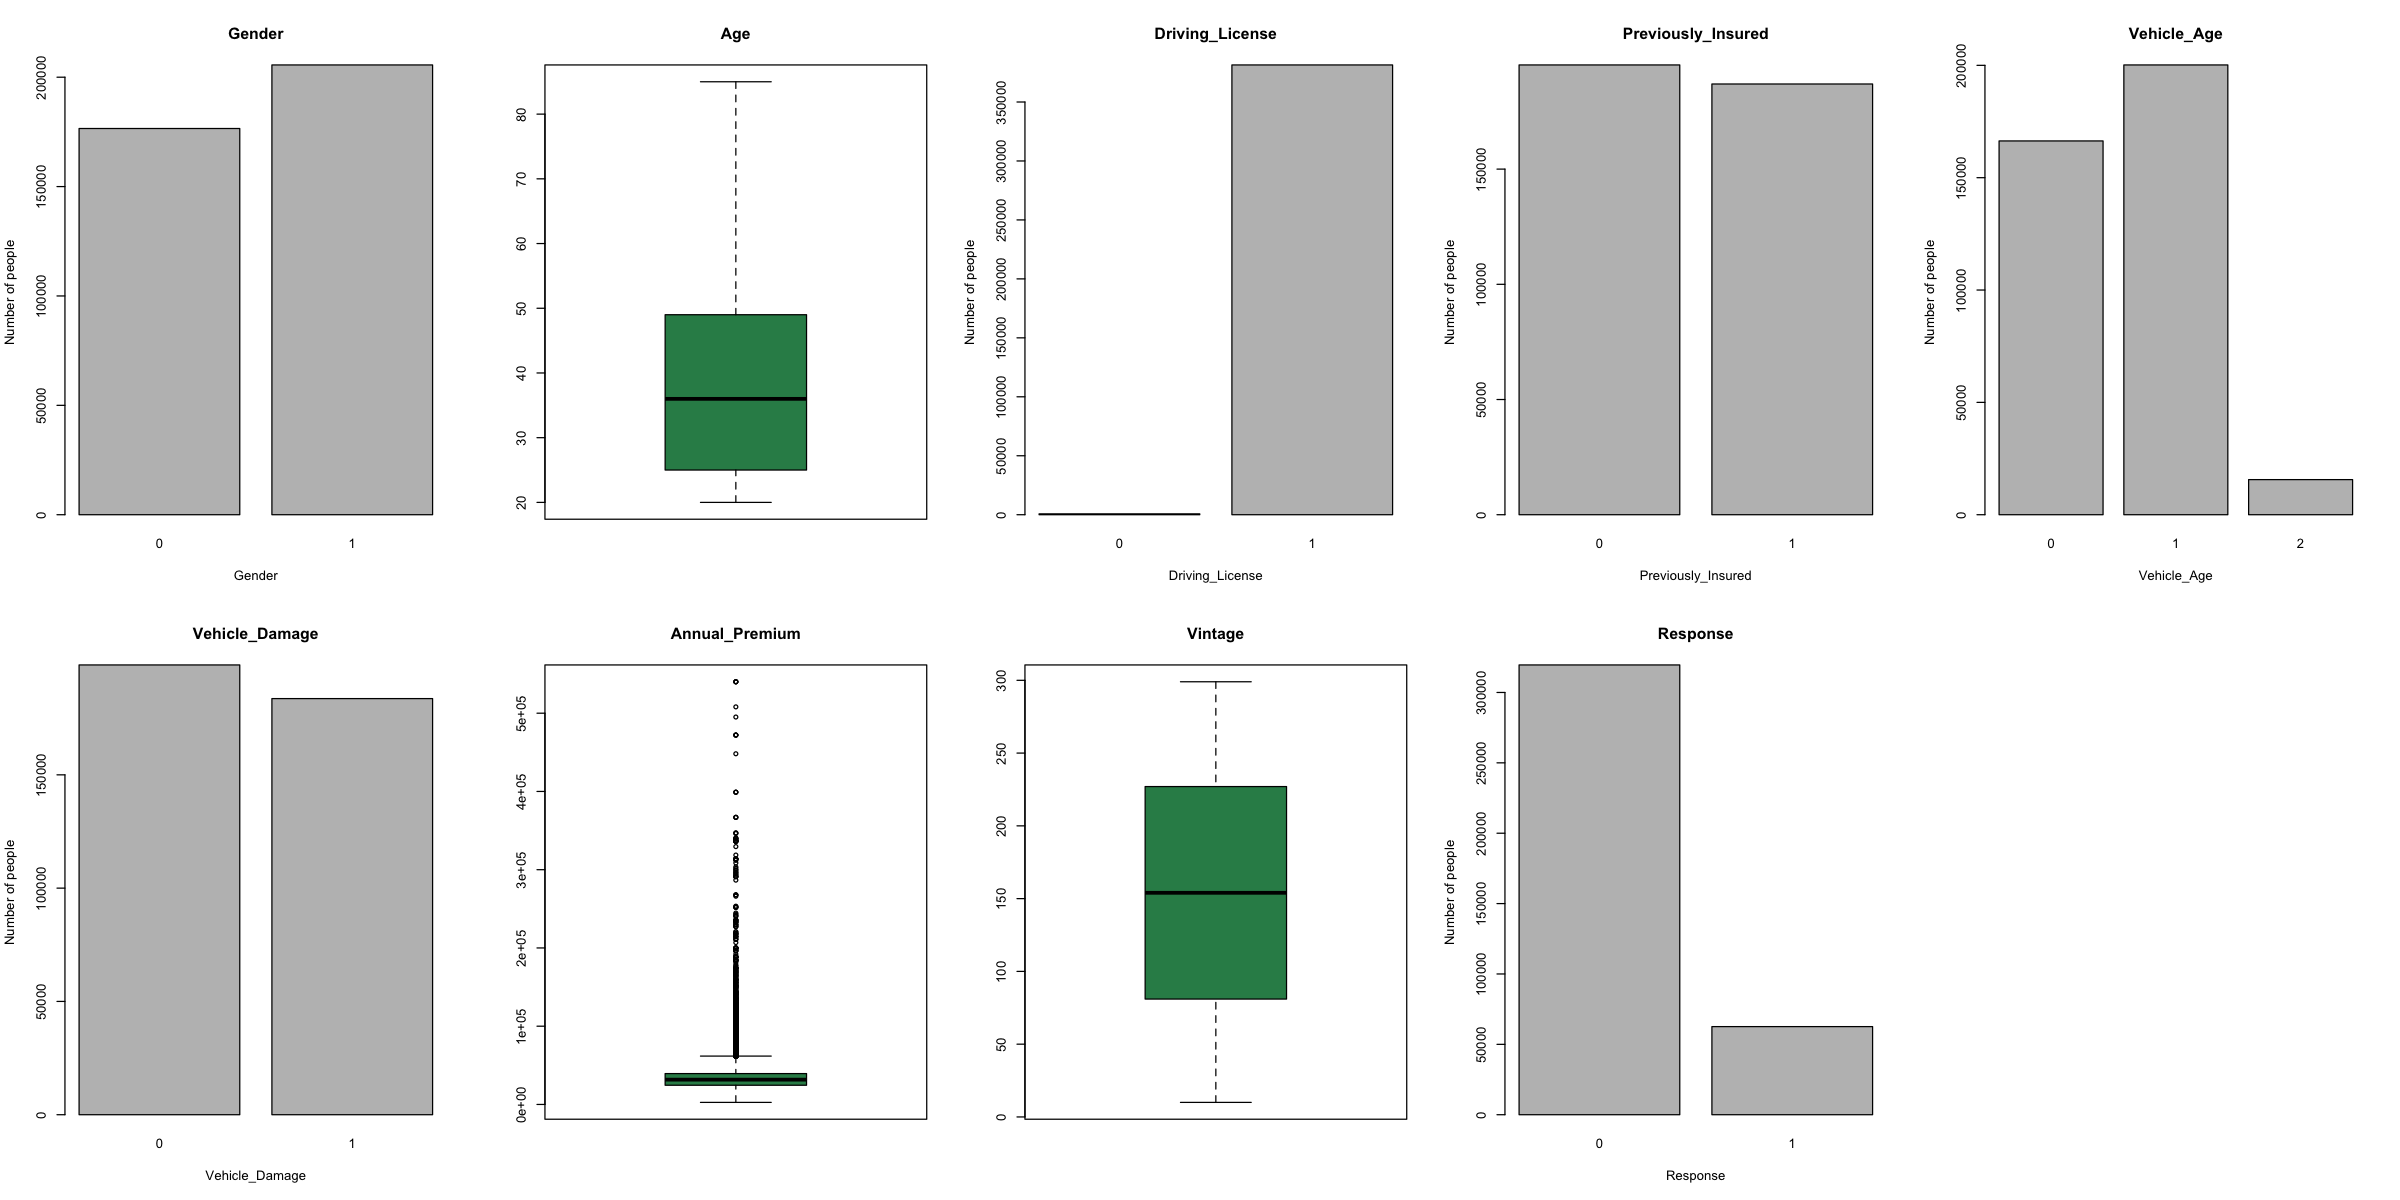

In [11]:
options(repr.plot.width=20,repr.plot.height=10)
par(mfrow=c(2,5))
for (i in 1:ncol(data)) {
    if (i %in% Num.vars){
        boxplot(data[,i],col="seagreen",main=colnames(data)[i])
    } else {
        barplot(table(data[,i]), ylab="Number of people", xlab=colnames(data)[i], main=colnames(data)[i])
    }
}

And now, the possible correlation that might occurr betwen this variables. We only study this among the numerical variables (those with more than 3 unique levels), excluding categorical variables. As manny of our variables are categorical, this analysis is not very insightful. Let's plot this correlation just in case:



In [10]:
round(cor(data[,Num.vars]),2)

Age  Annual_Premium Vintage
Age            1.00 0.07           0      
Annual_Premium 0.07 1.00           0      
Vintage        0.00 0.00           1

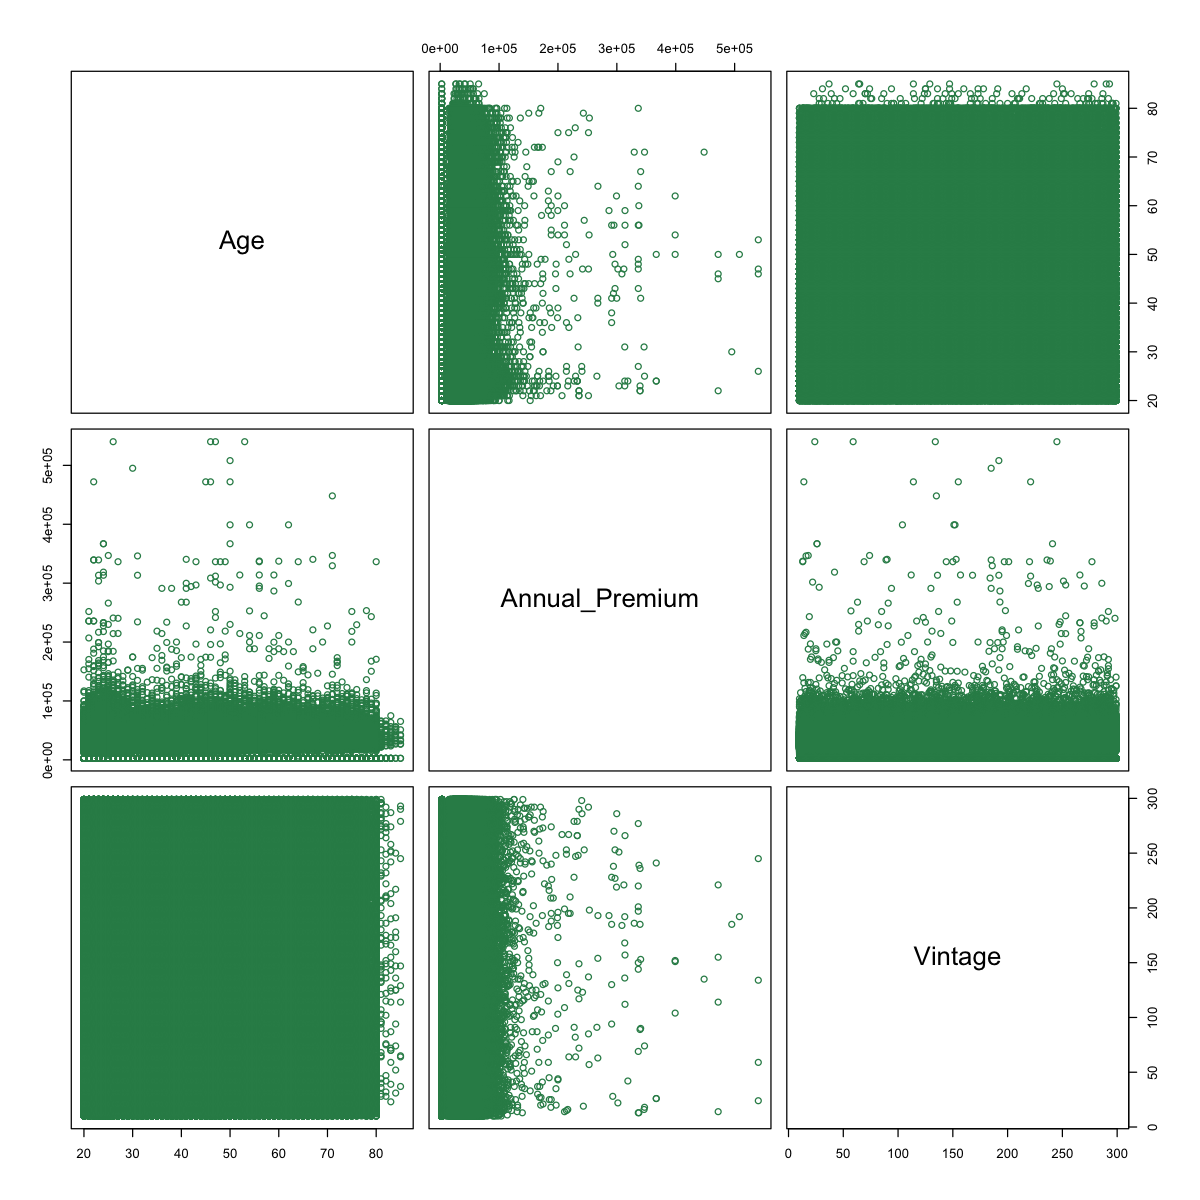

In [11]:
#Lasts 1 min 48 secs
options(repr.plot.width=10,repr.plot.height=10)
pairs(data[,Num.vars],col="seagreen")

Do we have to deal with null values in the dataset? No.

In [12]:
sum(is.na(data))
sum(is.na(test))

[1] 0

[1] 0

A common practice in Machine Learning is perform feature scaling, which helps most models to converge more quickly towards the minima. We can achieve this with the function ``scale``, which centers the variable to 0 mean and unit variance. We will scale all the numerical variables, except for the target variable (``Response``).

In [13]:
data[,Num.vars] <-  as.data.frame(scale(data[,Num.vars]))
test[,Num.vars] <-  as.data.frame(scale(test[,Num.vars]))
data[1:5,]

Gender Age        Driving_License Previously_Insured Vehicle_Age
1 1      -1.0866095 1               1                  0          
2 1       0.2268557 1               0                  1          
3 0       1.8030141 1               0                  1          
4 0      -1.0866095 1               0                  0          
5 1      -0.6925699 1               1                  0          
  Vehicle_Damage Annual_Premium Vintage    Response
1 0              -1.64587604    -1.6503165 0       
2 1               0.73942256    -0.2291683 0       
3 1               0.30065937     1.1800376 0       
4 0              -0.17971774    -1.0173681 0       
5 0              -0.09895155     0.6784558 0

Let's look at this class imbalance we've been told:

In [14]:
print("Cases:")
table(data$Response)
print("Proportion:")
round(table(data$Response)/nrow(data)*100,2)

[1] "Cases:"



     0      1 
319553  62601 

[1] "Proportion:"



    0     1 
83.62 16.38 

Huge! Our first approach to deal with this problem is resampling with the function ``resample`` that we have below. It takes as parameter the amount of samples we want from each class and returns the filtered dataframe. With this approach, we balance the dataset, because we get the same number of samples from the positive than from the negative class.

We have selected this simple approach, and not more sofisticated methods such as SMOTE for the following reason: SMOTE deals with the class imbalance by oversampling the minority class, doing data augmentation in a very smart manner. However, in our case, we have more samples than those we can process, and we need to reduce the training dataset. For this reason, we think that it is sufficient in our case to do undersampling. When undersampling, we can select the same numbers of samples from both classes and, so, the class imbalance is solved. 

In [15]:
resample <- function(data,size) {
    total = size * 2
    if (total > nrow(data)) {
        cat("Not enough data to create a dataframe of size ",total)
        return(data)
    } else if (size > 62601) {
        print("Not enough samples!")
        return(data)
    }
    negative <- sample(x=which(data$Response == 0), size=size, replace=FALSE)
    positive <- sample(x=which(data$Response == 1), size=size, replace=FALSE)
    resampled_idx <- c(negative, positive)
    return(data[resampled_idx, ])
}

## Summary of the work done (Results)

Before proceeding to take a look to the model specification, we want to sum up the work done.

Each one of us focused on one technique/languages: Stan, rstanarm and JAGS. Additionally, for comparison, we have performed frequentist approaches, like a logistic regression and a RandomForest.

### Models created

#### Stan

In Stan we tried the following specifications:

* 20% of samples, balancing equally each class, including all the variables.

* 2% of the samples, including quadratic and interaction terms and regularizing with Bayesian Lasso, with the help of `bmrs`.

#### rstanarm

In rstanarm we tried the following specifications:

* 1400 samples, balancing equally each class, including all the variables.

* Same as above, but performing variable selection using First Differences.

* 2000 samples, **non balancing equally**, performing variable selection using First Differences.

#### JAGS

In JAGS we tried the following specifications:

* 1400 samples, balancing equally each class, including all the variables.

* Same as above, but also including all interaction variables.

#### Frequentist Approach




### Results

As justified on the report below, for the Stan model and the frequentist models we have been able to make predictions on the test dataset, which is unbalanced. However, when using rstanarm and JAGS we have not been able to do this, and have instead tested the performance on the training dataset, which is balanced. For this reason, the results below are not directly comparable. 

| Model    | Samples | Balanced? | Variable Selection? | ROC AUC | PCR AUC |
|----------|---------|-----------|---------------------|-----------|-----------|
| RF       |   12520 | Yes       | No                  |     88.3  |     47.6  |
| Stan     |   12520 | Yes       | No                  |     85.4  |     39.6  |
|Stan/brms |    2504 | Yes       | LASSO+interactions  |     89.0  |     42.8  |
| rstanarm |    1400 | Yes       | No                  |     88.7  |     83.5  |
| rstanarm |    1400 | Yes       | Yes                 |     88.31 |     83.15 |
| rstanarm |    2000 | No        | Yes                 |     87.75 |     45.53 |
| JAGS     |    1400 | Yes       | No                  |     82.66 |     74.74 |
| JAGS     |    1400 | Yes       | Interactio          |     51.55 |     51.67 |



## Modeling

Below we study the problem using different tools.

### Frequentist approach

We will start fitting a logistic regression with the frequentist approach. We will do this in order to get a prior for the intercept and also to get a first idea on the minimum number of samples we need to solve the problem in a estable manner. This first model will also be useful to compare the results we obtain with the Bayesian approaches.

In [16]:
# Repeat 4 times to compare results
for (i in 1:4){
    
    # Select samples
    max_size <- min(table(data$Response))
    n <- max_size*0.02
    df <- resample(data,n)
    if (i == 1){
        print('Matrix dimensions: ')
        print(dim(df))
        print('Number of positive and negative cases: ')
        print(table(df$Response))
    }

    # Fit logistic regression
    formula <- as.formula(paste0('Response ~ ',paste(colnames(df)[-ncol(df)],collapse=' + ')))
    lm.m <- glm(formula, data = df, family = "binomial")
    
    # Summary of the model
    print(summary(lm.m))
}

[1] "Matrix dimensions: "
[1] 2504    9
[1] "Number of positive and negative cases: "

   0    1 
1252 1252 

Call:
glm(formula = formula, family = "binomial", data = df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.3311  -0.0871   0.0338   0.7503   3.5195  

Coefficients:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)        -1.57732    1.90579  -0.828  0.40787    
Gender              0.17922    0.11224   1.597  0.11032    
Age                -0.40044    0.08327  -4.809 1.52e-06 ***
Driving_License    -0.72611    1.90453  -0.381  0.70301    
Previously_Insured -4.31690    0.60877  -7.091 1.33e-12 ***
Vehicle_Age         1.05936    0.14888   7.116 1.11e-12 ***
Vehicle_Damage      2.39305    0.30156   7.936 2.09e-15 ***
Annual_Premium      0.15572    0.05583   2.789  0.00528 ** 
Vintage            -0.03933    0.05355  -0.734  0.46268    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomi

By manually inspecting the results, we can see that they are relatively stable in general terms (the variables with the strongest estimates tend to be the same, the direction of the effect is always the same, etc.), although there is still some variability. This is specially true for the variable `driving_license`, fow which we have seen that there are only a few negative cases. We have tried again by increasing progressively the sample sizes (results not shown) and show here the results for the smallest sample size were we observed a strong consistency.

In [17]:
# Repeat 4 times to compare results
for (i in 1:4){
    
    # Select samples
    max_size <- min(table(data$Response))
    n <- max_size*0.2
    df <- resample(data,n)
    if (i == 1){
        print('Matrix dimensions: ')
        print(dim(df))
        print('Number of positive and negative cases: ')
        print(table(df$Response))
    }

    # Fit logistic regression
    formula <- as.formula(paste0('Response ~ ',paste(colnames(df)[-ncol(df)],collapse=' + ')))
    lm.m <- glm(formula, data = df, family = "binomial")
    
    # Summary of the model
    print(summary(lm.m))
}

[1] "Matrix dimensions: "
[1] 25040     9
[1] "Number of positive and negative cases: "

    0     1 
12520 12520 

Call:
glm(formula = formula, family = "binomial", data = df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.4246  -0.0979   0.1336   0.7517   3.5789  

Coefficients:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)        -3.99455    0.51126  -7.813 5.58e-15 ***
Gender              0.14260    0.03545   4.023 5.74e-05 ***
Age                -0.45355    0.02724 -16.653  < 2e-16 ***
Driving_License     1.60937    0.50289   3.200 0.001373 ** 
Previously_Insured -4.10765    0.18445 -22.270  < 2e-16 ***
Vehicle_Age         1.18601    0.04787  24.774  < 2e-16 ***
Vehicle_Damage      2.38583    0.08956  26.640  < 2e-16 ***
Annual_Premium      0.06171    0.01707   3.615 0.000301 ***
Vintage            -0.03295    0.01733  -1.901 0.057250 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for 

The results seem to be quite stable now, both in terms of estimates and p-values. However, it will be probably unfeasible with work with 20% of the samples. Because the computations may take too long, we have decided to first explore the models using small sample sizes, but finally try to execute the most satisfactory models using close to 20% of the samples.

From this model, we will keep the intercept from the linear regression (b0 coeficient), which can be useful to center the intercept Bayesian prior.

In [18]:
b0_hat = as.numeric(coef(lm.m)[1])
round(b0_hat,4)

[1] -4.0316

### Random Forest

For comparison, we will fit a frequentist random forest, that we have been told that works quite well, and check its performance. This will give us some reference on how well can we expect our bayesian models to perform. To be fair with the Bayesian methods, in this case we will also use only 20% of the training samples.

This model also gives us some additional intuition into which variables are more important, which will be usefull to know.


Call:
 randomForest(x = df[, -ncol(df)], y = factor(df$Response), ntree = 500,      importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 2

        OOB estimate of  error rate: 17.06%
Confusion matrix:
     0     1 class.error
0 9122  3398  0.27140575
1  874 11646  0.06980831

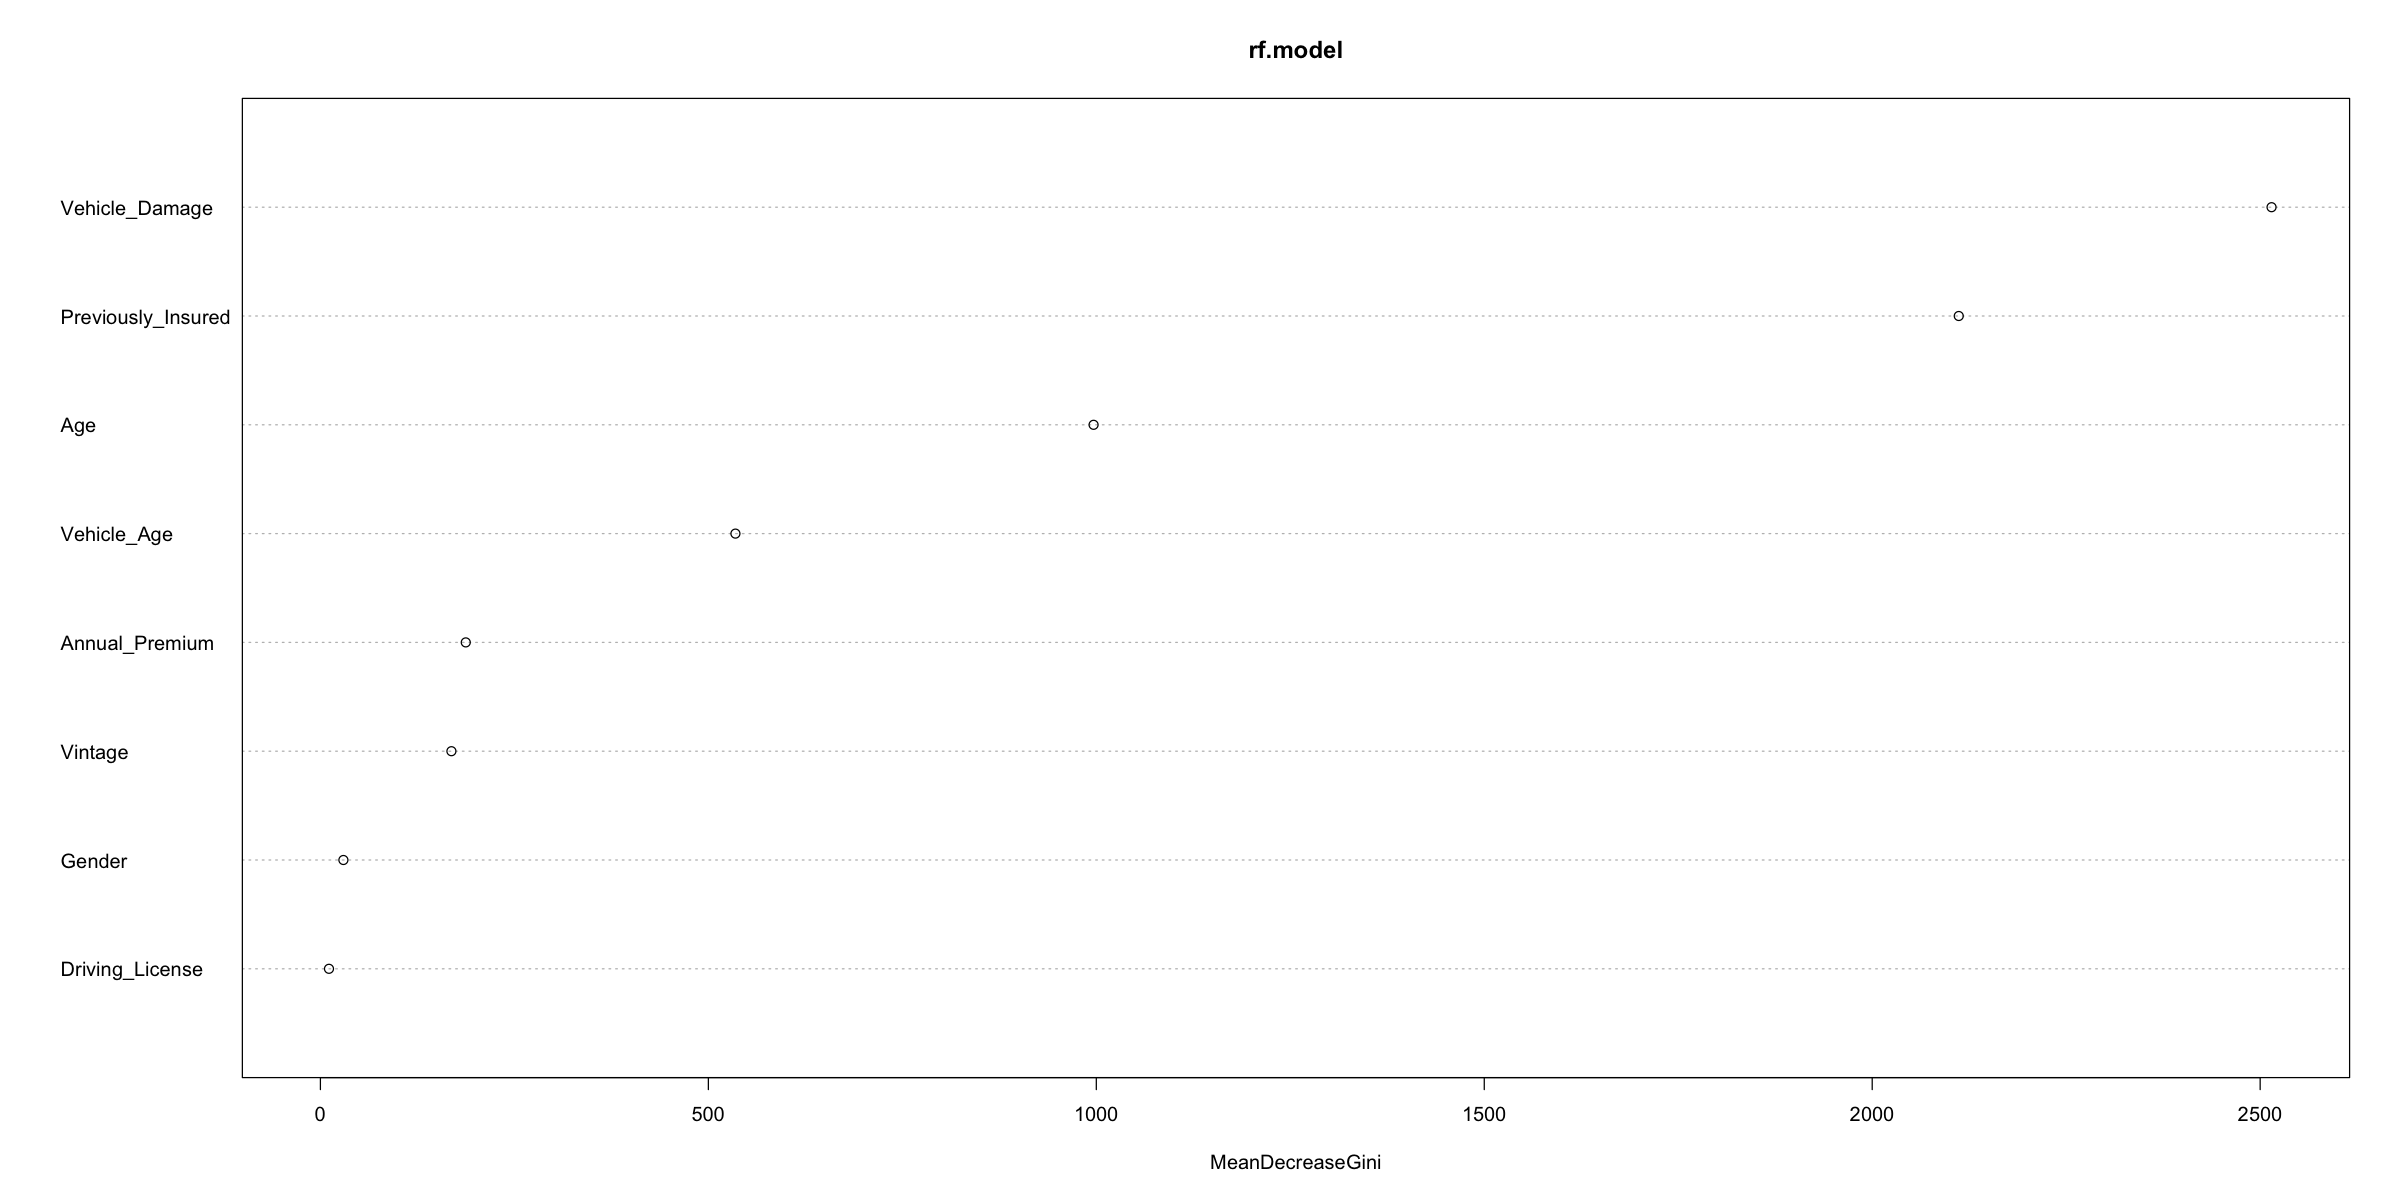

In [34]:
library(randomForest)
n <- max_size*0.2
df <- resample(data,n)
n_test <- 1000
samples_test <- sample(1:nrow(test), size=n_test)
df_test = test[samples_test,-ncol(test)] # FER BÉ!!!
y_test = factor(test[samples_test,'Response'])

rf.model <- randomForest(x=df[,-ncol(df)], y=factor(df$Response), 
                         importance = TRUE, ntree=500) 

rf.model
varImpPlot(rf.model,type=2)

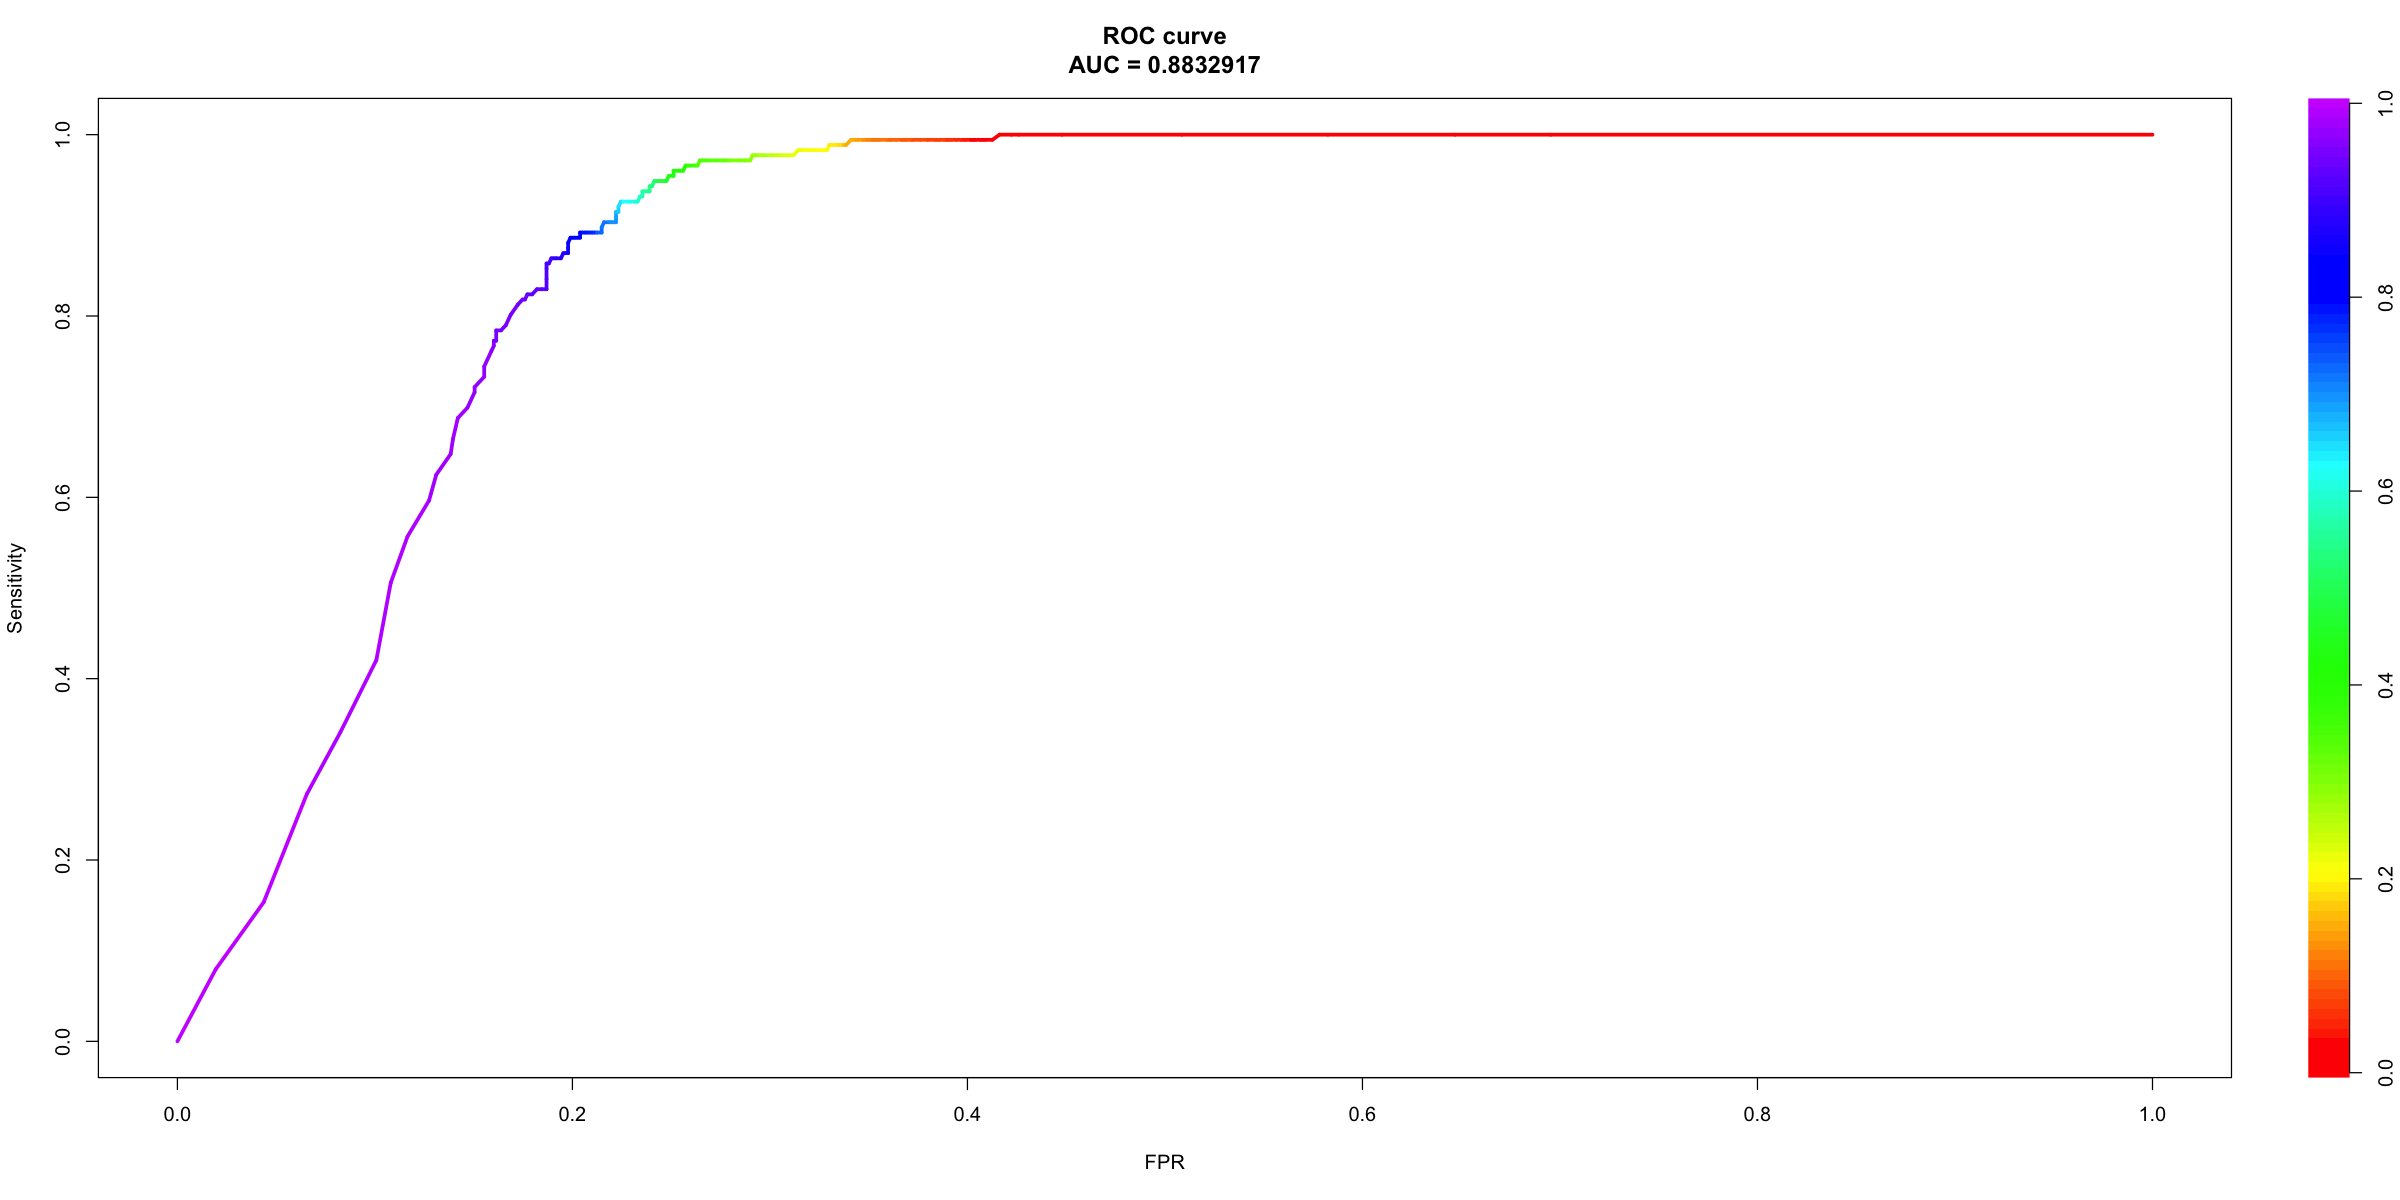

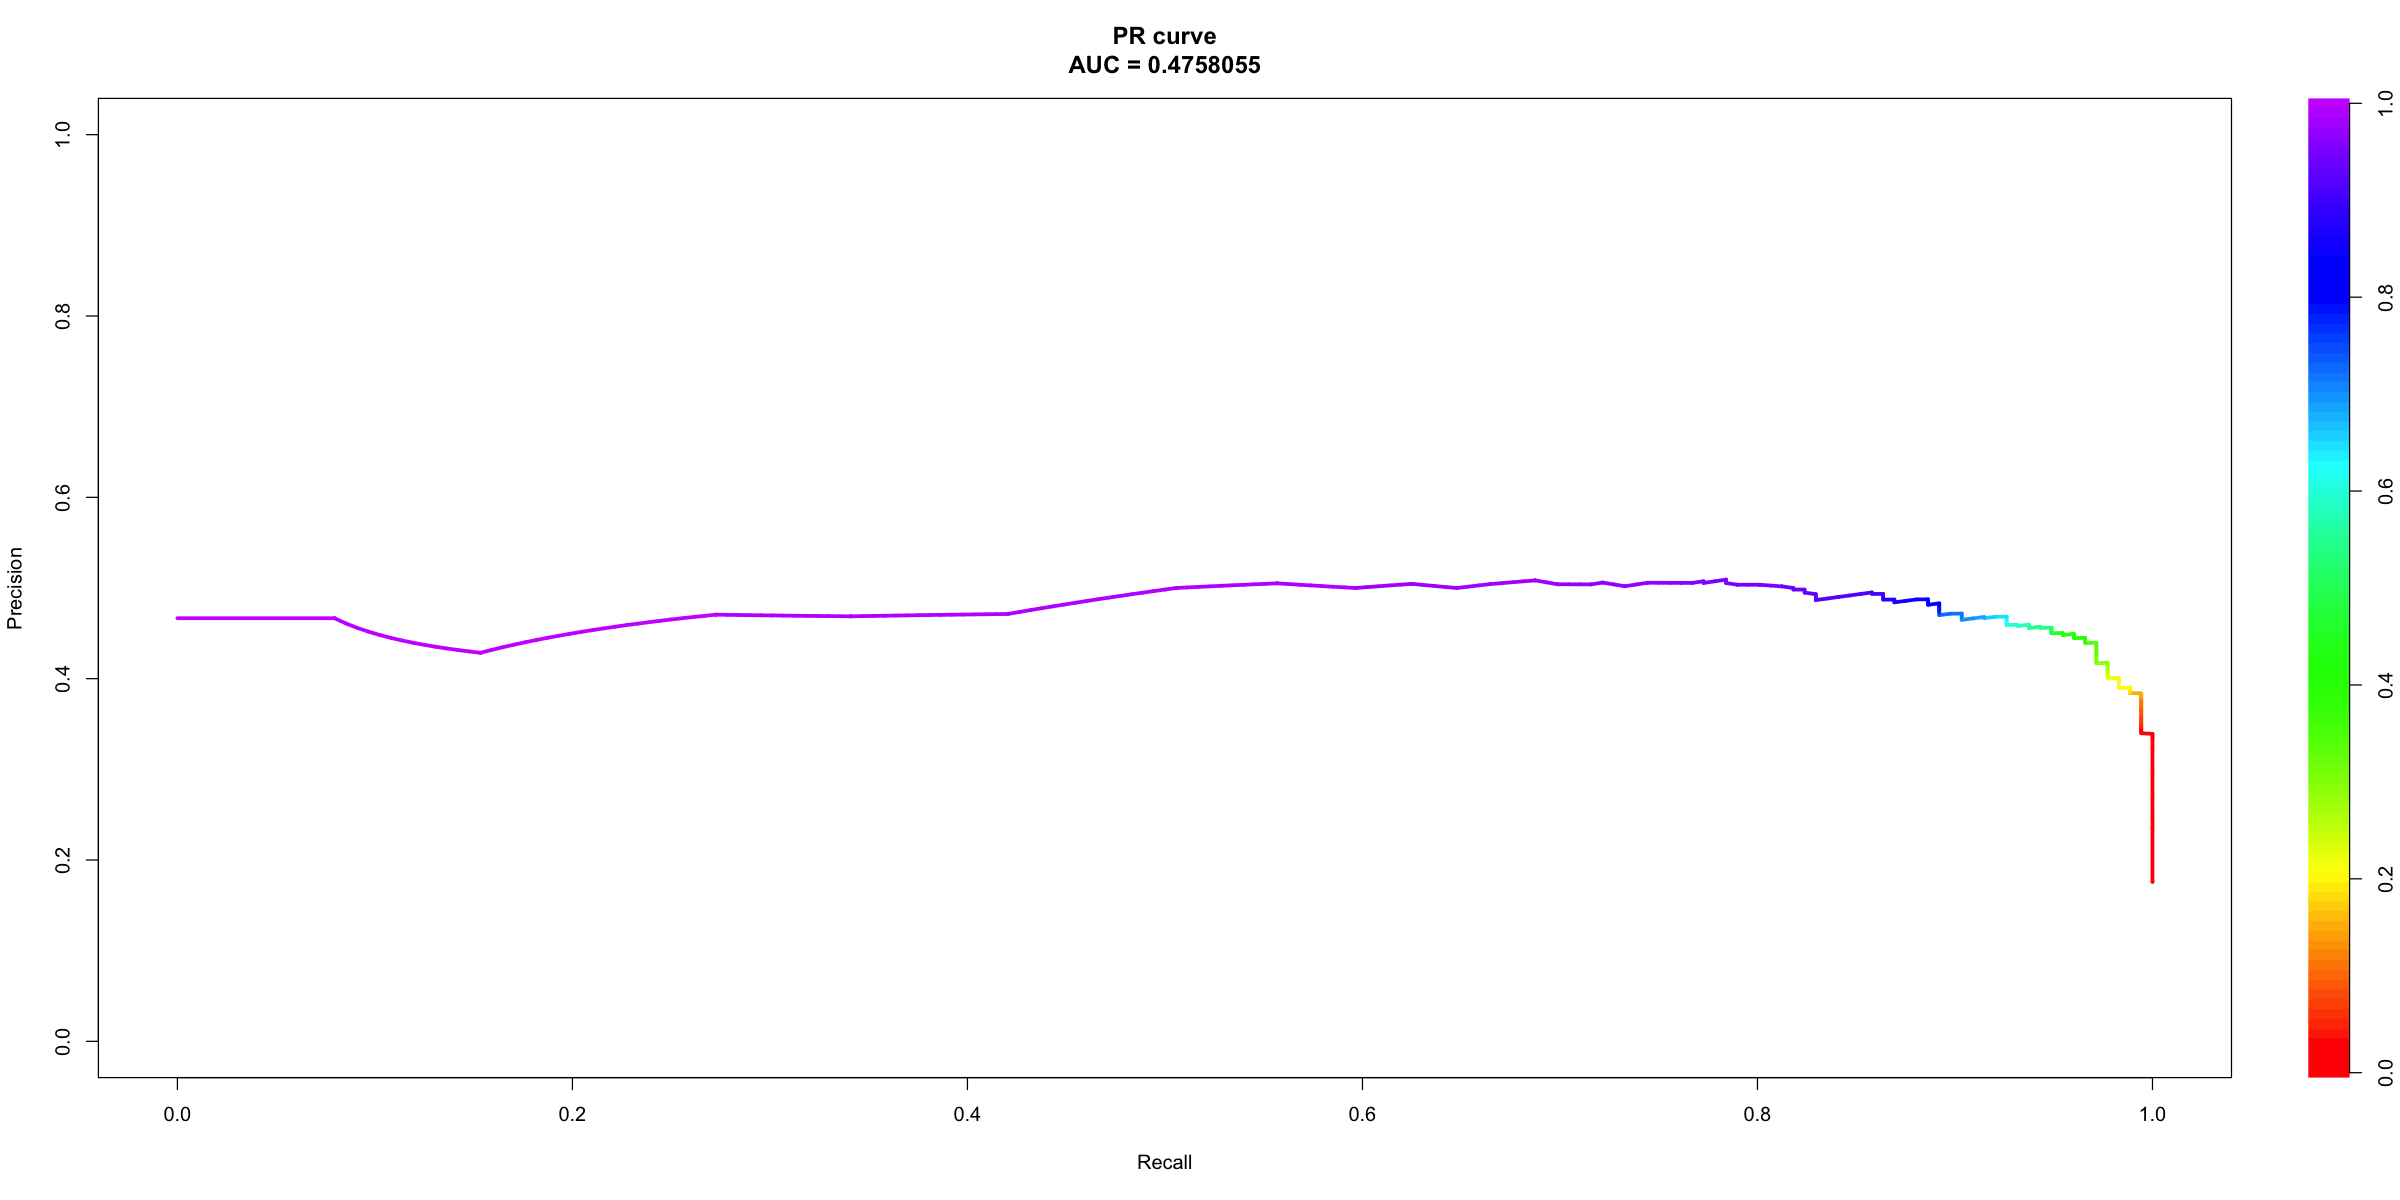

In [41]:
library(PRROC)

# Reconvert y_test to numeric
y_test <- as.numeric(as.character(y_test))

# Predict test samples
rf.ytest.preds <- predict(rf.model, df_test, type="prob")[,2]

# Check performance with ROC and Precision and Recall curbes
rf.roc <- roc.curve(weights.class0=y_test, scores.class0=rf.ytest.preds, curve=TRUE)
plot(rf.roc)
rf.pr <- pr.curve(weights.class0=y_test, scores.class0=rf.ytest.preds, curve=TRUE)
plot(rf.pr)

We observe what seems to be a very good performance in terms of the AUC-ROC, with a value of 0,883. It should be noted that this is in fact not such a good performance, because we have an 80% majority class. This means, that assigning every one to the majority class already gives an acuracy of 80%. It is for this reason that the PR-AUC, which is less sensible to the imbalance, is much worse, with a value of 0,476. 

Regarding the features, we see that vehicle damage and being insured are the most predictive features. This is coherent with the estimates and p-values observed in the linear model.

## RStan

### Defining and fitting the model

For this first model, we will use all the predictor variables and propose the following model:

$$
    y_i \sim \operatorname{Bernoulli}(\pi_i)
$$

Where the inverse link function:

$$
    \pi_i = \dfrac{\exp(x_i'\cdot\beta)}{1 + \exp(x_i'\cdot \beta)}
$$

And a multivariate Normal prior on $\beta$:

$$
    \beta \sim \operatorname{N}(b_0,B_0^{-1})
$$

For all the coefficients we have started using a standard deviation of the prioir of 3. After ingreasing the variance to 10, we have observed a better performance, so we have kept this value. Although this suggests that greater values may work better, we have been unable to try it because this leads to convergence errors (probably a matter of increasing the `max_treedepth` value). For the intercept, $\beta_{0}$, the normal is centered in the estimate of the frequentist linear model, $\hat{\beta_{0}}$. All the other coefficients are centered on 0.

We have used the `generate_samples` section of the code to compute posterior probability distributions for the response variable of the test dataset, that we will afterwards use to check the model performance.

In [19]:
#install.packages("rstan", repos= "https://cloud.r-project.org")
options(mc.cores = parallel::detectCores())
require(rstan)
rstan_options(auto_write = TRUE)
Sys.setenv(LOCAL_CPPFLAGS = '-march=corei7 -mtune=corei7')

Loading required package: rstan

Loading required package: StanHeaders

Loading required package: ggplot2

rstan (Version 2.21.2, GitRev: 2e1f913d3ca3)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)



In [20]:
# Subsample dataset
max_size <- min(table(data$Response))
n <- max_size*0.1
#n <- max_size*0.2
df <- resample(data,n)
n <- nrow(df) # Number of samples
p <- ncol(df) - 1 # Number of predictors (we also have response in df)
print(n)
print(p)

# Take some samples for testing (all samples with the same probability, i.e. no balancing)
n_test <- 300
samples_test <- sample(1:nrow(test), size=n_test)
df_test = test[samples_test,-ncol(test)]
y_test = test[samples_test,'Response']

[1] 12520
[1] 8


In [21]:
# Define the model
logit.stan.model <- "
    data{
        int<lower=1> n; //Number of data items
        int<lower=1> p; //Number of coefficients
        matrix[n,p] X; //Predictors matrix
        int<lower=0,upper=1> y[n]; //Outcome vector
        real b0_hat;
        int<lower = 1> n_test;
        matrix[n_test,p] x_test; //Predictors matrix for test

    }
    parameters{
        real b0;
        vector[p] b;
    }
    model{
        // Model
        y ~ bernoulli_logit(b0 + X*b);

        // Priors
        b0 ~ normal(b0_hat,10);

        for(i in 1:p)
            b[i] ~ normal(0,10);

    }

    generated quantities {
        vector[n_test] y_test;
        y_test=inv_logit(b0 + x_test*b);
    //y_test = bernoulli_rng(inv_logit(b0 + x_test*b));
       // for (i in 1:n_test)
       //     y_test[n]=bernoulli_rng(inv_logit(b0 + x_test[i,:]*b));
    }   
"

In [22]:
# Add the data
logit.stan.data <- list(n=n, p=p, y=df$Response, X=as.matrix(df[,-ncol(df)]), b0_hat=b0_hat,
                       x_test=as.matrix(df_test), n_test=n_test)

In [23]:
# Run
logit.stan <- stan(model_code = logit.stan.model, data = logit.stan.data, iter = 2500,
             chains = 3, verbose = FALSE, seed=101, warmup=500)

In [24]:
# Store parameters and predictions distribution
logit.stan.summary <- summary(logit.stan)$summary
logit.stan.preds <- logit.stan.summary[grepl('y', row.names(logit.stan.summary)), ]
logit.stan.summary <- logit.stan.summary[grepl('b', row.names(logit.stan.summary)), ]

### Diagnostic plots

With the trace plots, we see a good convergence and no auto-correlation for all the coefficients. Therefore, we can keep using the current number of iterations and warmup.

Loading required package: bayesplot

This is bayesplot version 1.8.0

- Online documentation and vignettes at mc-stan.org/bayesplot

- bayesplot theme set to bayesplot::theme_default()

   * Does _not_ affect other ggplot2 plots

   * See ?bayesplot_theme_set for details on theme setting



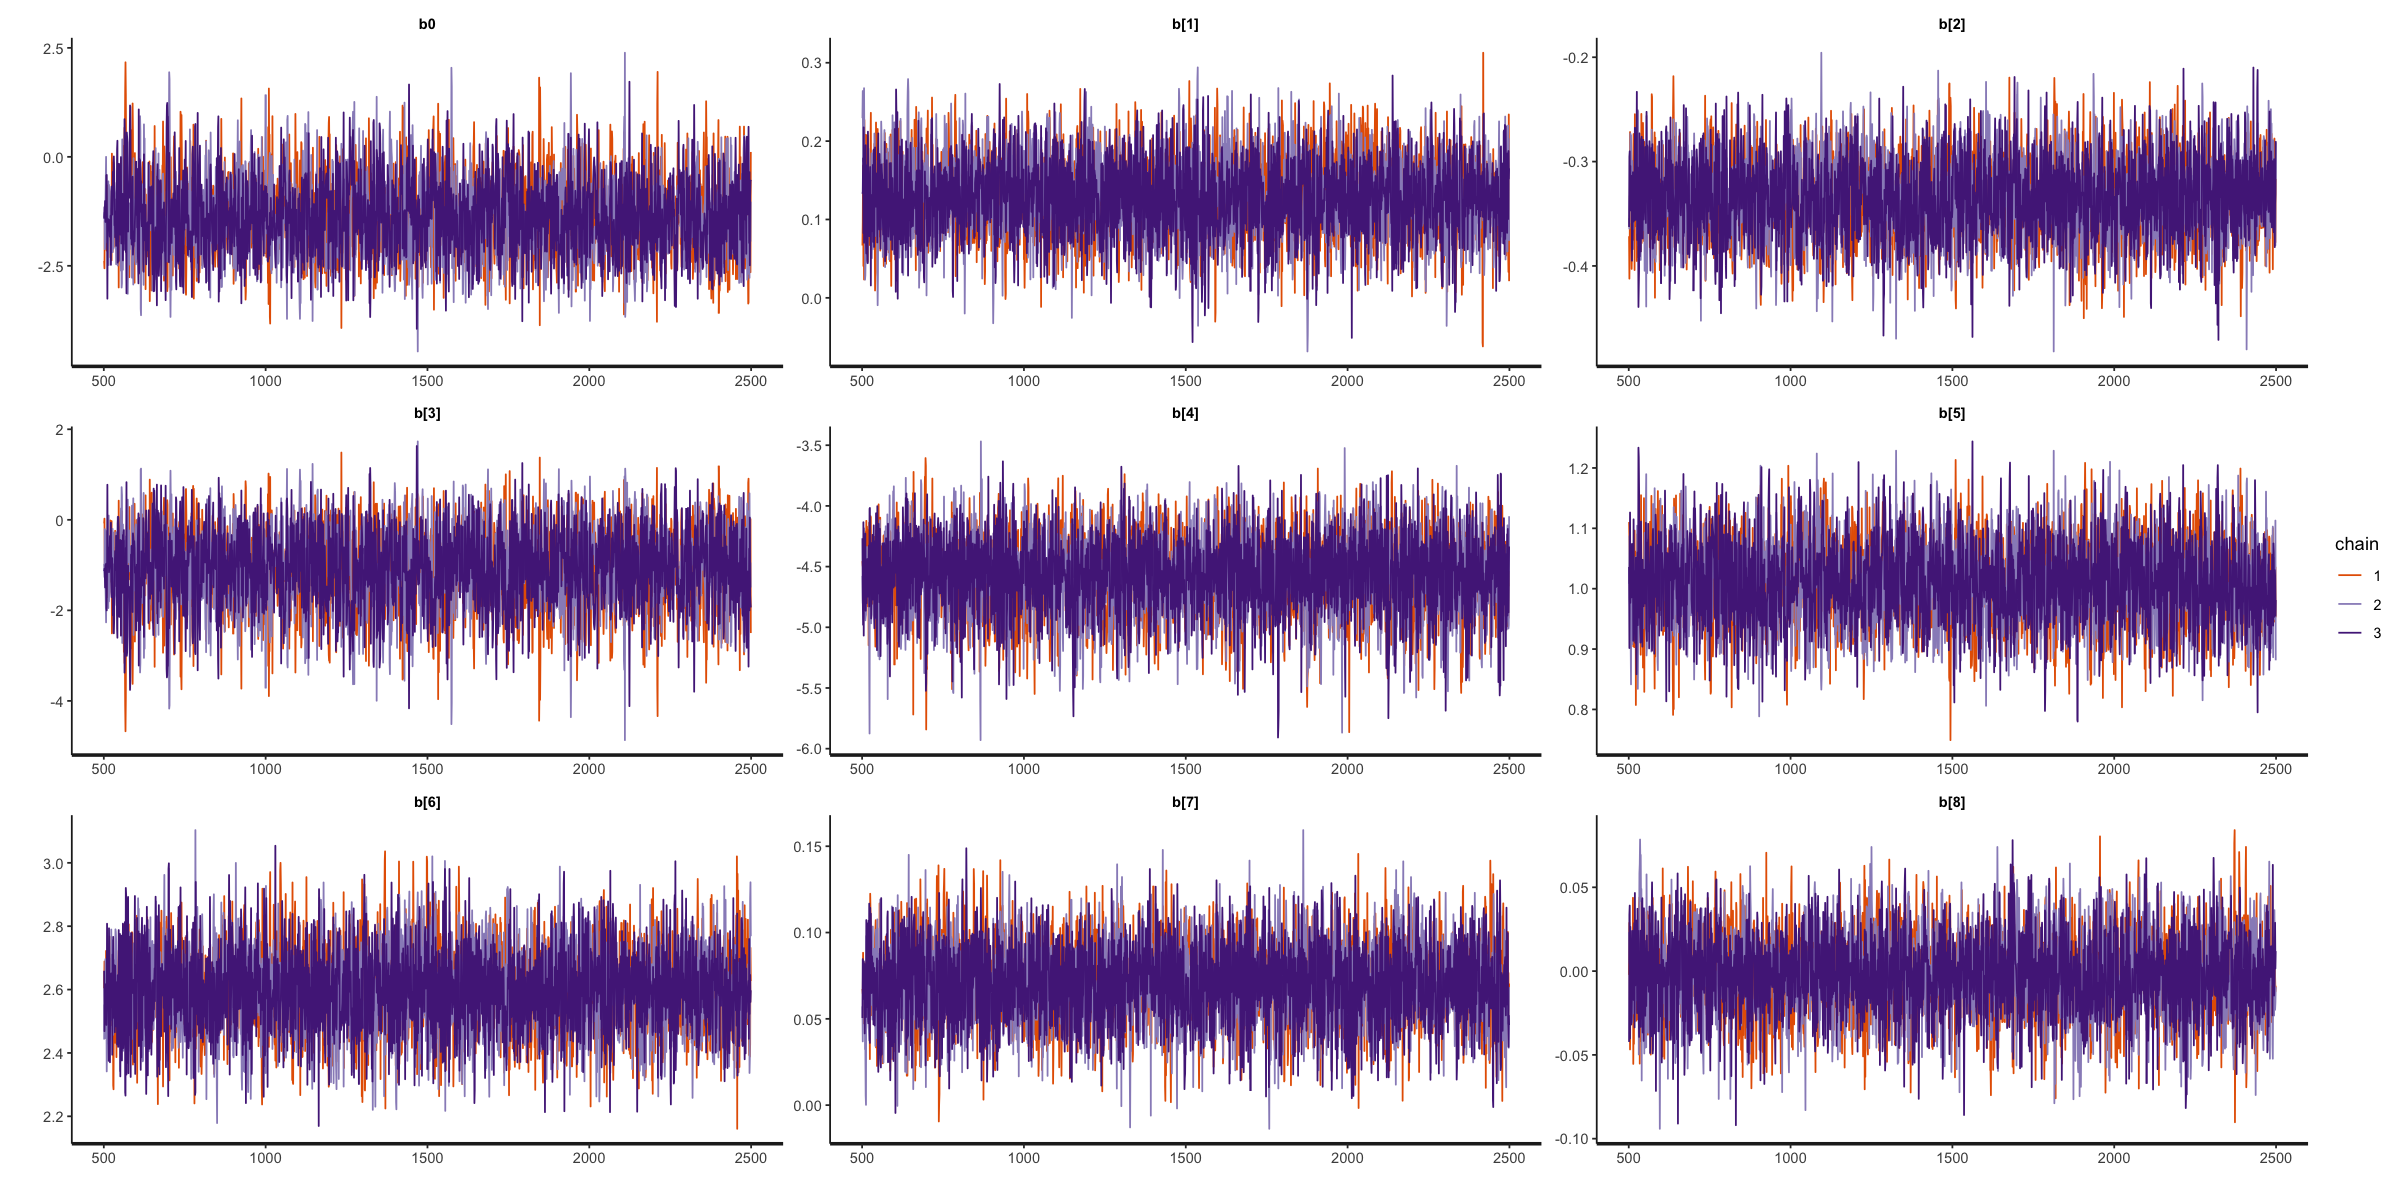

In [25]:
# Trace plots
require(bayesplot)
options(repr.plot.width=20, repr.plot.height=10)
stan_trace(logit.stan, pars=c("b0","b"))

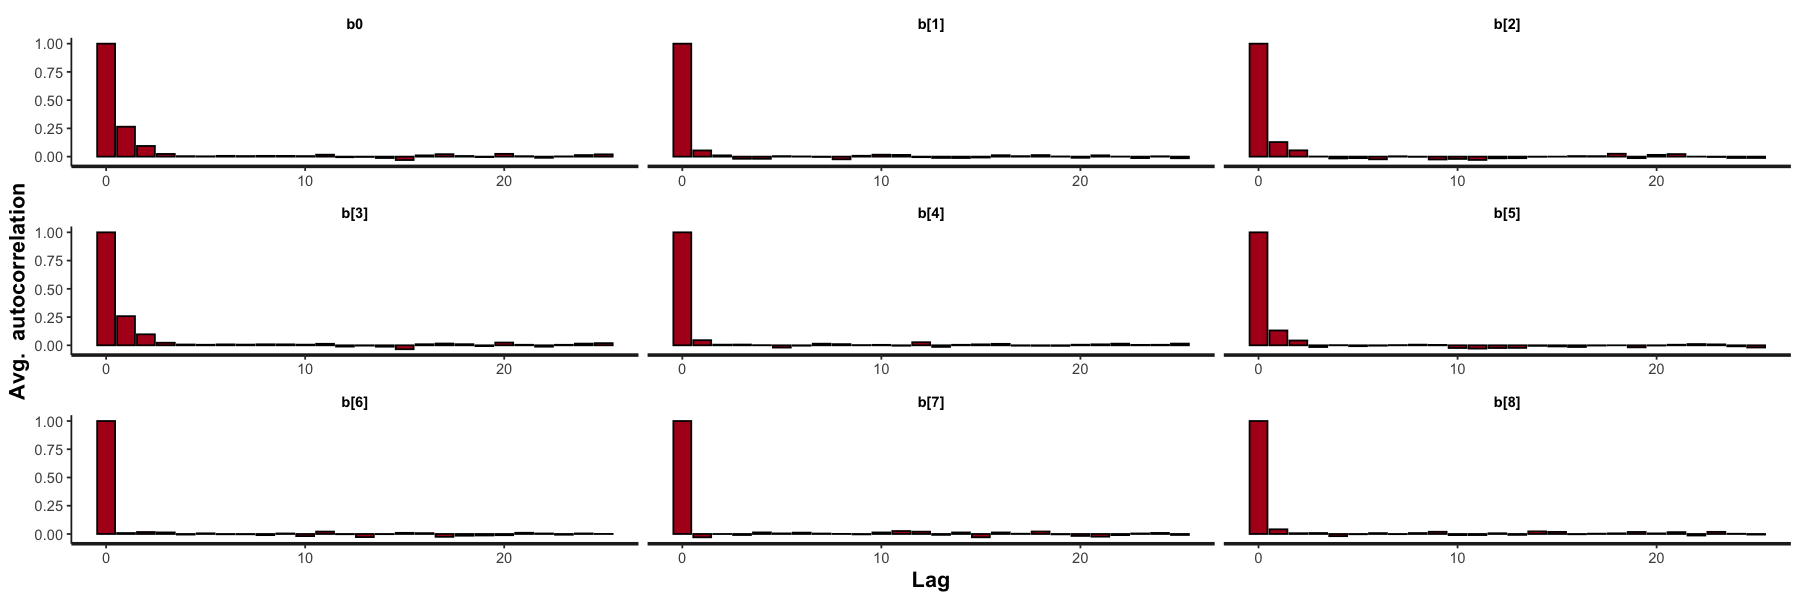

In [26]:
# Auto-correlation
options(repr.plot.width=15, repr.plot.height=5)
stan_ac(logit.stan, pars=c("b0","b"))

### Coefficients posterior distribution

Let's investigate the obtained posterior distributions for the coefficients. By comparing the mean of the coefficients to the estimates of the frequentist linear model, we can see that the estimations are, in fact, quite concordant, specially for the coefficients that were significant in the linear model. The variable `Driving_License` is highly discordant between the two models (effects in the opposite direction), and this is very likely due to the fact that we have very few samples with value 0, so we would require a really big number of samples to accurately estimate this coefficient.

In [27]:
# Print parameters summary distribution (mean, median)
logit.stan.summary

# Compare to the paramaters from the frequentist linear model
summary(lm.m)

mean         se_mean      sd         2.5%        25%         50%         
b0   -1.383217245 0.0156385582 0.89252319 -3.00086018 -2.00627329 -1.424457586
b[1]  0.128267483 0.0006922391 0.05086309  0.02623746  0.09462149  0.128240686
b[2] -0.335321575 0.0005897821 0.03897800 -0.40999938 -0.36165526 -0.335699327
b[3] -1.069426954 0.0155956483 0.88259764 -2.93775505 -1.64284326 -1.027073982
b[4] -4.579799166 0.0045782520 0.33606167 -5.29043555 -4.79810099 -4.563948469
b[5]  1.009696201 0.0010233362 0.06901169  0.87704631  0.96254398  1.010106300
b[6]  2.595874666 0.0017955689 0.13387113  2.33429510  2.50394824  2.596851124
b[7]  0.069943521 0.0002979455 0.02378032  0.02340165  0.05405018  0.069961715
b[8] -0.002713762 0.0003367314 0.02471511 -0.05198335 -0.01933864 -0.002549139
     75%         97.5%       n_eff    Rhat     
b0   -0.80637635  0.50479045 3257.209 1.0006489
b[1]  0.16263980  0.22612855 5398.749 1.0006436
b[2] -0.30908129 -0.25716319 4367.731 1.0003654
b[3] -0.44404661  0.52624559 3202.718 1.0007424
b[4] -4.34848322 -3.96170810 5388.136 0.9998022
b[5]  1.05665223  1.14606722 4547.876 1.0000465
b[6]  2.68414065  2.86144093 5558.654 0.9997155
b[7]  0.08644460  0.11626398 6370.325 0.9995946
b[8]  0.01394967  0.04510801 5387.134 0.9997317


Call:
glm(formula = formula, family = "binomial", data = df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.3758  -0.0883   0.1572   0.7461   3.5177  

Coefficients:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)        -4.03161    0.46606  -8.650  < 2e-16 ***
Gender              0.08578    0.03574   2.400 0.016401 *  
Age                -0.42231    0.02702 -15.629  < 2e-16 ***
Driving_License     1.51515    0.45637   3.320 0.000900 ***
Previously_Insured -4.03506    0.18683 -21.597  < 2e-16 ***
Vehicle_Age         1.10538    0.04774  23.153  < 2e-16 ***
Vehicle_Damage      2.63733    0.09450  27.910  < 2e-16 ***
Annual_Premium      0.06307    0.01688   3.735 0.000187 ***
Vintage            -0.01317    0.01755  -0.750 0.453056    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 34713  on 25039  degrees of freedom
Residual deviance: 19769  on

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



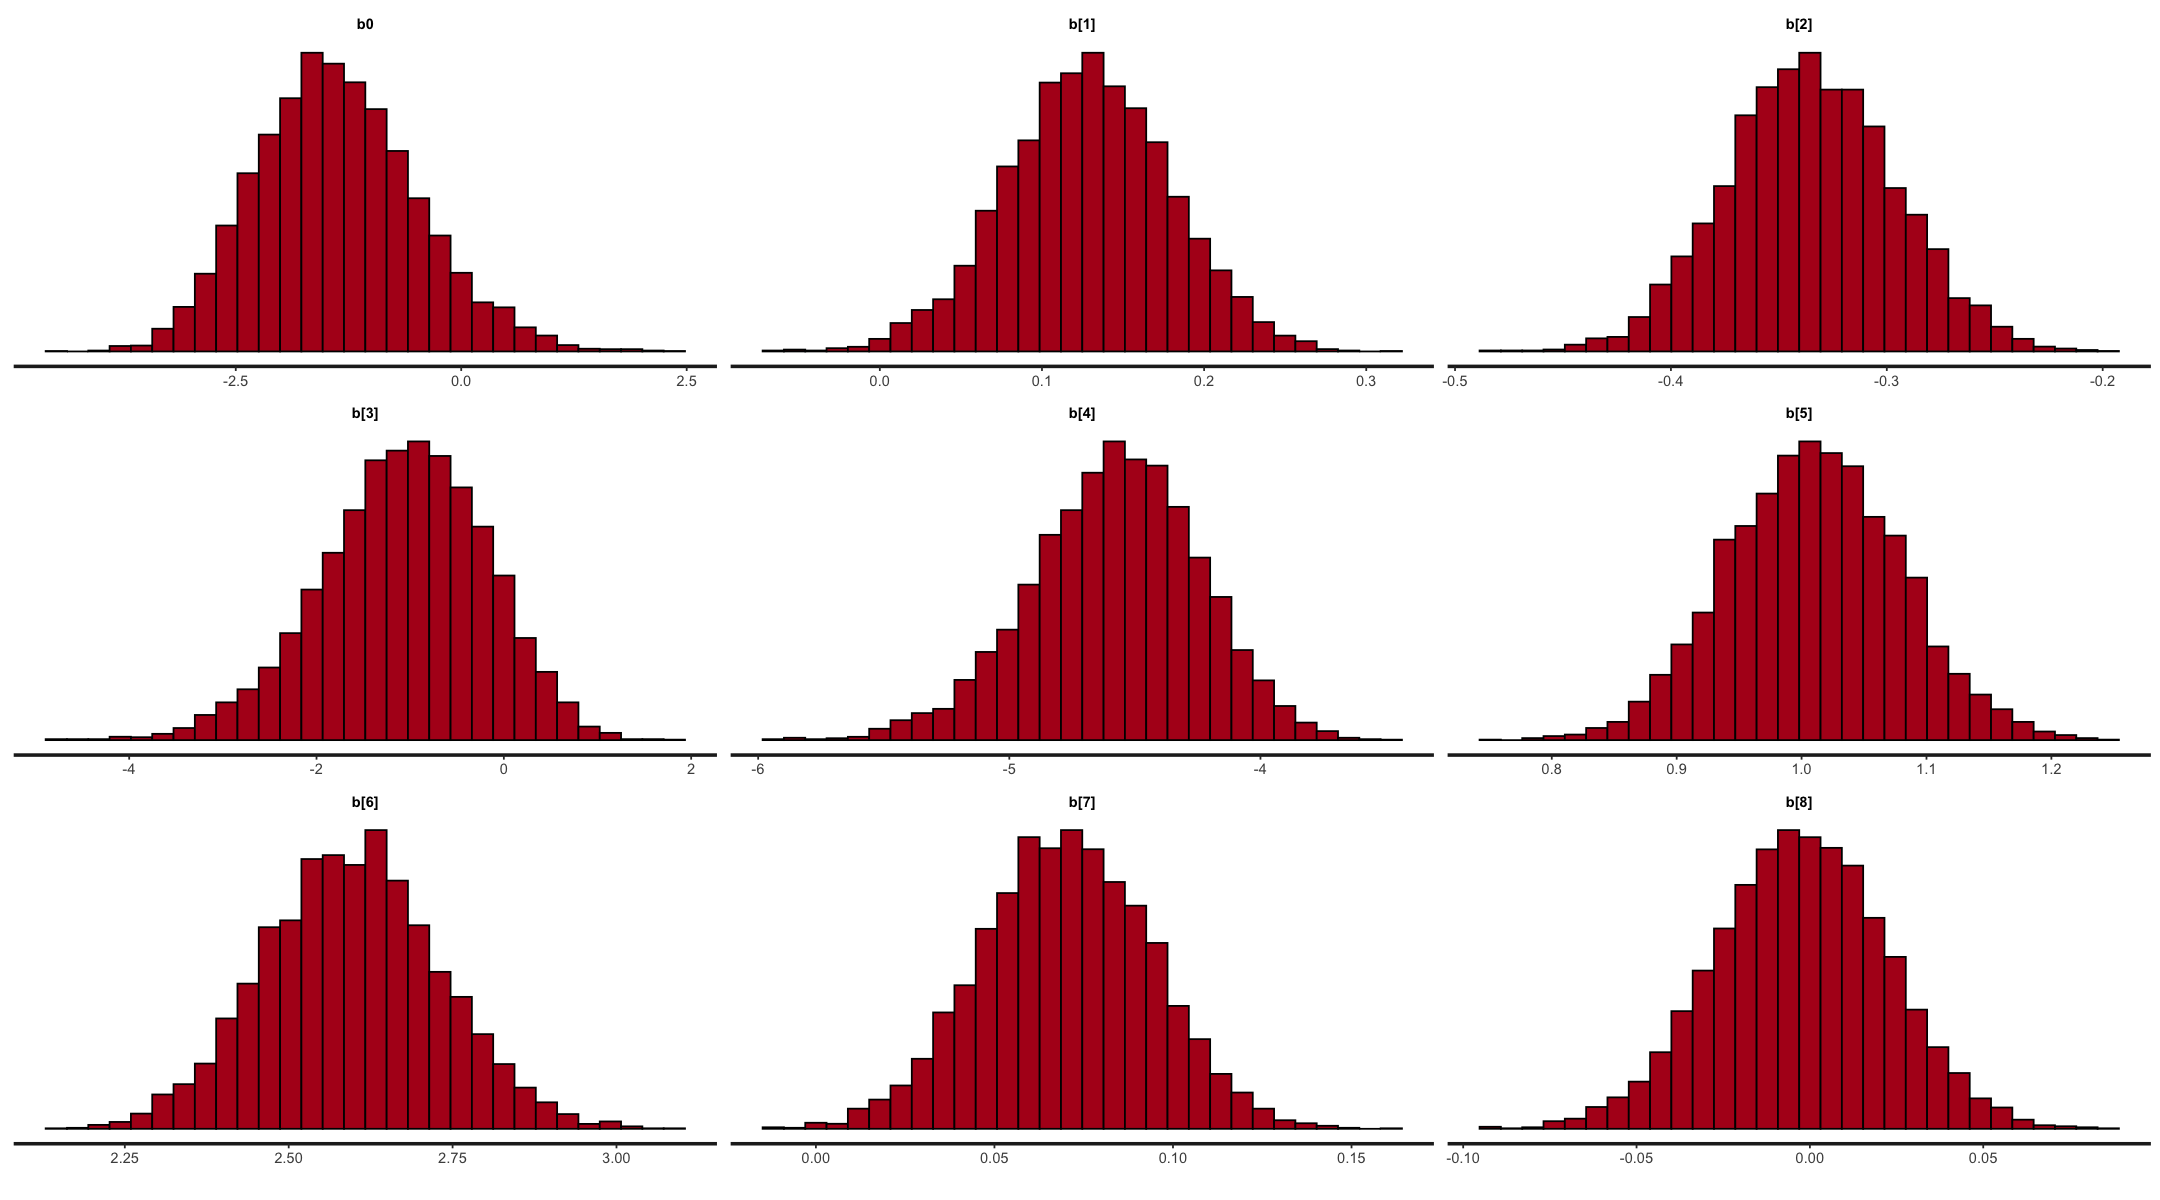

In [28]:
# Plot the obtained parameters posteriors distribution
options(repr.plot.width=18,repr.plot.height=10)
stan_hist(logit.stan, pars=c("b0","b"))

ci_level: 0.8 (80% intervals)

outer_level: 0.95 (95% intervals)



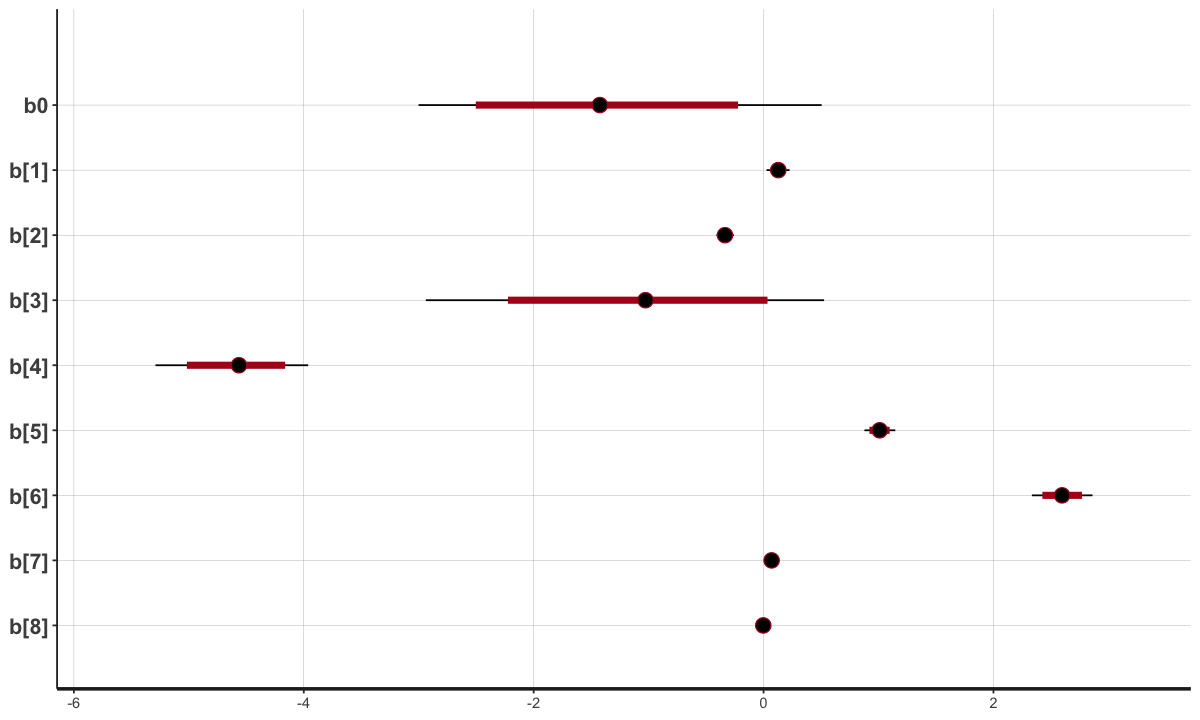

In [29]:
# Plot summary of the distributions
options(repr.plot.width=10, repr.plot.height=6)
stan_plot(logit.stan, pars=c("b0","b"))

In [30]:
# Print variable names to be able to interpret the results
colnames(df)

[1] "Gender"             "Age"                "Driving_License"   
[4] "Previously_Insured" "Vehicle_Age"        "Vehicle_Damage"    
[7] "Annual_Premium"     "Vintage"            "Response"

We can see that the variablest with a greater effect size on our target variable of interest `Response` are `Previusly_Insured`, with a negative effect, and `Vehicle_Damage`. This is concordantwith the results obtained with the random forest.

### Measuring performance
 
To test performance we will use the generated quantities for the `x_test` dataset we have passed to stan. We have the posterior probability distribution for each of the testing samples we have passed to the model, which represents the pdf of the probability of each sample belonging to class 0 or class 1. To test the performance of our classifier, we will compute the MAP of each sample (i.e. the most probable probability) and use this probability to compute a classical ROC curve. If we want to compute the accuracy of the model, we need to assign samples to class 0 or class 1 using some threshold (e.g. prob < 0.5 -> class 0, else -> class 1).

From the summary, we can obtain the summary distribution of the posterior of each $y_i$:

In [31]:
logit.stan.preds[1:4, ]

mean        se_mean      sd           2.5%         25%        
y_test[1] 0.717298034 1.463603e-04 0.0106833459 0.6961348814 0.710024320
y_test[2] 0.001487564 5.988153e-06 0.0004848586 0.0006955283 0.001146605
y_test[3] 0.002527547 1.017102e-05 0.0008184323 0.0011722582 0.001948391
y_test[4] 0.001549632 6.276305e-06 0.0005071765 0.0007228139 0.001193039
          50%         75%         97.5%       n_eff    Rhat     
y_test[1] 0.717585175 0.724485271 0.738097560 5328.043 0.9997572
y_test[2] 0.001436002 0.001766326 0.002564716 6556.083 0.9996382
y_test[3] 0.002428547 0.003001792 0.004358364 6474.949 0.9996194
y_test[4] 0.001493840 0.001841762 0.002681828 6529.956 0.9996820

To find the MAP for each prediction, however, we want all the values sampled from each distribution. We have one column for each sample and 6,000 values drawn from the corresponding posterior distribution:

In [32]:
logit.stan.preds <- extract(logit.stan, 'y_test')$y_test
dim(logit.stan.preds)
logit.stan.preds[1:4,1:4]

[1] 6000  300

iterations [,1]      [,2]        [,3]        [,4]       
      [1,] 0.7185274 0.001592080 0.002641032 0.001646634
      [2,] 0.7115443 0.001285711 0.002015727 0.001385166
      [3,] 0.6943340 0.001368110 0.002093568 0.001431902
      [4,] 0.7051984 0.002121517 0.003057382 0.002214300

In [33]:
MAP <- function(t){
    A<-density(t)
    return(A$x[which.max(A$y)])
}
y.MAP<-apply(logit.stan.preds,2,MAP)
str(y.MAP)

 num [1:300] 0.71961 0.0013 0.00225 0.00135 0.00106 ...


Let's see the histogram of the predicted probabilities for all the testing samples, and define a threshold to assign the samples:

[1] "Accuracy with 0.4 threshold: 0.68"


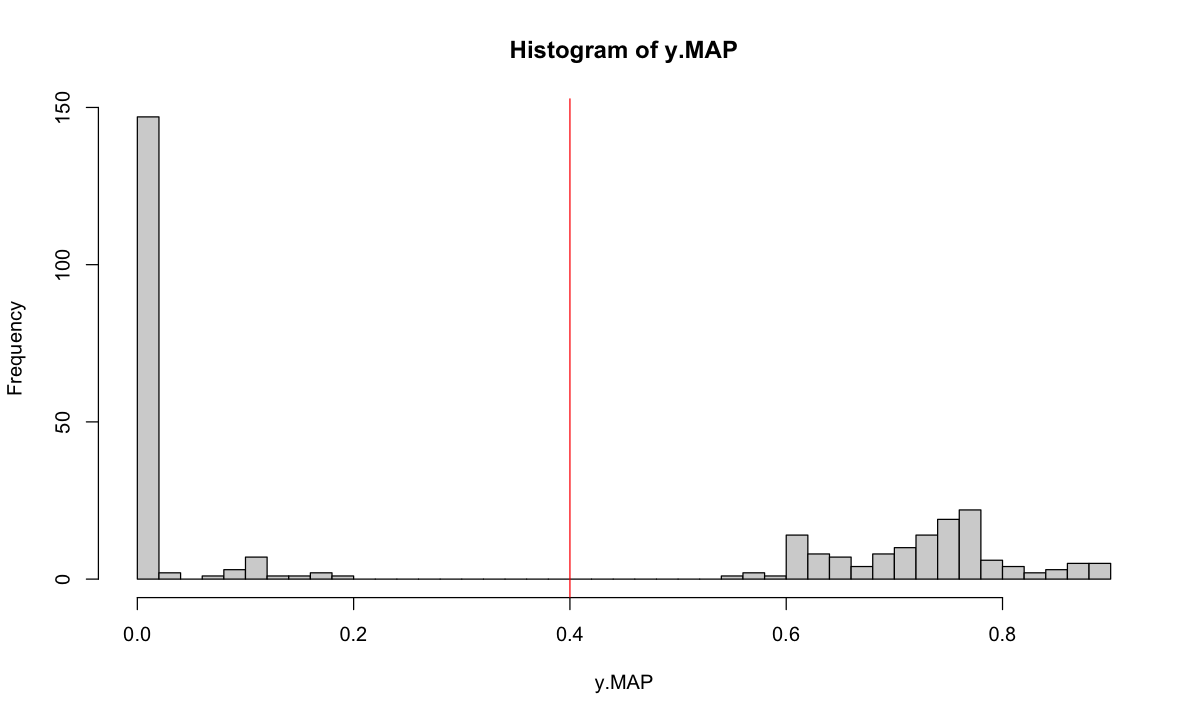

In [34]:
thres <- 0.4
hist(y.MAP, breaks=50)
abline(v=thres, col='red')

# Assign probability < 0.45 to class 0, and >= 0.45 to class 1
y_test_pred = ifelse(y.MAP < thres, 0, 1)

# Compute accuracy based on this threshold
print(paste('Accuracy with',thres,'threshold:',round(sum(y_test_pred == y_test)/length(y_test),4)))

It is however more informative to compute the AUC, for all possible decision thresholds:

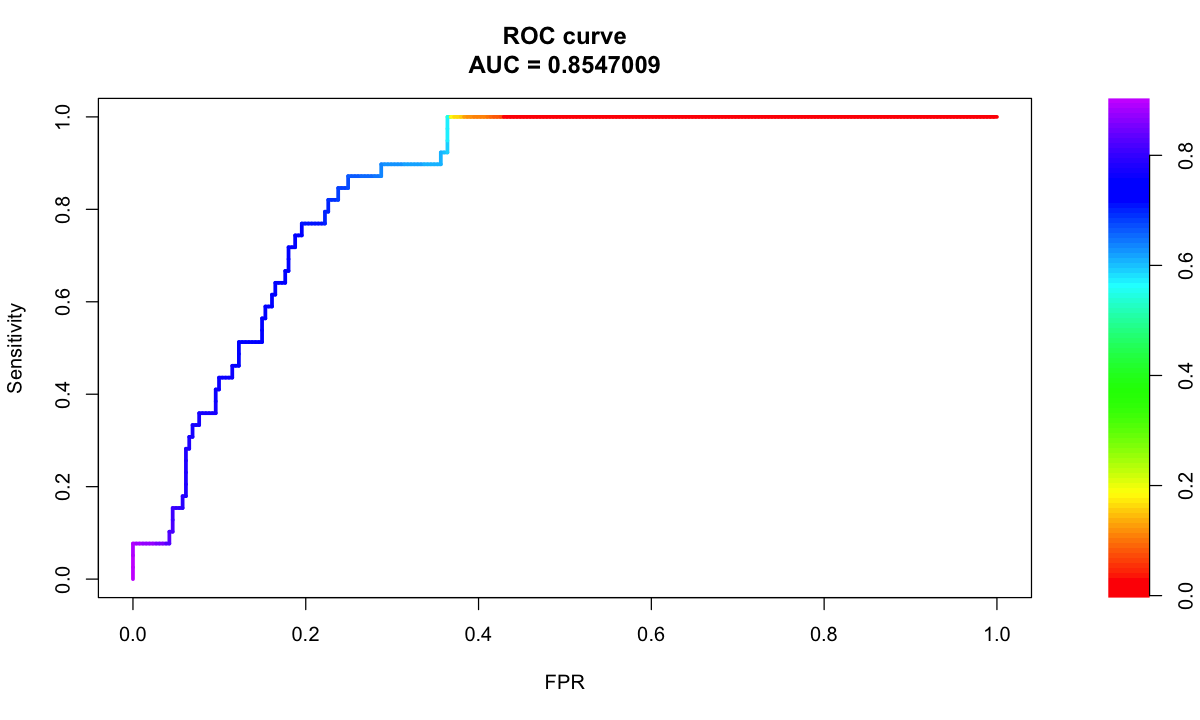

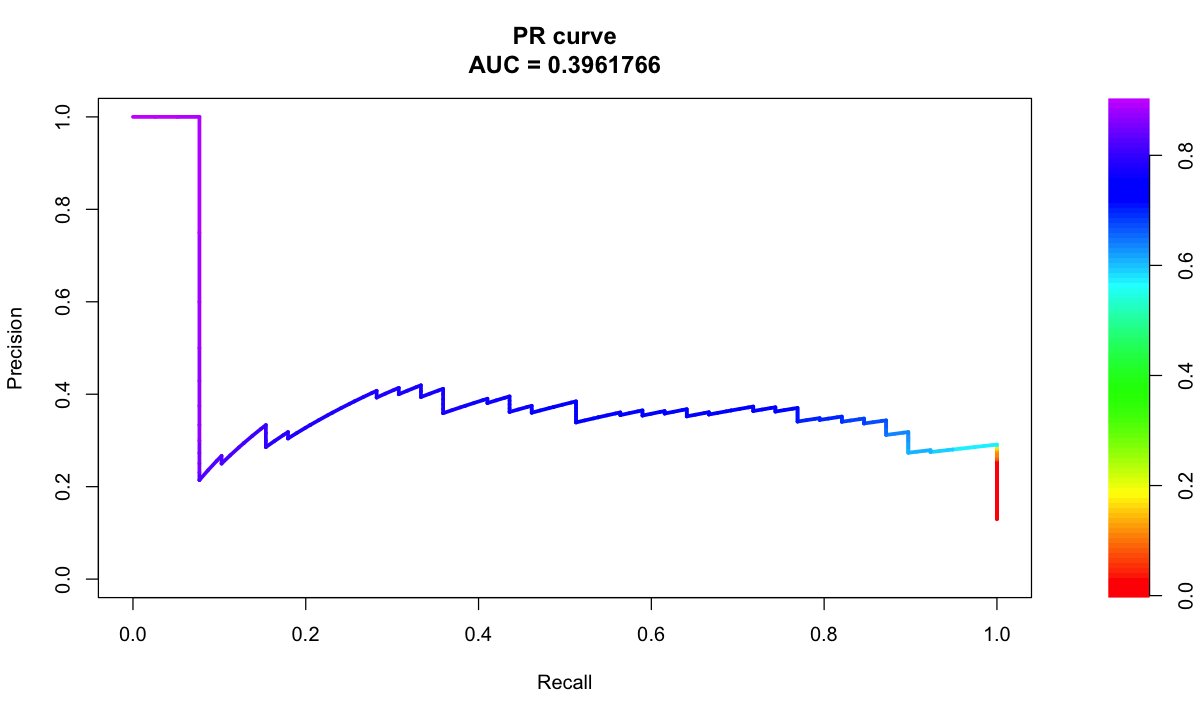

In [35]:
# Plot PROC and ROC curves based on the MAP probability of y=1
library(PRROC)

logit.stan.roc <- roc.curve(weights.class0=y_test, scores.class0=y.MAP, curve=TRUE)
plot(logit.stan.roc)

logit.stan.pr <- pr.curve(weights.class0=y_test, scores.class0=y.MAP, curve=TRUE)
plot(logit.stan.pr)

We have a similar performance as with the random forest, which is, however, only a little better than assigning all values to the majority class. Again, we observe this in the PR curve, that has an extremely low AUC.

### More complex models with bmrs

We would like to include more complex models, allowing for quadratic terms and interactions. At the same time, if we introduce all these variables we need some kind of regularization, so we would like to use some Bayseian shrinkage strategy such as the Bayesian Lasso or the Bayesian Horsehoe shirnkage, that we have seen that is the strategy that induces the sharpest coefficient posterior distribution. To do this, we will use the wraparound for `Stan`,  `bmrs`, with which the implementation of these models will be easier.

We will add quadratic terms for all the numeric variables (not the categorical ones, because quadratic terms for binary variables do not make sense) and some interaction terms. We will use bayesian LASSO to regularize this model and try to omit the irrelevant variables by inducing close to 0 coefficients. We have also tried to do this using horsehoe shirnkage but had convergence errors.

In [41]:
require(brms)

Loading required package: brms

Loading required package: Rcpp

Loading 'brms' package (version 2.15.0). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').


Attaching package: ‘brms’


The following object is masked from ‘package:rstan’:

    loo


The following object is masked from ‘package:stats’:

    ar




In [36]:
# Subsample dataset
# We will not use a very big dataset because this is exploratory
max_size <- min(table(data$Response))
n <- max_size*0.02
df <- resample(data,n)
n <- nrow(df) # Number of samples
p <- ncol(df) - 1 # Number of predictors (we also have response in df)
print(n)
print(p)

# Take some samples for testing (all samples with the same probability, i.e. no balancing)
n_test <- 300
samples_test <- sample(1:nrow(test), size=n_test)
df_test = test[samples_test,-ncol(test)]
y_test = test[samples_test,'Response']

[1] 2504
[1] 8


Using this model, we have been able to slightly increase both the ROC and the PRC AUC, using a much smaller dataset, but the same training set as before.
The quadratic term of age seems to have a moderatly high effect, and so do many of the interaction terms, specially `Driving_License:Previously_Insured`, which is the interaction among the two terms that have been shown to be most important for the model. We observe that the Bayesian LASSO does help, in this case, to bring some of the coefficients close to 0. We see some realatively sharp posterior distributions for some of the coefficients that do not have a large effect.

In [42]:
# Fit the model
formula <- paste0('Response~',paste(colnames(df)[-ncol(df)],collapse='+'),'+',paste(paste0('I(',colnames(df)[Num.vars],'^2)'),collapse='+'),
                  '+ Driving_License:Age + Vehicle_Age:Driving_License + Previously_Insured:Driving_License + Vehicle_Age:Gender')
logit.brms.model <- brm(as.formula(formula),data=df,family=bernoulli, 
    prior = c(set_prior(lasso(df = 1, scale = 10),class="b")),
    chains = 3, iter = 2500, warmup = 500, thin = 2)

Compiling Stan program...

Start sampling



In [44]:
# Check convergence and coefficients posteriors
summary(logit.brms.model)  

 Family: bernoulli 
  Links: mu = logit 
Formula: Response ~ Gender + Age + Driving_License + Previously_Insured + Vehicle_Age + Vehicle_Damage + Annual_Premium + Vintage + I(Age^2) + I(Annual_Premium^2) + I(Vintage^2) + Driving_License:Age + Vehicle_Age:Driving_License + Previously_Insured:Driving_License + Vehicle_Age:Gender 
   Data: df (Number of observations: 2504) 
Samples: 3 chains, each with iter = 2500; warmup = 500; thin = 2;
         total post-warmup samples = 3000

Population-Level Effects: 
                                   Estimate Est.Error l-95% CI u-95% CI Rhat
Intercept                             -1.67      1.11    -4.18     0.43 1.00
Gender                                 0.49      0.19     0.12     0.87 1.00
Age                                    0.15      0.60    -1.24     1.30 1.00
Driving_License                        0.15      1.06    -1.85     2.59 1.00
Previously_Insured                    -2.25      1.41    -4.81     0.22 1.00
Vehicle_Age                 

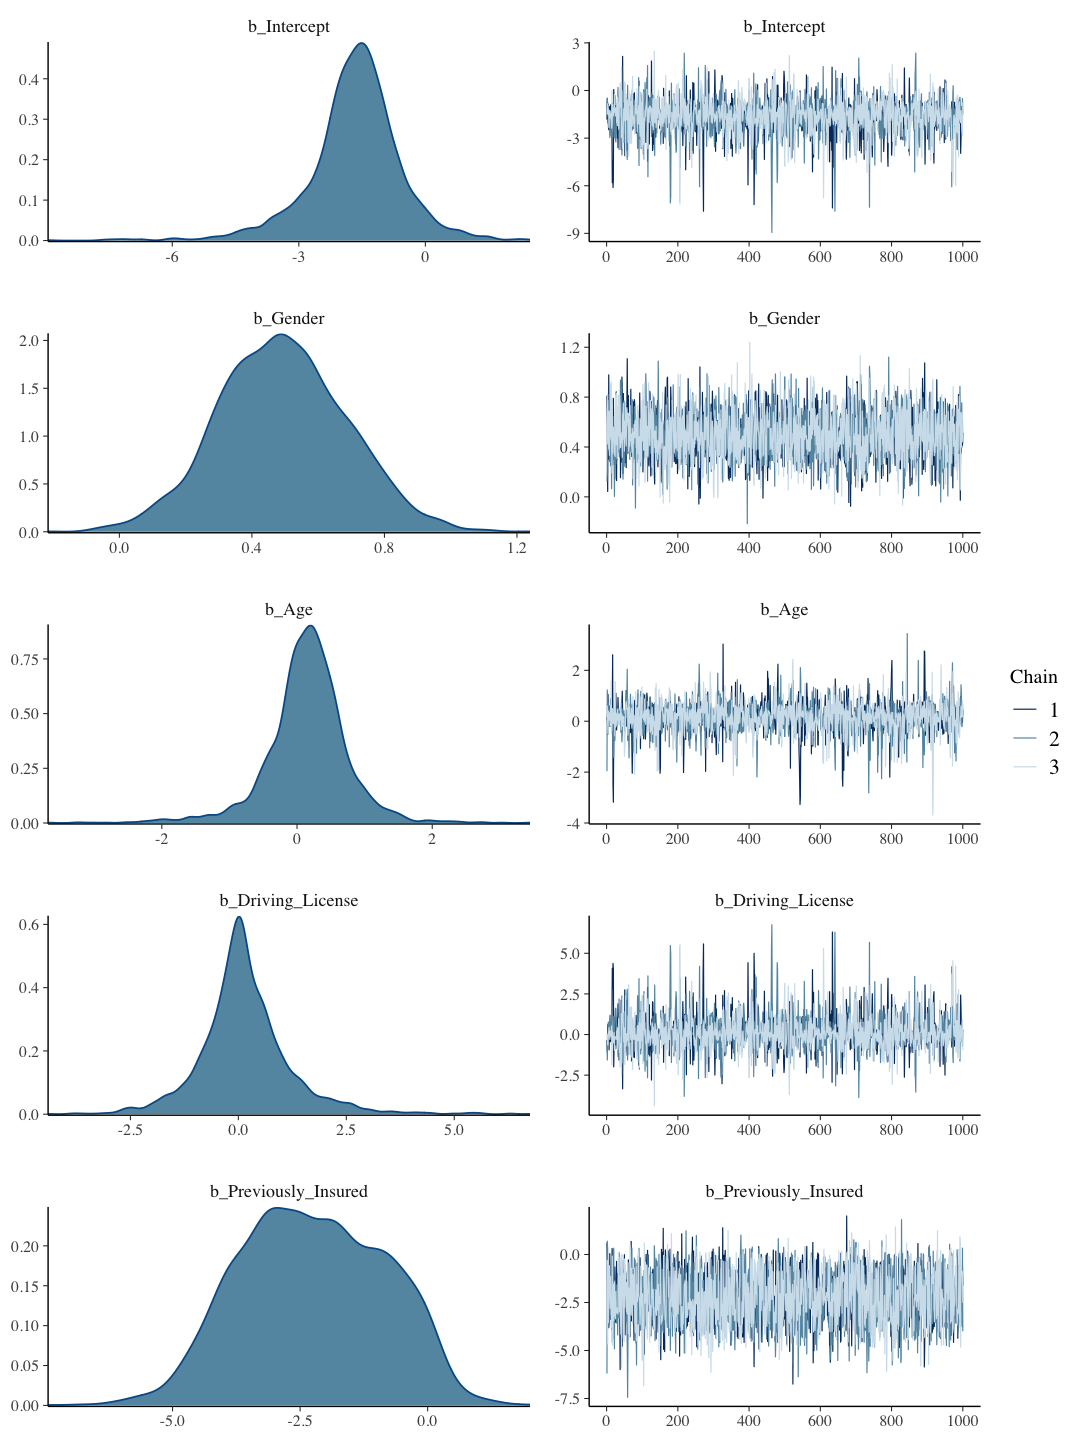

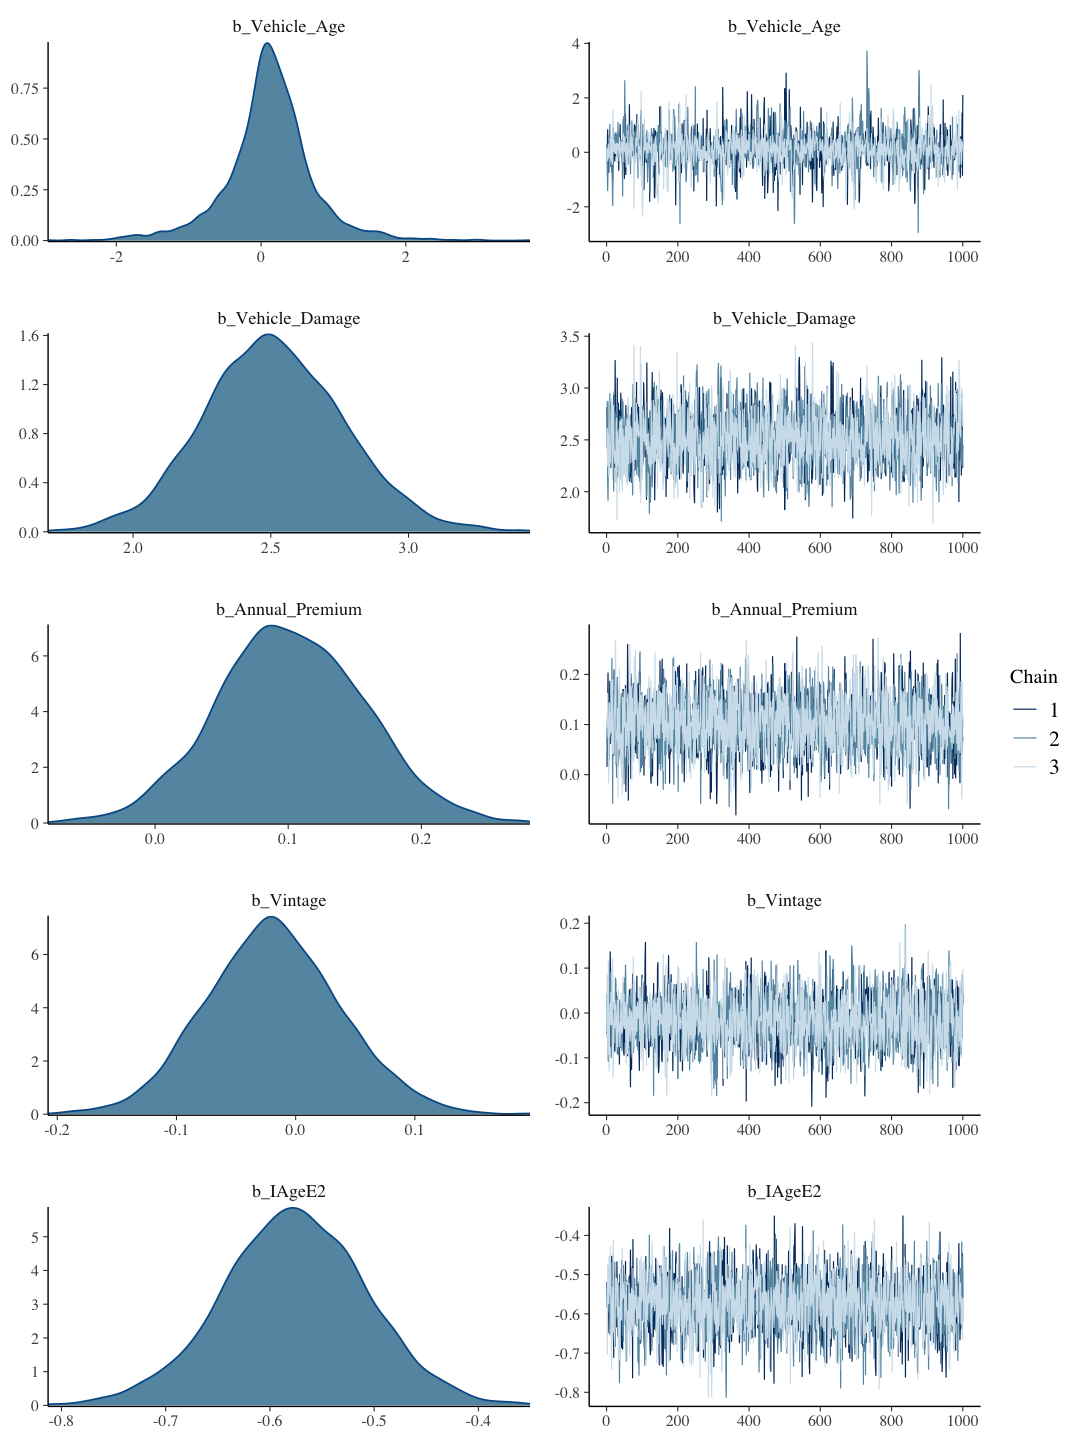

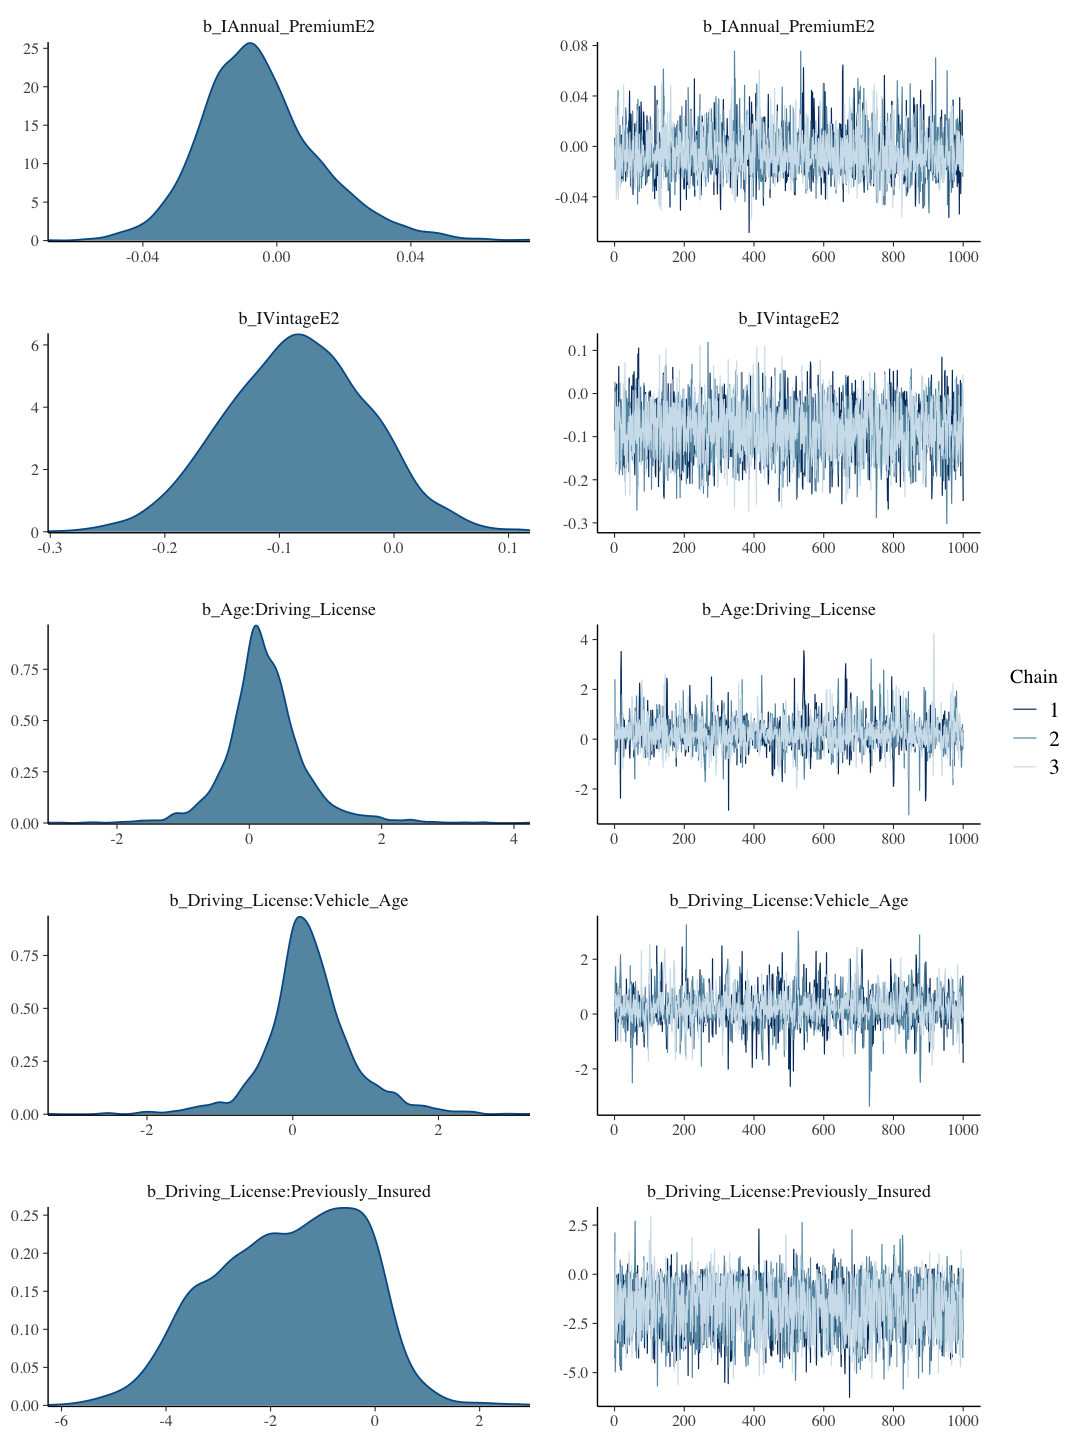

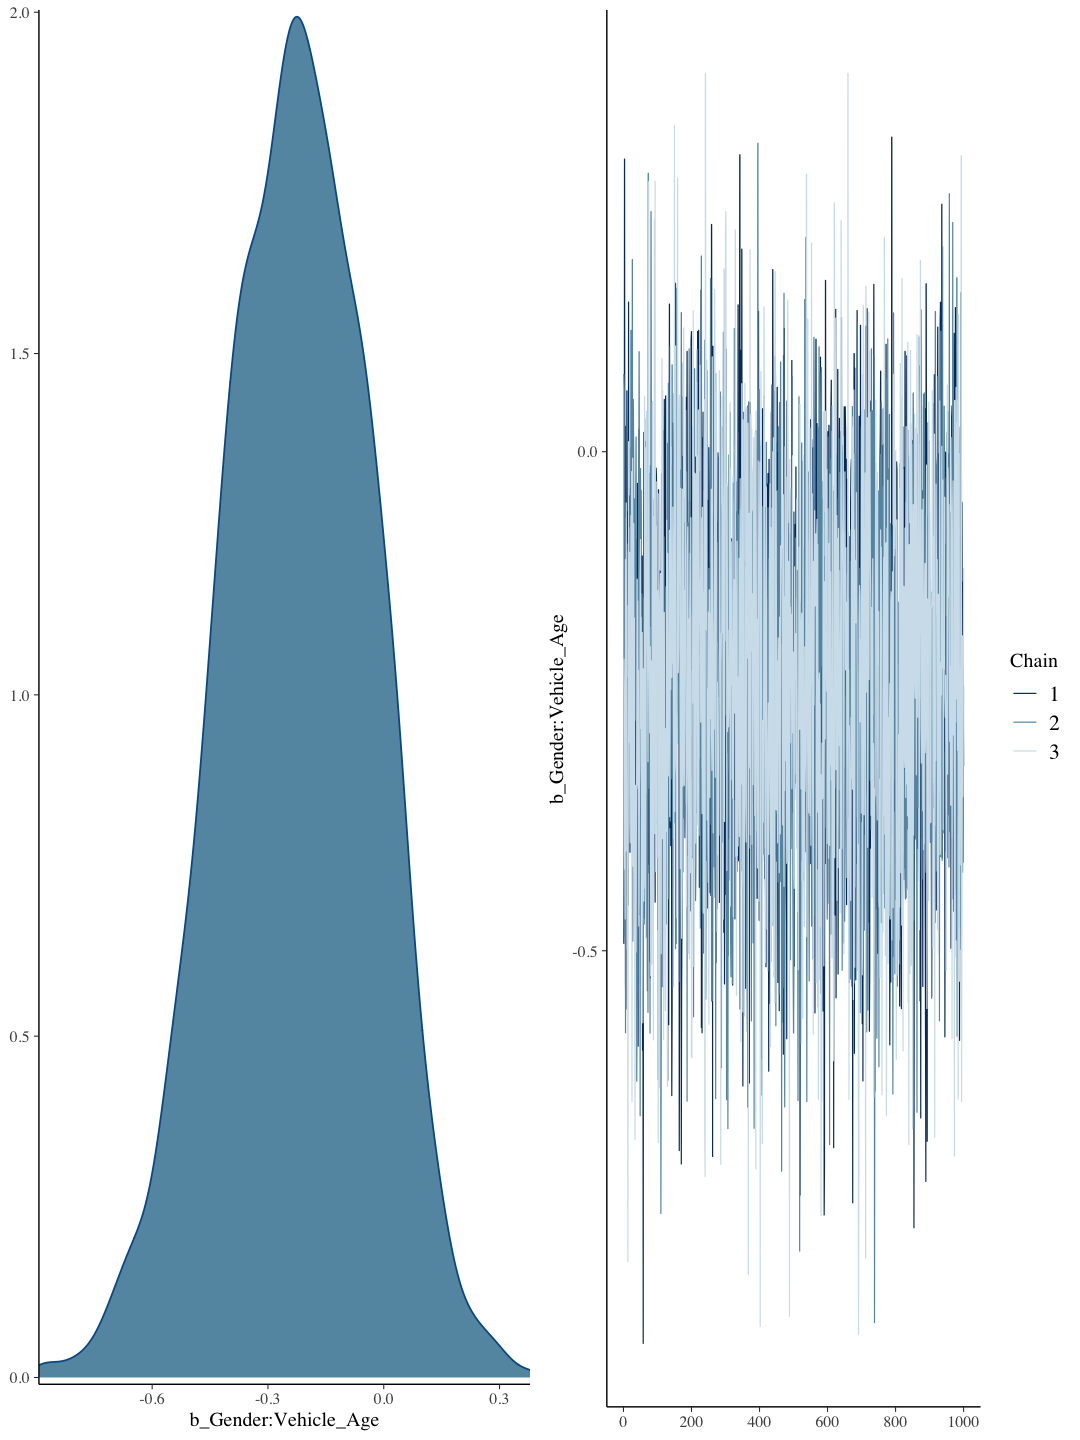

In [45]:
options(repr.plot.width=9,repr.plot.height=12)
plot(logit.brms.model)

In [53]:
# Predict y_test
y_pred <- predict(logit.brms.model, newdata=df_test)
y_pred[1:5,]

Estimate    Est.Error  Q2.5 Q97.5
[1,] 0.002666667 0.05157948 0    0    
[2,] 0.003666667 0.06045197 0    0    
[3,] 0.002000000 0.04468406 0    0    
[4,] 0.681666667 0.46590726 0    1    
[5,] 0.004000000 0.06312946 0    0

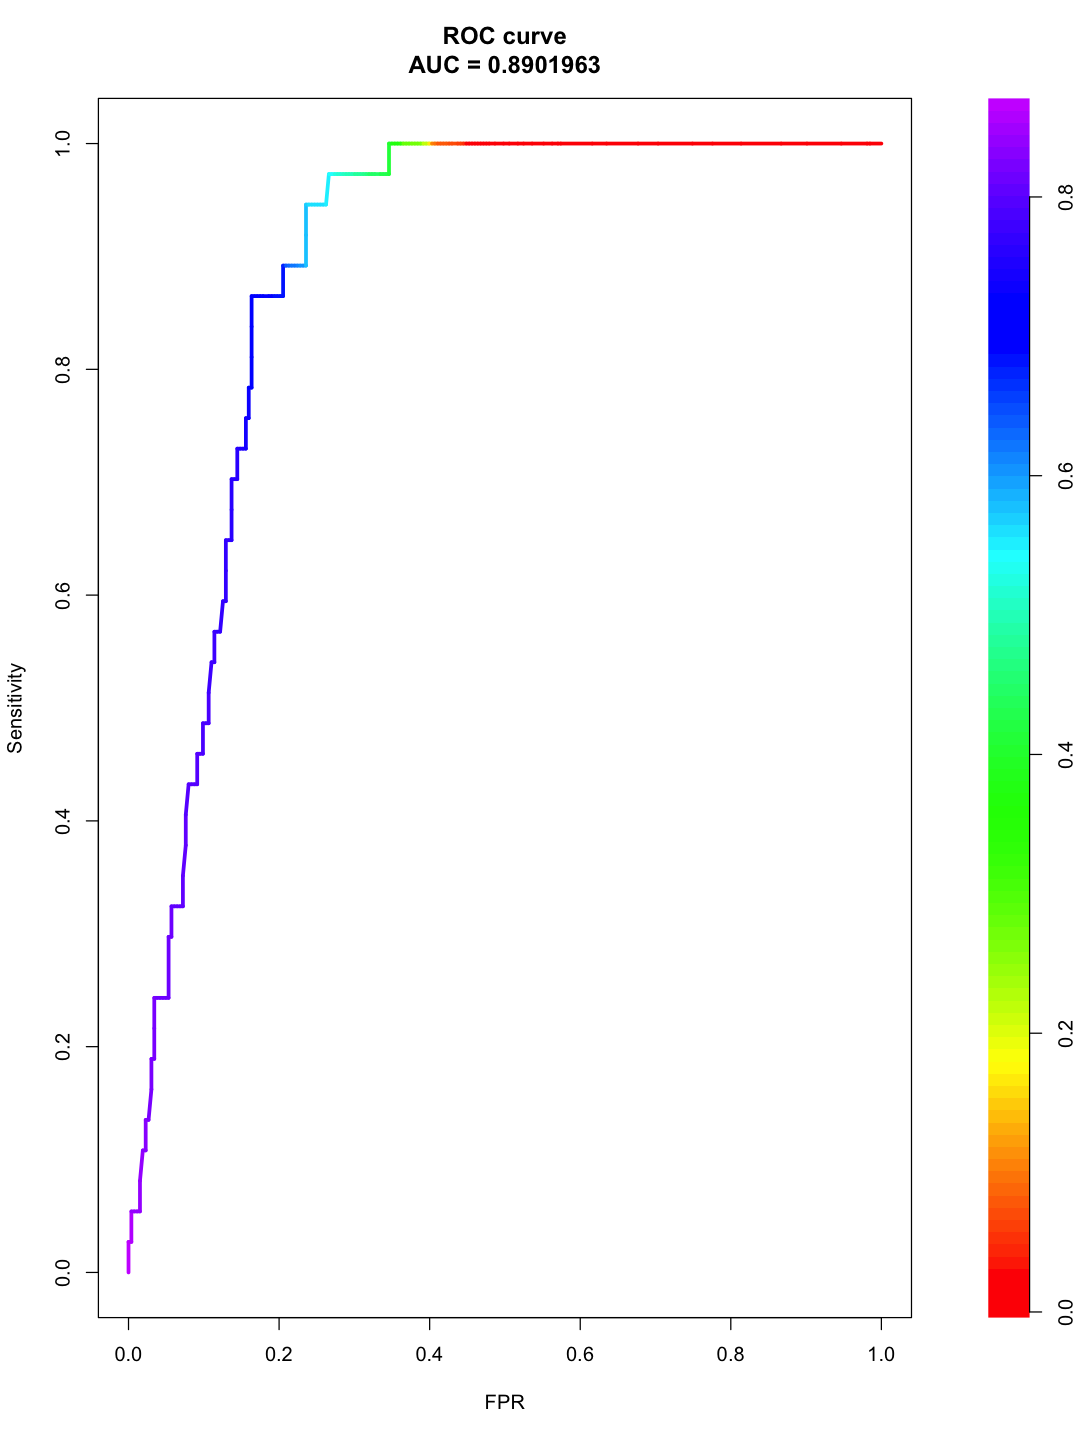

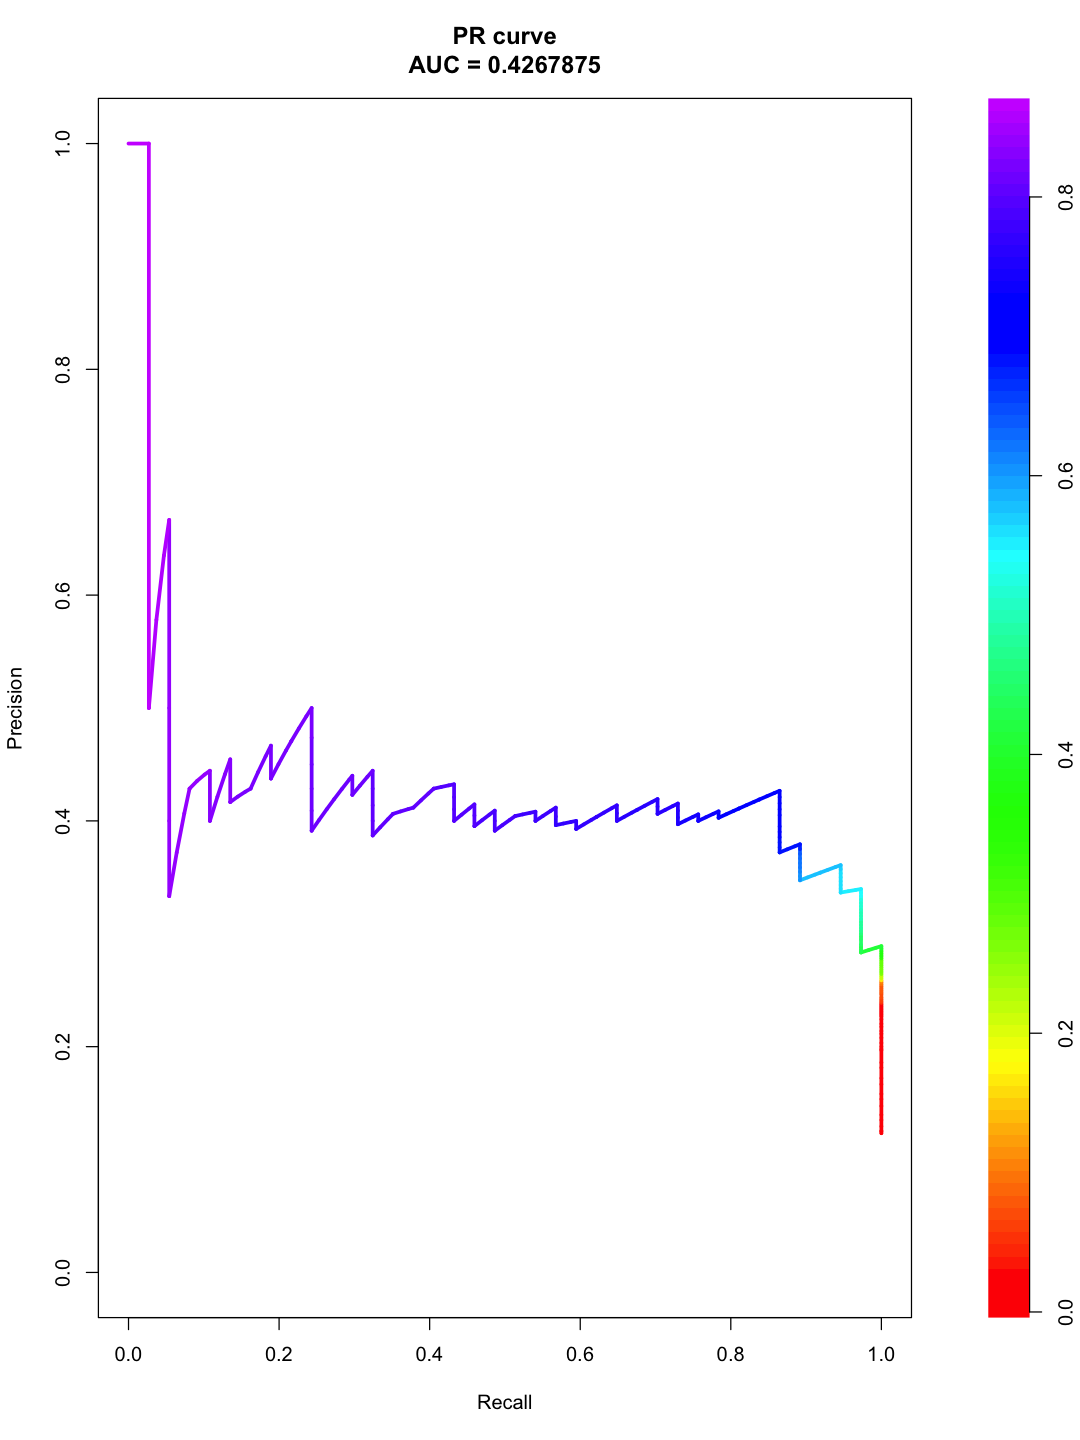

In [54]:
# Plot PROC and ROC curves
library(PRROC)

logit.lasso.roc <- roc.curve(weights.class0=y_test, scores.class0=y_pred[,'Estimate'], curve=TRUE)
plot(logit.lasso.roc)

logit.lasso.pr <- pr.curve(weights.class0=y_test, scores.class0=y_pred[,'Estimate'], curve=TRUE)
plot(logit.lasso.pr)

## Rstanarm

In [14]:
df <- resample(data,700)
dim(df)
table(df$Response)
dfCombined <- as.list(df[, c('Gender','Age','Driving_License','Previously_Insured','Vehicle_Age','Vehicle_Damage',
                             'Annual_Premium','Vintage','Response')])
dfCombined$nrows <- nrow(df)

[1] 1400    9


  0   1 
700 700 

In [ ]:
library("rstanarm")
options(mc.cores = parallel::detectCores())

In [46]:
#When using multicores, we cannot see each iteration of each chain and its warmup/sampling versions.

rstanarm_model <- stan_glm(Response ~ Gender + Age + Driving_License + Previously_Insured + 
                         Vehicle_Age + Vehicle_Damage + Annual_Premium + Vintage,
                        data = df, family = binomial(link = "logit"),
                        prior = normal(0, 3),
                        prior_intercept = normal(0, 3),
                        chains = 4, 
                        iter = 2000,
                        seed = 123)

### Convergence & Chain analysis

Let's look at this model convergence performance.

[According to their official documentation](https://mc-stan.org/rstanarm/articles/rstanarm.html#markov-chains-did-not-converge), if the convergence criteria isn't met we will get a warning saying ``markov chains did not converge. Do not analyze results!``. Nevertheless, a good way to evaluate convergence is checking the Rhat metric. The Rhat statistic measures the ratio of the average variance of the draws within each chain to the variance of the pooled draws across chains; if all chains are at equilibrium, these will be the same and Rhat will be one. If the chains have not converged to a common distribution, the Rhat statistic will tend to be greater than one.

We can see that none of the rhat metric is bigger than 1.1 for each variable:

In [47]:
rhat <- summary(rstanarm_model)[, "Rhat"]
as.data.frame(rhat)

rhat     
(Intercept)        1.0001436
Gender             0.9994968
Age                1.0003429
Driving_License    1.0000853
Previously_Insured 1.0021946
Vehicle_Age        1.0002119
Vehicle_Damage     0.9995116
Annual_Premium     1.0003802
Vintage            0.9996565
mean_PPD           1.0012011
log-posterior      1.0011023

#### Regression Coefficients

In [222]:
mcmcTab(rstanarm_model, Pr = TRUE)

Variable           Median SD    Lower   Upper  Pr   
1 (Intercept)        -7.806 2.194 -12.594 -4.068 1.000
2 Gender             -0.302 0.161  -0.619  0.013 0.970
3 Age                -0.566 0.108  -0.786 -0.359 1.000
4 Driving_License     2.200 2.036  -1.296  6.607 0.889
5 Previously_Insured -4.259 0.727  -5.958 -3.064 1.000
6 Vehicle_Age         1.516 0.213   1.104  1.946 1.000
7 Vehicle_Damage      2.216 0.353   1.565  2.941 1.000
8 Annual_Premium      0.041 0.075  -0.105  0.187 0.704
9 Vintage             0.042 0.077  -0.108  0.195 0.711

### Predicted Probabilities

Meaning the relationships between coviariates and our target variable of interest: Response. Let's start by building a matrix of the posterior coefficients:

In [50]:
matrix_rstanarm <- as.matrix(rstanarm_model)

And now, let's build the regression coefficients matrix. The first column is a vector with all of its values set to 1, also called "intercept":

In [51]:
mm.rstanarm <- model.matrix(Response ~ Gender + Age + Driving_License + Previously_Insured + 
                         Vehicle_Age + Vehicle_Damage + Annual_Premium + Vintage,
                   data = df)

In the Stan model we've seen the predicted probability for the binary variable Vehicle_Age. Now, we are gonna perform the same plot for continous variables, thanks to the parameter ``fullsims`` set to False.

We are gonna check the predicted probabilty distribution of the variable Age:

In [52]:
aveprob.Age.rstanarm <- mcmcAveProb(modelmatrix = mm.rstanarm,
            mcmcout = matrix_rstanarm[, 1:ncol(mm.rstanarm)],
            xcol =  2,
            xrange = seq(min(df$Age), max(df$Age), length.out = 20),
            link = "logit",
            ci = c(0.025, 0.975),
            fullsims = FALSE)

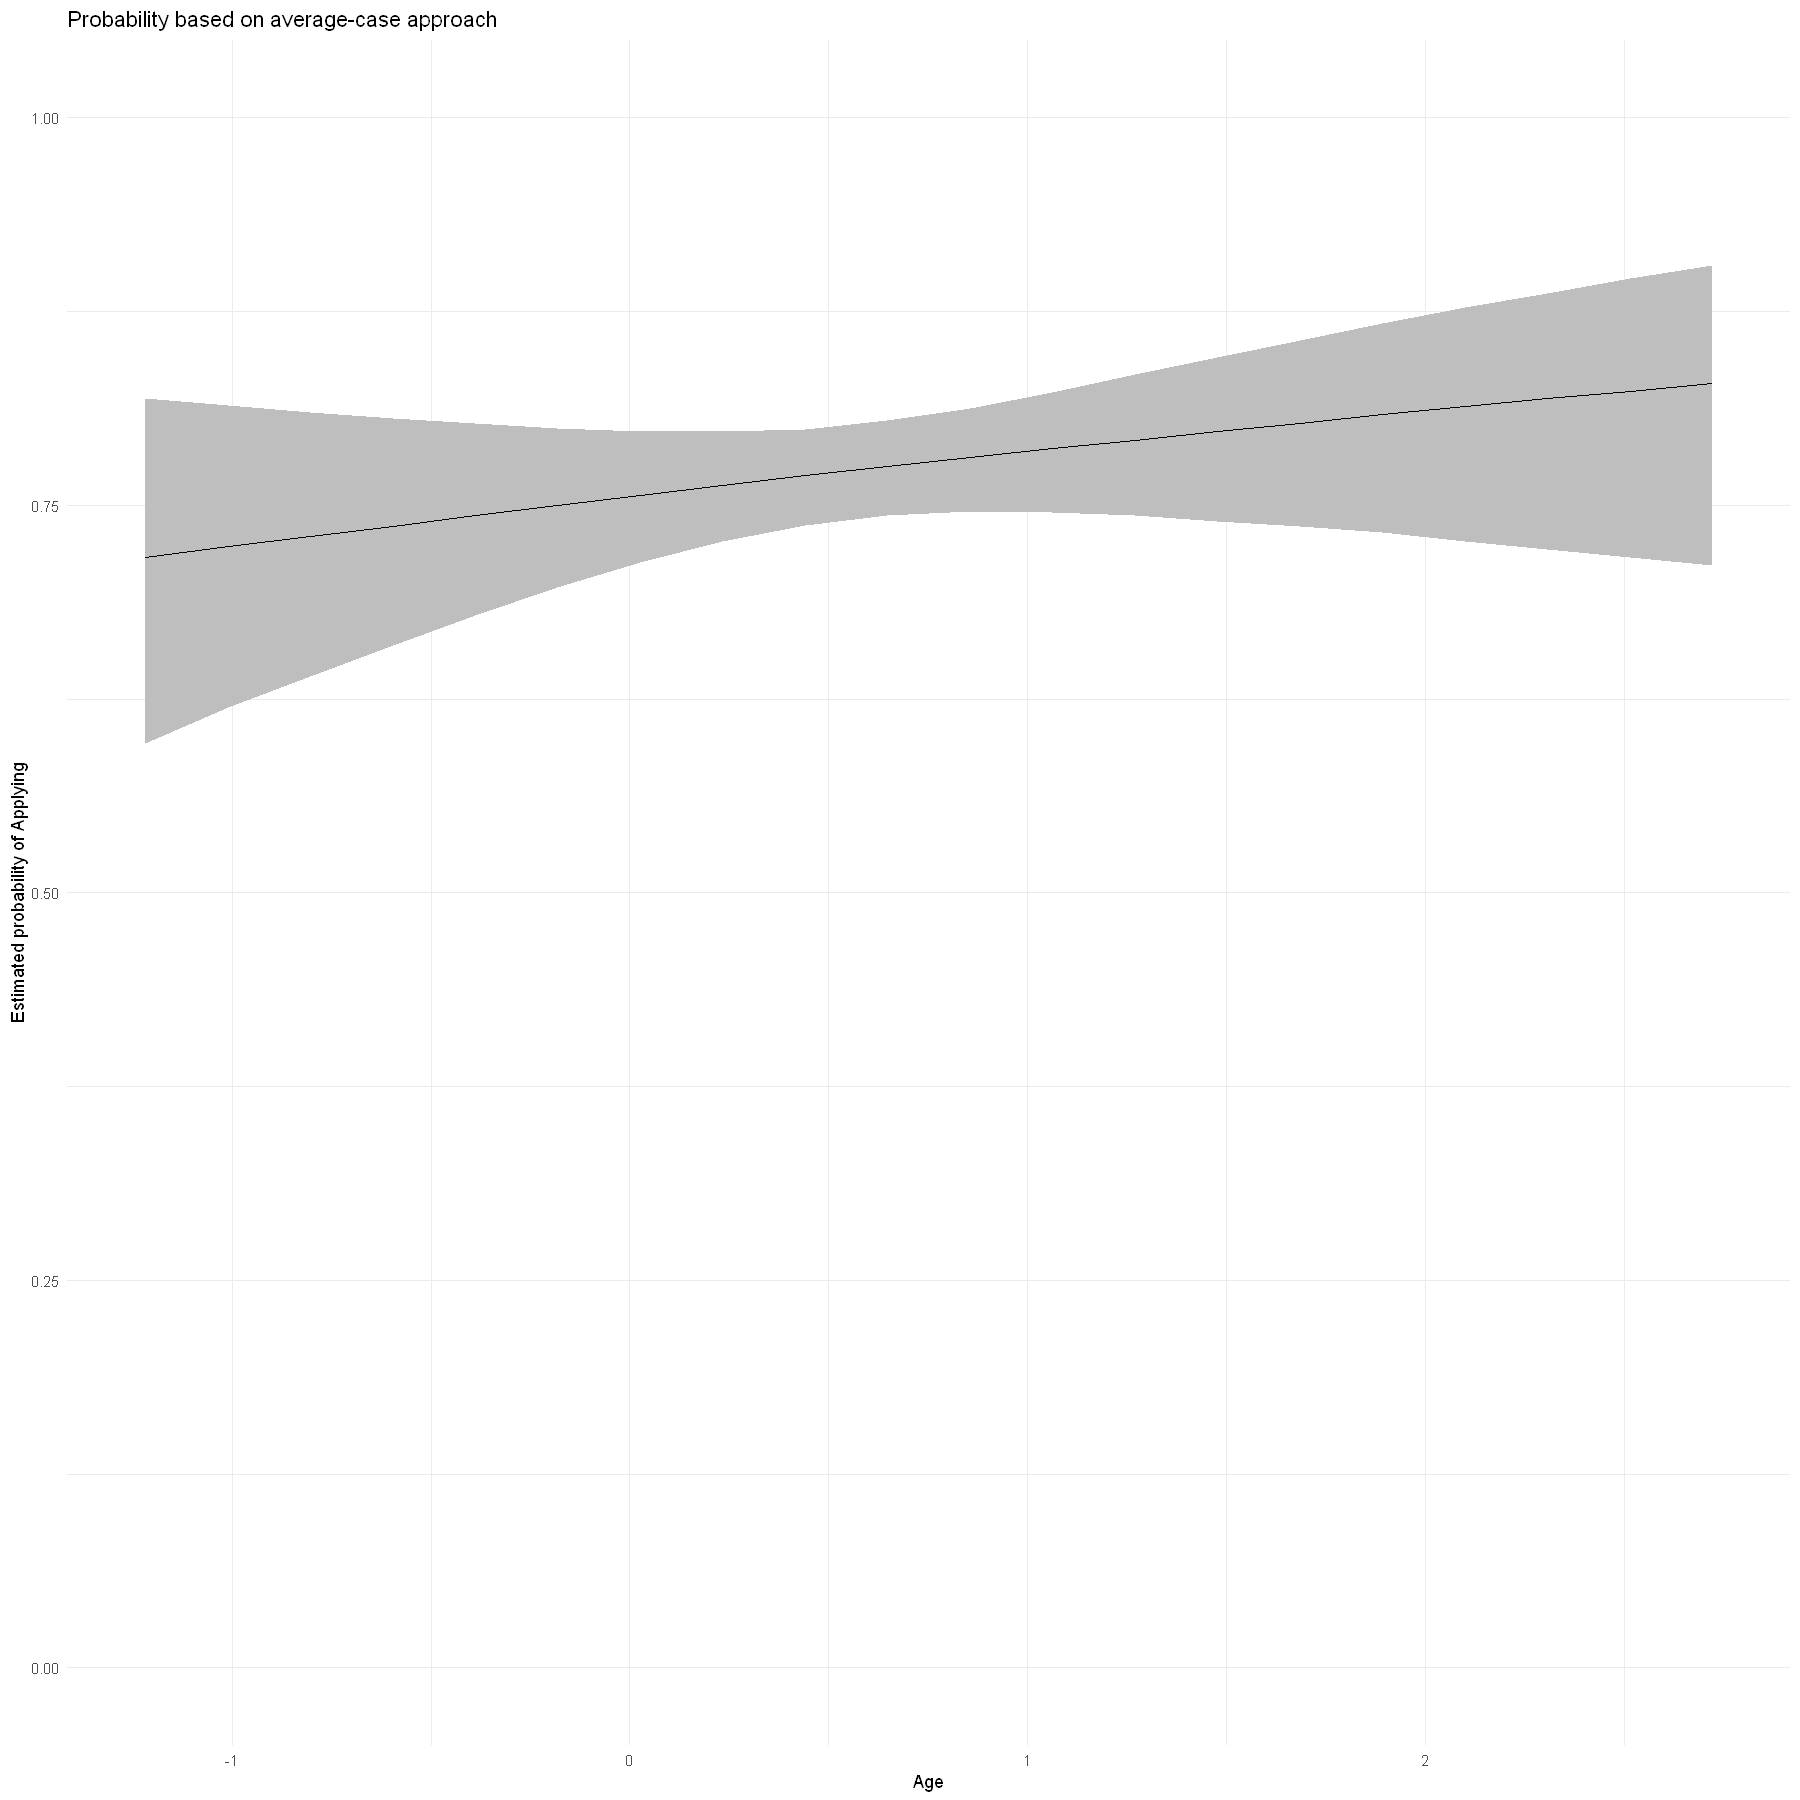

In [53]:
ggplot(data = aveprob.Age.rstanarm, 
       aes(x = x, y = median_pp)) + 
  geom_ribbon(aes(ymin = lower_pp, ymax = upper_pp), fill = "gray") + 
  geom_line() + 
  xlab("Age") + 
  ylab("Estimated probability of Applying") + 
  ylim(0, 1) + 
  labs(title = "Probability based on average-case approach") +
  theme_minimal()

This plot allows us to see the probability of applying to this insurance alongisde the full distribution of our Age variable. It seems that young people are slightly less probable of applying.

With this model is interesting looking at the distribution of the binary variable Vehicle_Damage. As we can see, individuals which his car suffered any kind of damage (coded from ``Yes`` to ``1``) are more probable to apply for the insurance

Picking joint bandwidth of 0.00591



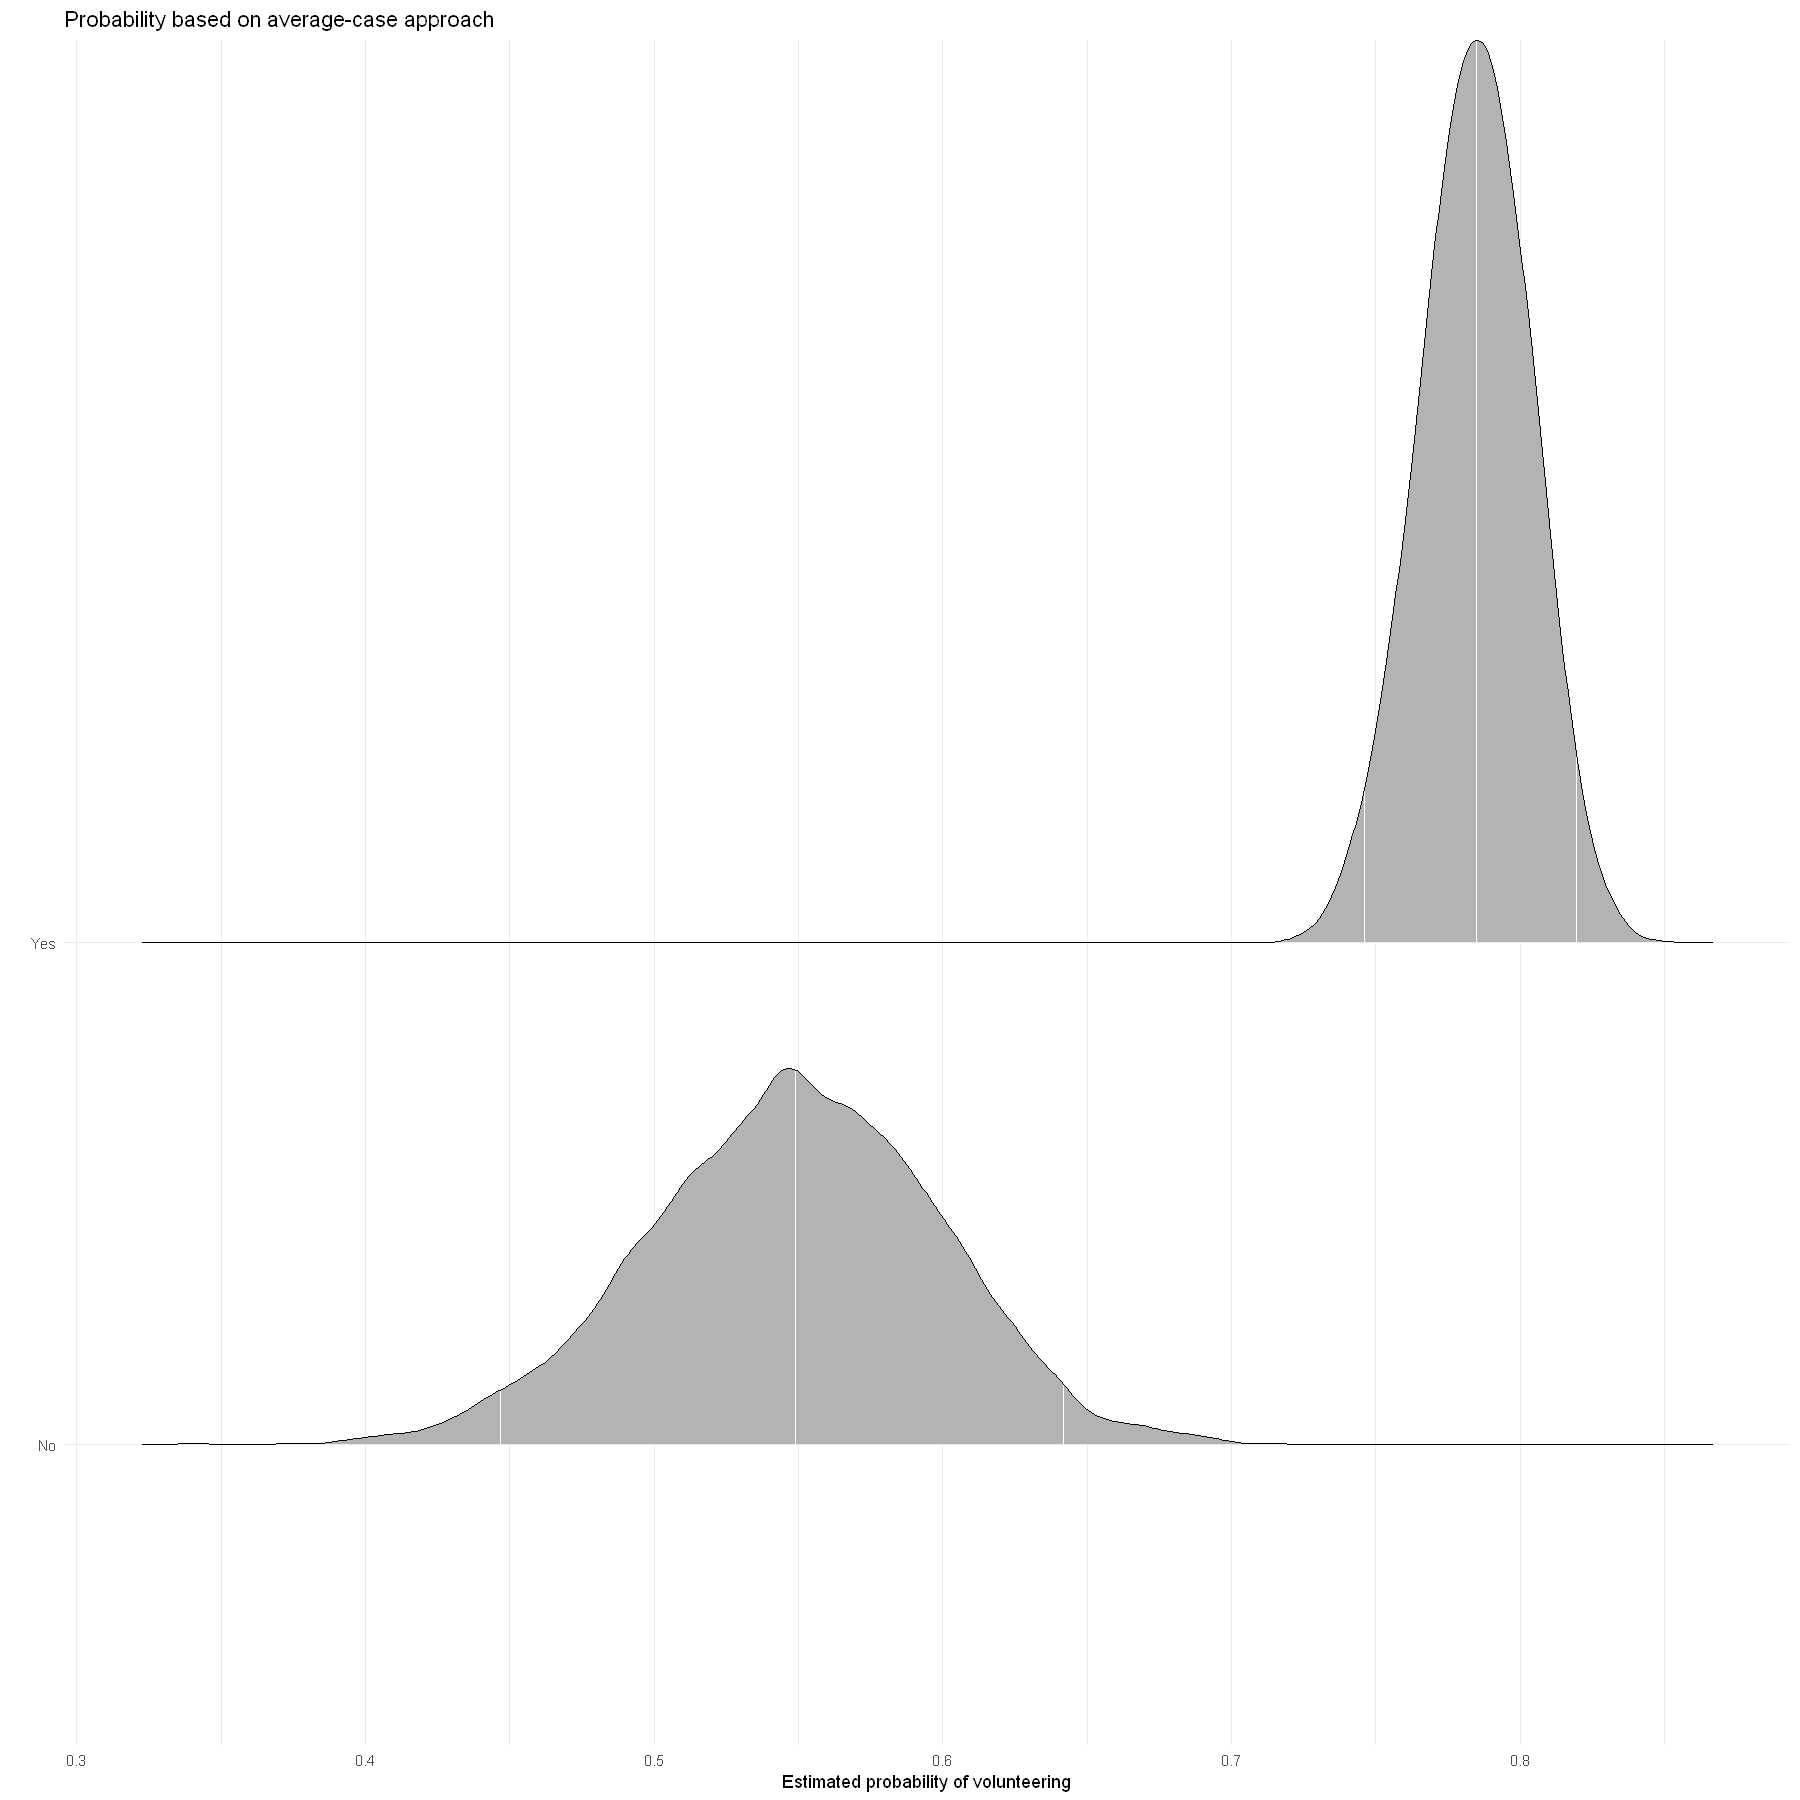

In [56]:
aveprob.Vehicle_Damage.rstanarm <- mcmcAveProb(modelmatrix = mm.rstanarm,
            mcmcout = matrix_rstanarm[, 1:ncol(mm.rstanarm)],
            xcol = 6,
            xrange = c(0, 1),
            link = "logit",
            ci = c(0.025, 0.975),
            fullsims = TRUE)

library("ggplot2")
library("ggridges")
ggplot(data = aveprob.Vehicle_Damage.rstanarm, 
       aes(y = factor(x), x = pp)) + 
  stat_density_ridges(quantile_lines = TRUE, 
                quantiles = c(0.025, 0.5, 0.975), vline_color = "white") + 
  scale_y_discrete(labels = c("No", "Yes")) + 
  ylab("") + 
  xlab("Estimated probability of volunteering") + 
  labs(title = "Probability based on average-case approach") +
  theme_minimal()

#### First differences

First differences are a method to summarize effects across covariates. This quantity represents the difference in predicted probabilities for each covariate for cases with low and high values of the respective covariate. For each of these differences, all other variables are held constant at their median.

The ``mcmcFD`` function allows to get this table of median and credible intervals of the summary of this first differences.

In [245]:
first_difference.rstanarm <- mcmcFD(modelmatrix = mm.rstanarm,
                  mcmcout = matrix_rstanarm[, 1:ncol(mm.rstanarm)],
                  link = "logit",
                  ci = c(0.025, 0.975),
                  fullsims = FALSE)

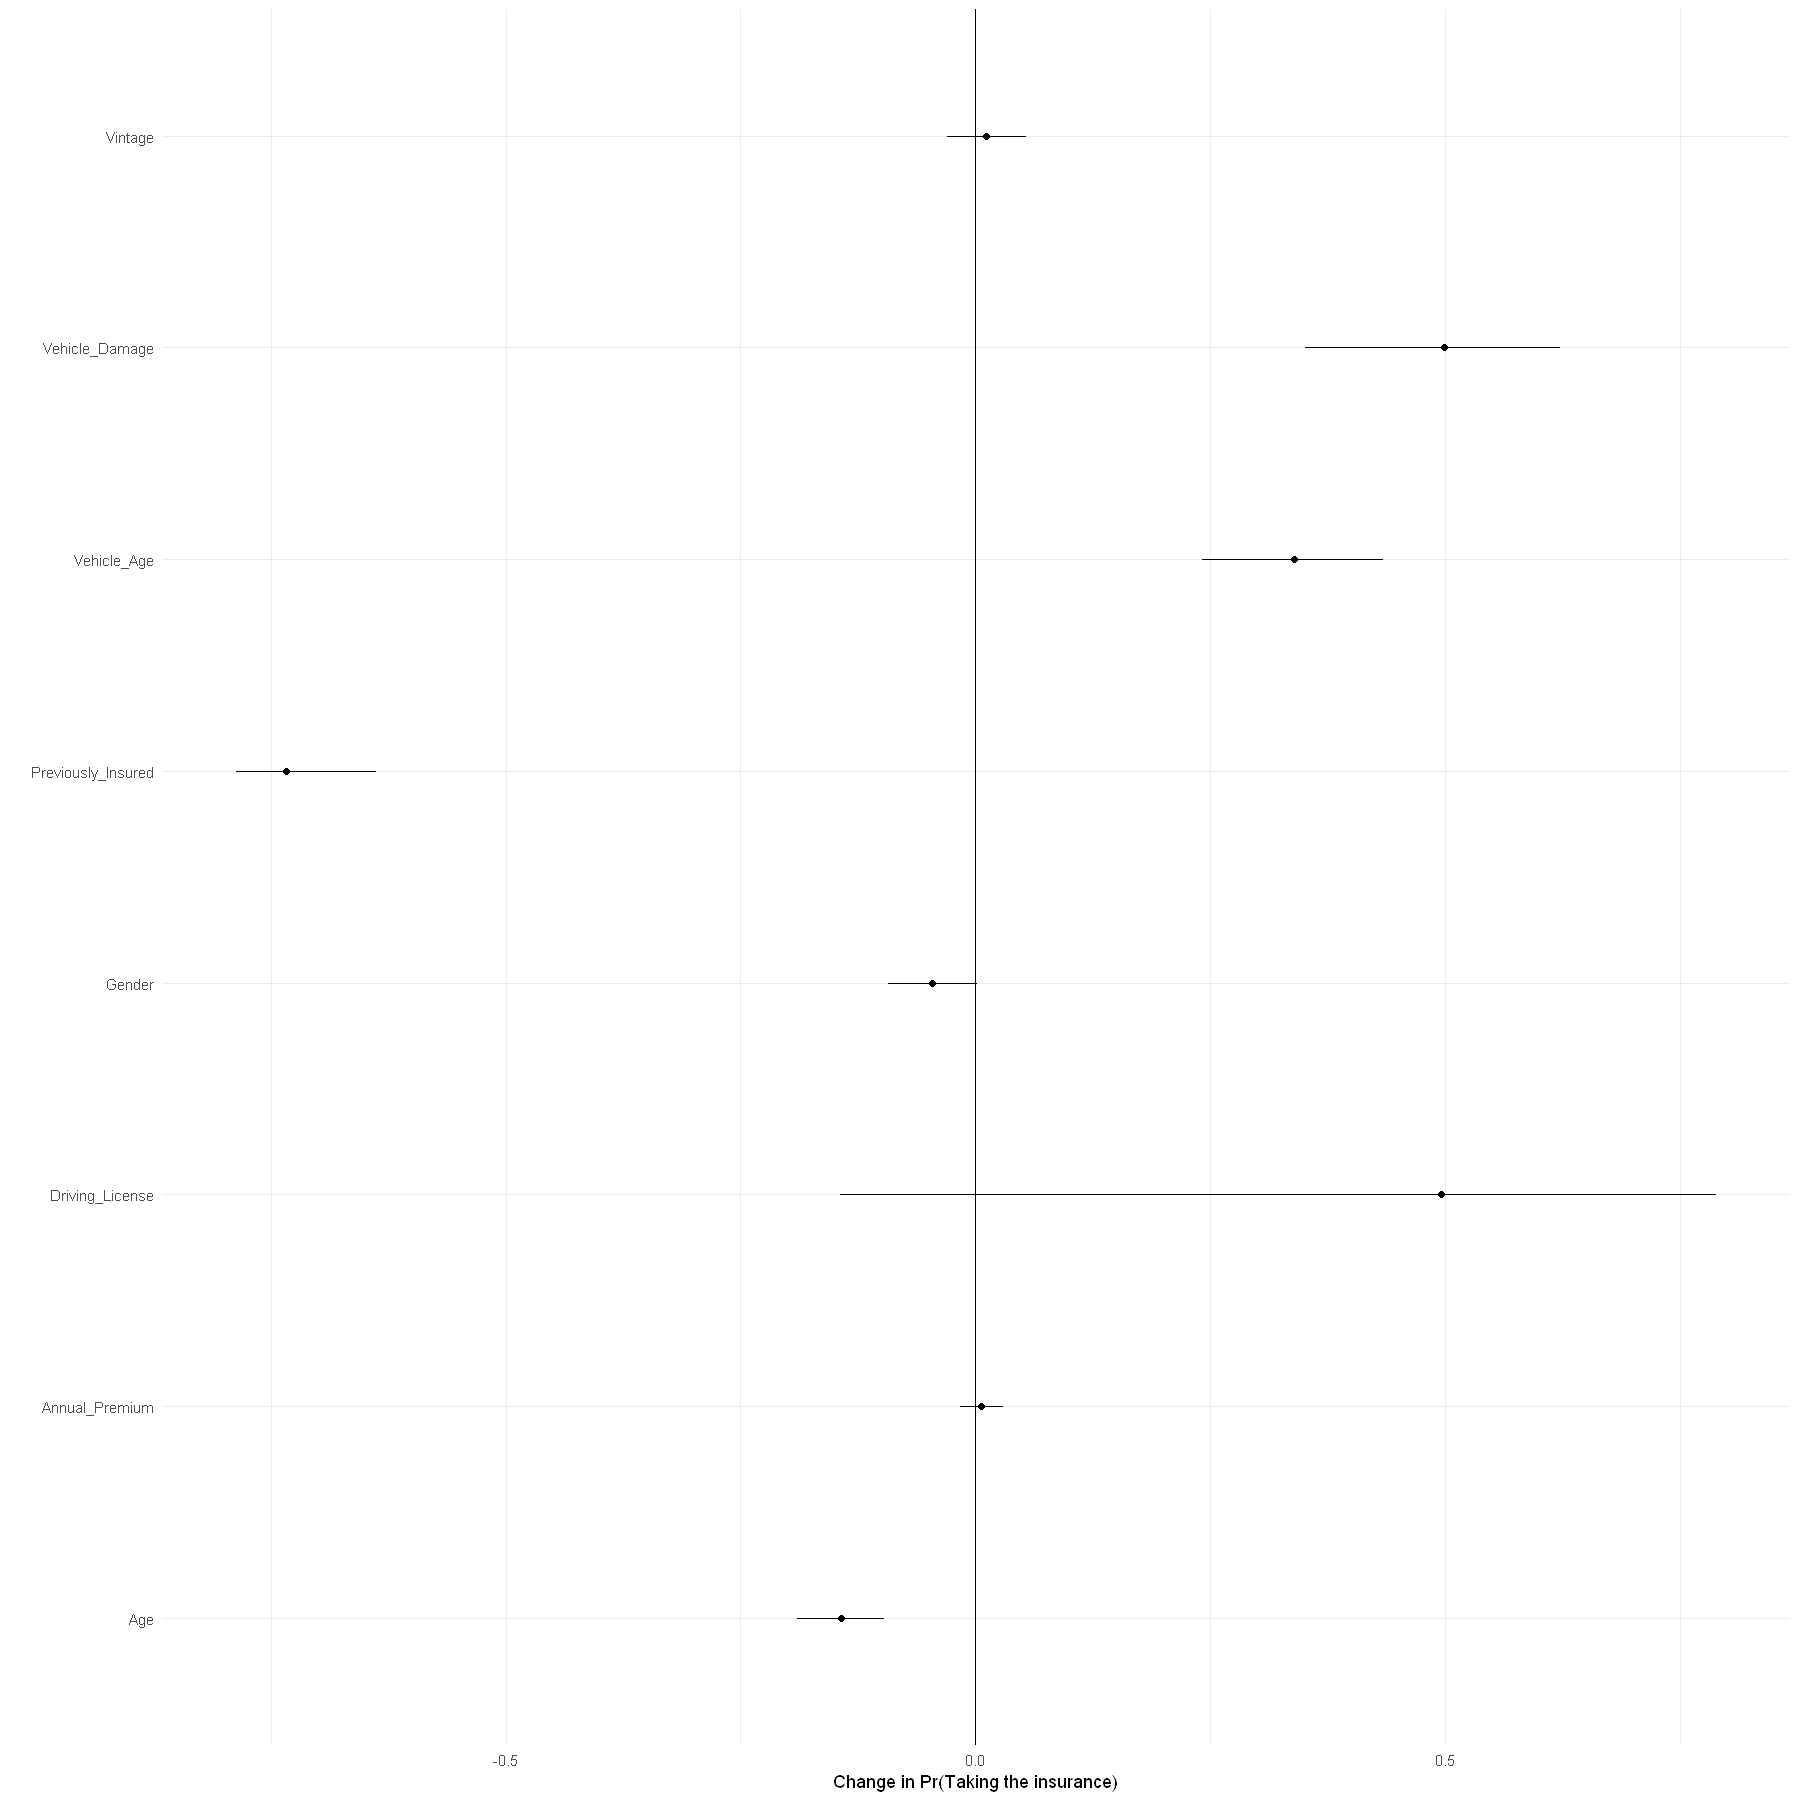

In [246]:
ggplot(data = first_difference.rstanarm, 
       aes(x = median_fd, y = VarName)) + 
  geom_point() + 
  geom_segment(aes(x = lower_fd, xend = upper_fd, yend = VarName)) + 
  geom_vline(xintercept = 0) + 
  xlab("Change in Pr(Taking the insurance)") + 
  ylab("") +
  theme_minimal()

With this model, the plot of first differences is more usefull. We can see that the variables Age, Driving_License, Previously_Insured, Vehicle_Age and Vehicle_Damage affect the most the probability of taking the insurance. In the case of Predicted Probabilities and Age, we already prove it with their plots of Predicted Probabilities.

#### Area Under the ROC Curve

A well-known metric for model's accuracy is the Area Under the Receiver Operating Characteristic. It tells how much the model is capable of distinguishing between classes. Higher the AUC, the better the model is at predicting 0s as 0s and 1s as 1s. The ROC curve is plotted with TPR (True Positive Rate) against the FPR (False Positive Rate) where TPR is on the y-axis and FPR is on the x-axis. The function ``mcmcRocPrc`` allows us to compute this metric as well as the Area Under the Precision-Recall Curve (PRC):

In [247]:
accuracies.rstanarm <- mcmcRocPrc(object = rstanarm_model,
                       yname  = "Response",
                       xnames = c('Gender','Age','Driving_License','Previously_Insured','Vehicle_Age',
                                  'Vehicle_Damage','Annual_Premium','Vintage'),
                       curves = TRUE,
                       fullsims = FALSE)

Instead of posterior_linpred(..., transform=TRUE) please call posterior_epred(), which provides equivalent functionality.



We highly improved our ROC and PRC score from the Stan model!

In [248]:
accuracies.rstanarm$area_under_roc

V1 
0.887048

In [249]:
accuracies.rstanarm$area_under_prc

V1 
0.8350313

Warning message:
"Removed 1 row(s) containing missing values (geom_path)."


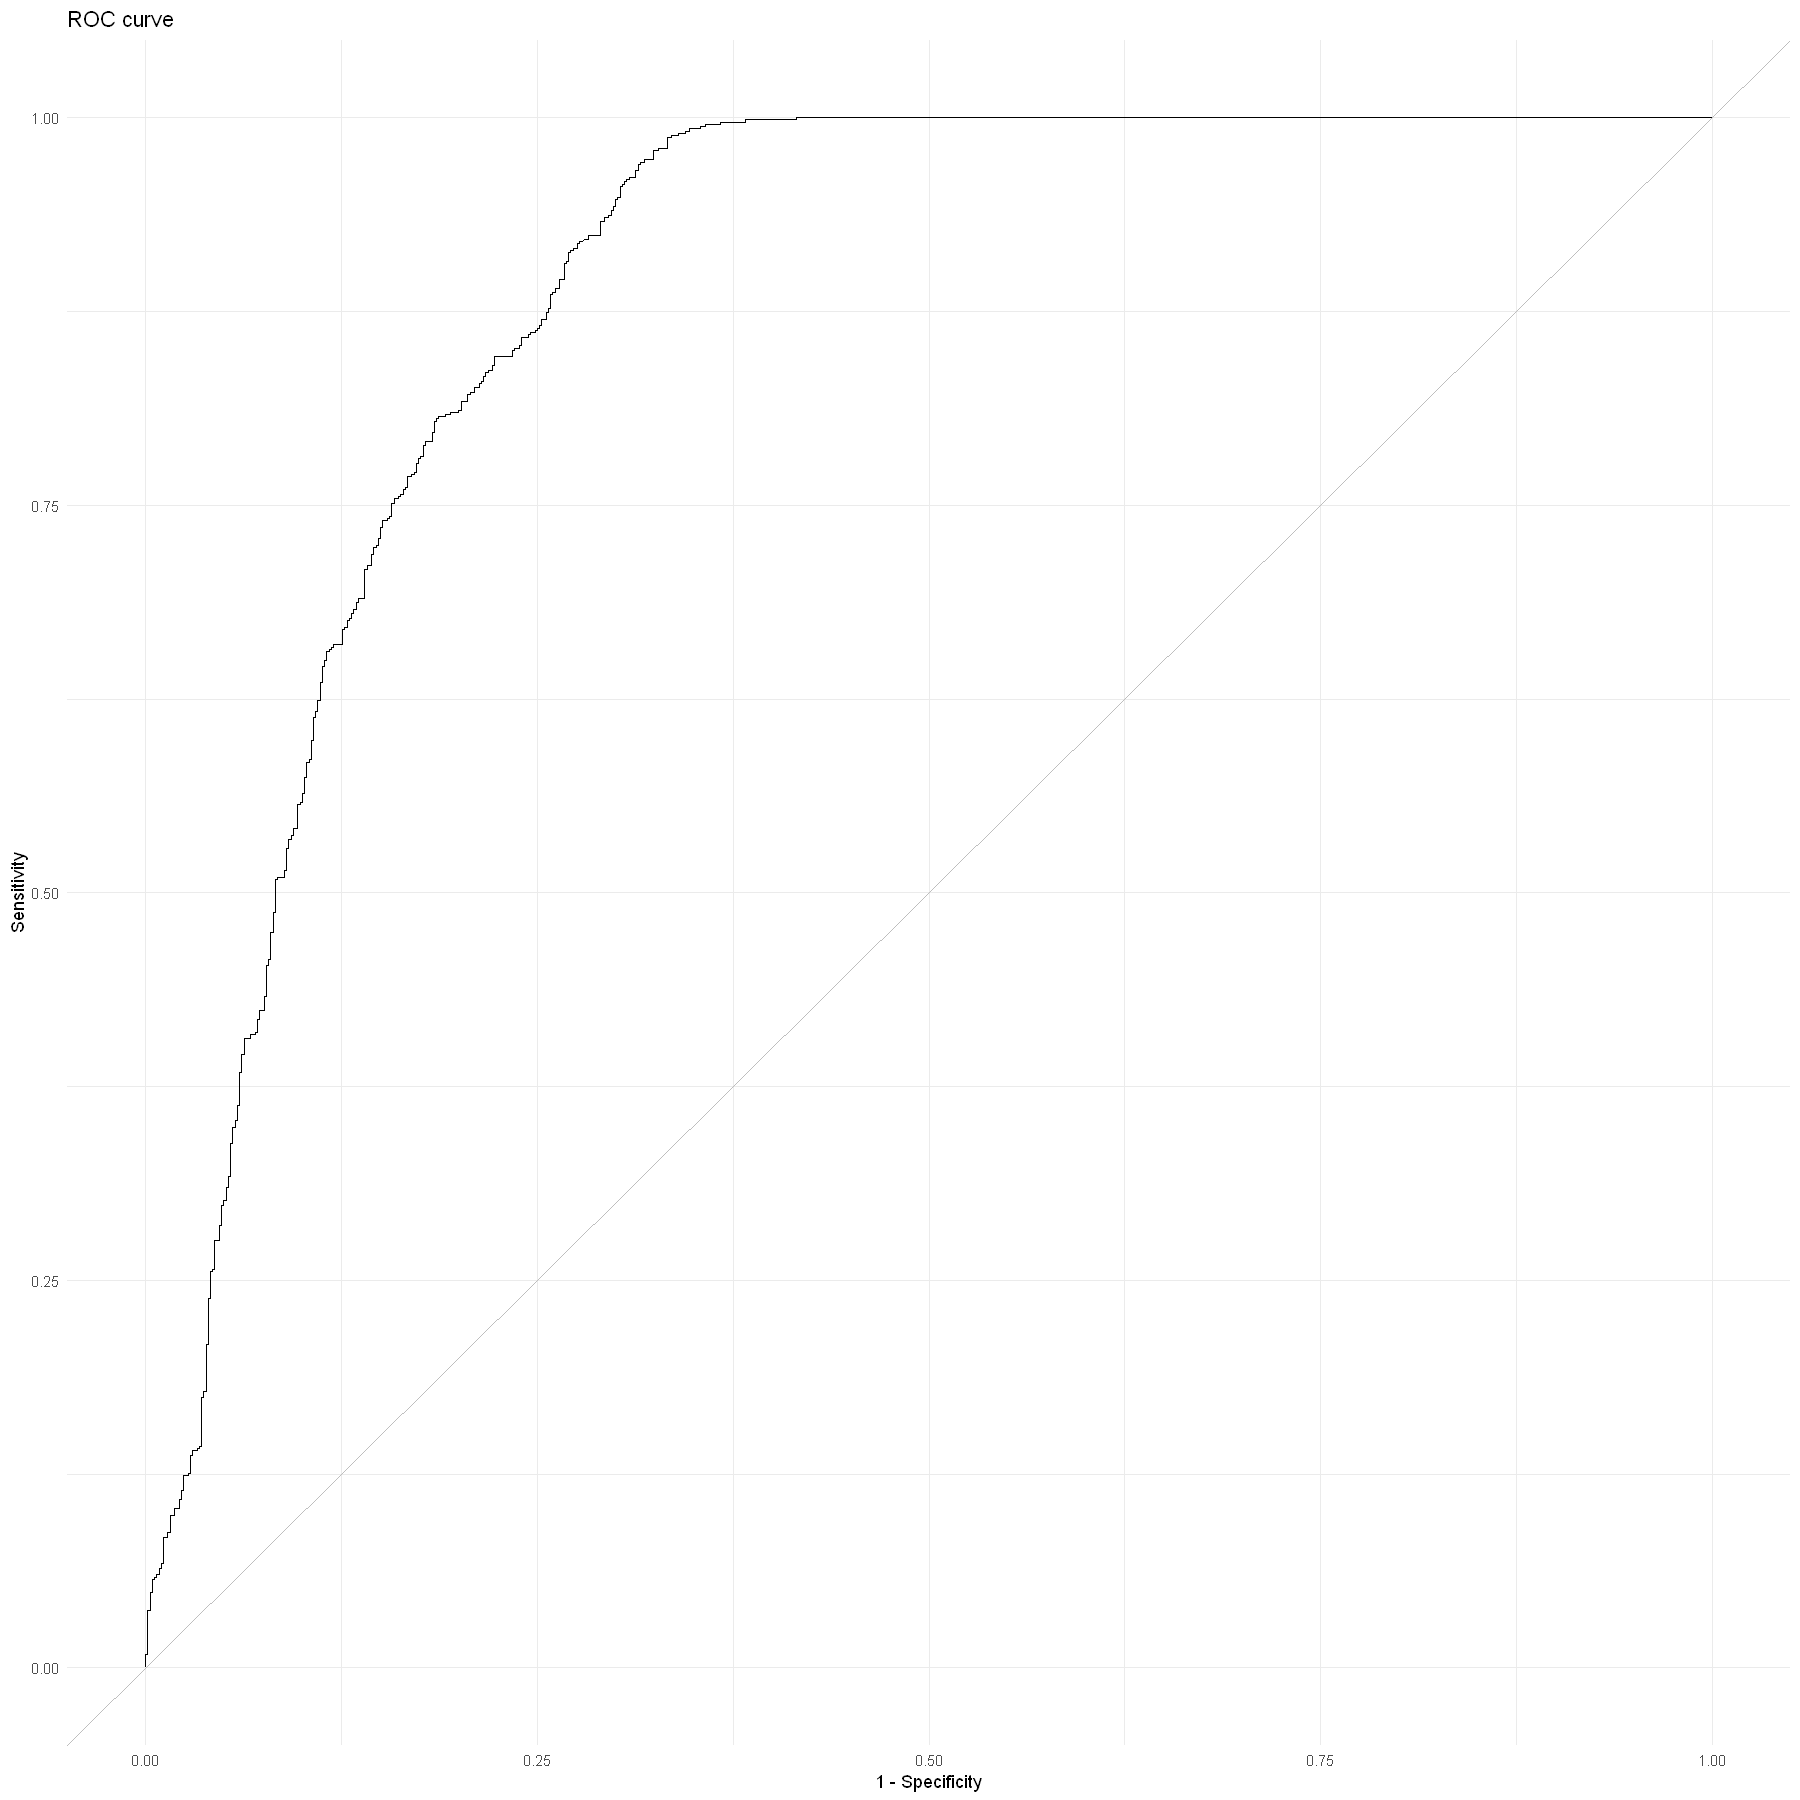

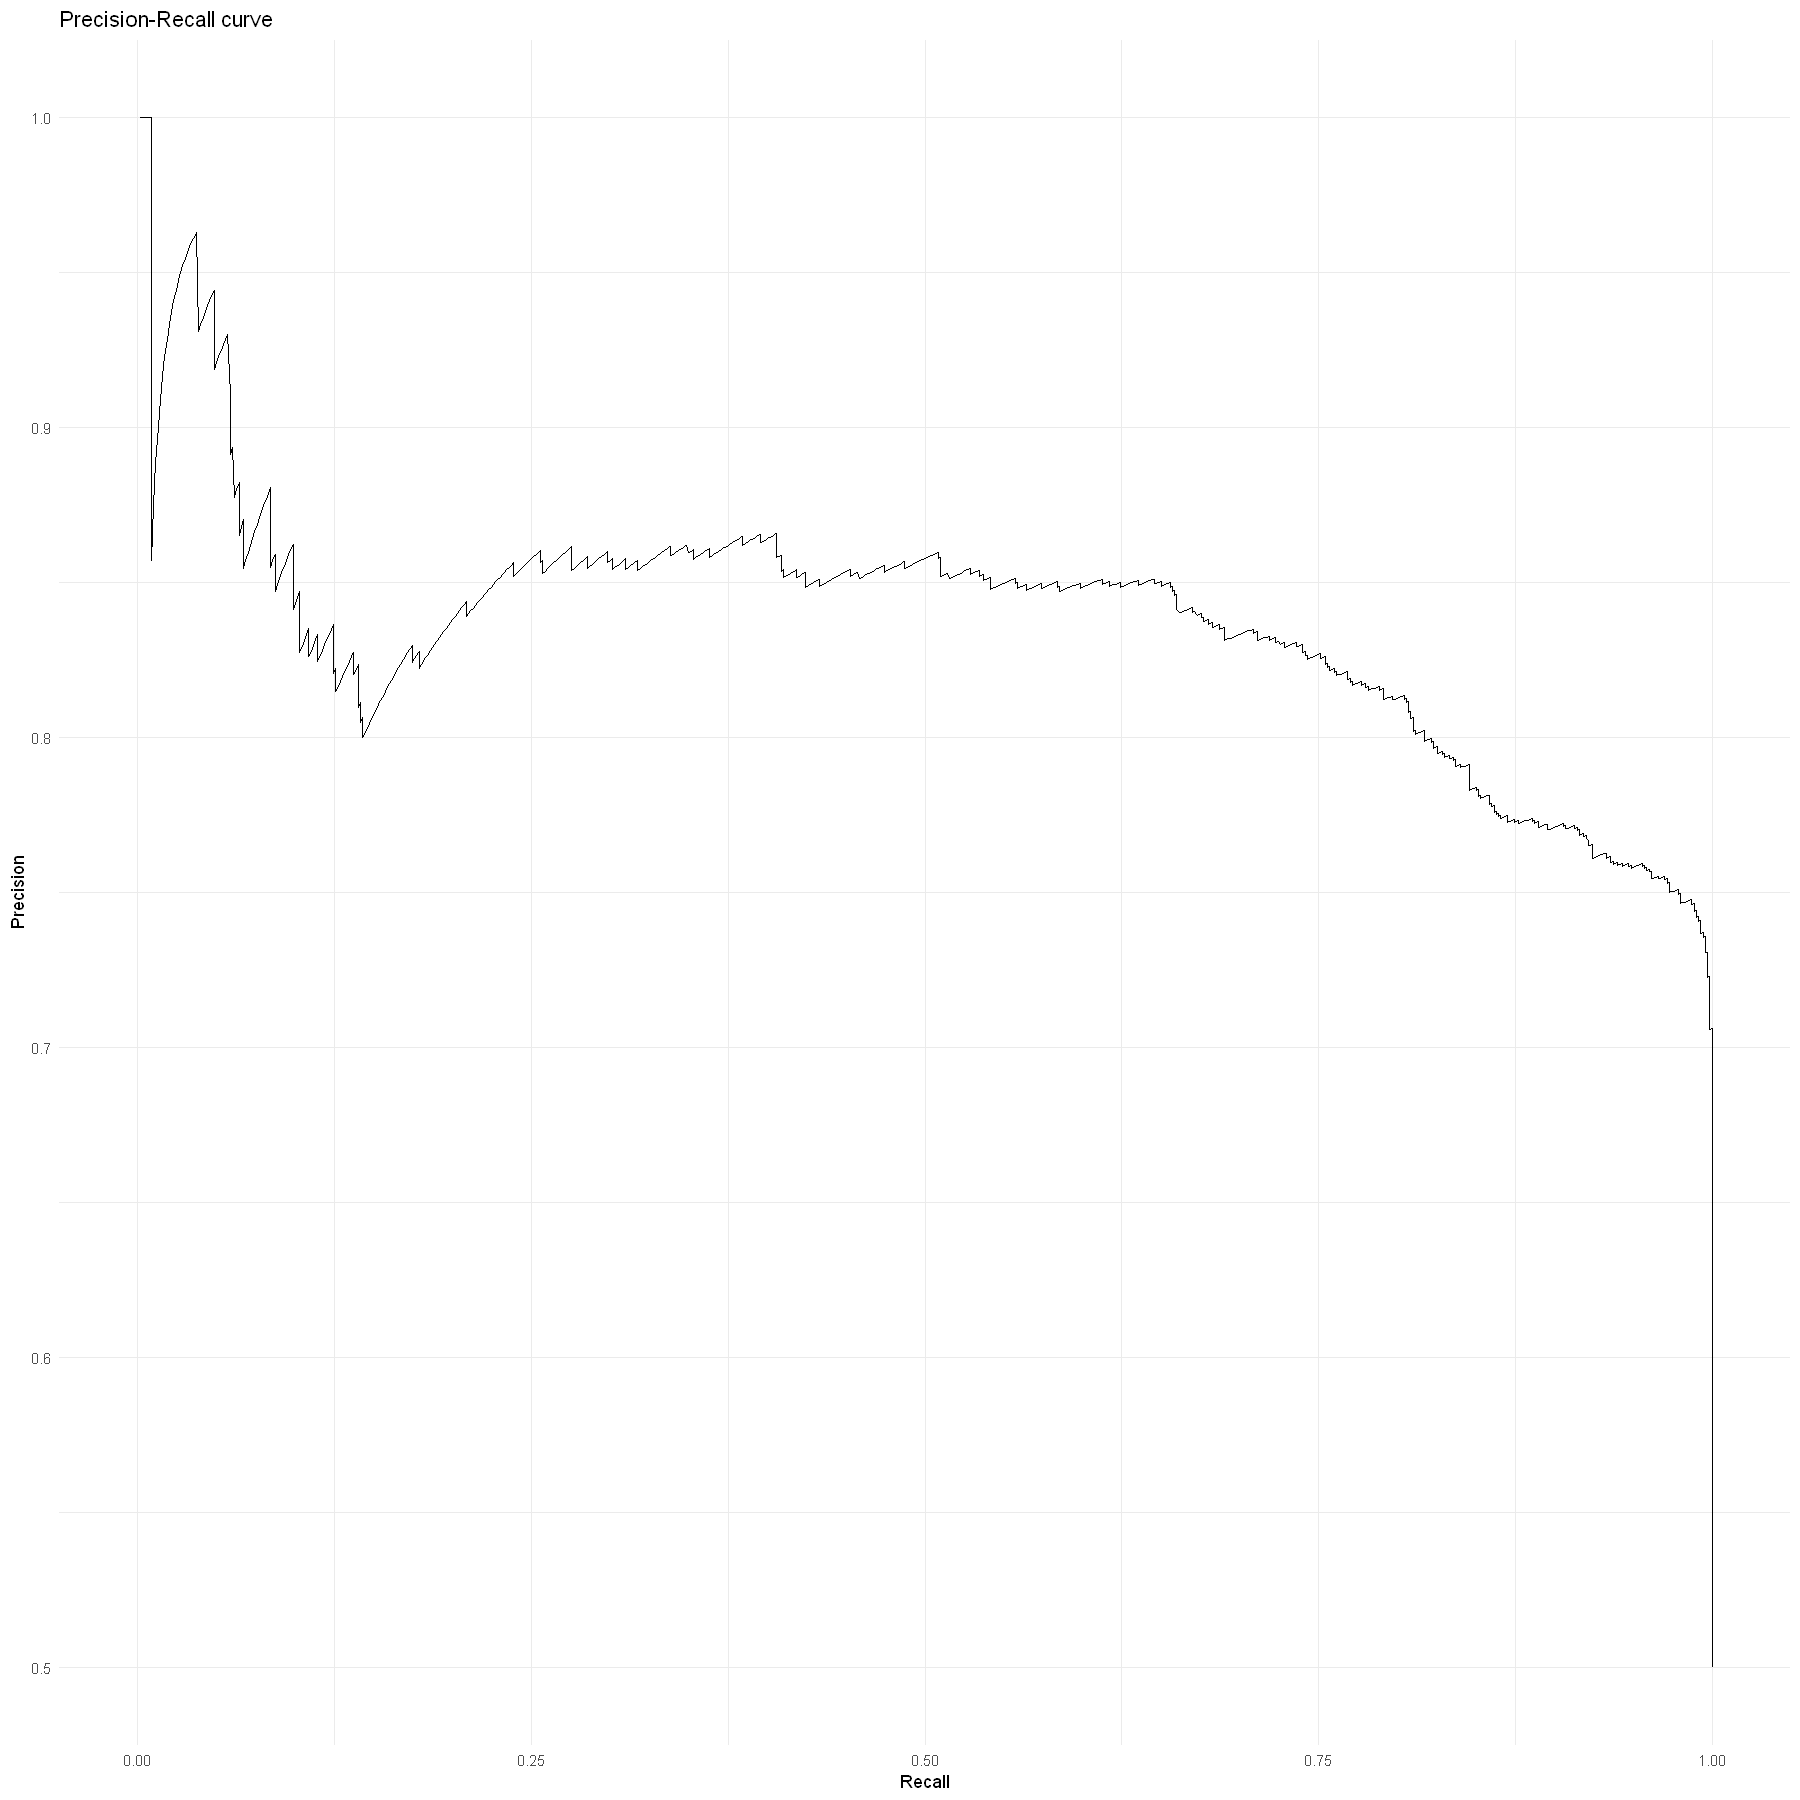

In [250]:
ggplot(data = as.data.frame(accuracies.rstanarm, what = "roc"), aes(x = x, y = y)) +
  geom_line() + 
  geom_abline(intercept = 0, slope = 1, color = "gray") + 
  labs(title = "ROC curve") + 
  xlab("1 - Specificity") + 
  ylab("Sensitivity") +
  theme_minimal()

ggplot(data = as.data.frame(accuracies.rstanarm, what = "prc"), aes(x = x, y = y)) +
  geom_line() + 
  labs(title = "Precision-Recall curve") + 
  xlab("Recall") + 
  ylab("Precision") +
  theme_minimal()

Instead of posterior_linpred(..., transform=TRUE) please call posterior_epred(), which provides equivalent functionality.



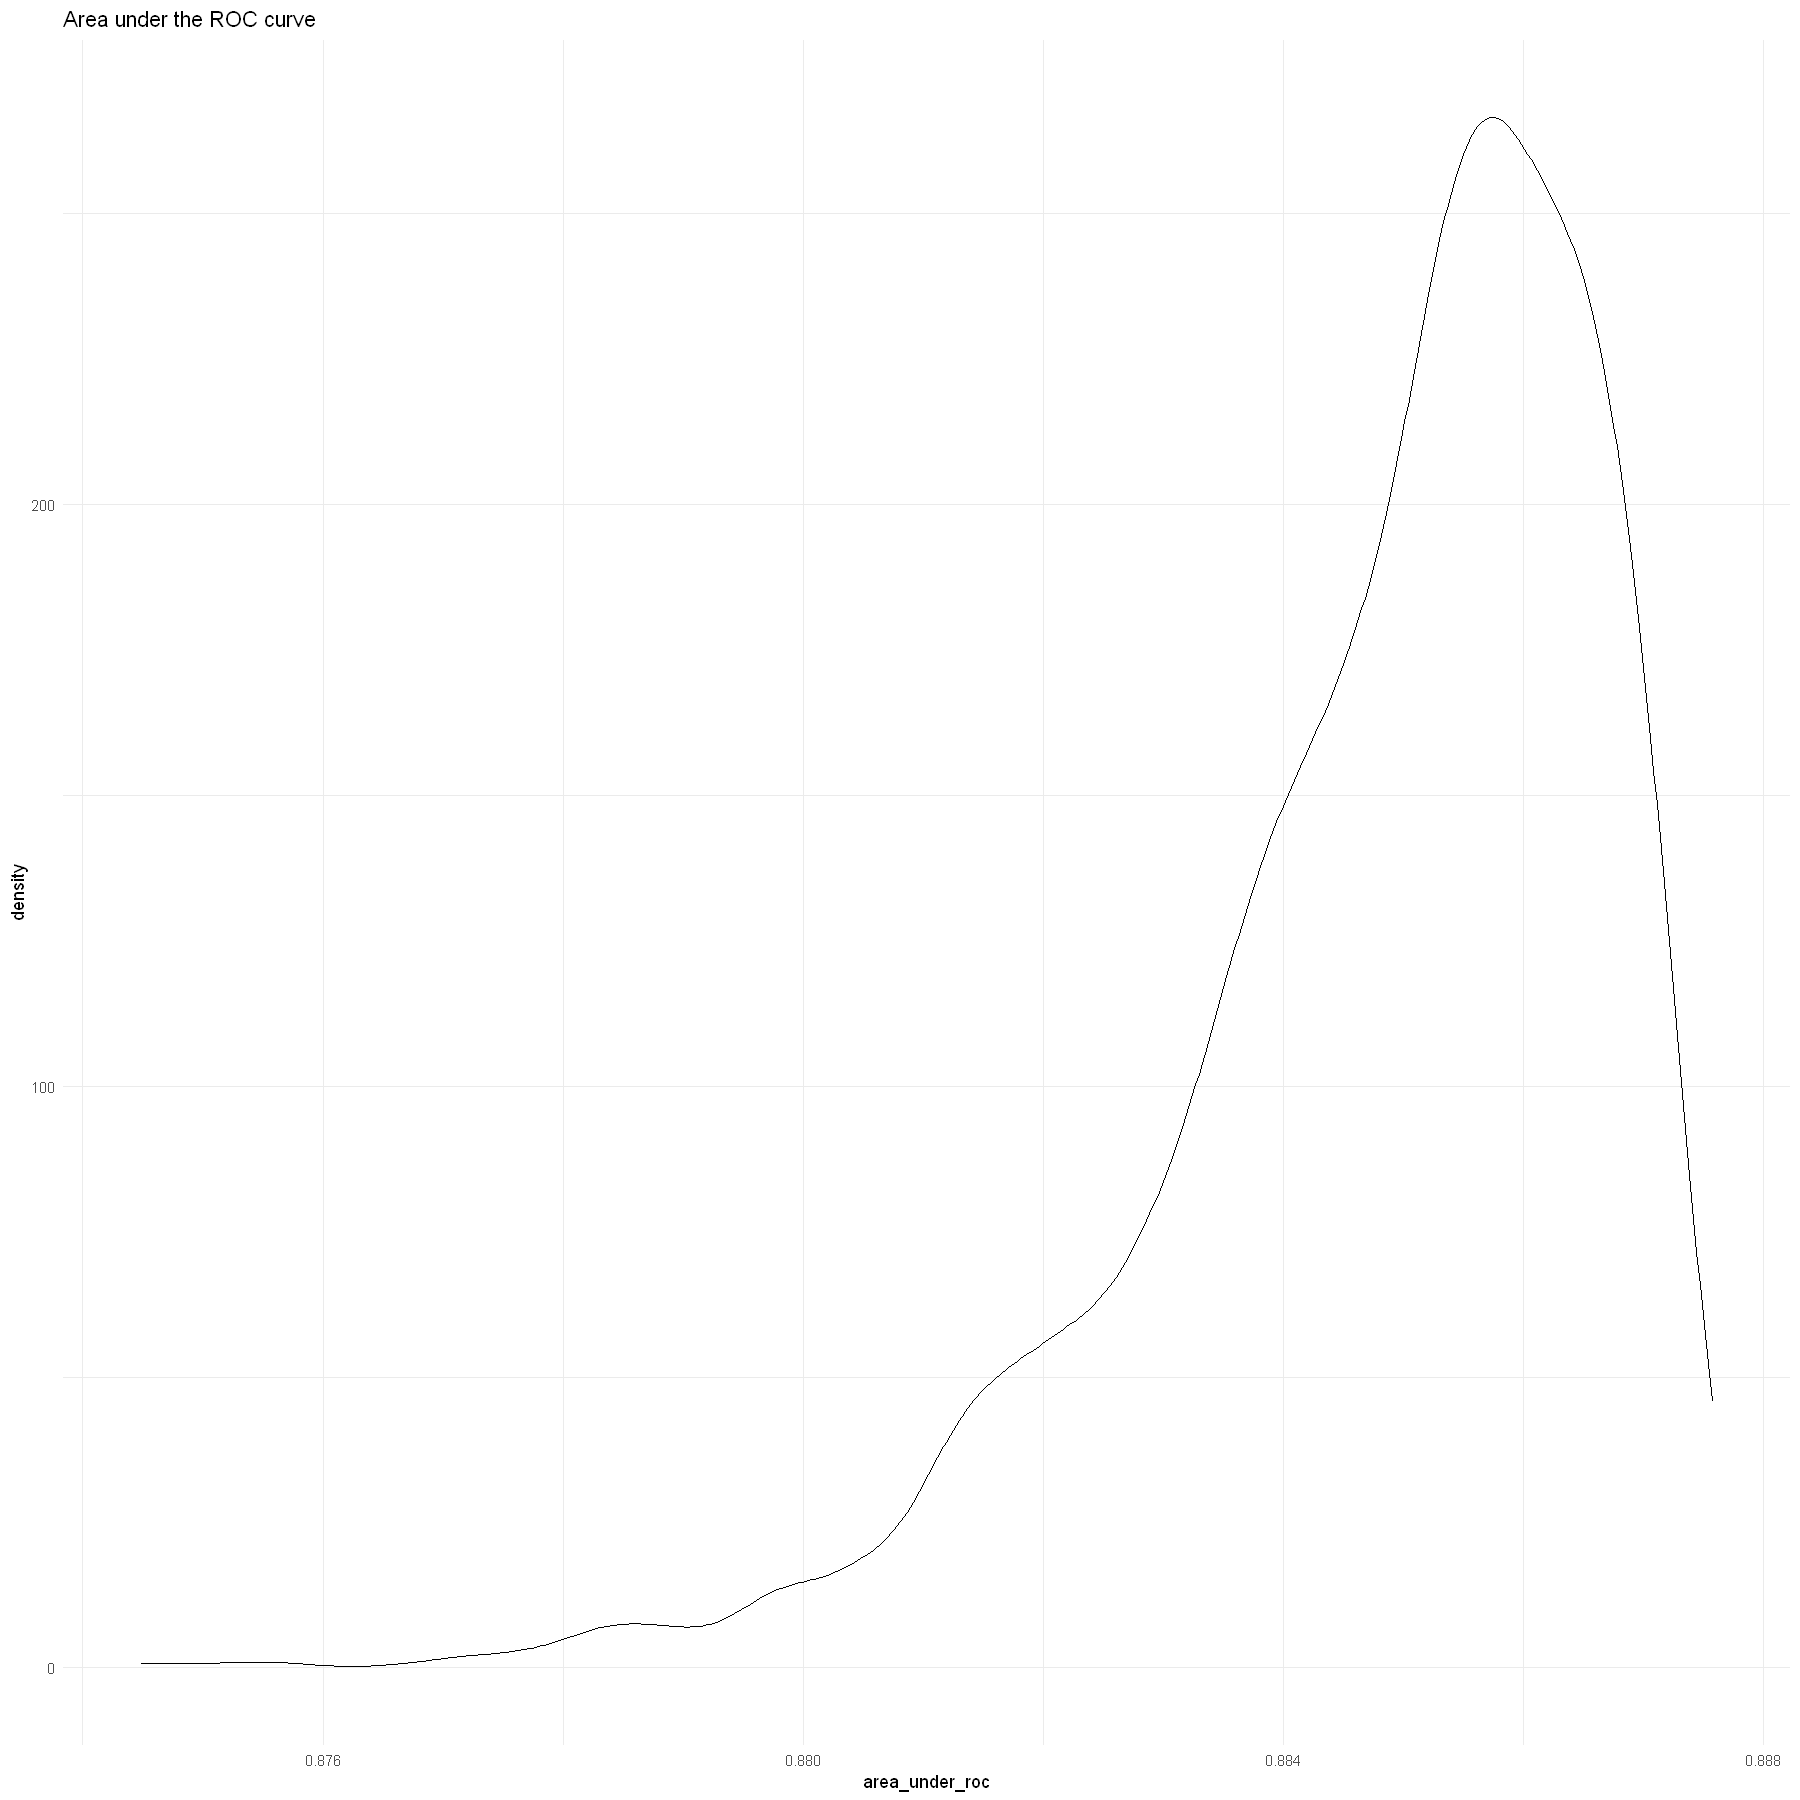

In [253]:
accuracies.rstanarm.full <- mcmcRocPrc(object = rstanarm_model,
                       yname  = "Response",
                       xnames = c('Gender','Age','Driving_License','Previously_Insured','Vehicle_Age',
                                  'Vehicle_Damage','Annual_Premium','Vintage'),
                       curves = FALSE,
                       fullsims = TRUE)

ggplot(as.data.frame(accuracies.rstanarm.full), 
       aes(x = area_under_roc)) +
  geom_density() +
  labs(title = "Area under the ROC curve") +
  theme_minimal()

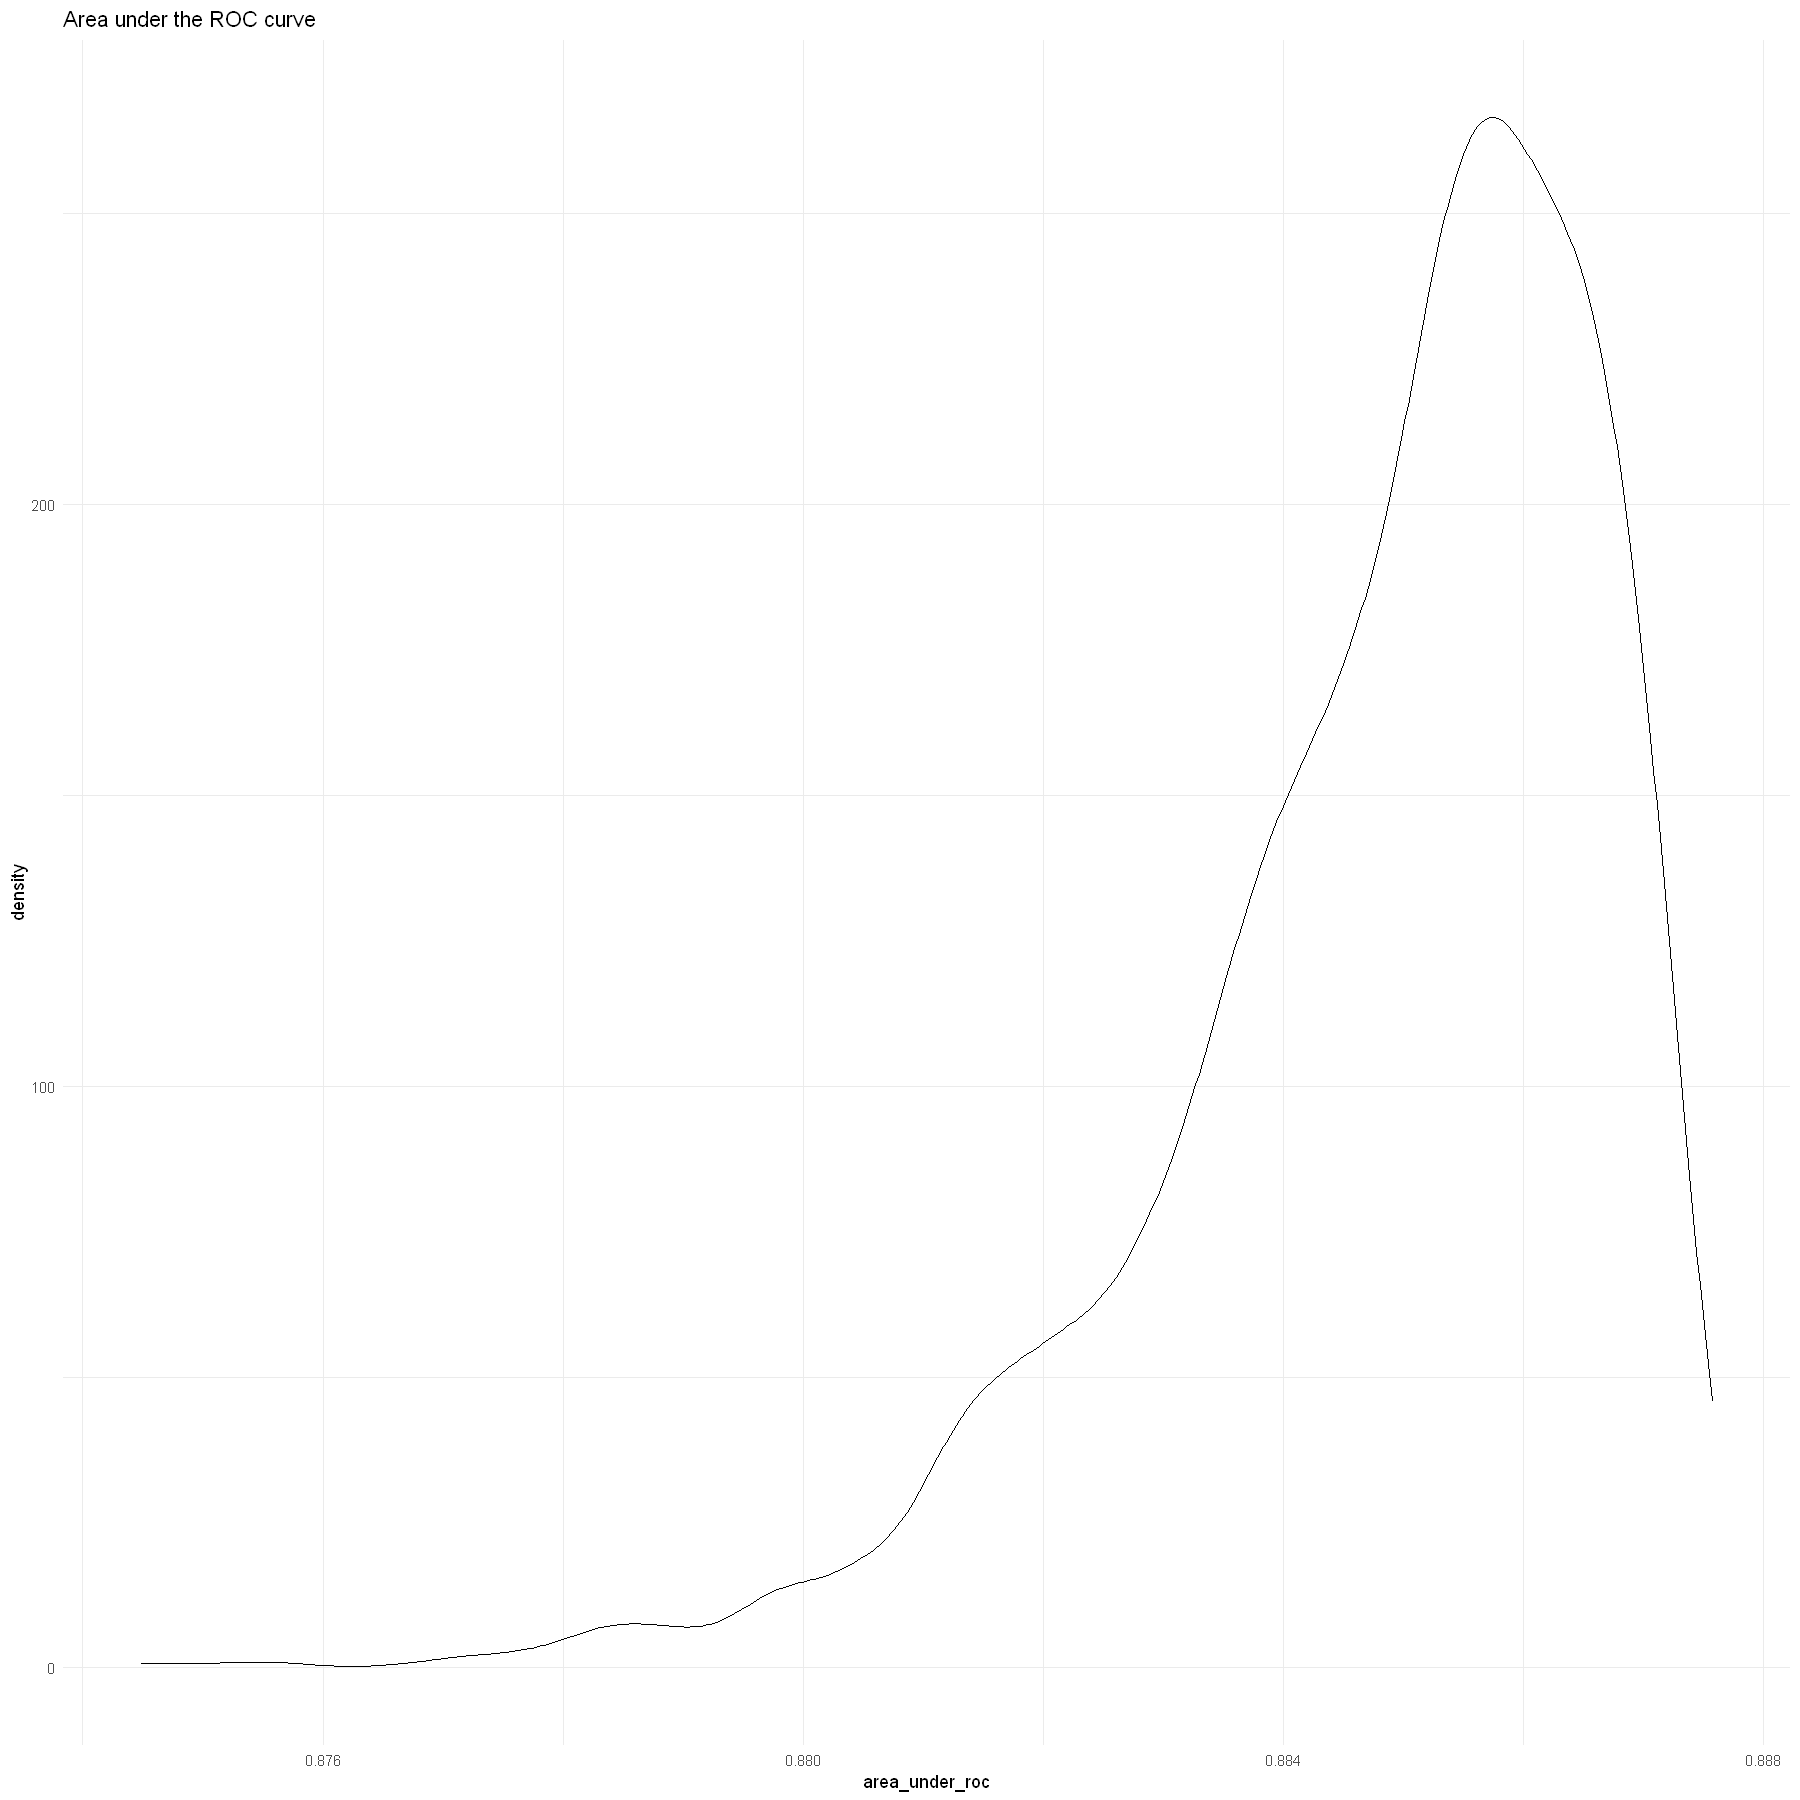

In [255]:
ggplot(as.data.frame(accuracies.rstanarm.full), 
       aes(x = area_under_roc)) +
  geom_density() +
  labs(title = "Area under the ROC curve") +
  theme_minimal()

#### Variable Selection

We have seen good results with this rstanarm model that uses all the variables from the dataset. Nevertheless, with the first differences plot we've also seen that the variables that impact the most on the final decision of taking the insurance are Age, Driving_License, Previously_Insured, Vehicle_Age and Vehicle_Damage. Therefore, we are gonna construct a new rstanarm model with only this few variables and check its performance again.

In [262]:
df_small <- df[c(2,3,4,5,6,9)]
df_small[1:5,]

Age        Driving_License Previously_Insured Vehicle_Age Vehicle_Damage
382132 -1.0963383 1               0                  1           1             
56494  -0.9519204 1               0                  1           1             
183837  1.9364380 1               0                  2           2             
119833 -0.8797114 1               1                  1           1             
371747 -1.2407562 1               1                  1           1             
       Response
382132 0       
56494  0       
183837 0       
119833 0       
371747 0

In [263]:
rstanarm_model.small <- stan_glm(Response ~ Age + Driving_License + Previously_Insured + 
                         Vehicle_Age + Vehicle_Damage,
                        data = df_small, family = binomial(link = "logit"),
                        prior = normal(0, 3),
                        prior_intercept = normal(0, 3),
                        chains = 4, 
                        iter = 2000,
                        seed = 123)

In [264]:
matrix_rstanarm.small <- as.matrix(rstanarm_model.small)

mm.rstanarm.small <- model.matrix(Response ~ Age + Driving_License + Previously_Insured + 
                         Vehicle_Age + Vehicle_Damage,
                   data = df_small)

In [258]:
first_difference.rstanarm.small <- mcmcFD(modelmatrix = mm.rstanarm.small,
                  mcmcout = matrix_rstanarm.small[, 1:ncol(mm.rstanarm.small)],
                  link = "logit",
                  ci = c(0.025, 0.975),
                  fullsims = FALSE)

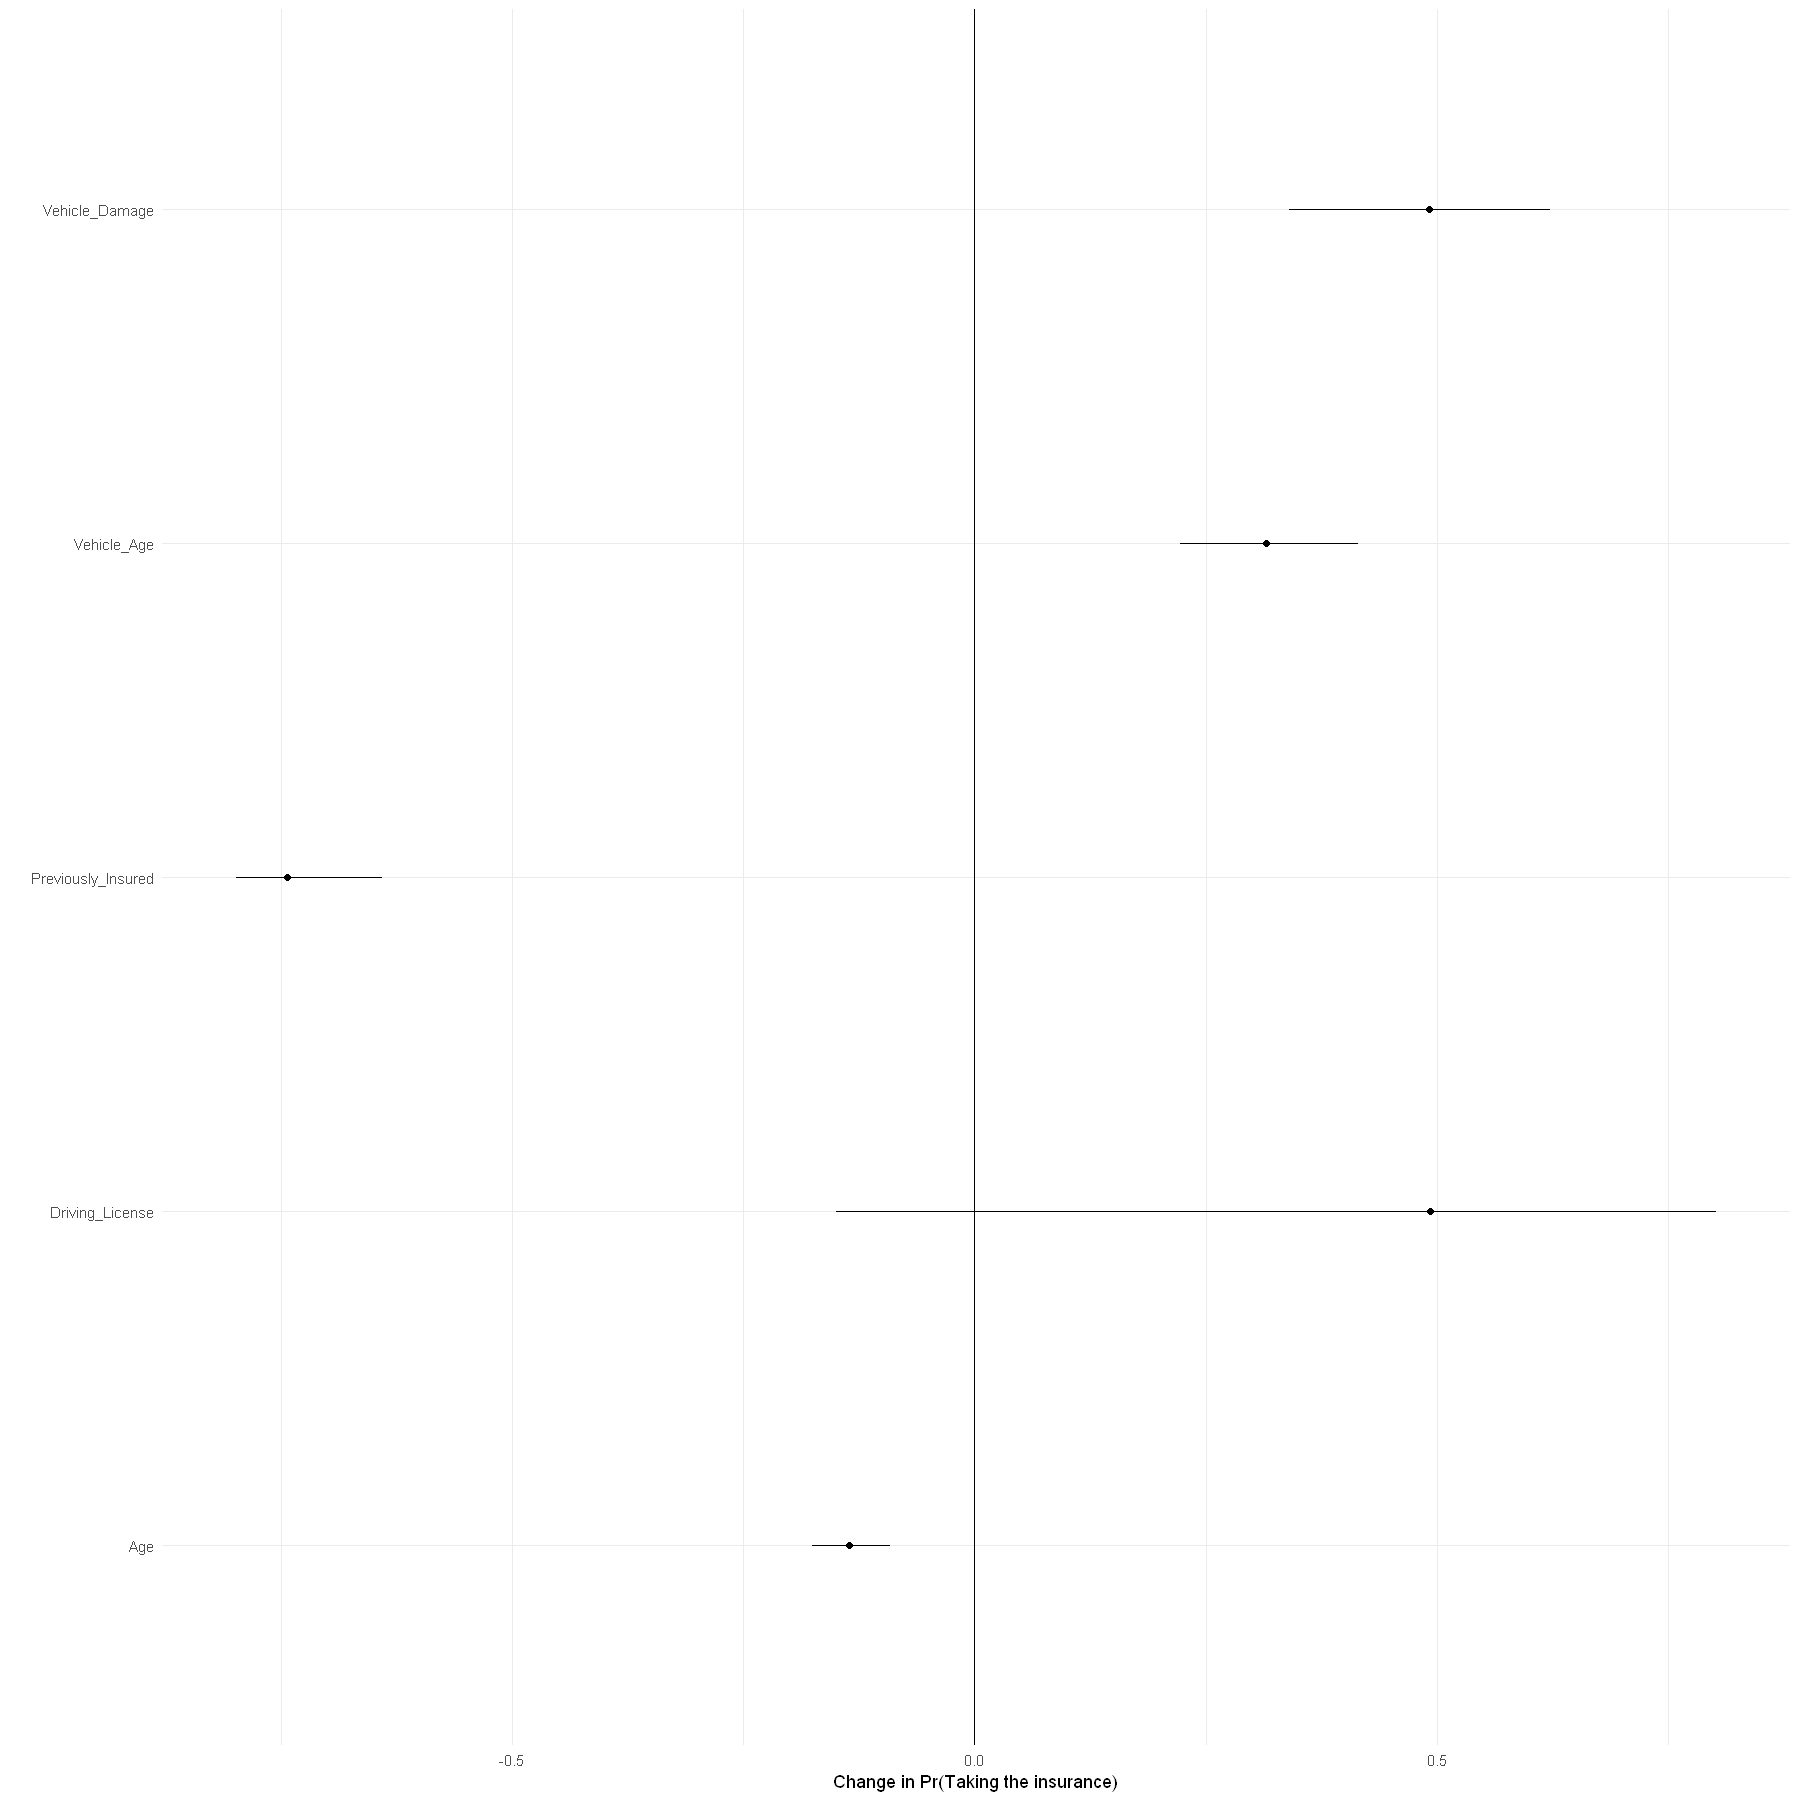

In [265]:
ggplot(data = first_difference.rstanarm.small, 
       aes(x = median_fd, y = VarName)) + 
  geom_point() + 
  geom_segment(aes(x = lower_fd, xend = upper_fd, yend = VarName)) + 
  geom_vline(xintercept = 0) + 
  xlab("Change in Pr(Taking the insurance)") + 
  ylab("") +
  theme_minimal()



#### Area Under the ROC Curve


In [266]:
accuracies.rstanarm.small <- mcmcRocPrc(object = rstanarm_model.small,
                       yname  = "Response",
                       xnames = c('Age','Driving_License','Previously_Insured','Vehicle_Age',
                                  'Vehicle_Damage'),
                       curves = TRUE,
                       fullsims = FALSE)

Instead of posterior_linpred(..., transform=TRUE) please call posterior_epred(), which provides equivalent functionality.



We got barely the same scores. This means that our previous model knew which are the most relevant features and already does a great work when predicting the outcome:

In [267]:
accuracies.rstanarm.small$area_under_roc
accuracies.rstanarm.small$area_under_prc

V1 
0.883199

V1 
0.8315379

### Non-Balanced Case

In [77]:
set.seed(123)
non_balanced <- data[sample(nrow(data), 2000), ]
non_balanced <- non_balanced[c(2,3,4,5,6,9)]
non_balanced[1:5,]

Age        Driving_License Previously_Insured Vehicle_Age Vehicle_Damage
188942  0.2925290 1               0                  1           1             
134058  1.0149349 1               0                  2           1             
124022  0.2268557 1               1                  1           0             
160997  0.3582023 1               1                  1           0             
226318 -1.1522828 1               1                  0           0             
       Response
188942 0       
134058 0       
124022 0       
160997 0       
226318 0

In [79]:
rstanarm_model.no_balance <- stan_glm(Response ~ Age + Driving_License + Previously_Insured + 
                         Vehicle_Age + Vehicle_Damage,
                        data = non_balanced, family = binomial(link = "logit"),
                        prior = normal(0, 3),
                        prior_intercept = normal(0, 3),
                        chains = 4, 
                        iter = 2000,
                        seed = 123)



#### Area Under the ROC Curve


In [83]:
accuracies.rstanarm.no_balance <- mcmcRocPrc(object = rstanarm_model.no_balance,
                       yname  = "Response",
                       xnames = c('Age','Driving_License','Previously_Insured','Vehicle_Age',
                                  'Vehicle_Damage'),
                       curves = TRUE,
                       fullsims = FALSE)

Instead of posterior_linpred(..., transform=TRUE) please call posterior_epred(), which provides equivalent functionality.



Look at the difference: almost the same ROC Score but the one that matters, the PRC, dropped to 0.45!

In [84]:
accuracies.rstanarm.no_balance$area_under_roc
accuracies.rstanarm.no_balance$area_under_prc

V1 
0.8775536

V1 
0.4553271

## RJags

In [17]:
df <- resample(data,700)
dim(df)
table(df$Response)

[1] 1400    9


  0   1 
700 700 

In [18]:
dfCombined <- as.list(df[, c('Gender','Age','Driving_License','Previously_Insured','Vehicle_Age','Vehicle_Damage',
                             'Annual_Premium','Vintage','Response')])
dfCombined$nrows <- nrow(df)

In [282]:
mod.jags <- paste(" 
model {
for (i in 1:nrows){
  Response[i] ~ dbern(p[i])  
  logit(p[i]) <- mu[i]   
  mu[i] <- b[9] + b[2] * Gender[i] + b[3] * Age[i] + b[4] * Driving_License[i] + b[5] * Previously_Insured[i] + 
        b[6] * Vehicle_Age[i] + b[7] * Vehicle_Damage[i] + b[8] * Vintage[i] + b[1] * Annual_Premium[i]
  }

for(j in 1:9){
  b[j] ~ dnorm(0, 0.1)
  }

}
")
writeLines(mod.jags, "mod.jags")    

In [283]:
params.jags <- c("b")
inits1.jags <- list("b" = rep(0, 9))
inits.jags <- list(inits1.jags,inits1.jags,inits1.jags,inits1.jags)

In [284]:
library("R2jags")
set.seed(123)

jags_model <- jags(data = dfCombined, inits = inits.jags, 
  parameters.to.save = params.jags, n.chains = 4, n.iter = 2000, 
  n.burnin = 1000, model.file = "mod.jags")

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 1400
   Unobserved stochastic nodes: 9
   Total graph size: 16895

Initializing model



In [285]:
jags_model

Inference for Bugs model at "mod.jags", fit using jags,
 4 chains, each with 2000 iterations (first 1000 discarded)
 n.sims = 4000 iterations saved
          mu.vect sd.vect     2.5%      25%      50%      75%    97.5%  Rhat
b[1]        0.221   0.076    0.075    0.169    0.220    0.273    0.369 1.001
b[2]        0.162   0.150   -0.129    0.060    0.159    0.262    0.452 1.004
b[3]       -0.364   0.108   -0.573   -0.438   -0.363   -0.289   -0.155 1.003
b[4]       -0.109   1.812   -3.483   -1.361   -0.177    1.071    3.519 1.001
b[5]       -5.513   1.270   -8.457   -6.188   -5.388   -4.661   -3.356 1.251
b[6]        1.089   0.204    0.689    0.952    1.087    1.225    1.492 1.002
b[7]        2.259   0.378    1.562    1.999    2.245    2.505    3.046 1.005
b[8]       -0.040   0.077   -0.190   -0.093   -0.039    0.011    0.115 1.001
b[9]       -2.065   1.799   -5.832   -3.238   -1.992   -0.819    1.270 1.001
deviance 1083.961   7.156 1077.201 1080.397 1082.888 1086.012 1095.747 1.010
     

### Convergence & Chain analysis

Let's look at this model convergence performance

We notice that the convergence is tatisfactory for most of the model, but we find that for the variable Previously_Insured, the model fails to converge. Perhaps this varaible doesn't have an impact on the final result, so the model struggles to find an optimal value for it.

In [286]:
library("bayesplot")

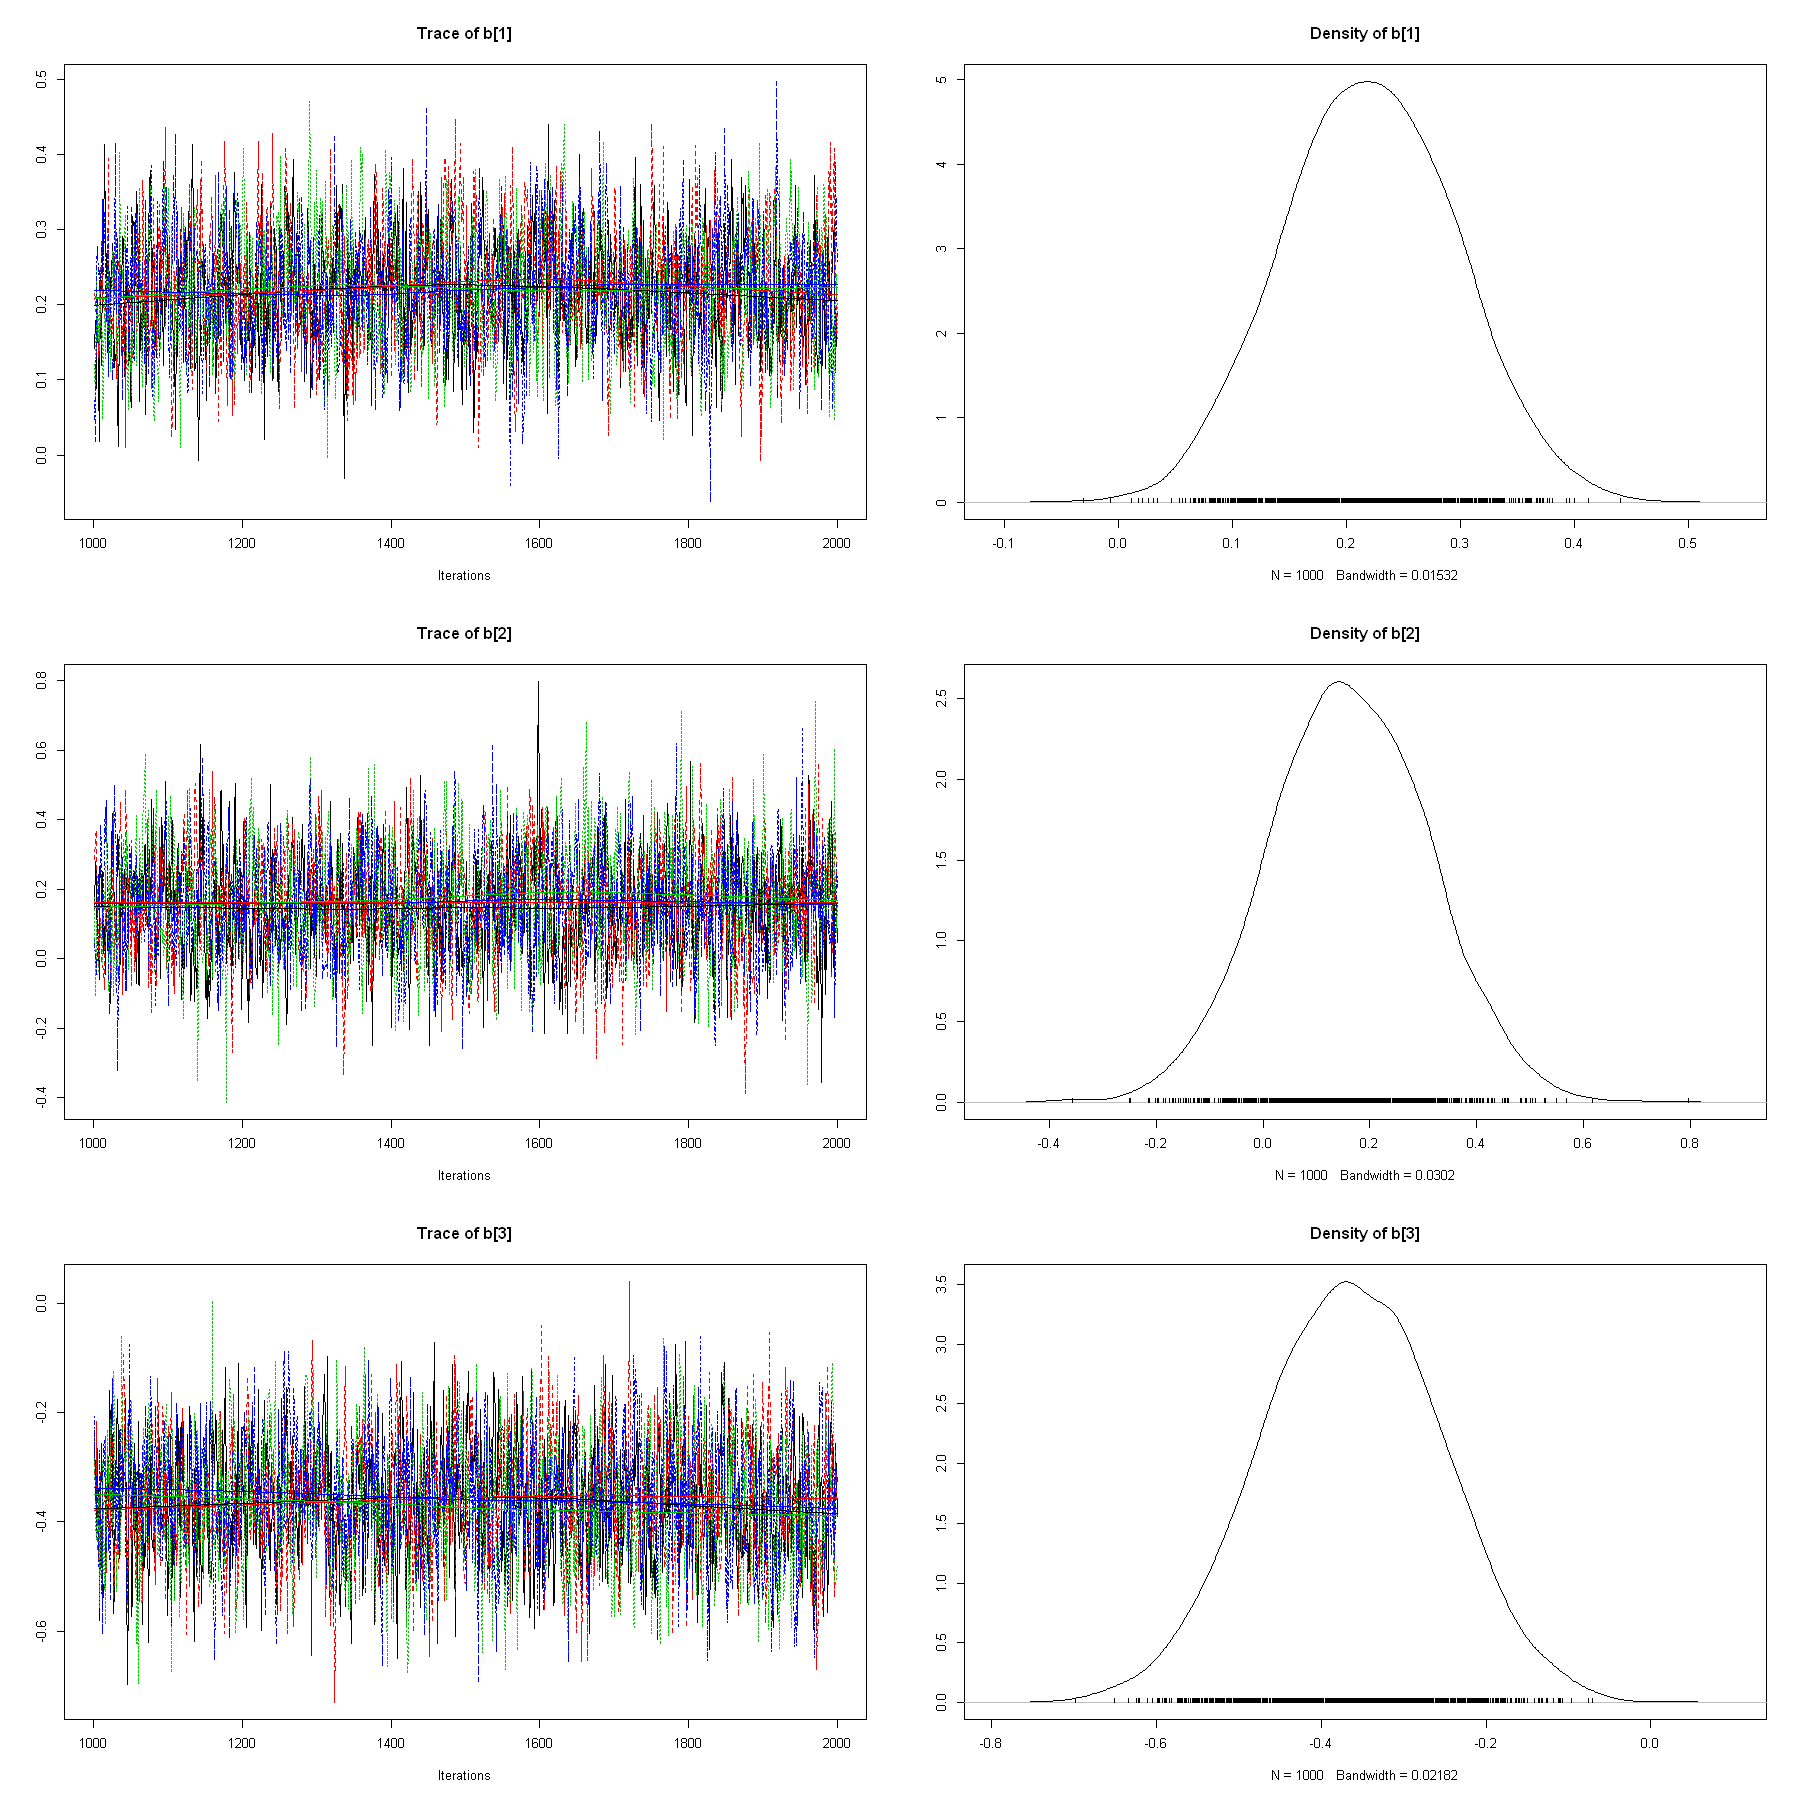

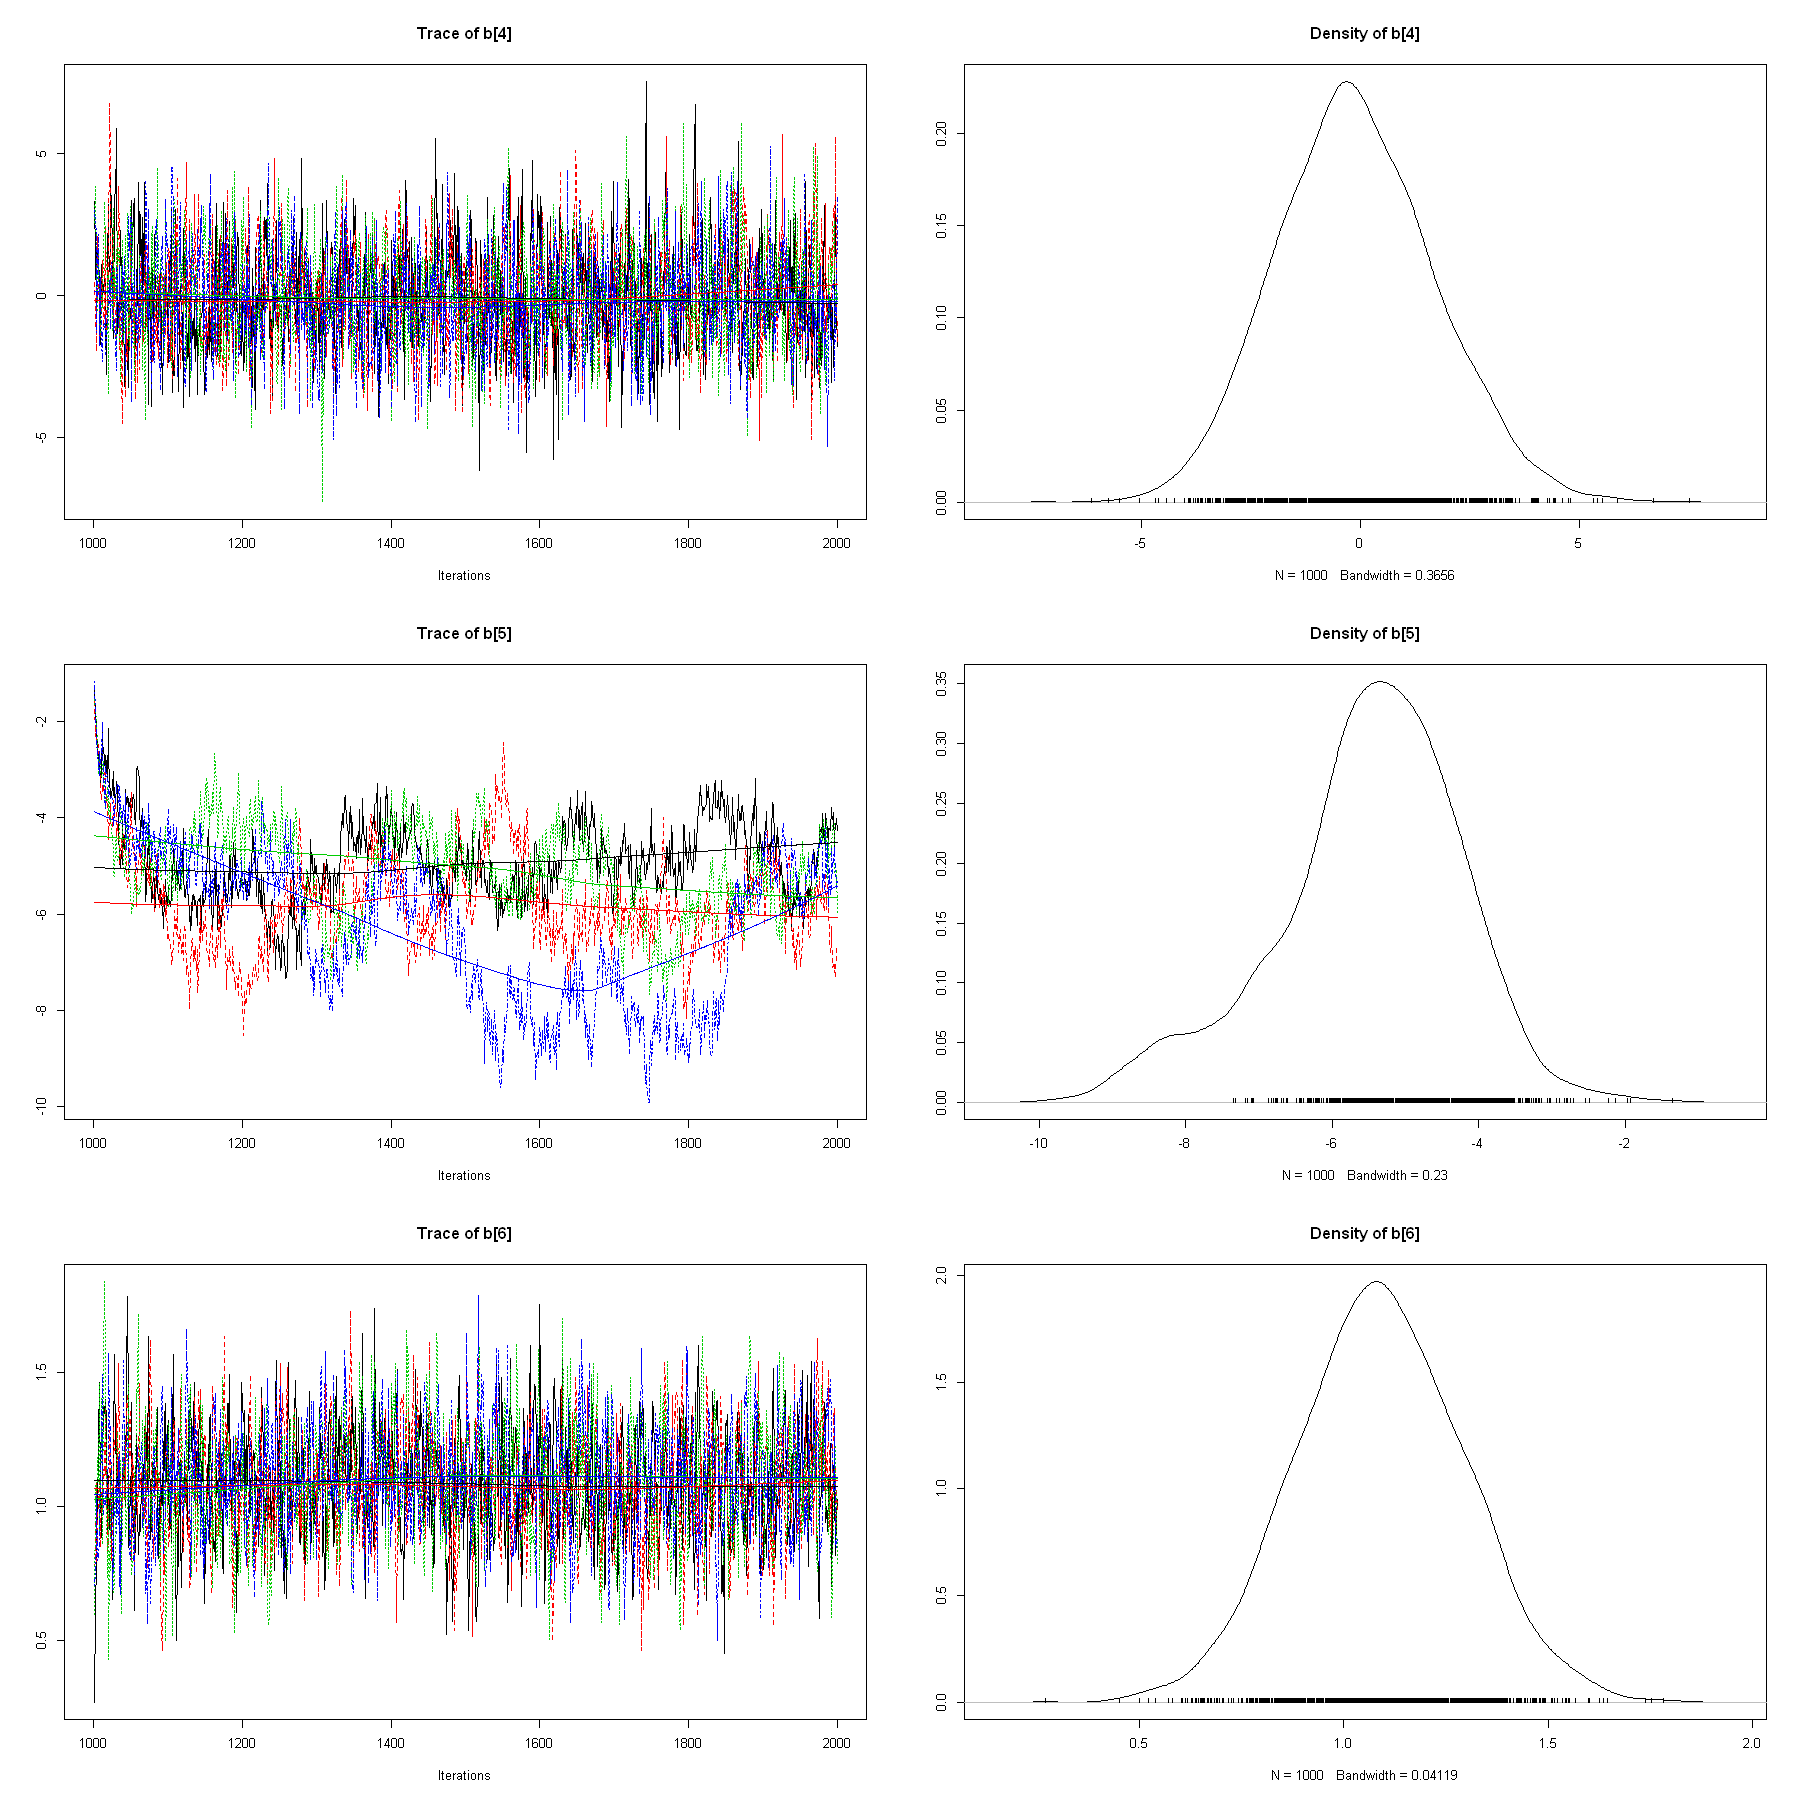

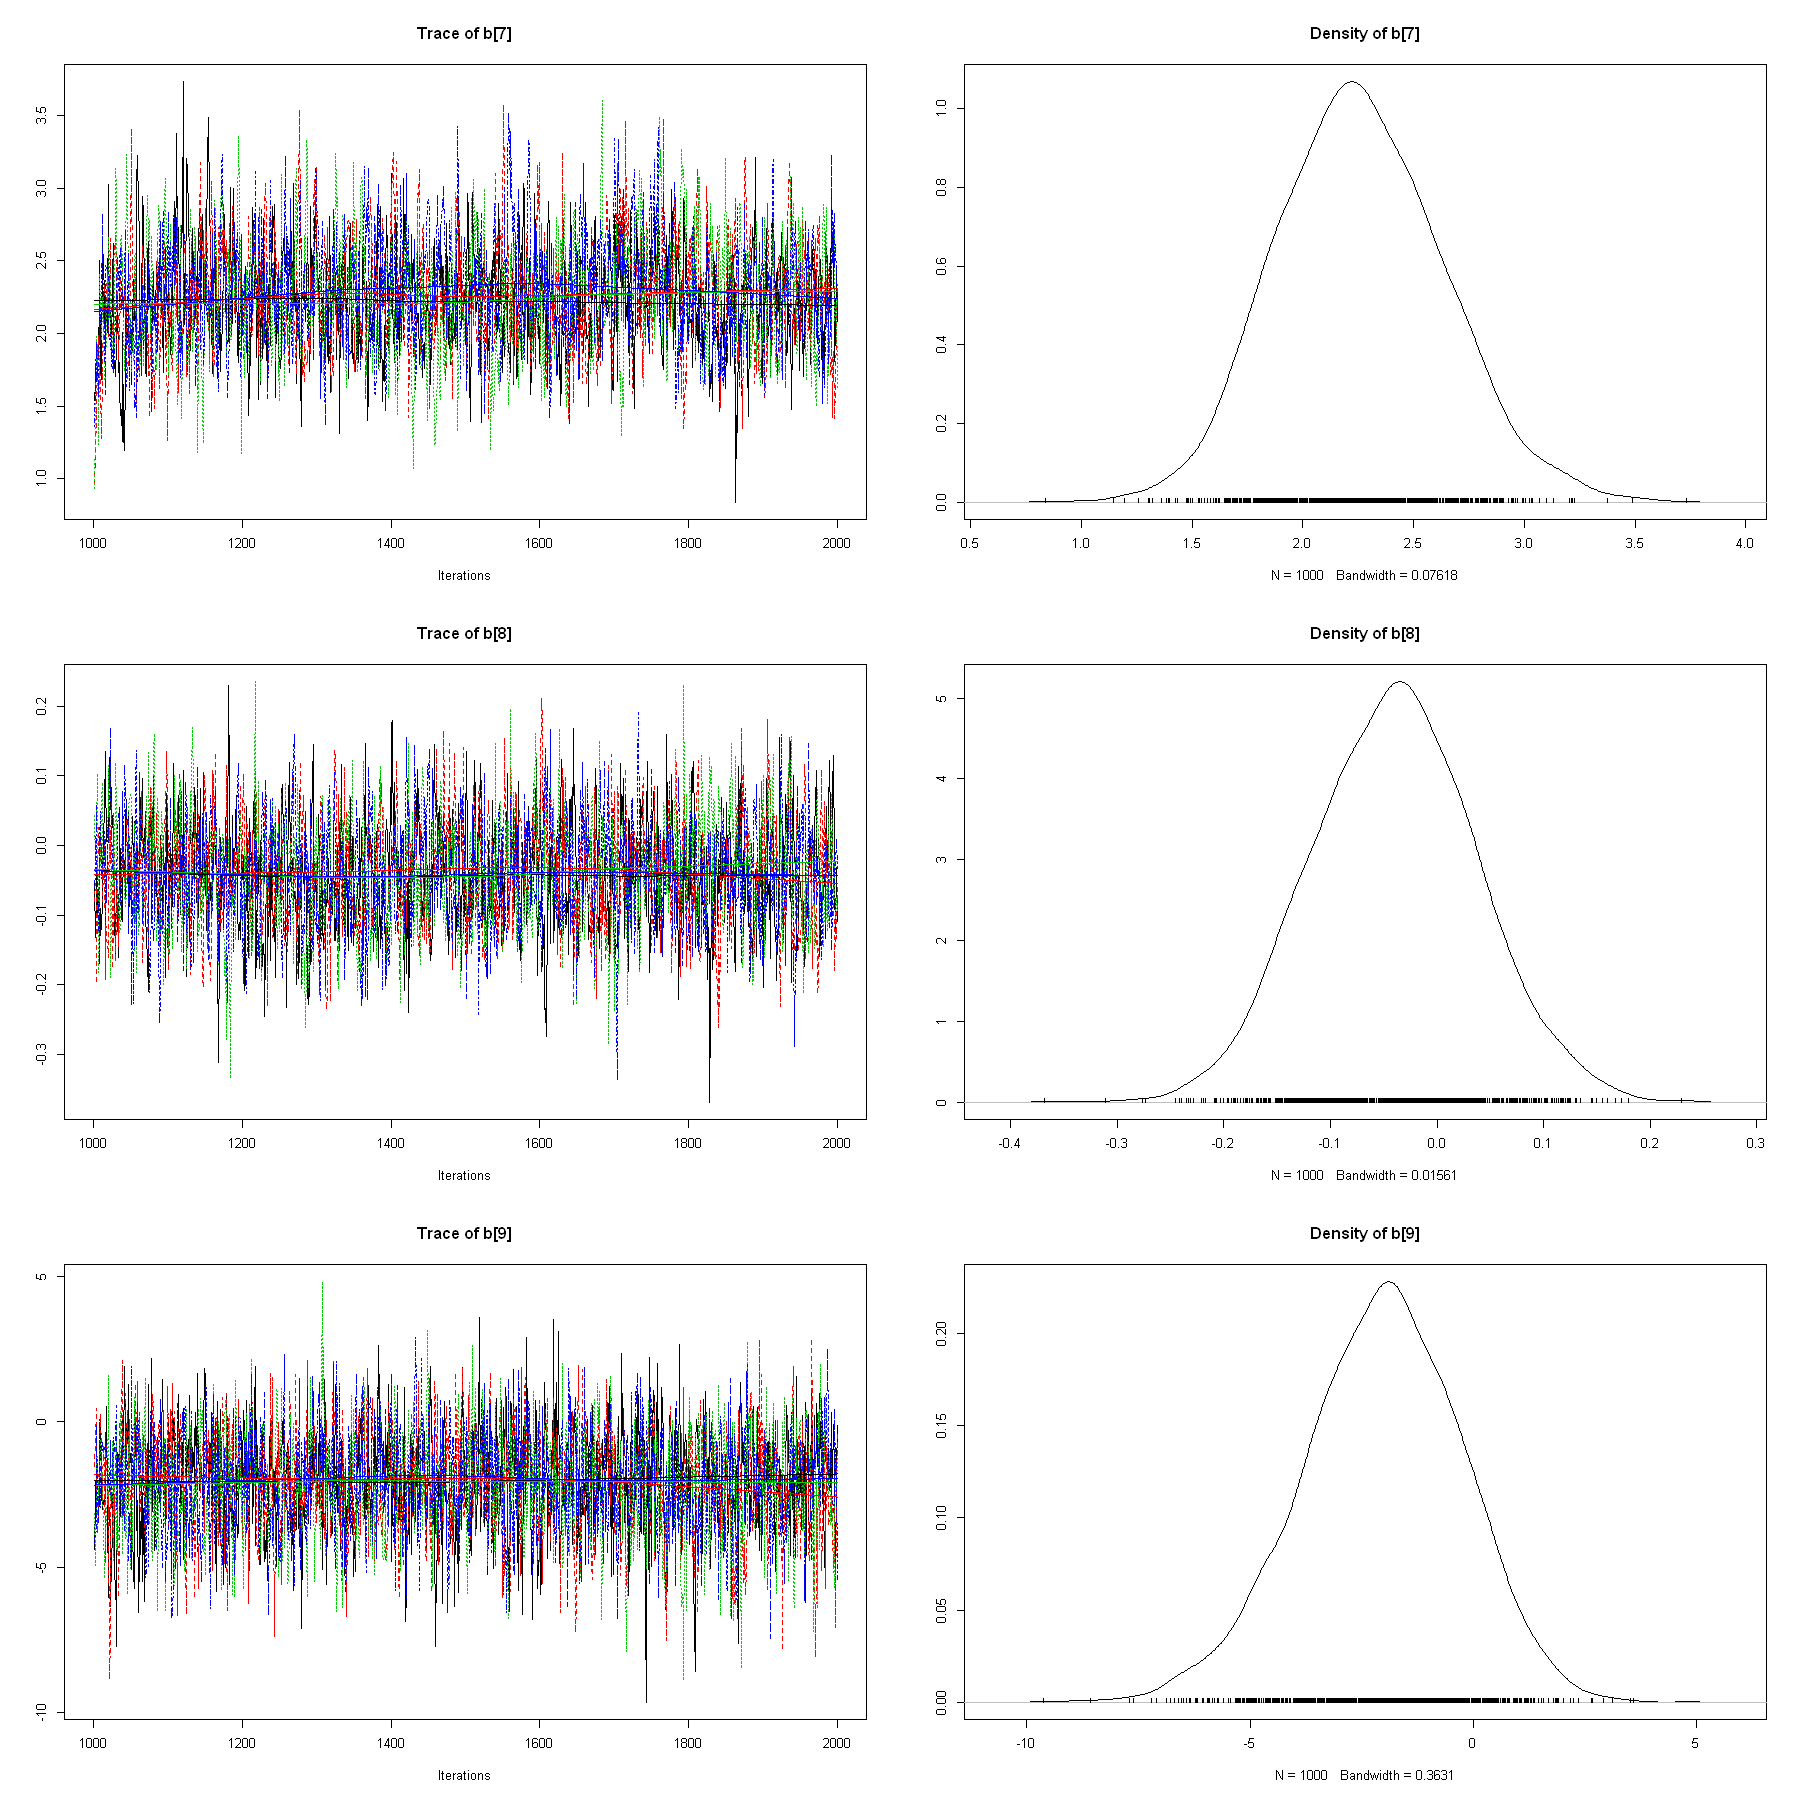

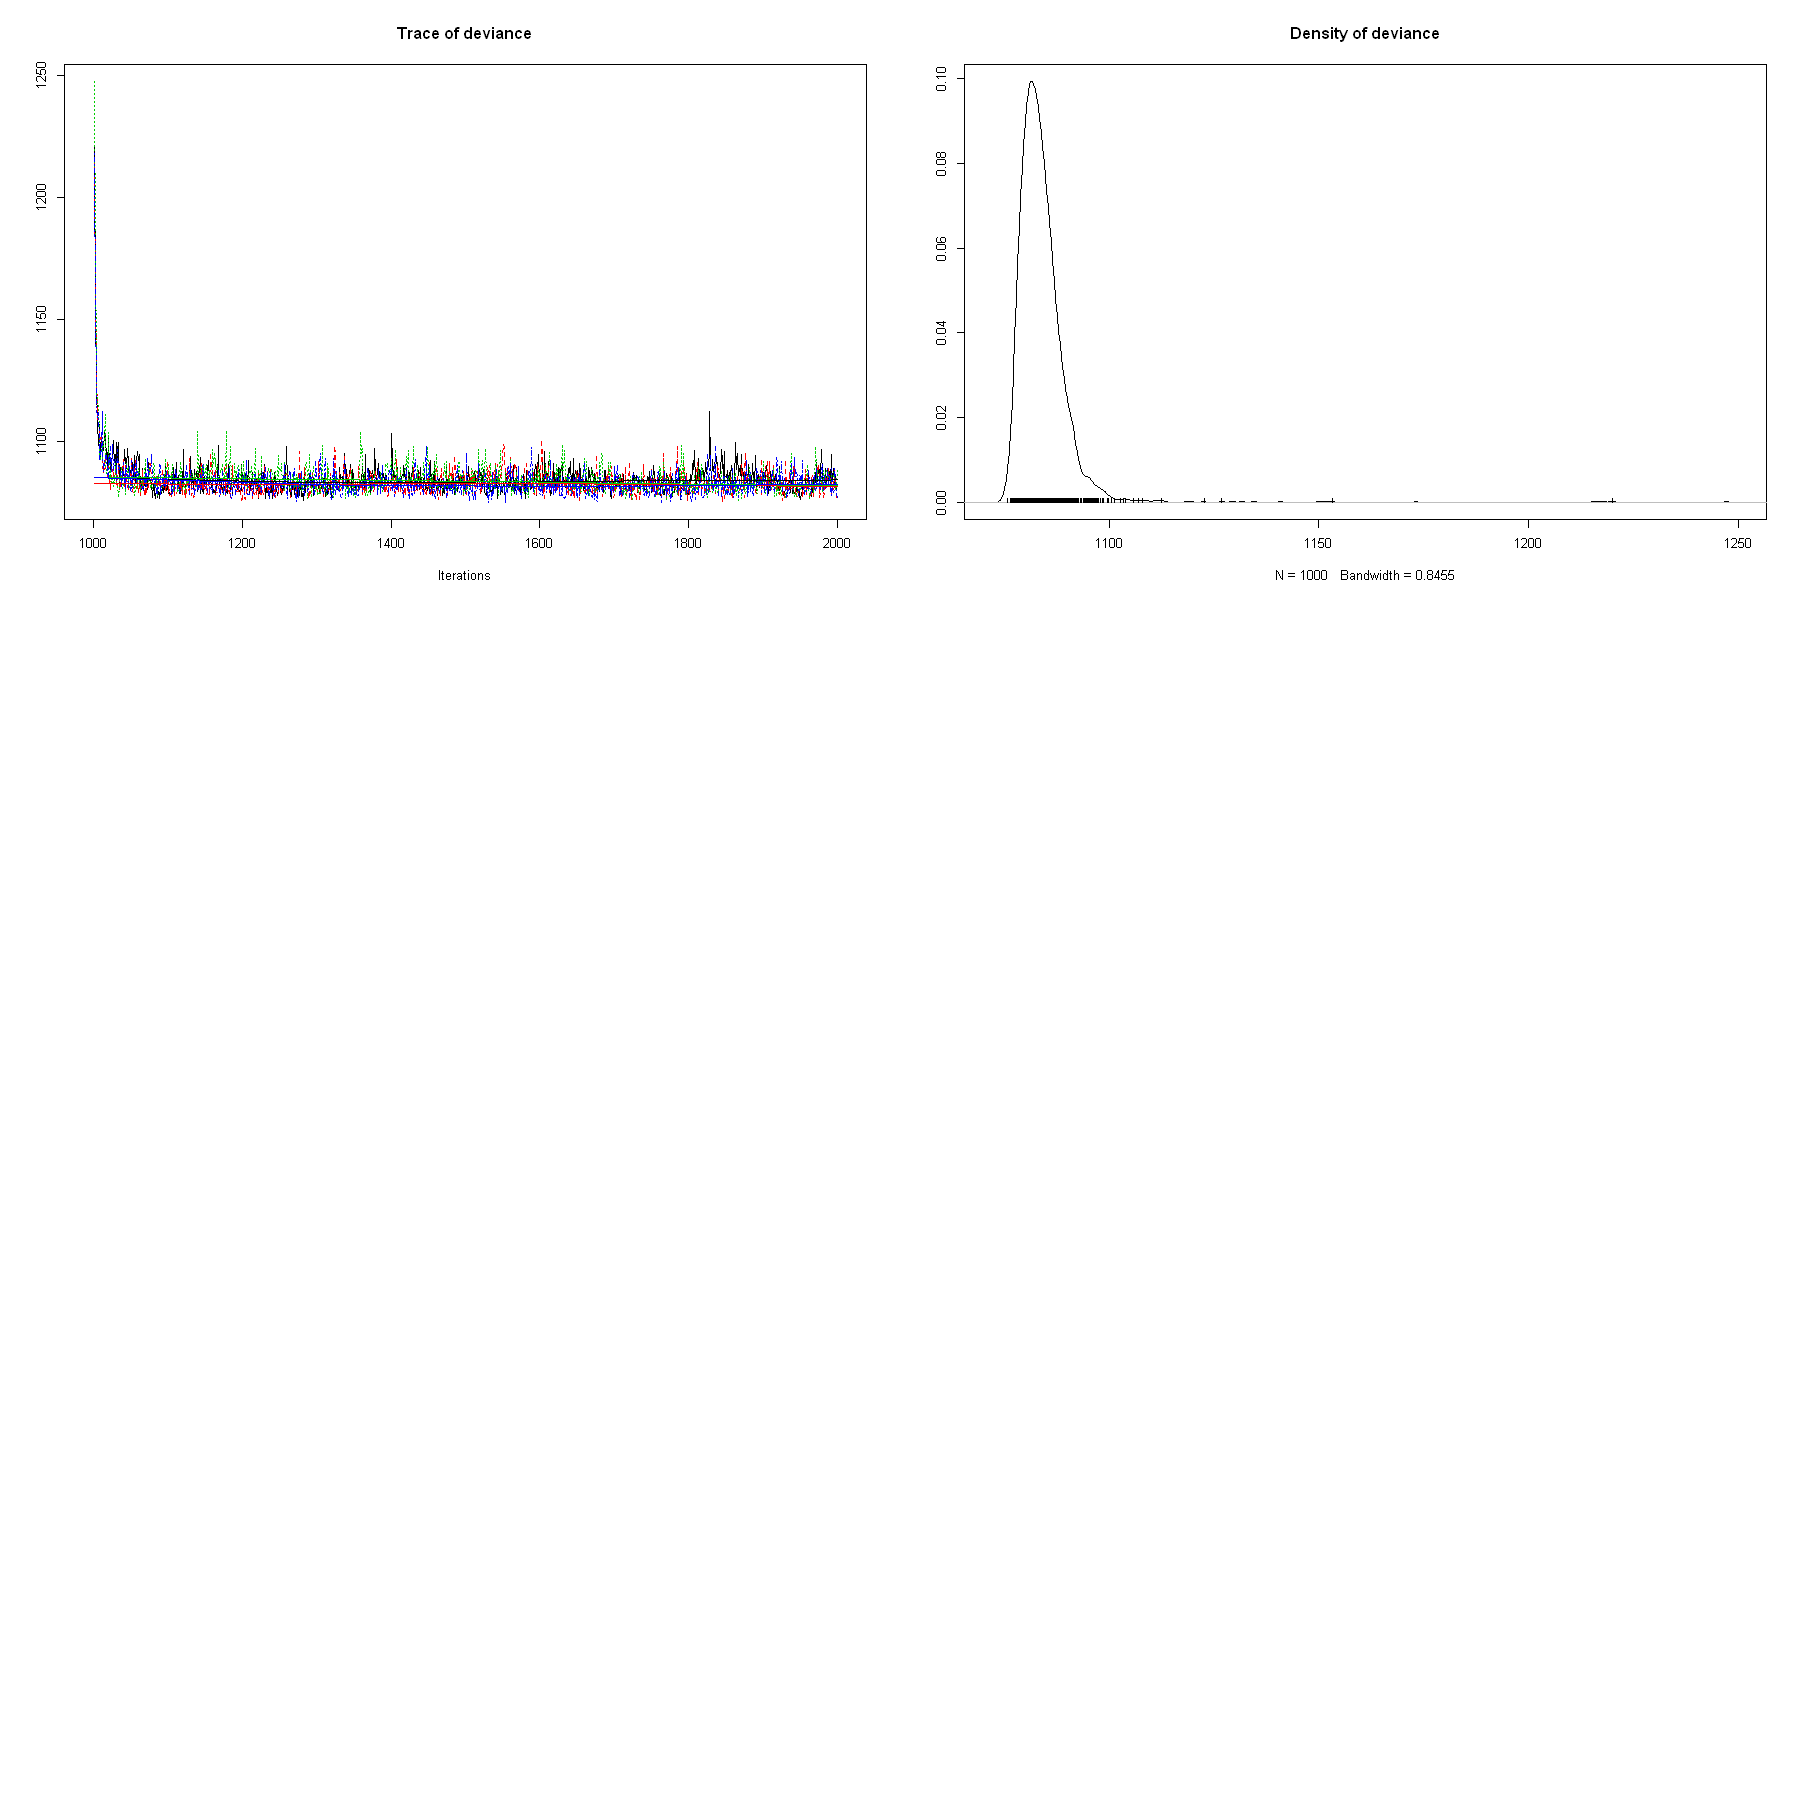

In [287]:
out.mcmc <- as.mcmc(jags_model)
plot(out.mcmc)

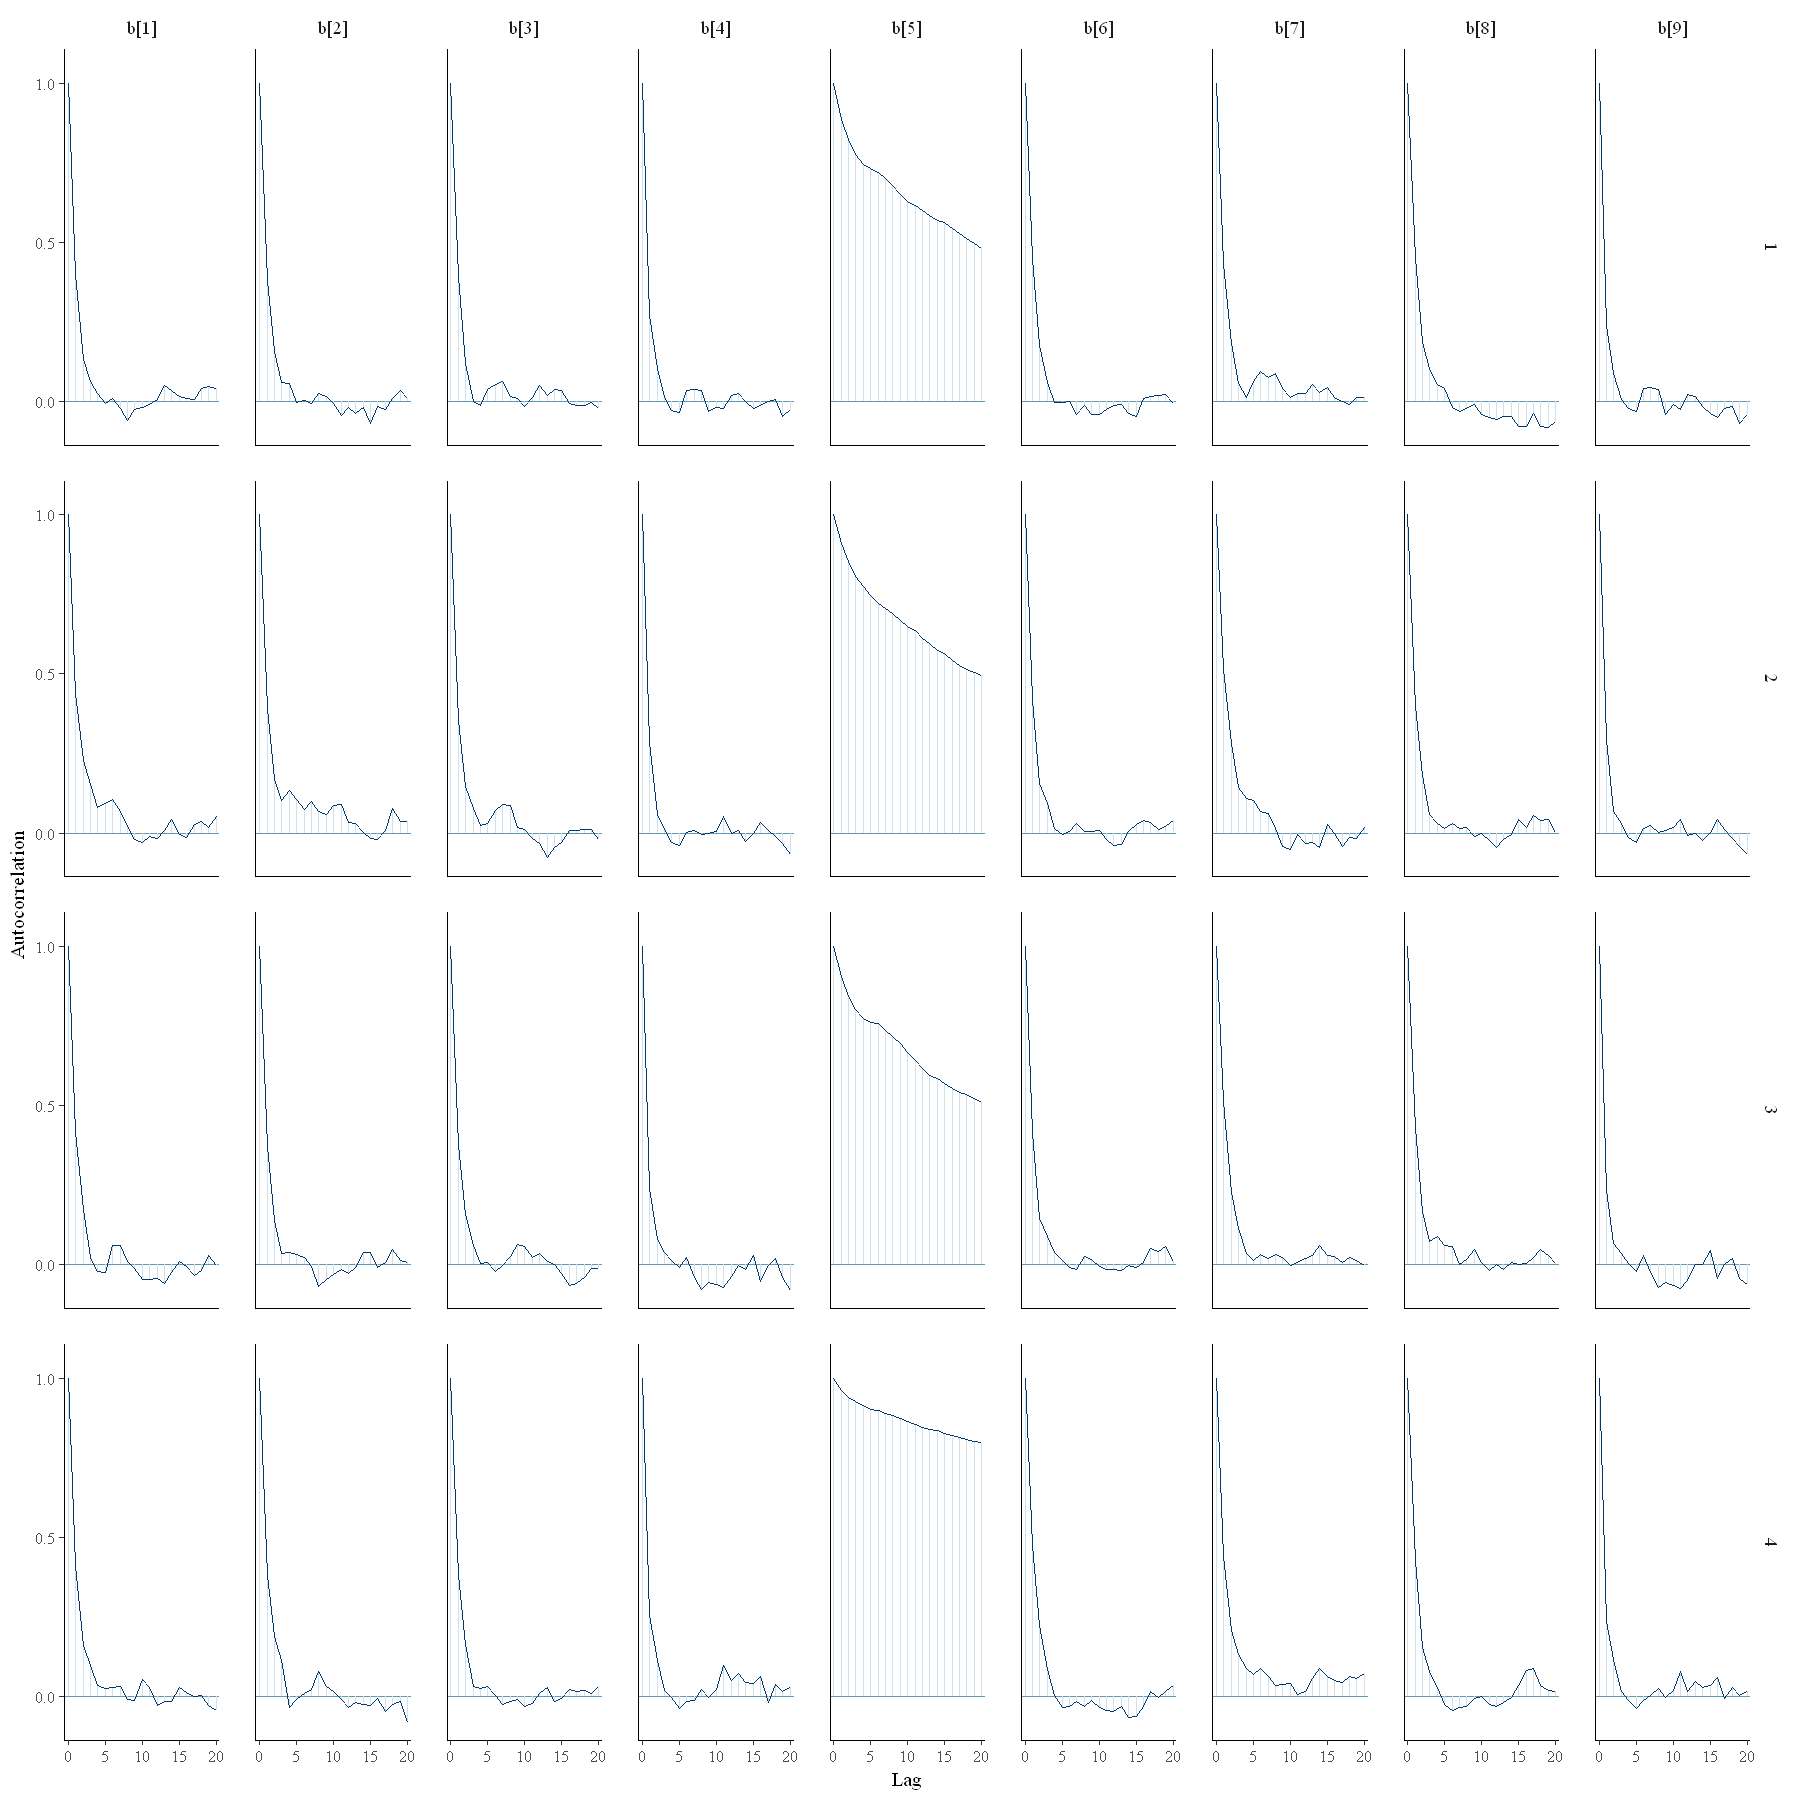

In [288]:
options(repr.plot.width=15,repr.plot.height=15)
mcmc_acf(out.mcmc,pars=vars(contains("b")))

We'll use the package ``BayesPostEst`` to check the performance

In [28]:
#install.packages("BayesPostEst")
library("BayesPostEst")

### Posterior distributions 

Let's summarize the posterior distributions of all parameters, looking at their median, standard deviation and 95% CI:

In [29]:
mcmcTab(jags_model)

Variable Median   SD    Lower    Upper   
1  b[1]        0.220 0.076    0.075    0.369
2  b[2]        0.159 0.150   -0.129    0.452
3  b[3]       -0.363 0.108   -0.573   -0.155
4  b[4]       -0.177 1.812   -3.483    3.519
5  b[5]       -5.388 1.270   -8.457   -3.356
6  b[6]        1.087 0.204    0.689    1.492
7  b[7]        2.245 0.378    1.562    3.046
8  b[8]       -0.039 0.077   -0.190    0.115
9  b[9]       -1.992 1.799   -5.832    1.270
10 deviance 1082.888 7.156 1077.201 1095.747

### Predicted Probabilities

Meaning the relationships between coviariates and our target variable of interest: Response. Let's start by building a matrix of the posterior coefficients:

In [62]:
matrix_jags <- as.matrix(coda::as.mcmc(jags_model))
mm.jags <- model.matrix(Response ~ Gender + Age + Driving_License + Previously_Insured + 
                         Vehicle_Age + Vehicle_Damage + Annual_Premium + Vintage,
                   data = df)

#### First differences

First differences are a method to summarize effects across covariates. This quantity represents the difference in predicted probabilities for each covariate for cases with low and high values of the respective covariate. For each of these differences, all other variables are held constant at their median.

The ``mcmcFD`` function allows to get this table of median and credible intervals of the summary of this first differences.

In [63]:
first_difference.jags <- mcmcFD(modelmatrix = mm.jags,
                  mcmcout = matrix_jags[, 1:ncol(mm.jags)],
                  link = "logit",
                  ci = c(0.025, 0.975),
                  fullsims = FALSE)

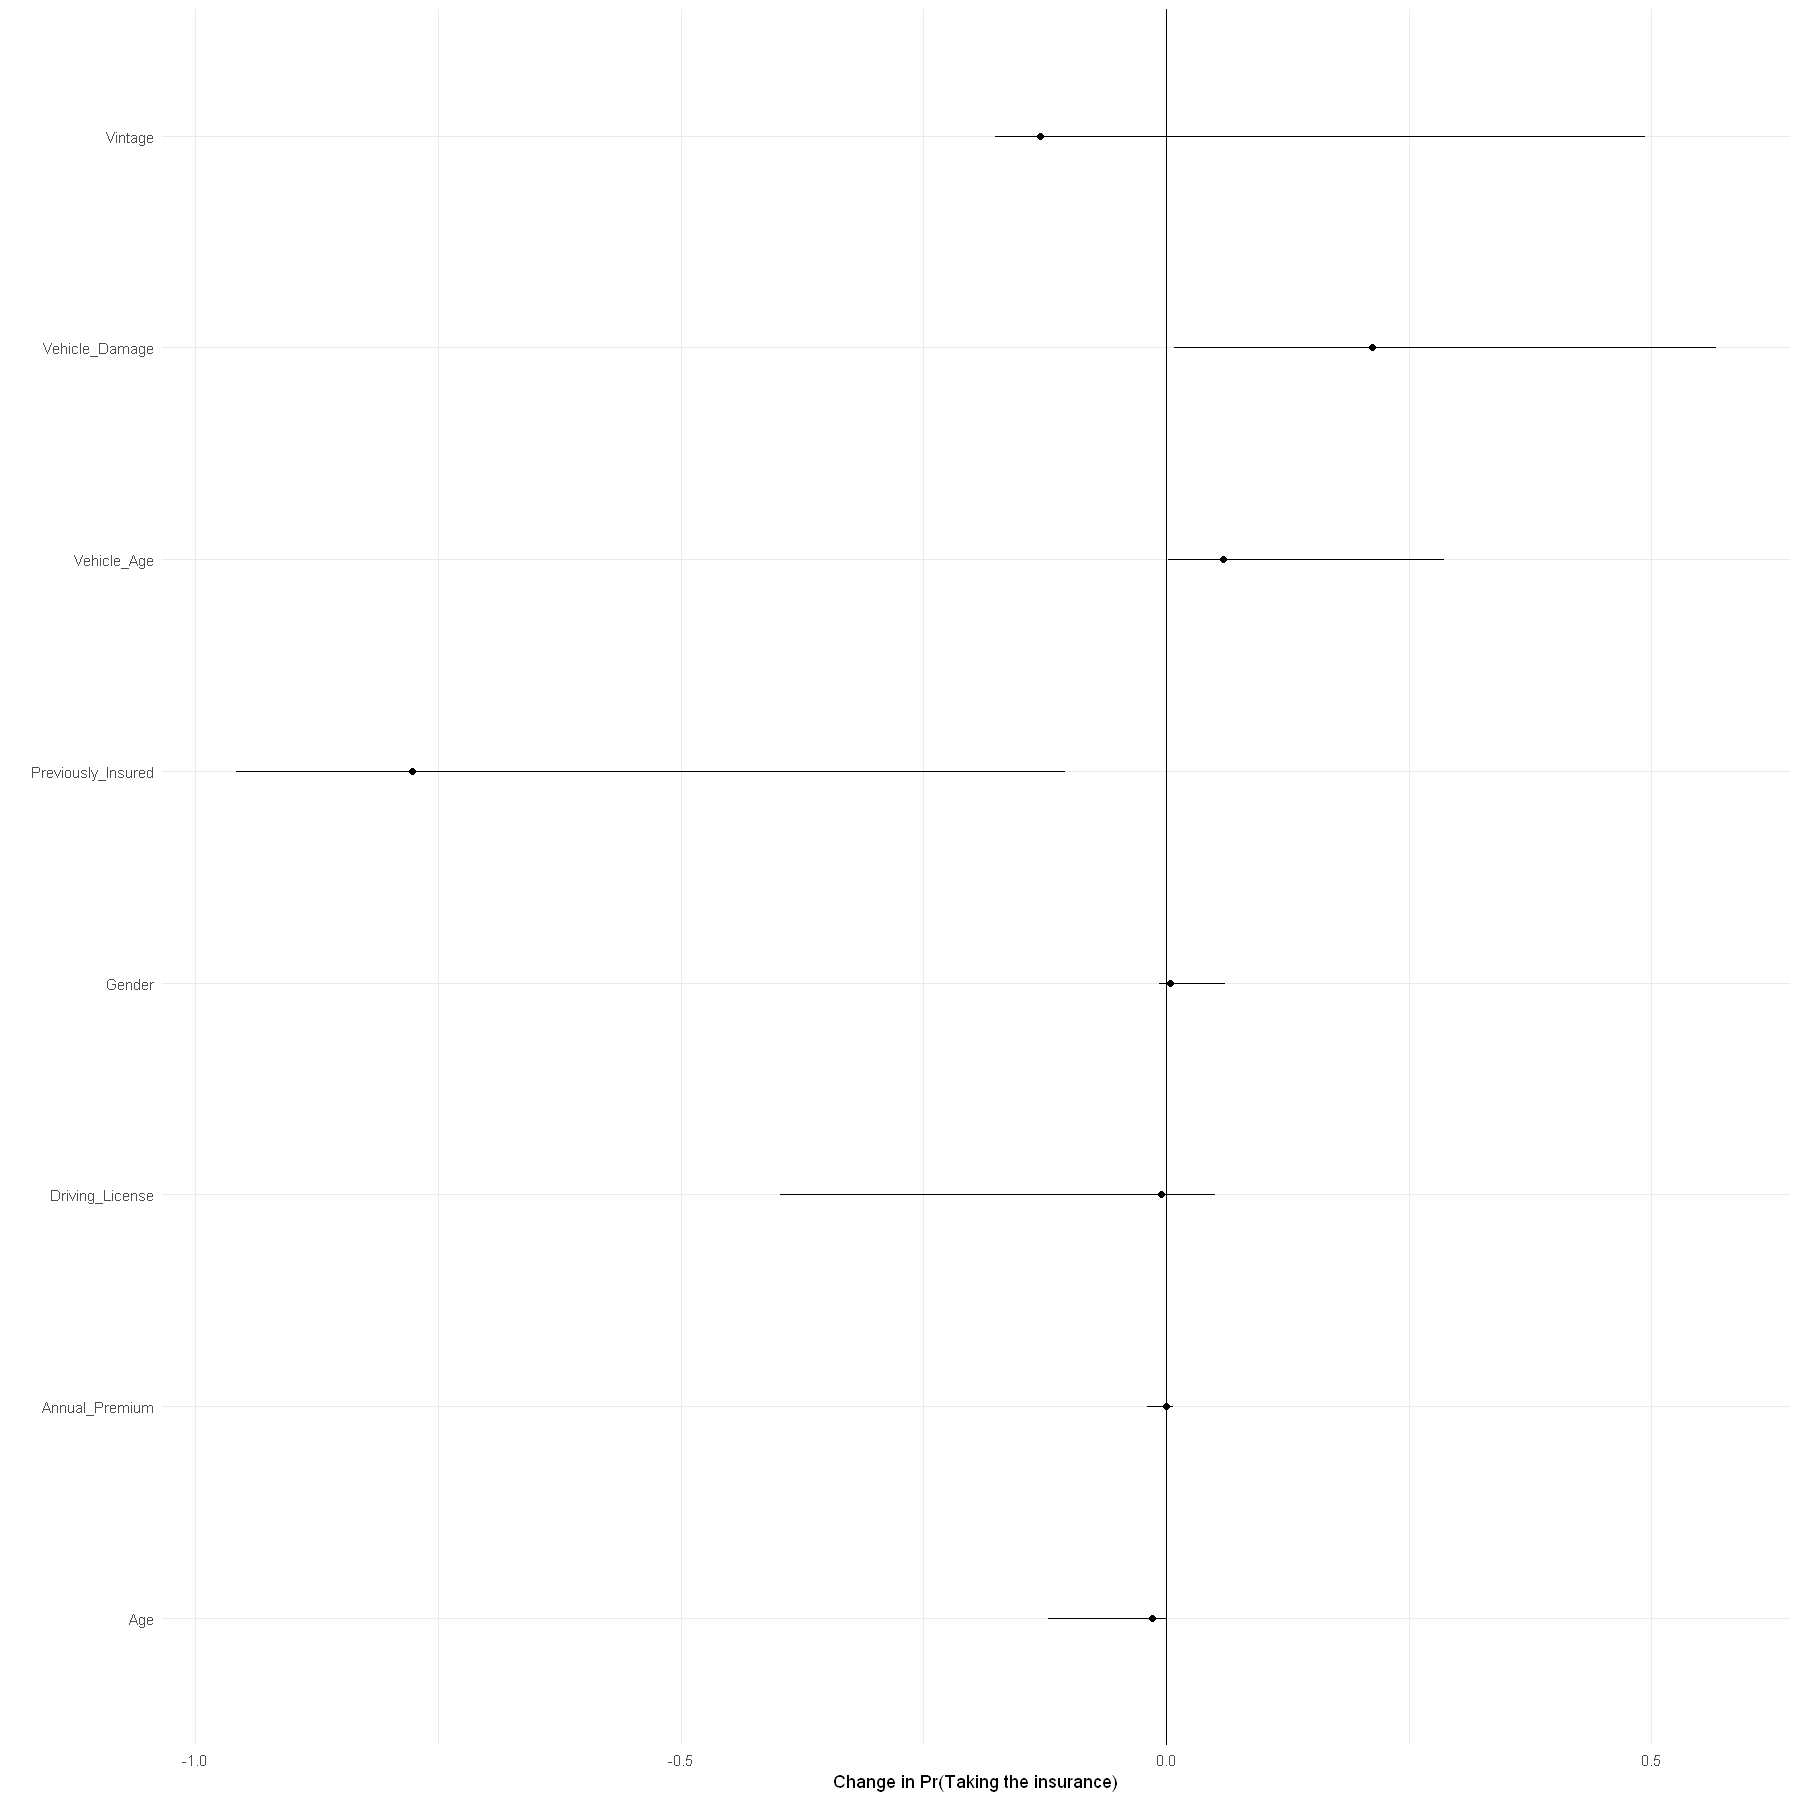

In [64]:
ggplot(data = first_difference.jags, 
       aes(x = median_fd, y = VarName)) + 
  geom_point() + 
  geom_segment(aes(x = lower_fd, xend = upper_fd, yend = VarName)) + 
  geom_vline(xintercept = 0) + 
  xlab("Change in Pr(Taking the insurance)") + 
  ylab("") +
  theme_minimal()

We can see that the variablest that affect the most our target variable of interest Response are Previously_Insured and Vehicle_Damage, with a huge CI. Overall, we cannot extract much information about which variables decide the most our predictions. 

The same plot below but with the posterior distribution shows us the same:

In [65]:
posterior_diff.jags <- mcmcFD(modelmatrix = mm.jags,
                  mcmcout = matrix_jags[, 1:ncol(mm.jags)],
                  link = "logit",
                  ci = c(0.025, 0.975),
                  fullsims = TRUE)

Picking joint bandwidth of 1.25



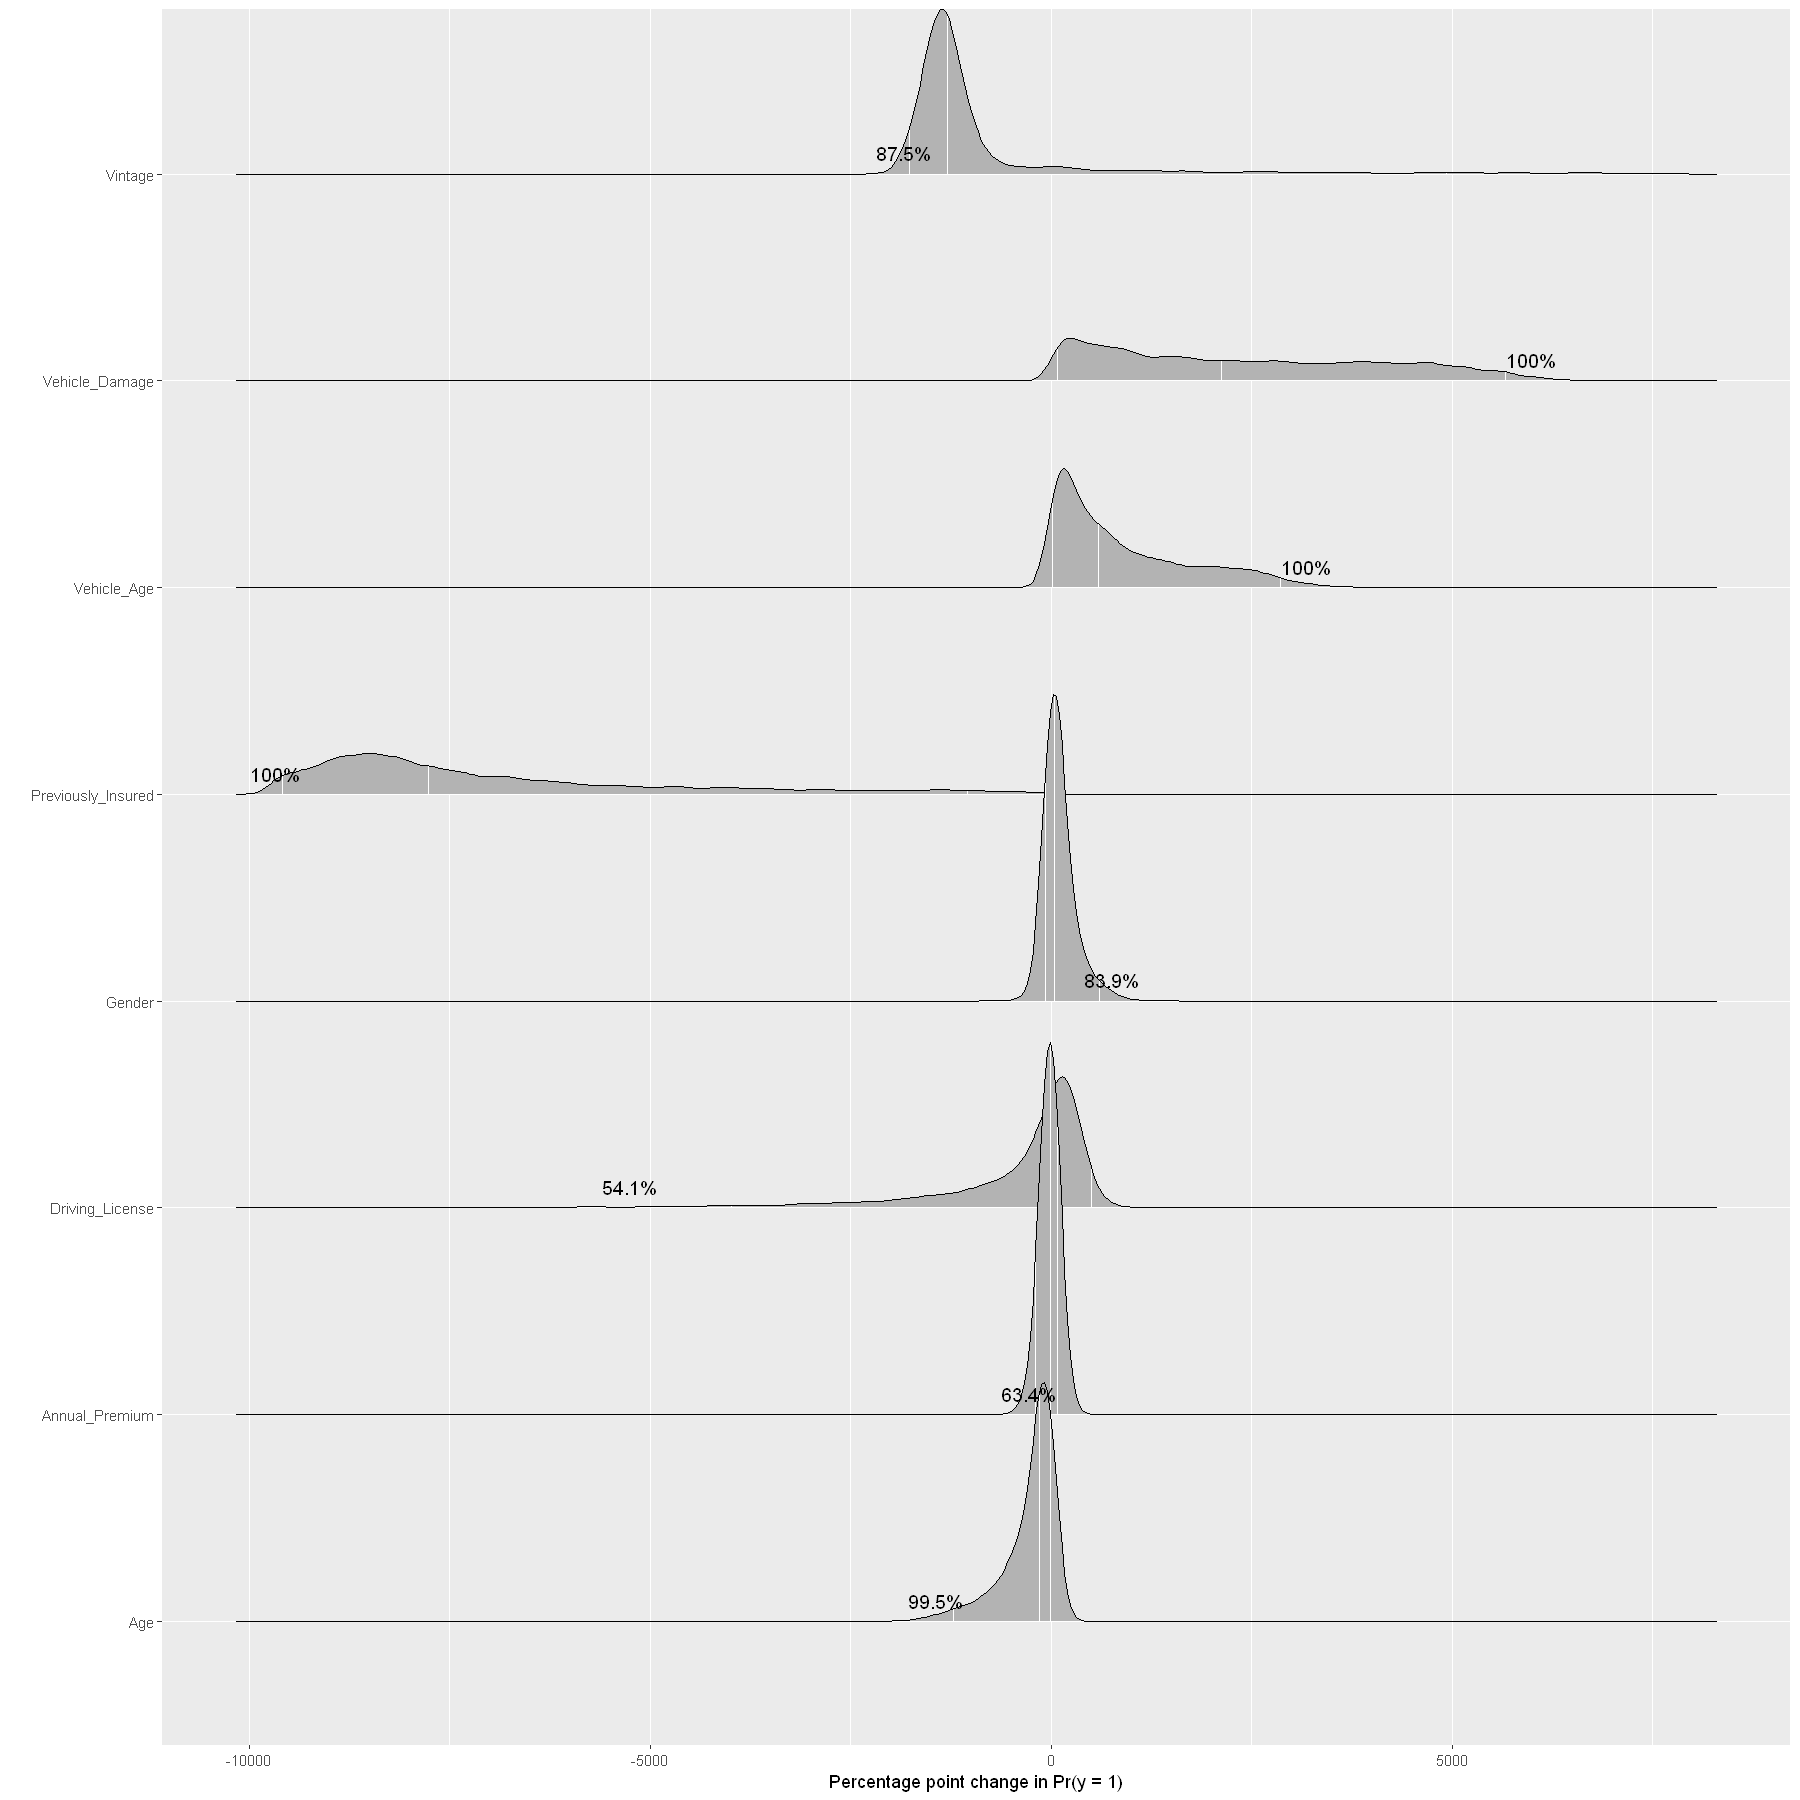

In [66]:
plot(posterior_diff.jags, ROPE = c(-0.01, 0.01))

#### Area Under the ROC Curve

The function ``mcmcRocPrc`` allows us to compute this metric as well as the Area Under the Precision-Recall Curve (PRC):

In [67]:
accuracies.jags <- mcmcRocPrc(object = jags_model,
                       data=dfCombined,
                       yname  = "Response",
                       xnames = c('Gender','Age','Driving_License','Previously_Insured','Vehicle_Age',
                                  'Vehicle_Damage','Annual_Premium','Vintage'),
                       curves = TRUE,
                       fullsims = FALSE)

In [68]:
accuracies.jags$area_under_roc

V1 
0.8266041

In [69]:
accuracies.jags$area_under_prc

V1 
0.7474185

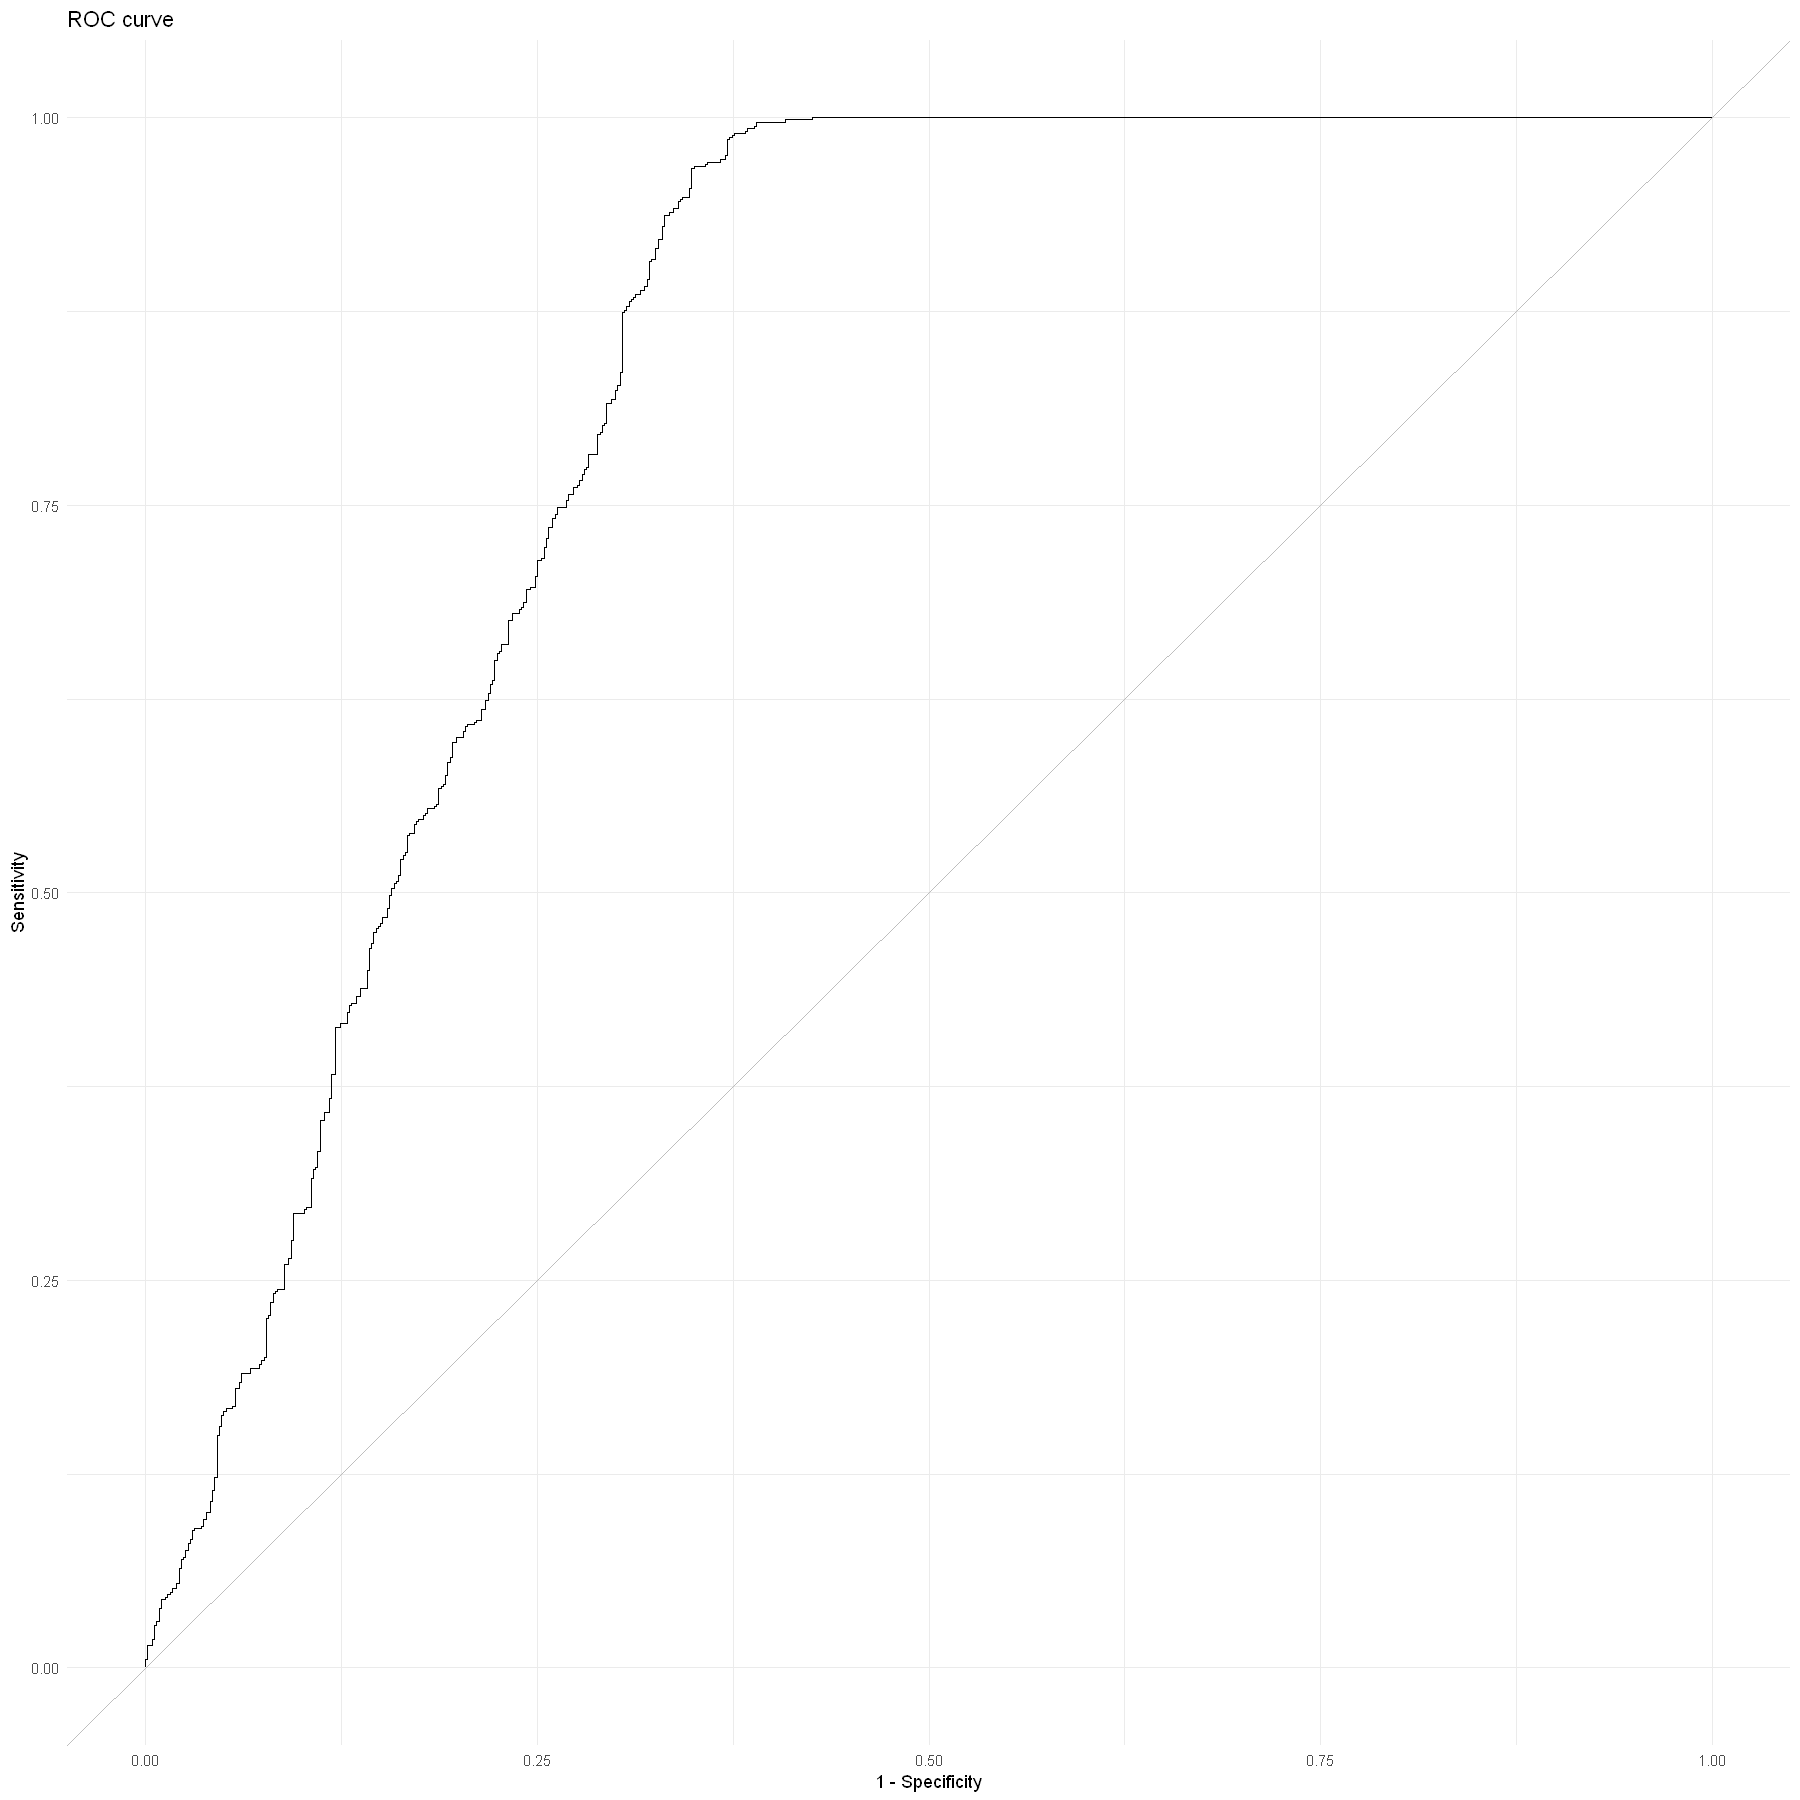

In [70]:
ggplot(data = as.data.frame(accuracies.jags, what = "roc"), aes(x = x, y = y)) +
  geom_line() + 
  geom_abline(intercept = 0, slope = 1, color = "gray") + 
  labs(title = "ROC curve") + 
  xlab("1 - Specificity") + 
  ylab("Sensitivity") +
  theme_minimal()

Warning message:
"Removed 1 row(s) containing missing values (geom_path)."


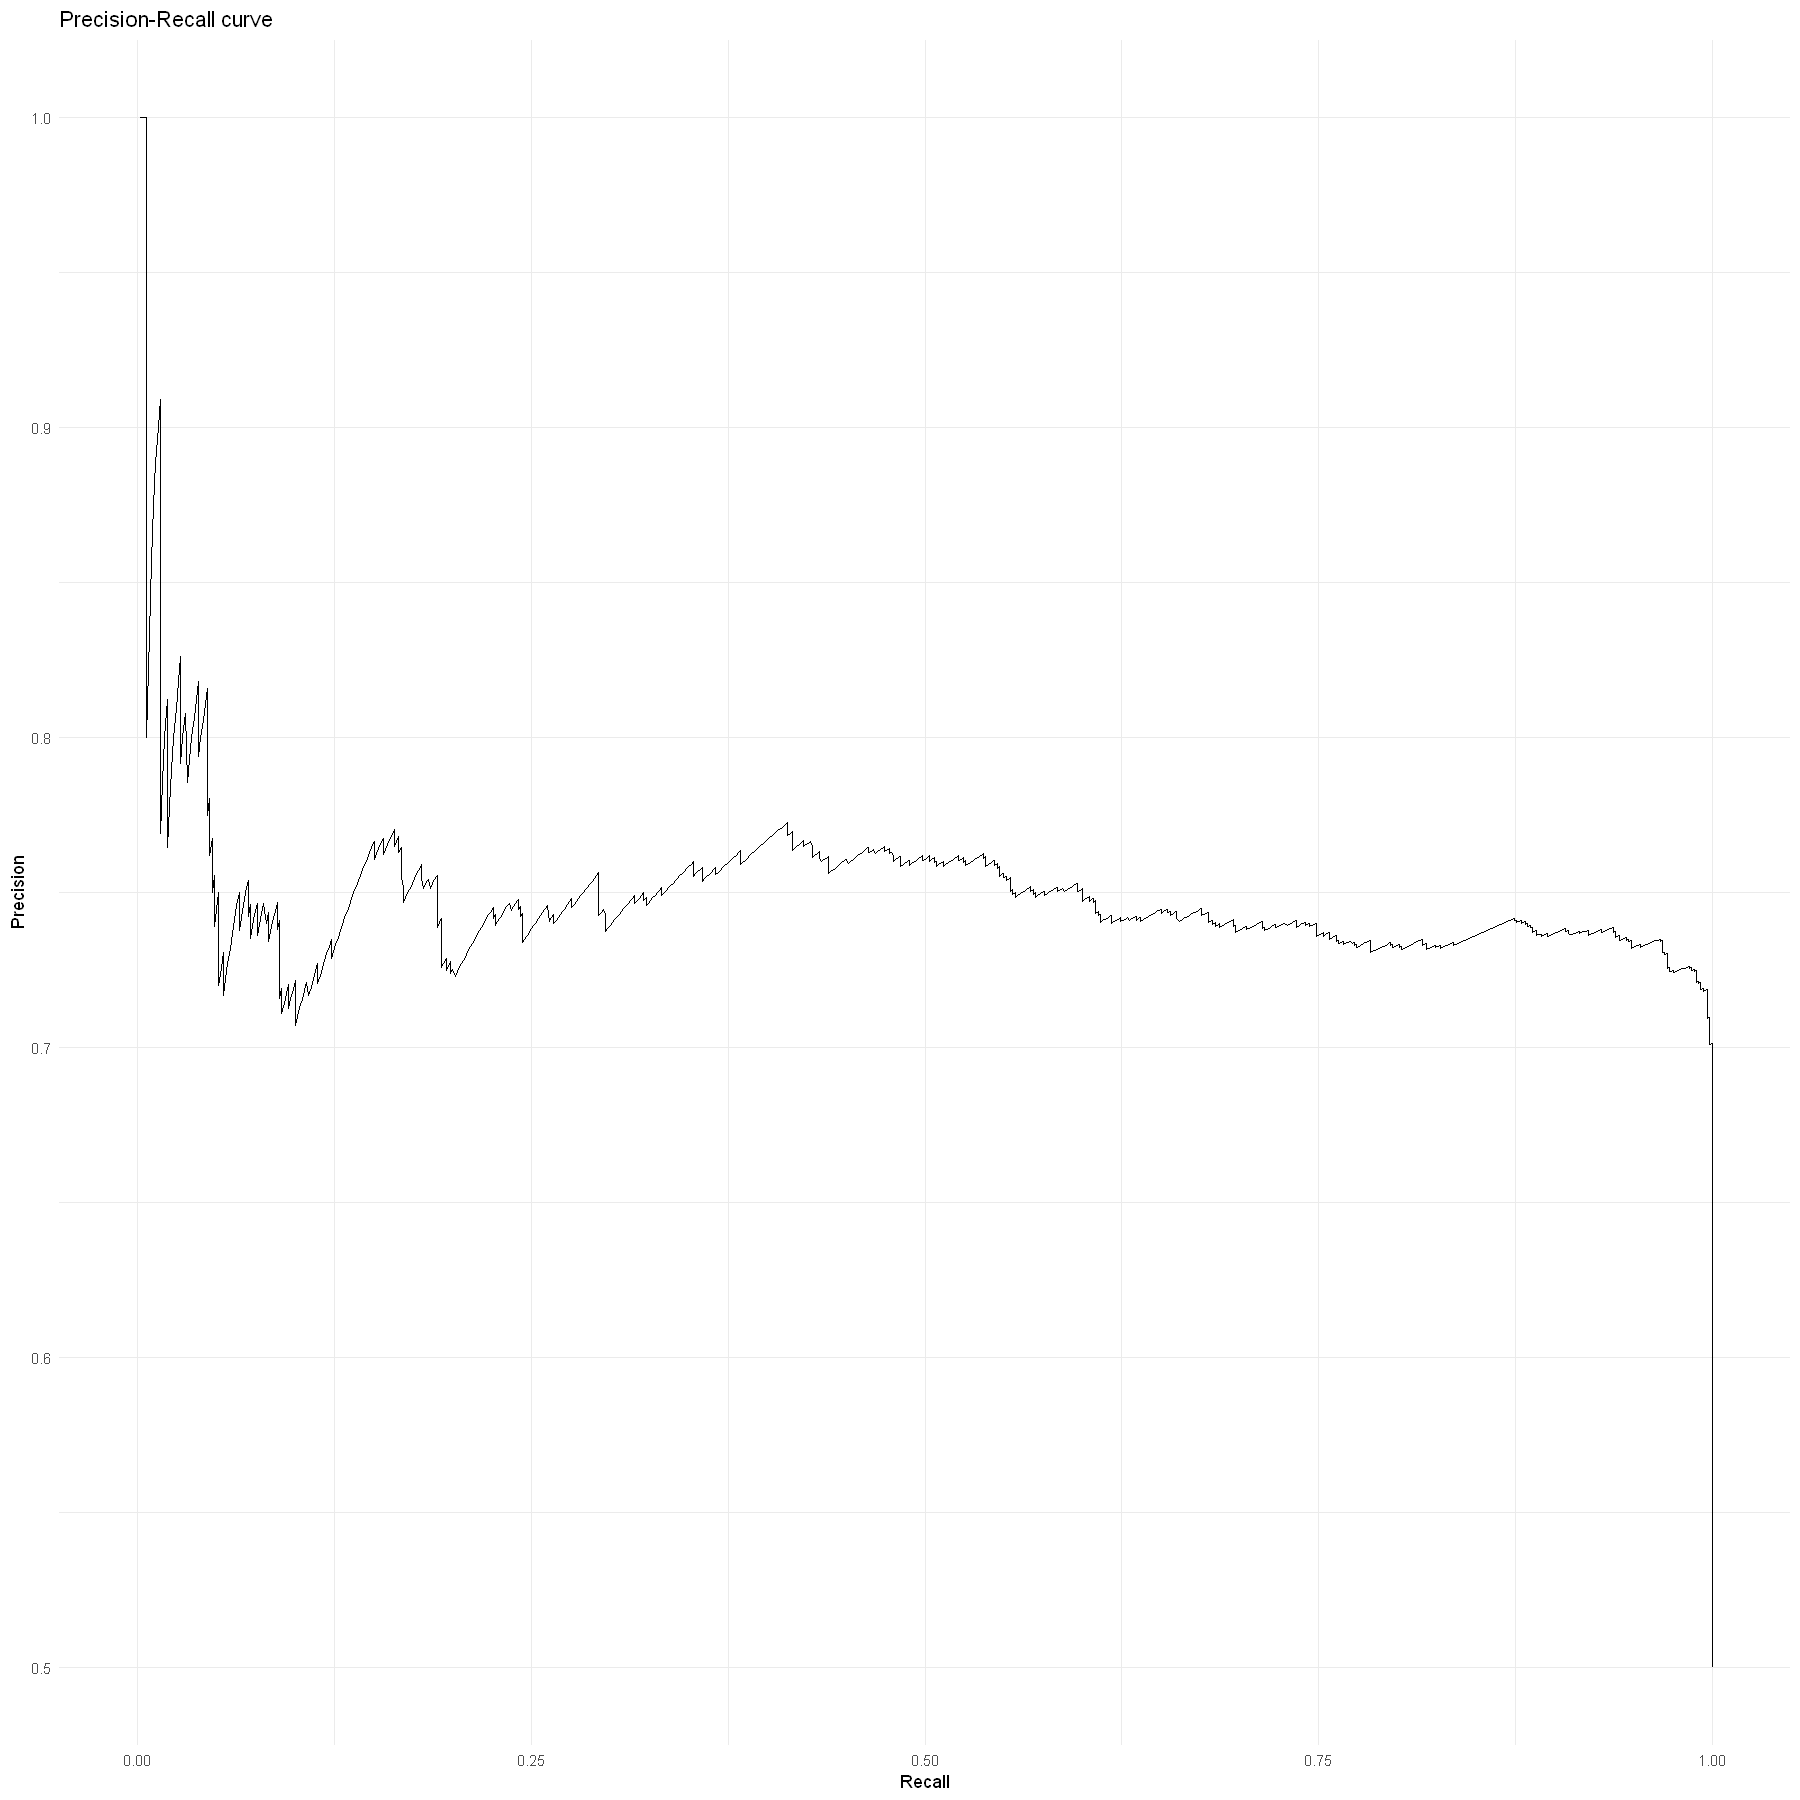

In [71]:
ggplot(data = as.data.frame(accuracies.jags, what = "prc"), aes(x = x, y = y)) +
  geom_line() + 
  labs(title = "Precision-Recall curve") + 
  xlab("Recall") + 
  ylab("Precision") +
  theme_minimal()

We can also plot the Posterior Density of the Area Under each type of Curve setting ``fullsims`` to True:

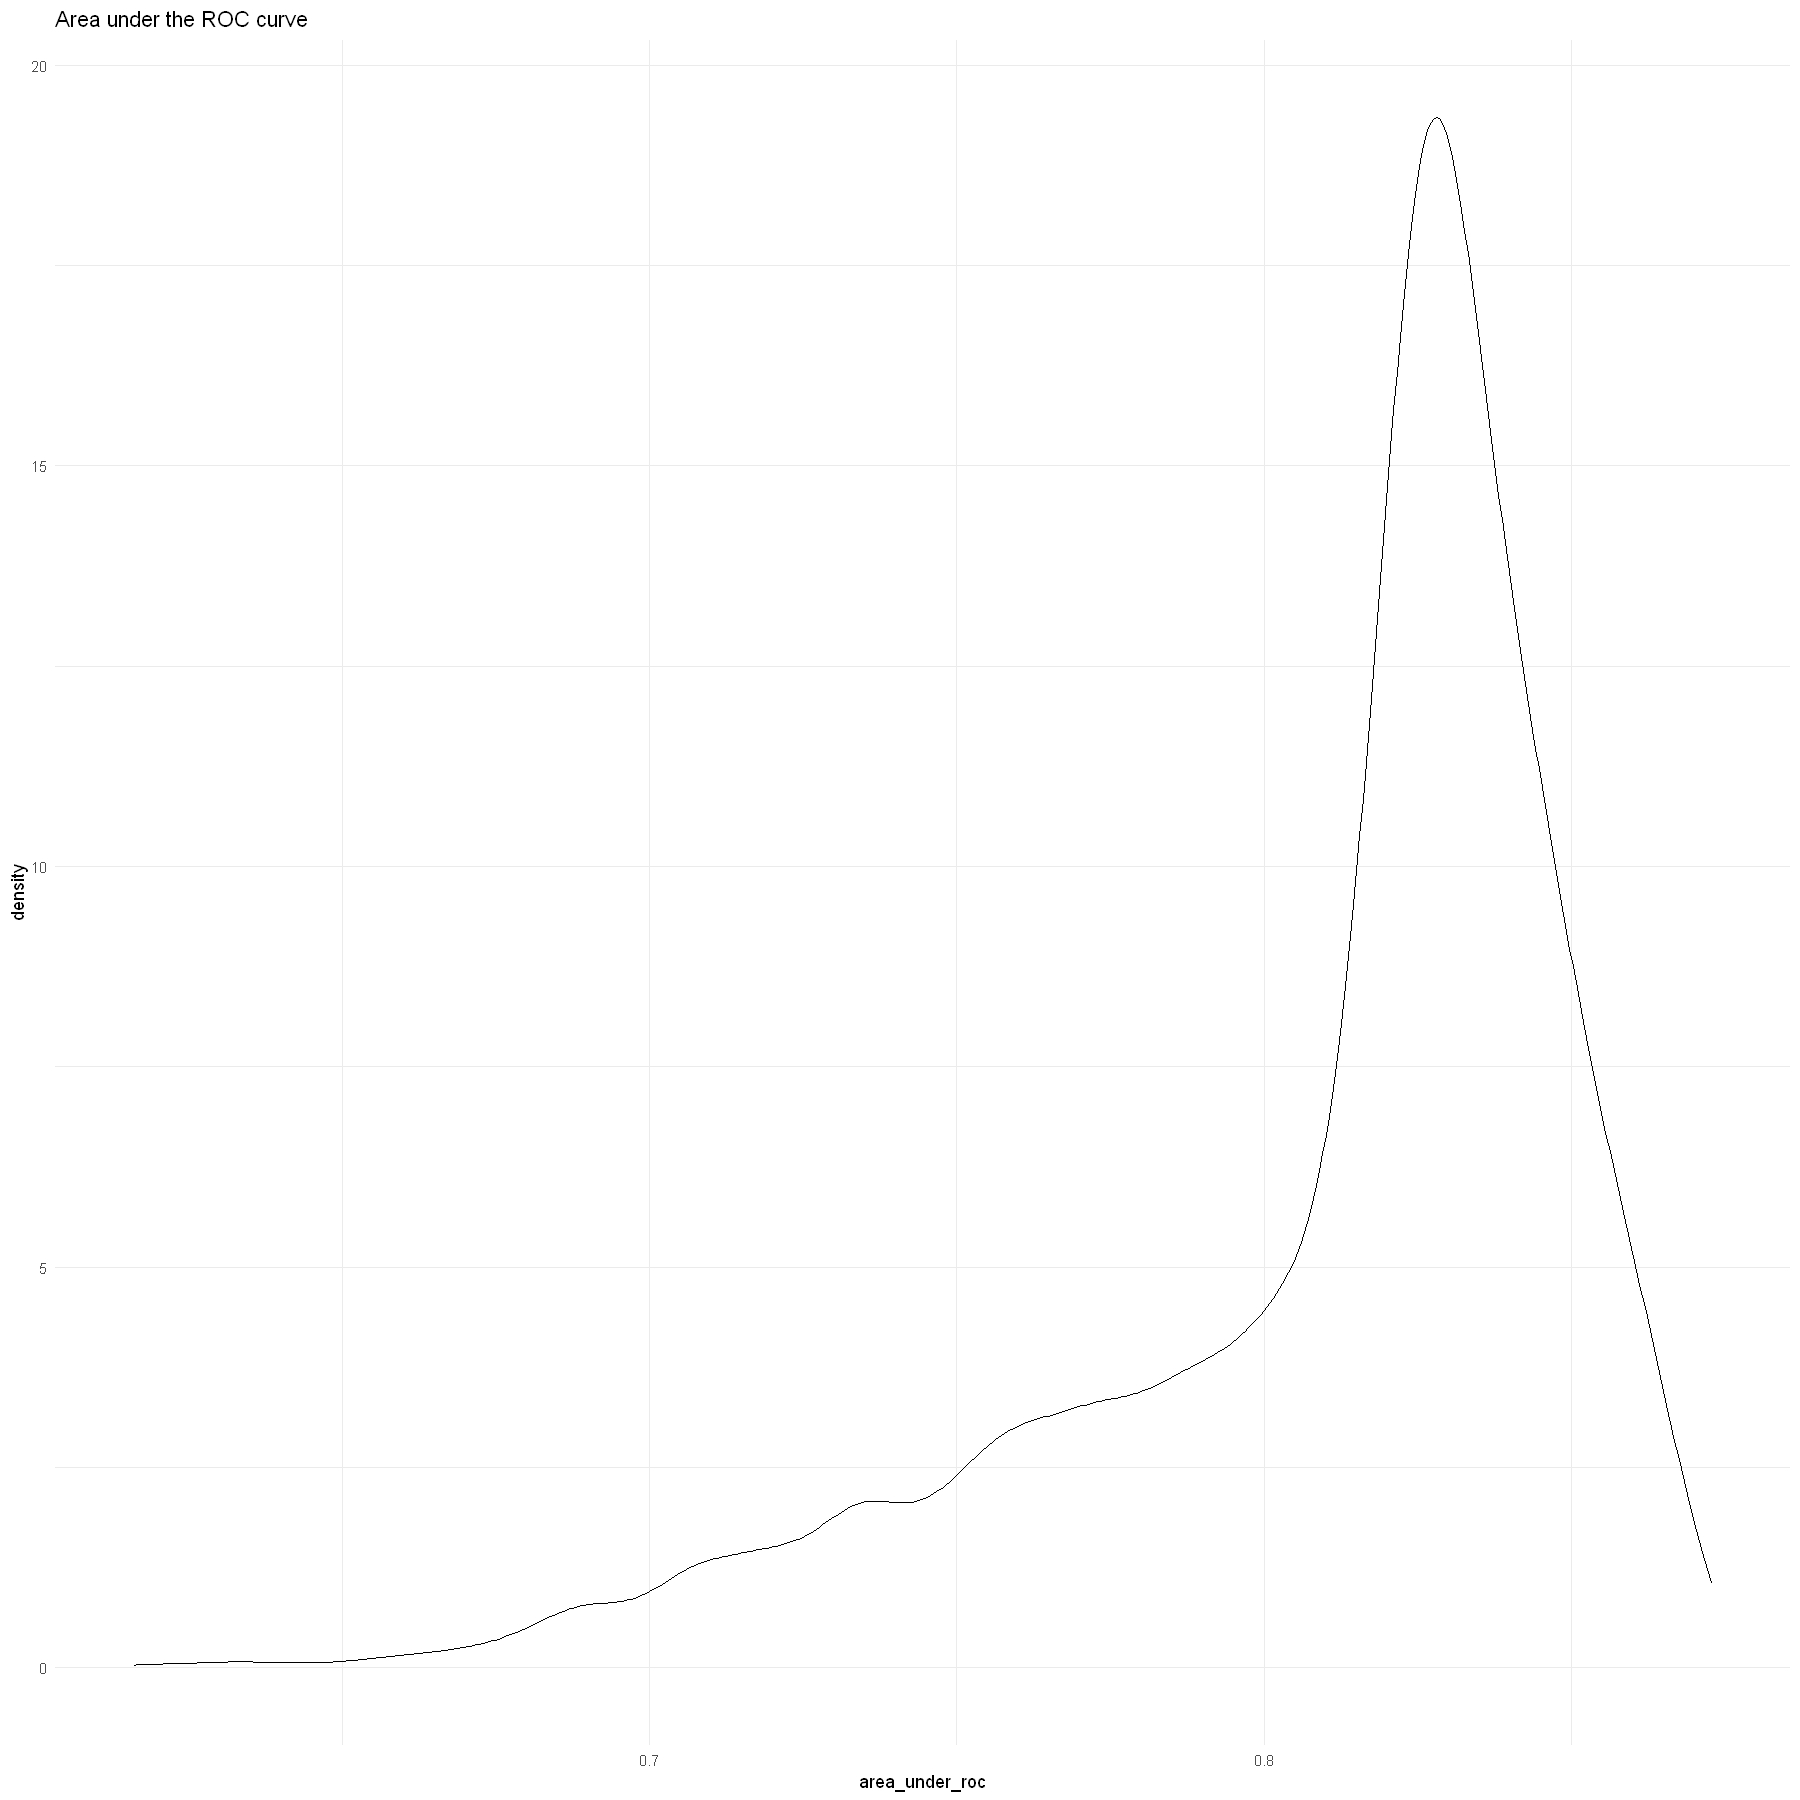

In [72]:
accuracies.jags.full <- mcmcRocPrc(object = jags_model,
                        data = dfCombined,
                        yname  = "Response",
                        xnames = c('Gender','Age','Driving_License','Previously_Insured','Vehicle_Age',
                                  'Vehicle_Damage','Annual_Premium','Vintage'),
                        curves = FALSE,
                        fullsims = TRUE)

ggplot(as.data.frame(accuracies.jags.full), 
       aes(x = area_under_roc)) +
  geom_density() +
  labs(title = "Area under the ROC curve") +
  theme_minimal()

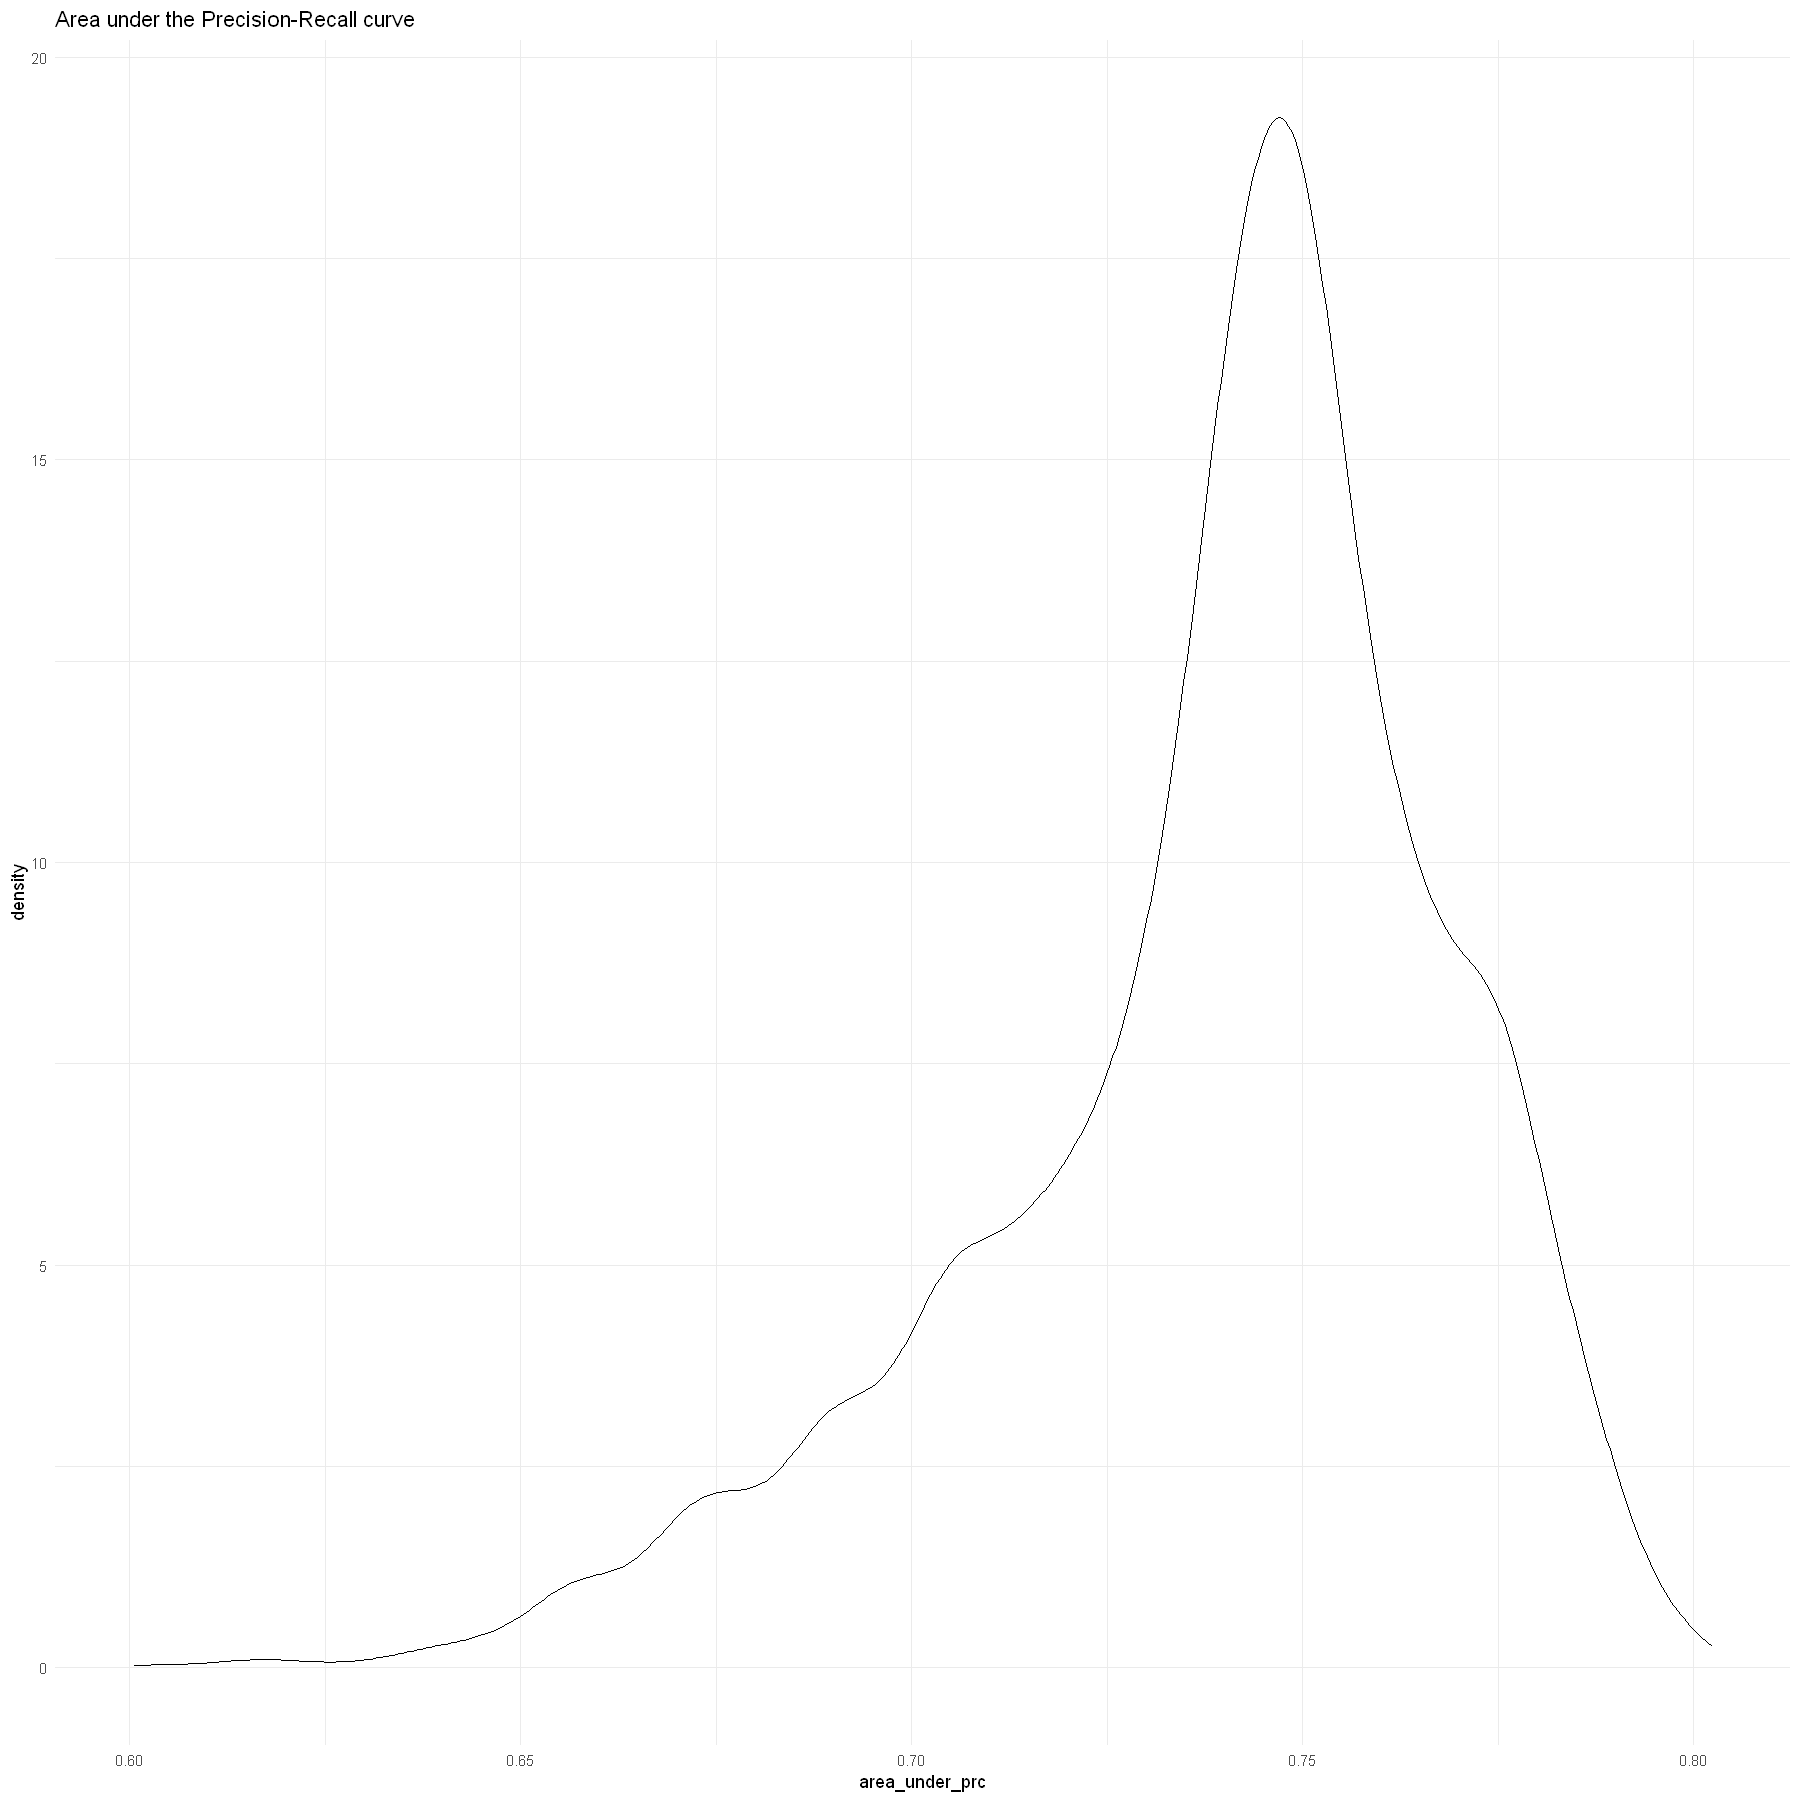

In [73]:
ggplot(as.data.frame(accuracies.jags.full), 
       aes(x = area_under_prc)) +
  geom_density() +
  labs(title = "Area under the Precision-Recall curve") +
  theme_minimal()

### Introducing second order terms

We reformulate the JAGS model including quadratic terms and interactions between variables. In order to obtain meaningful results, we let the model run longer. The initial results are not much better, because the model struggles to optimise so many parameters at the same time, but it allows us to subselect variables.

In [199]:
length(colnames(df2))

[1] 45

In [207]:
variables <- c('Gender','Age','Driving_License','Previously_Insured','Vehicle_Age','Vehicle_Damage',
                             'Annual_Premium','Vintage','Response')

df2<-data.frame(df[, c('Gender','Age','Driving_License','Previously_Insured','Vehicle_Age','Vehicle_Damage',
                             'Annual_Premium','Vintage','Response')])
for (i in 1:(length(variables)-1)){
    for (j in 1:i){
        str<-paste(variables[i], variables[j], sep = "X")
        df2[str] <- df[variables[i]]*df[variables[j]]
    }
}

dfCombined2 <- as.list(df2)
dfCombined2$nrows <- nrow(df2)
col<-colnames(df2)

str<-paste("b[",9,"]", sep="")

for (i in 1:(length(colnames(df2)))){
    if(col[i]!="Response")
        str<-paste(str," + b[",i,"] * ",col[i],"[i]", sep="")
}

str

[1] "b[9] + b[1] * Gender[i] + b[2] * Age[i] + b[3] * Driving_License[i] + b[4] * Previously_Insured[i] + b[5] * Vehicle_Age[i] + b[6] * Vehicle_Damage[i] + b[7] * Annual_Premium[i] + b[8] * Vintage[i] + b[10] * GenderXGender[i] + b[11] * AgeXGender[i] + b[12] * AgeXAge[i] + b[13] * Driving_LicenseXGender[i] + b[14] * Driving_LicenseXAge[i] + b[15] * Driving_LicenseXDriving_License[i] + b[16] * Previously_InsuredXGender[i] + b[17] * Previously_InsuredXAge[i] + b[18] * Previously_InsuredXDriving_License[i] + b[19] * Previously_InsuredXPreviously_Insured[i] + b[20] * Vehicle_AgeXGender[i] + b[21] * Vehicle_AgeXAge[i] + b[22] * Vehicle_AgeXDriving_License[i] + b[23] * Vehicle_AgeXPreviously_Insured[i] + b[24] * Vehicle_AgeXVehicle_Age[i] + b[25] * Vehicle_DamageXGender[i] + b[26] * Vehicle_DamageXAge[i] + b[27] * Vehicle_DamageXDriving_License[i] + b[28] * Vehicle_DamageXPreviously_Insured[i] + b[29] * Vehicle_DamageXVehicle_Age[i] + b[30] * Vehicle_DamageXVehicle_Damage[i] + b[31] * Annual_PremiumXGender[i] + b[32] * Annual_PremiumXAge[i] + b[33] * Annual_PremiumXDriving_License[i] + b[34] * Annual_PremiumXPreviously_Insured[i] + b[35] * Annual_PremiumXVehicle_Age[i] + b[36] * Annual_PremiumXVehicle_Damage[i] + b[37] * Annual_PremiumXAnnual_Premium[i] + b[38] * VintageXGender[i] + b[39] * VintageXAge[i] + b[40] * VintageXDriving_License[i] + b[41] * VintageXPreviously_Insured[i] + b[42] * VintageXVehicle_Age[i] + b[43] * VintageXVehicle_Damage[i] + b[44] * VintageXAnnual_Premium[i] + b[45] * VintageXVintage[i]"

In [257]:
mod2.jags <- paste(" 
model {
for (i in 1:nrows){
  Response[i] ~ dbern(p[i])  
  logit(p[i]) <- mu[i]   
  mu[i] <-" ,str,"
}
for(j in 1:46){
  b[j] ~ dnorm(0, 0.1)
  }

}
")
writeLines(mod2.jags, "mod2.jags")    

In [258]:
params.jags2 <- c("b")
inits1.jags2 <- list("b" = rep(0, 46))
inits.jags2 <- list(inits1.jags2,inits1.jags2,inits1.jags2,inits1.jags2)

In [259]:
library("R2jags")
set.seed(123)

jags_model2 <- jags(data = dfCombined2, inits = inits.jags2, 
  parameters.to.save = params.jags2, n.chains = 4, n.iter = 4000, 
  n.burnin = 2000, model.file = "mod2.jags")

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 1400
   Unobserved stochastic nodes: 46
   Total graph size: 78094

Initializing model



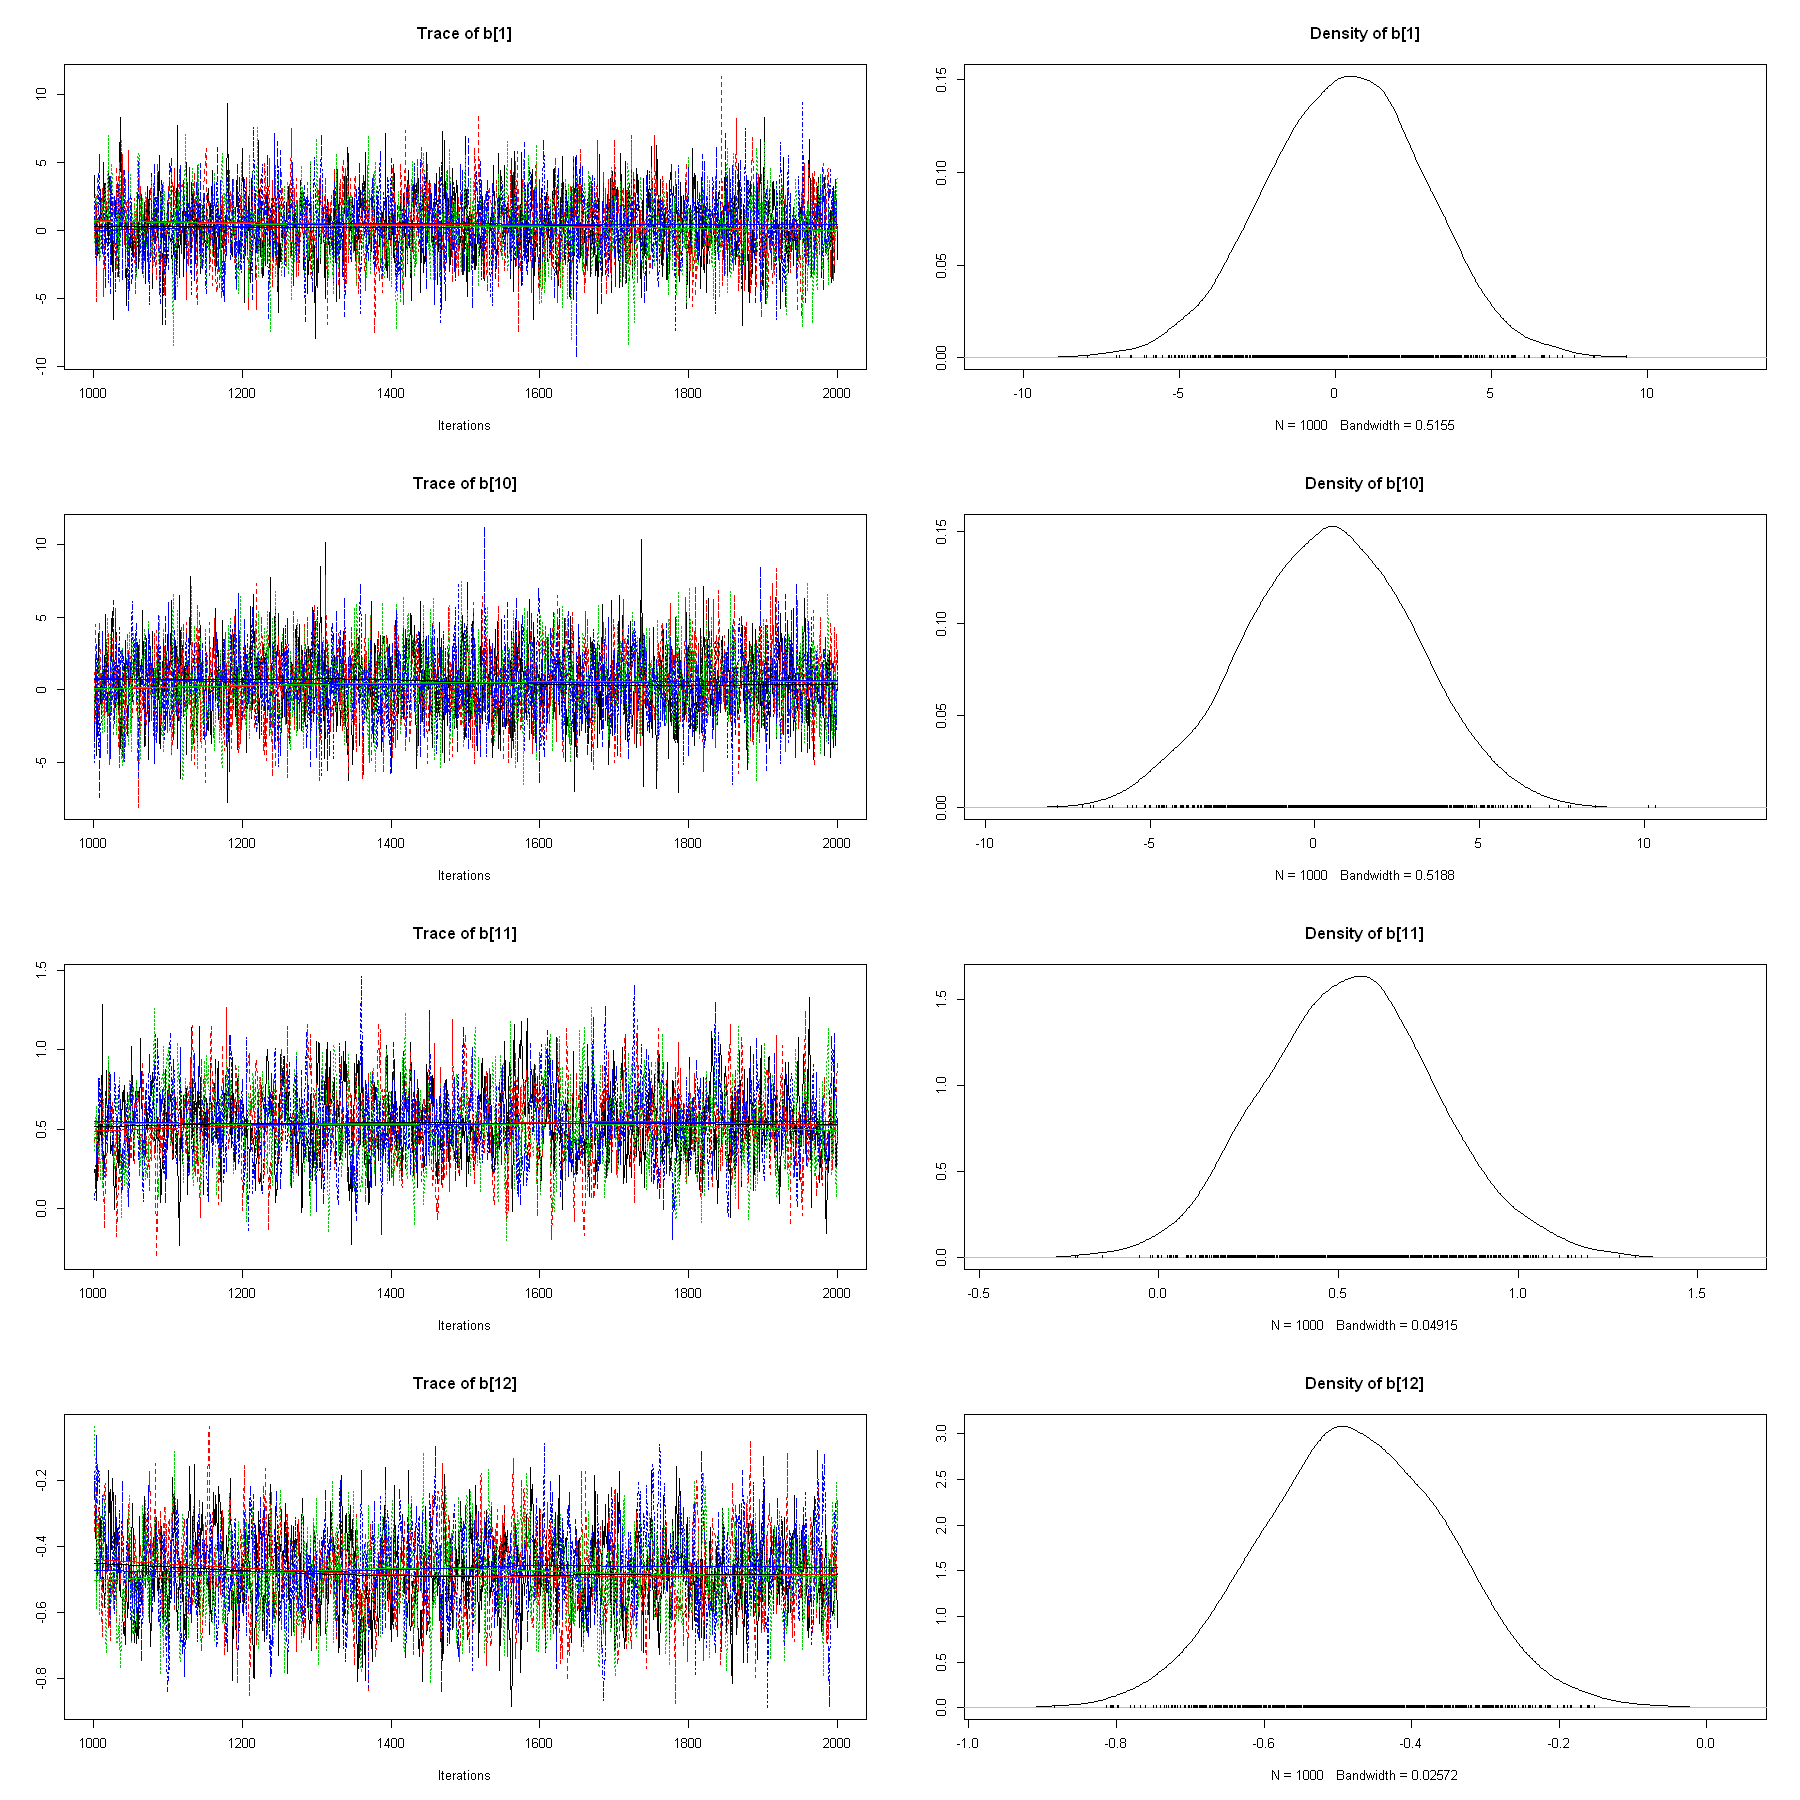

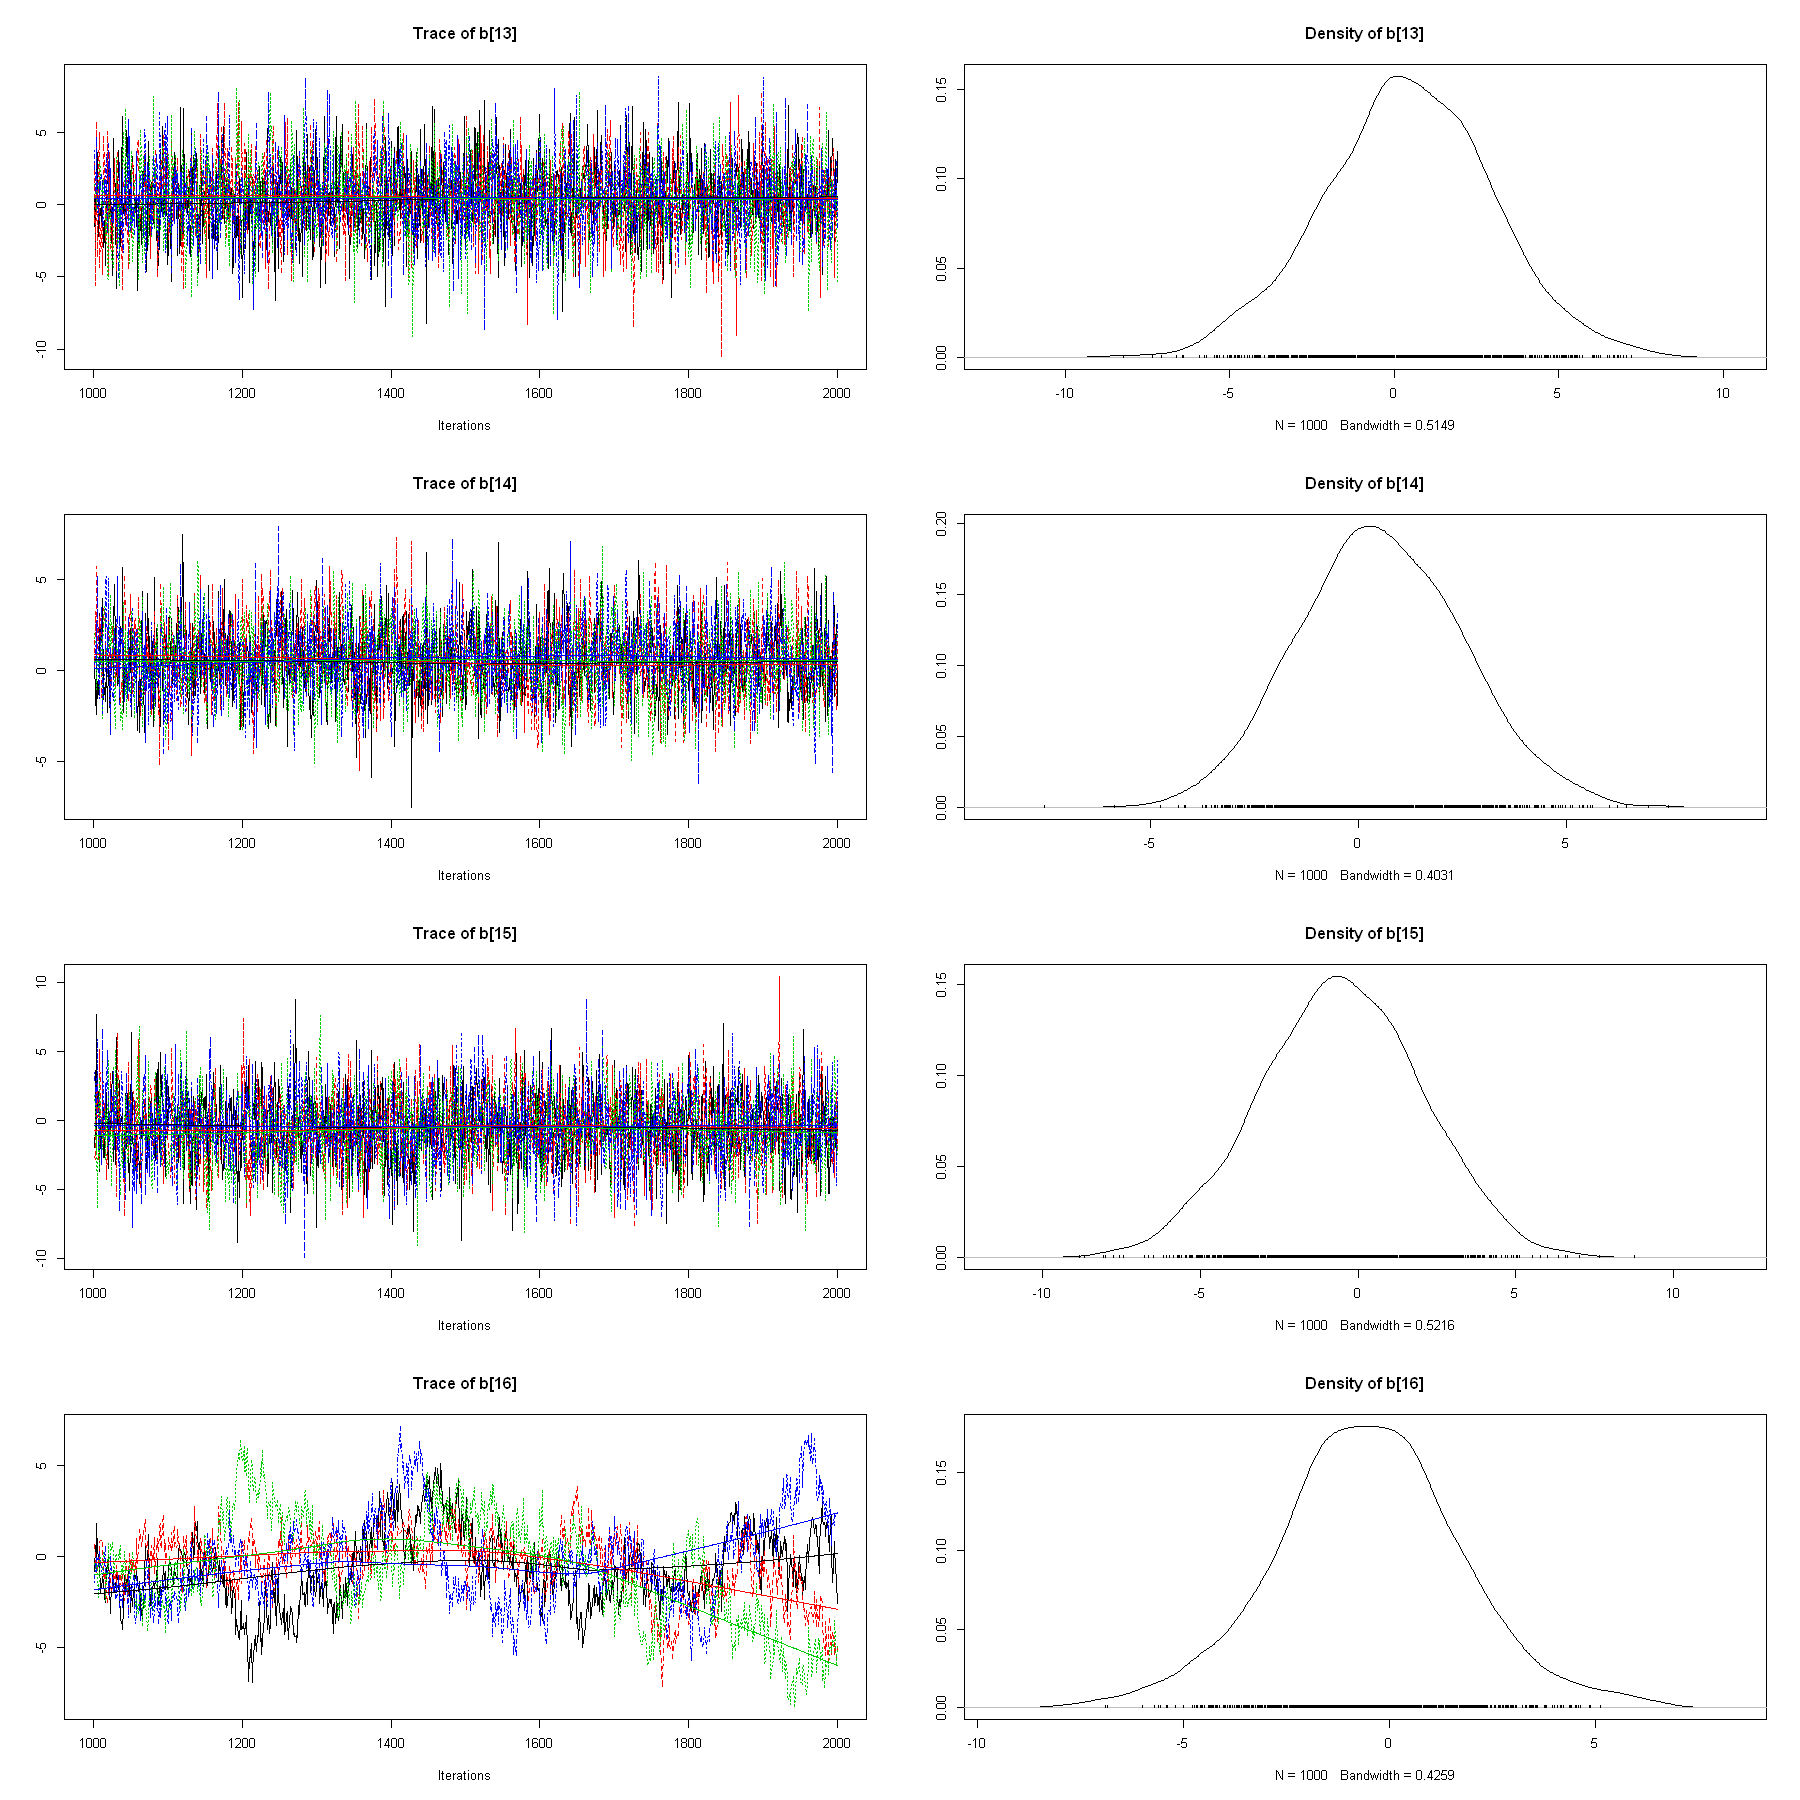

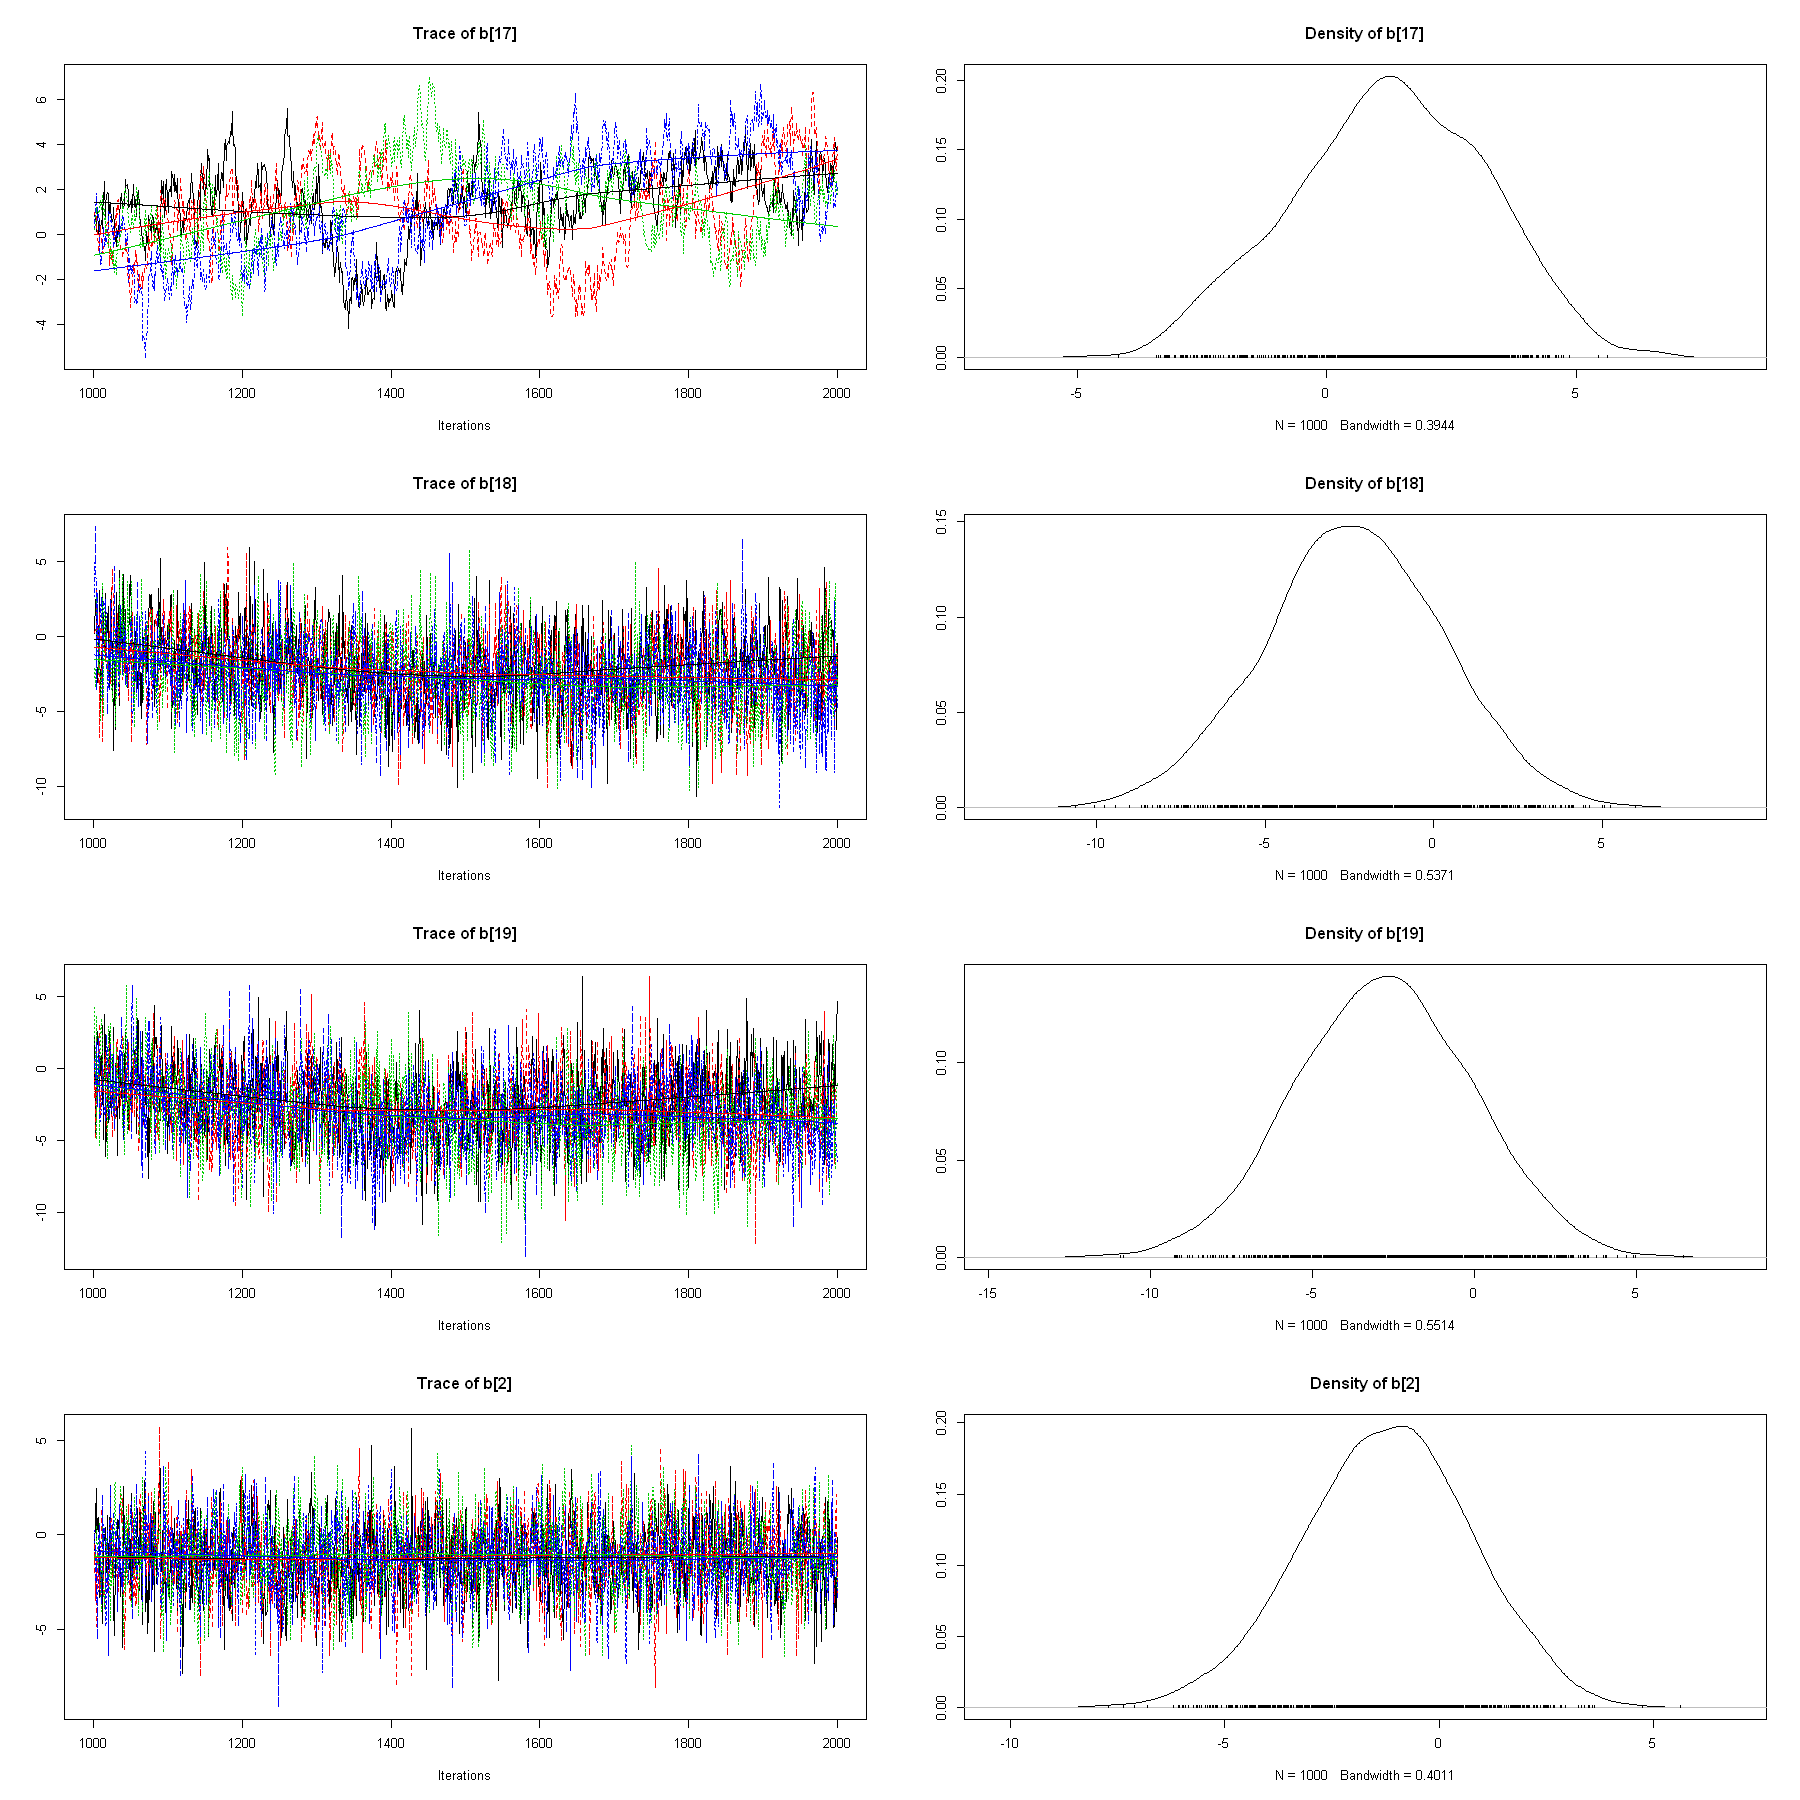

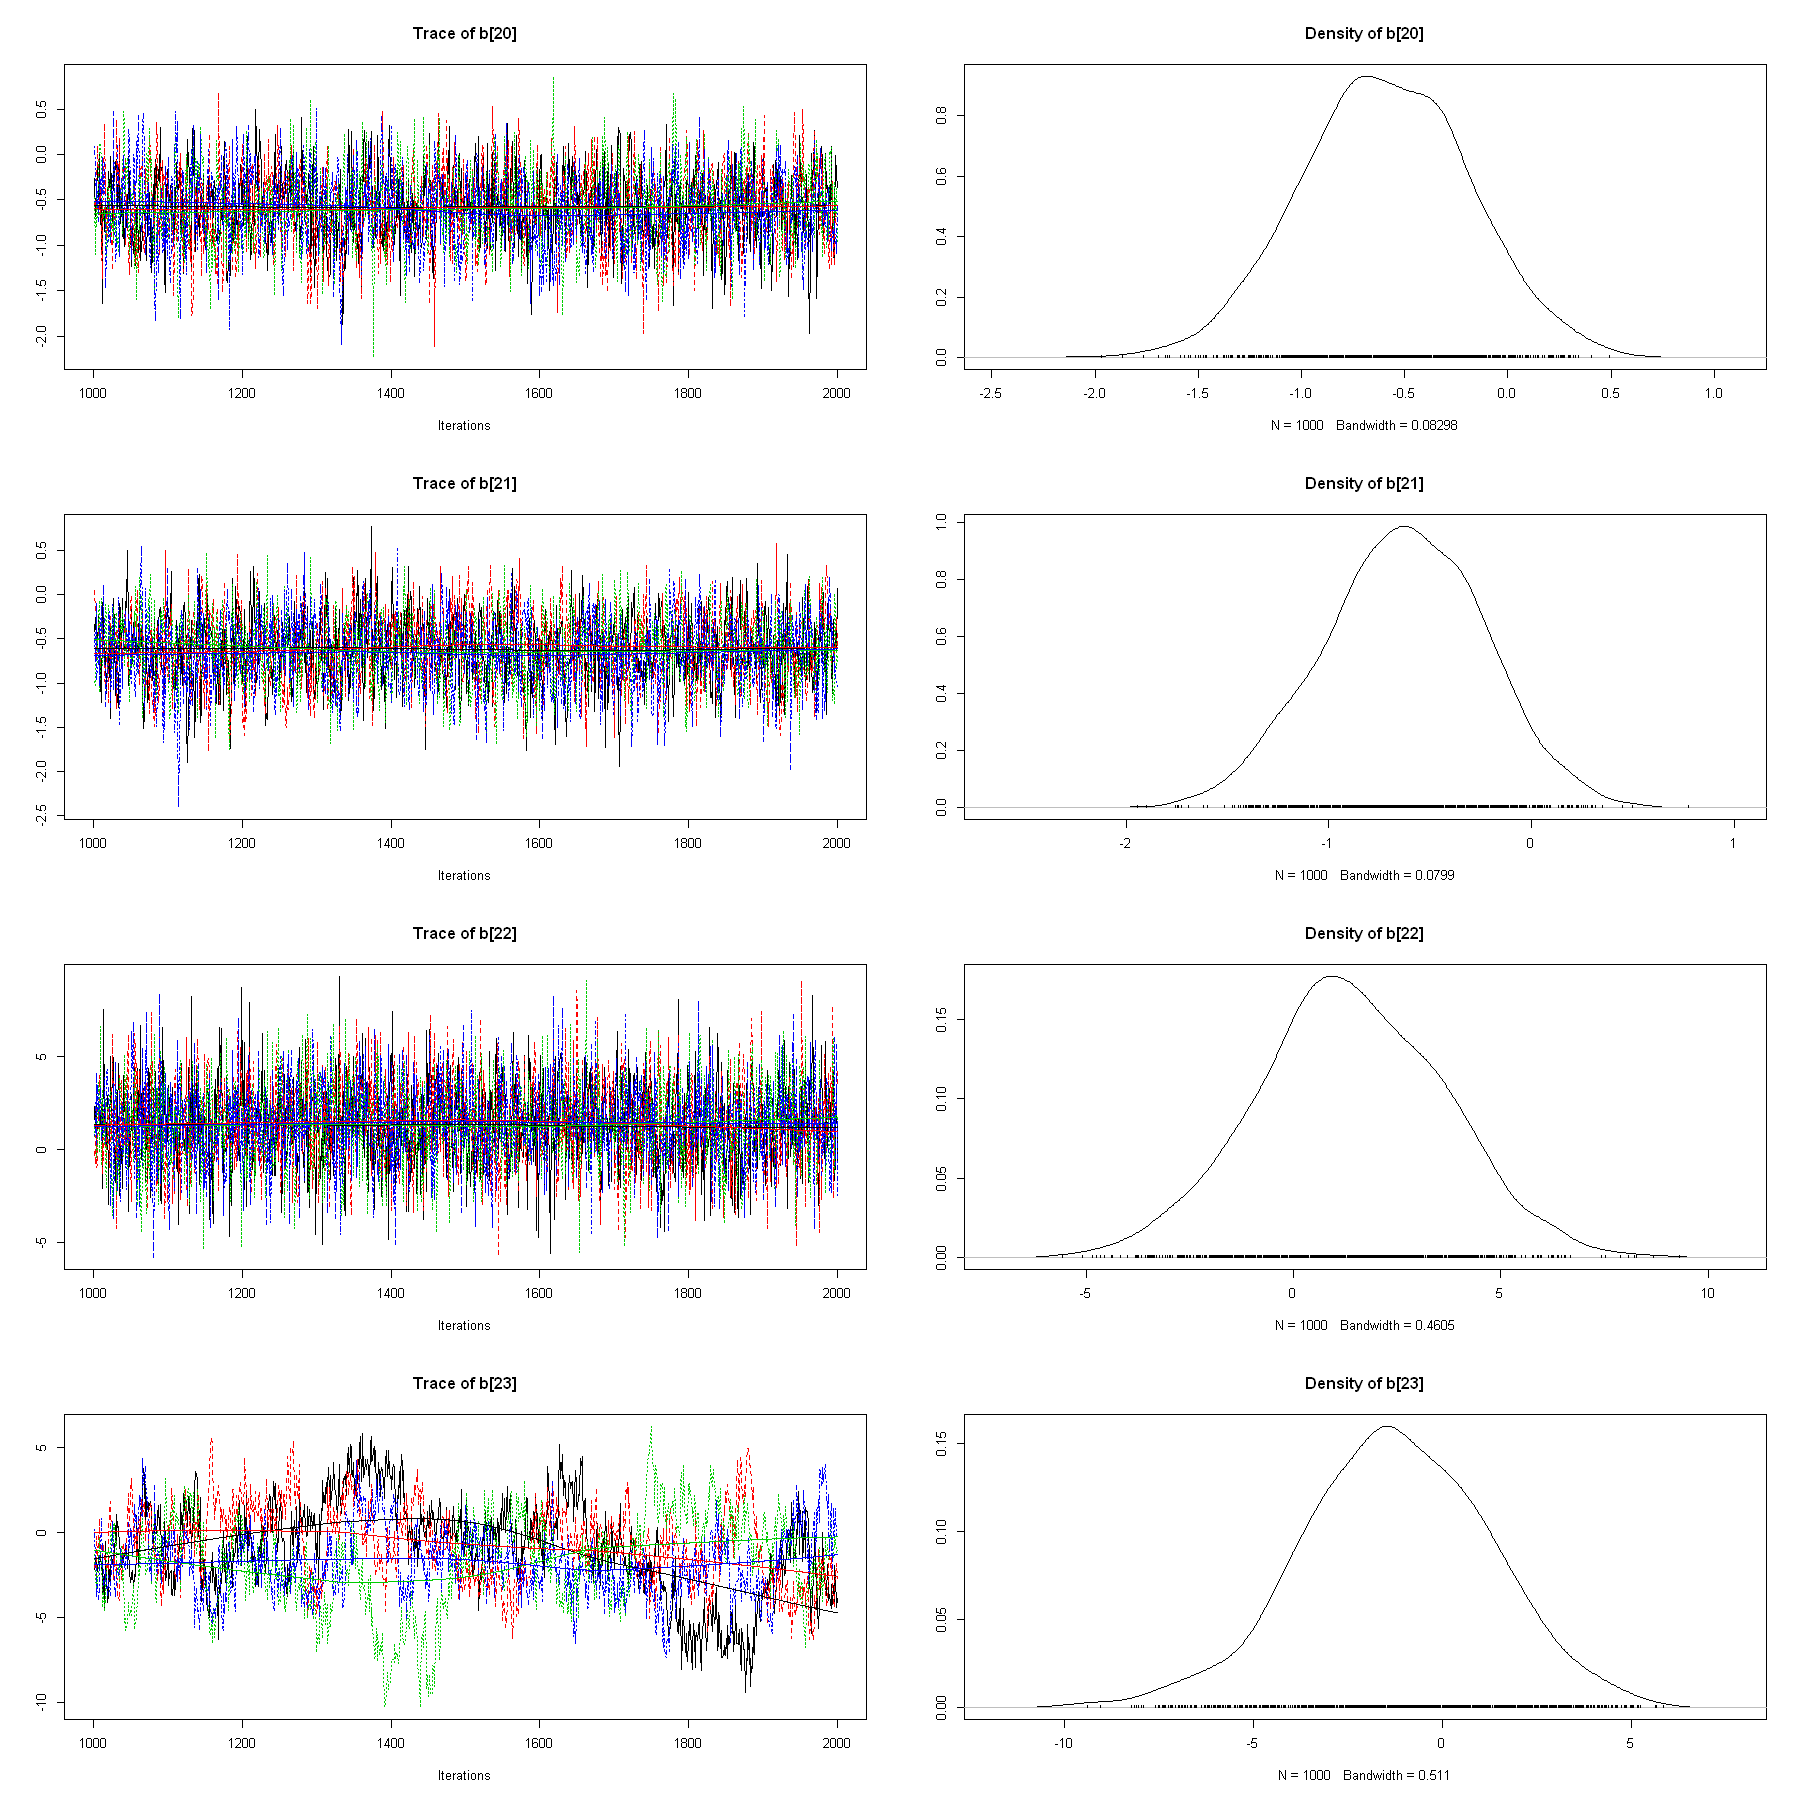

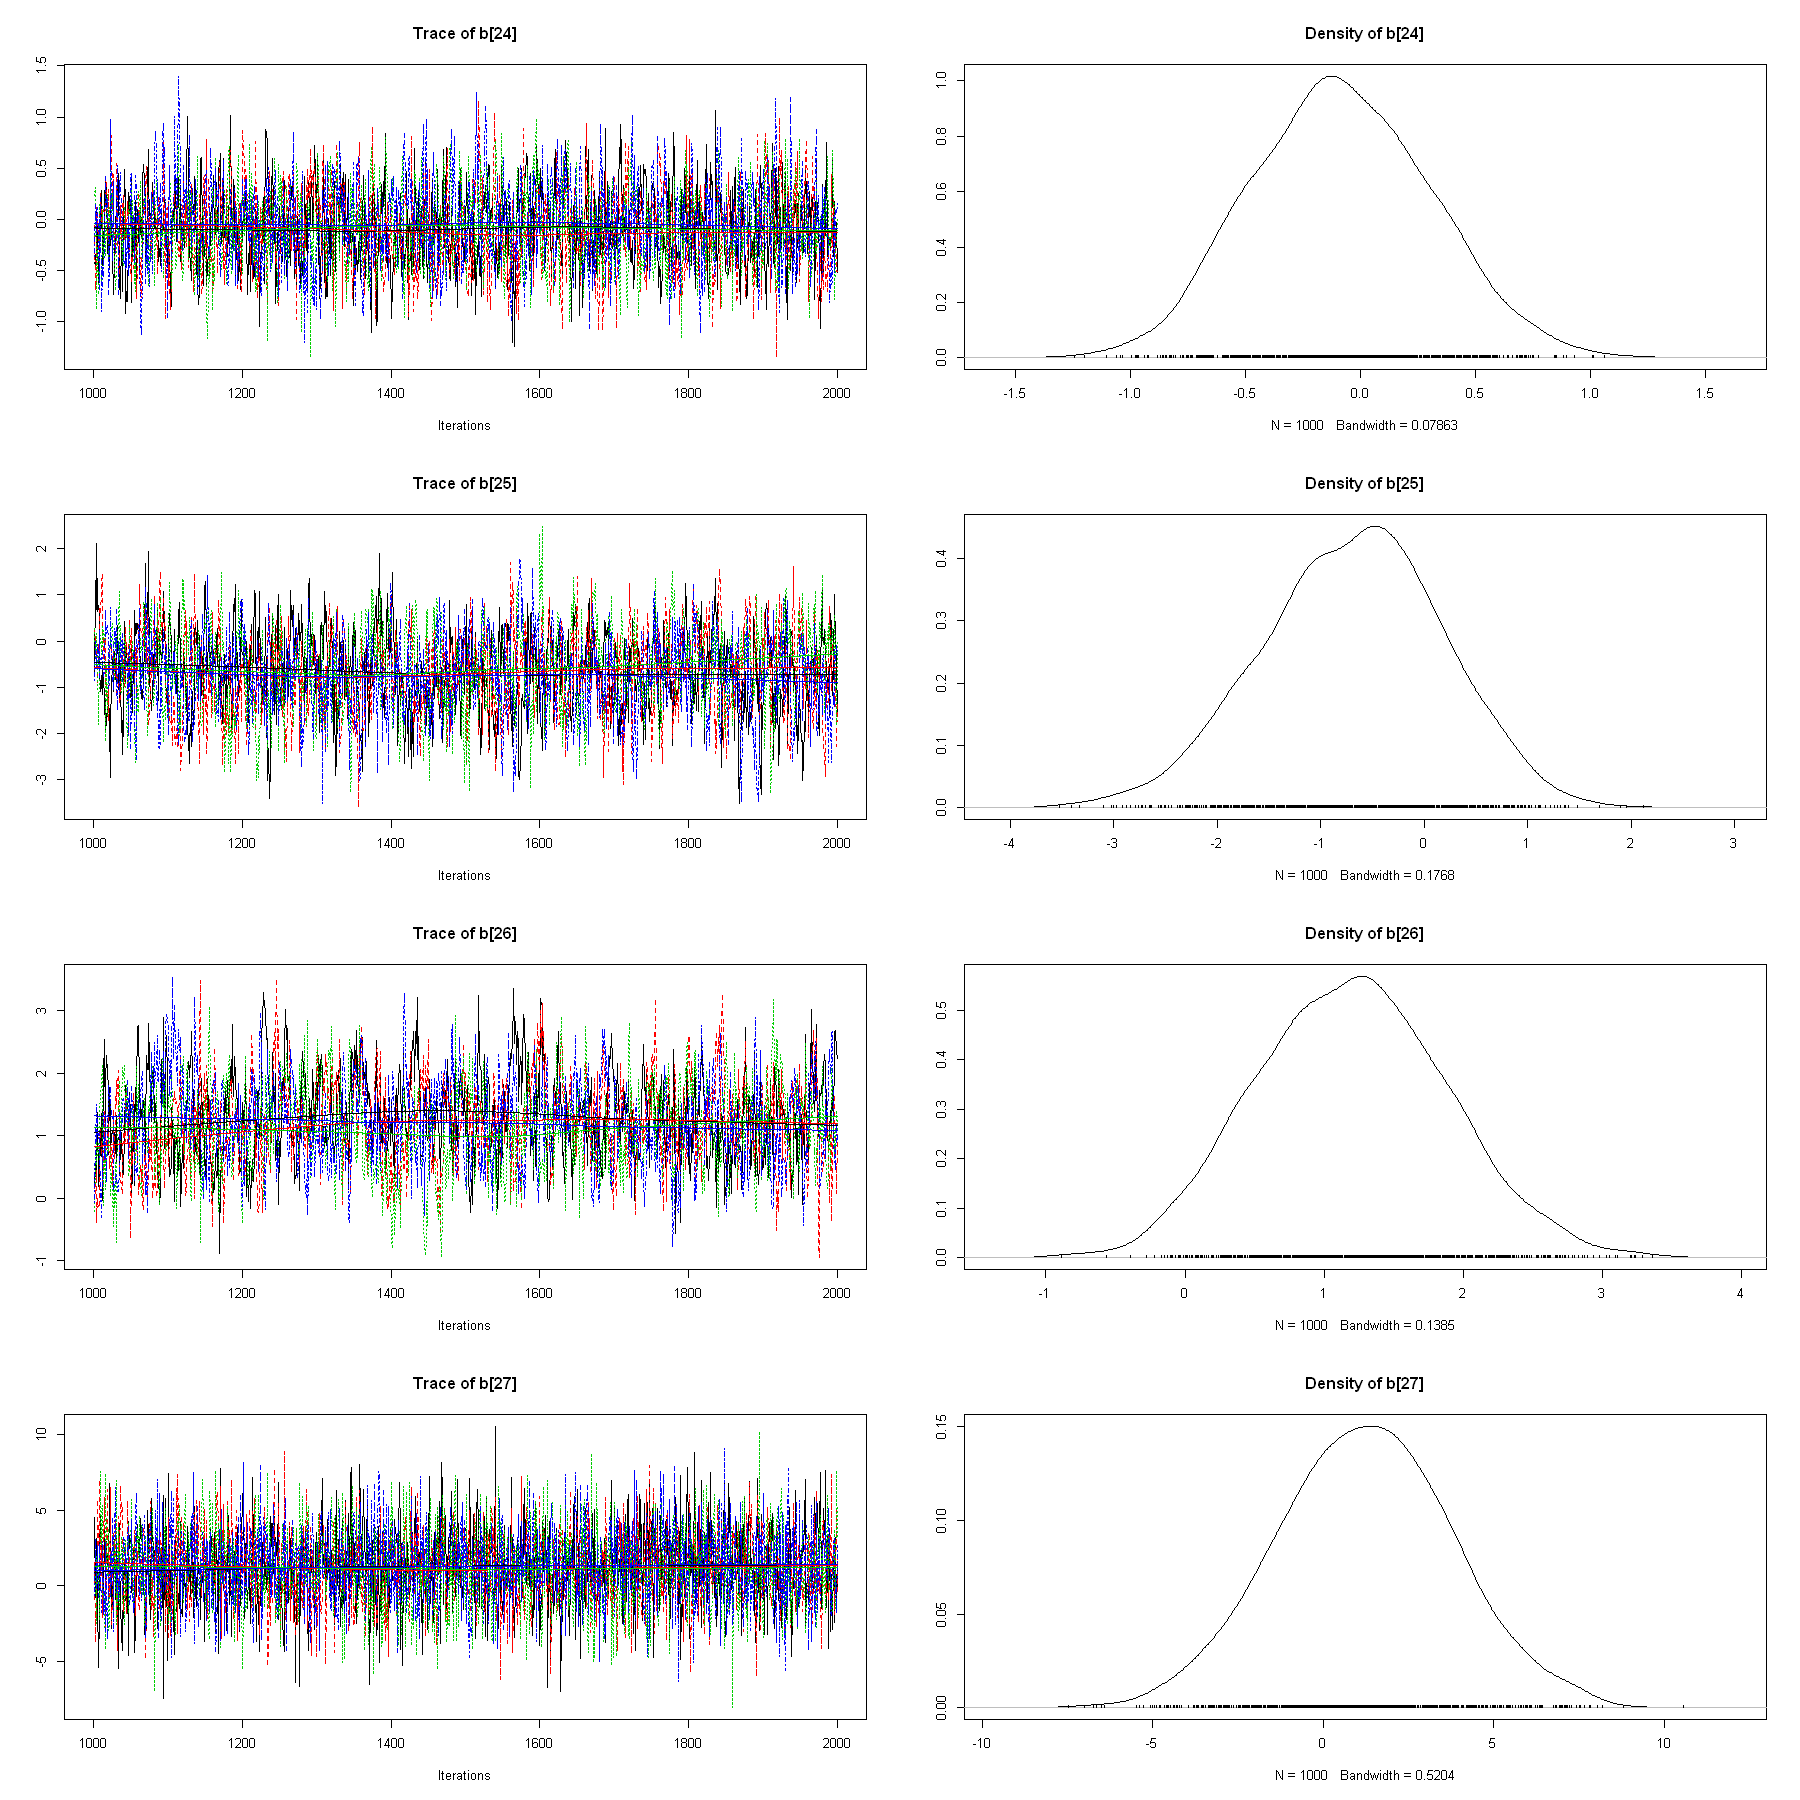

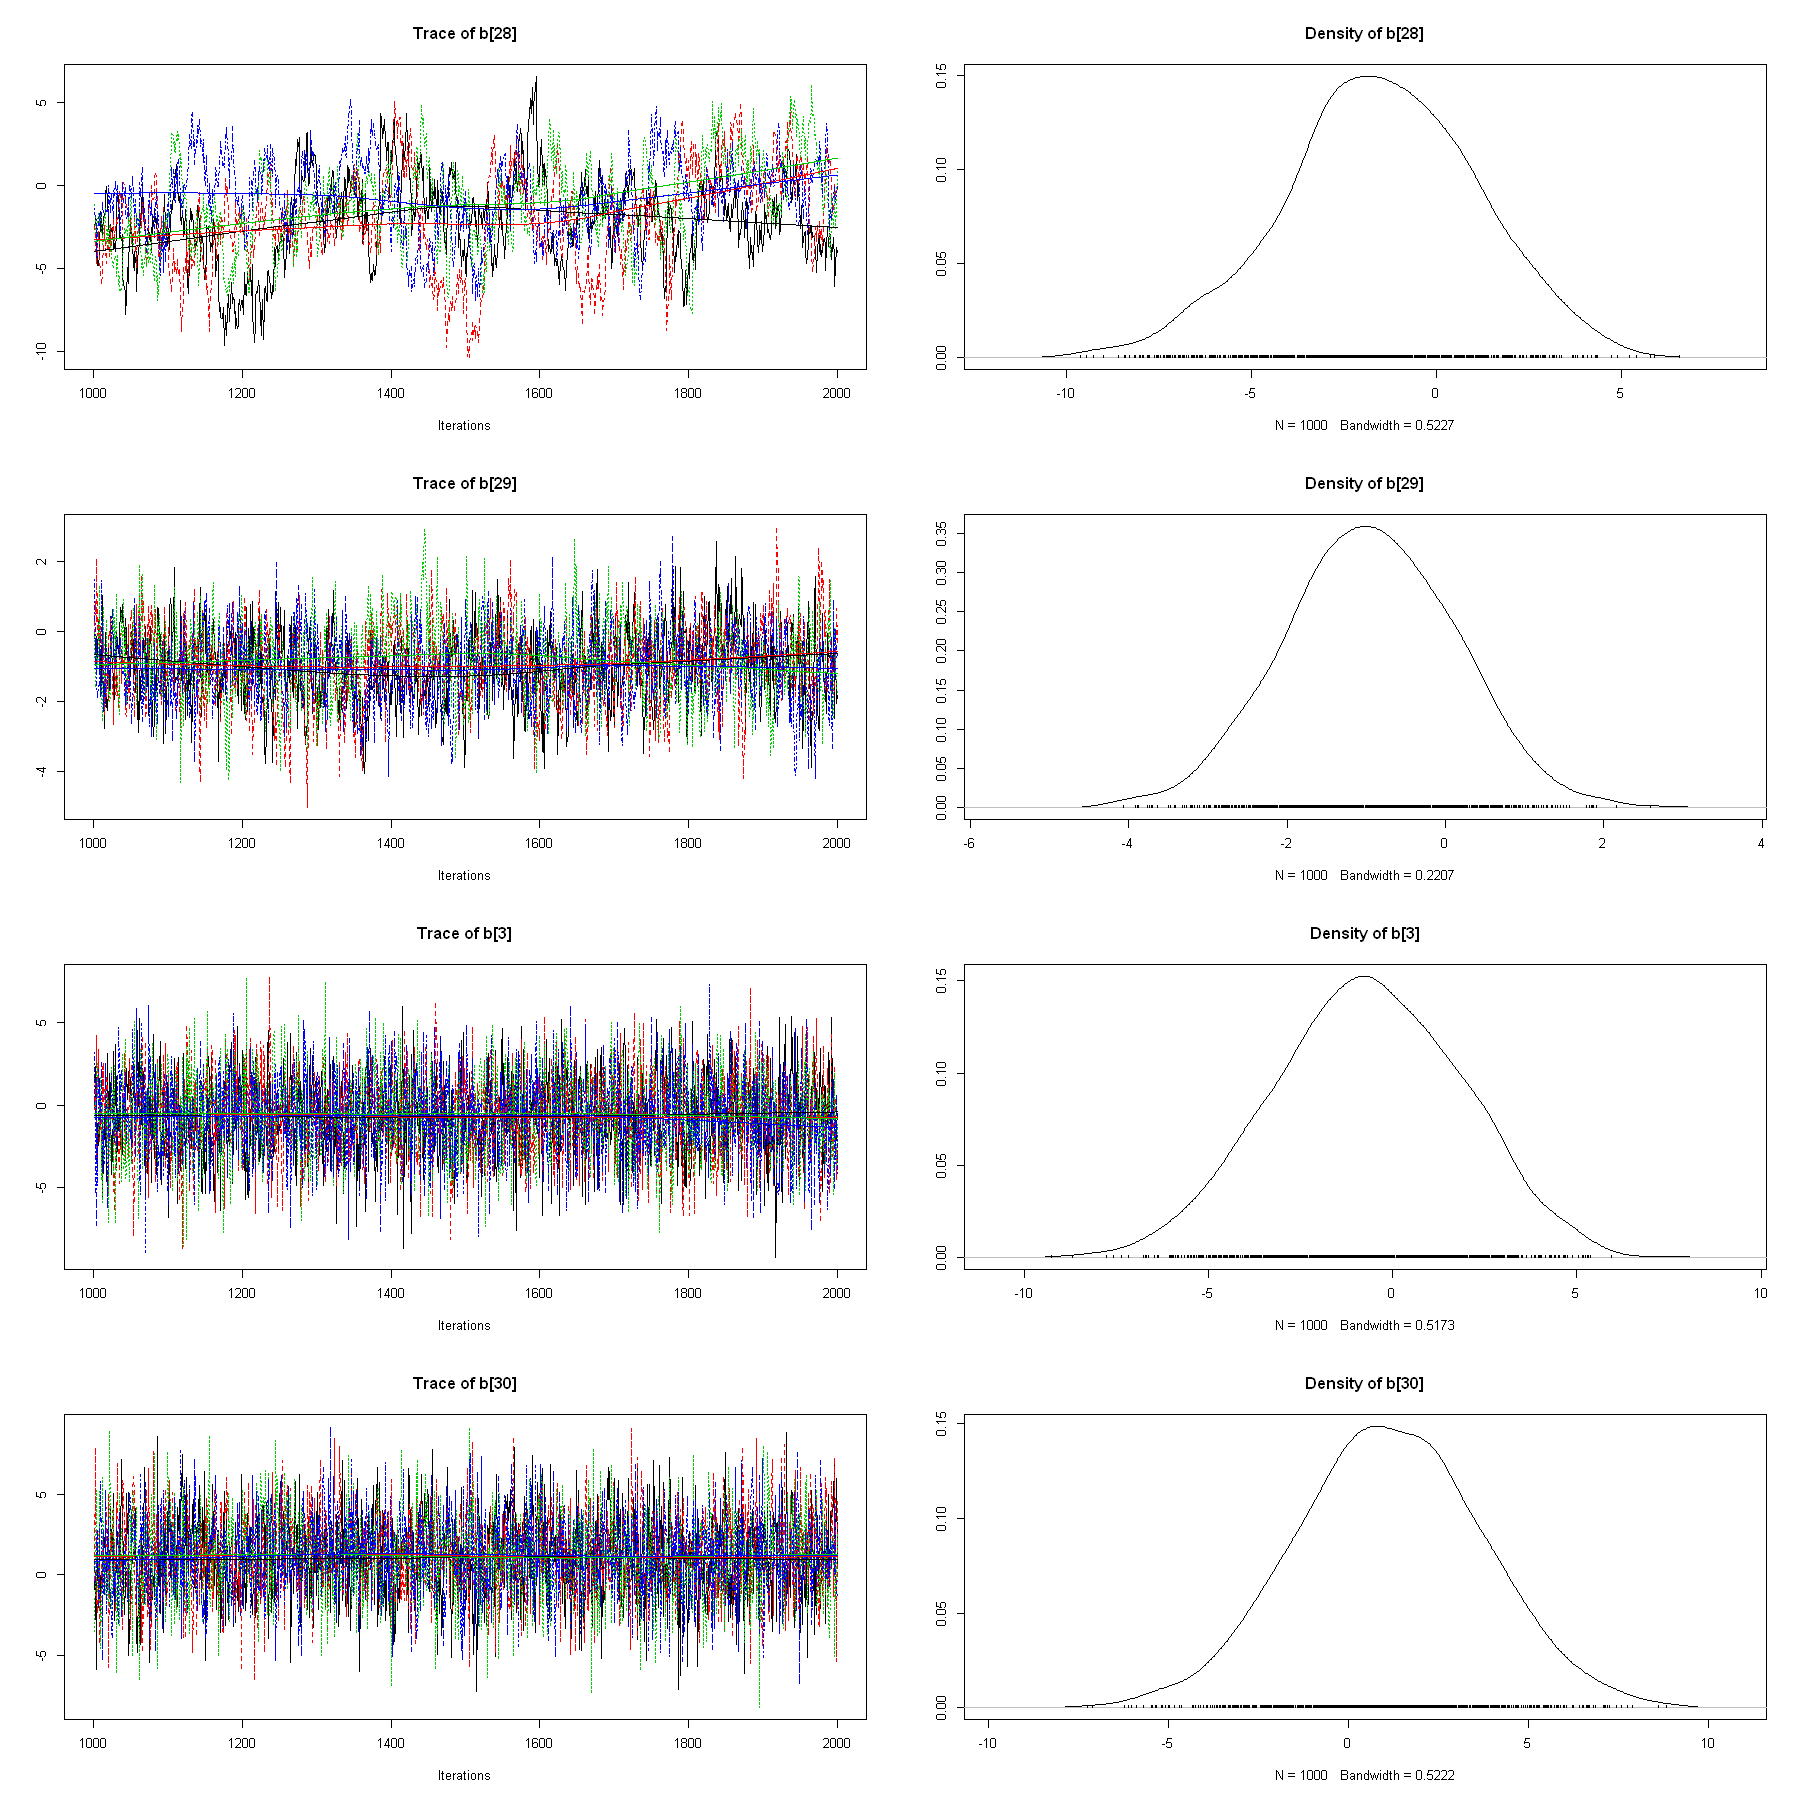

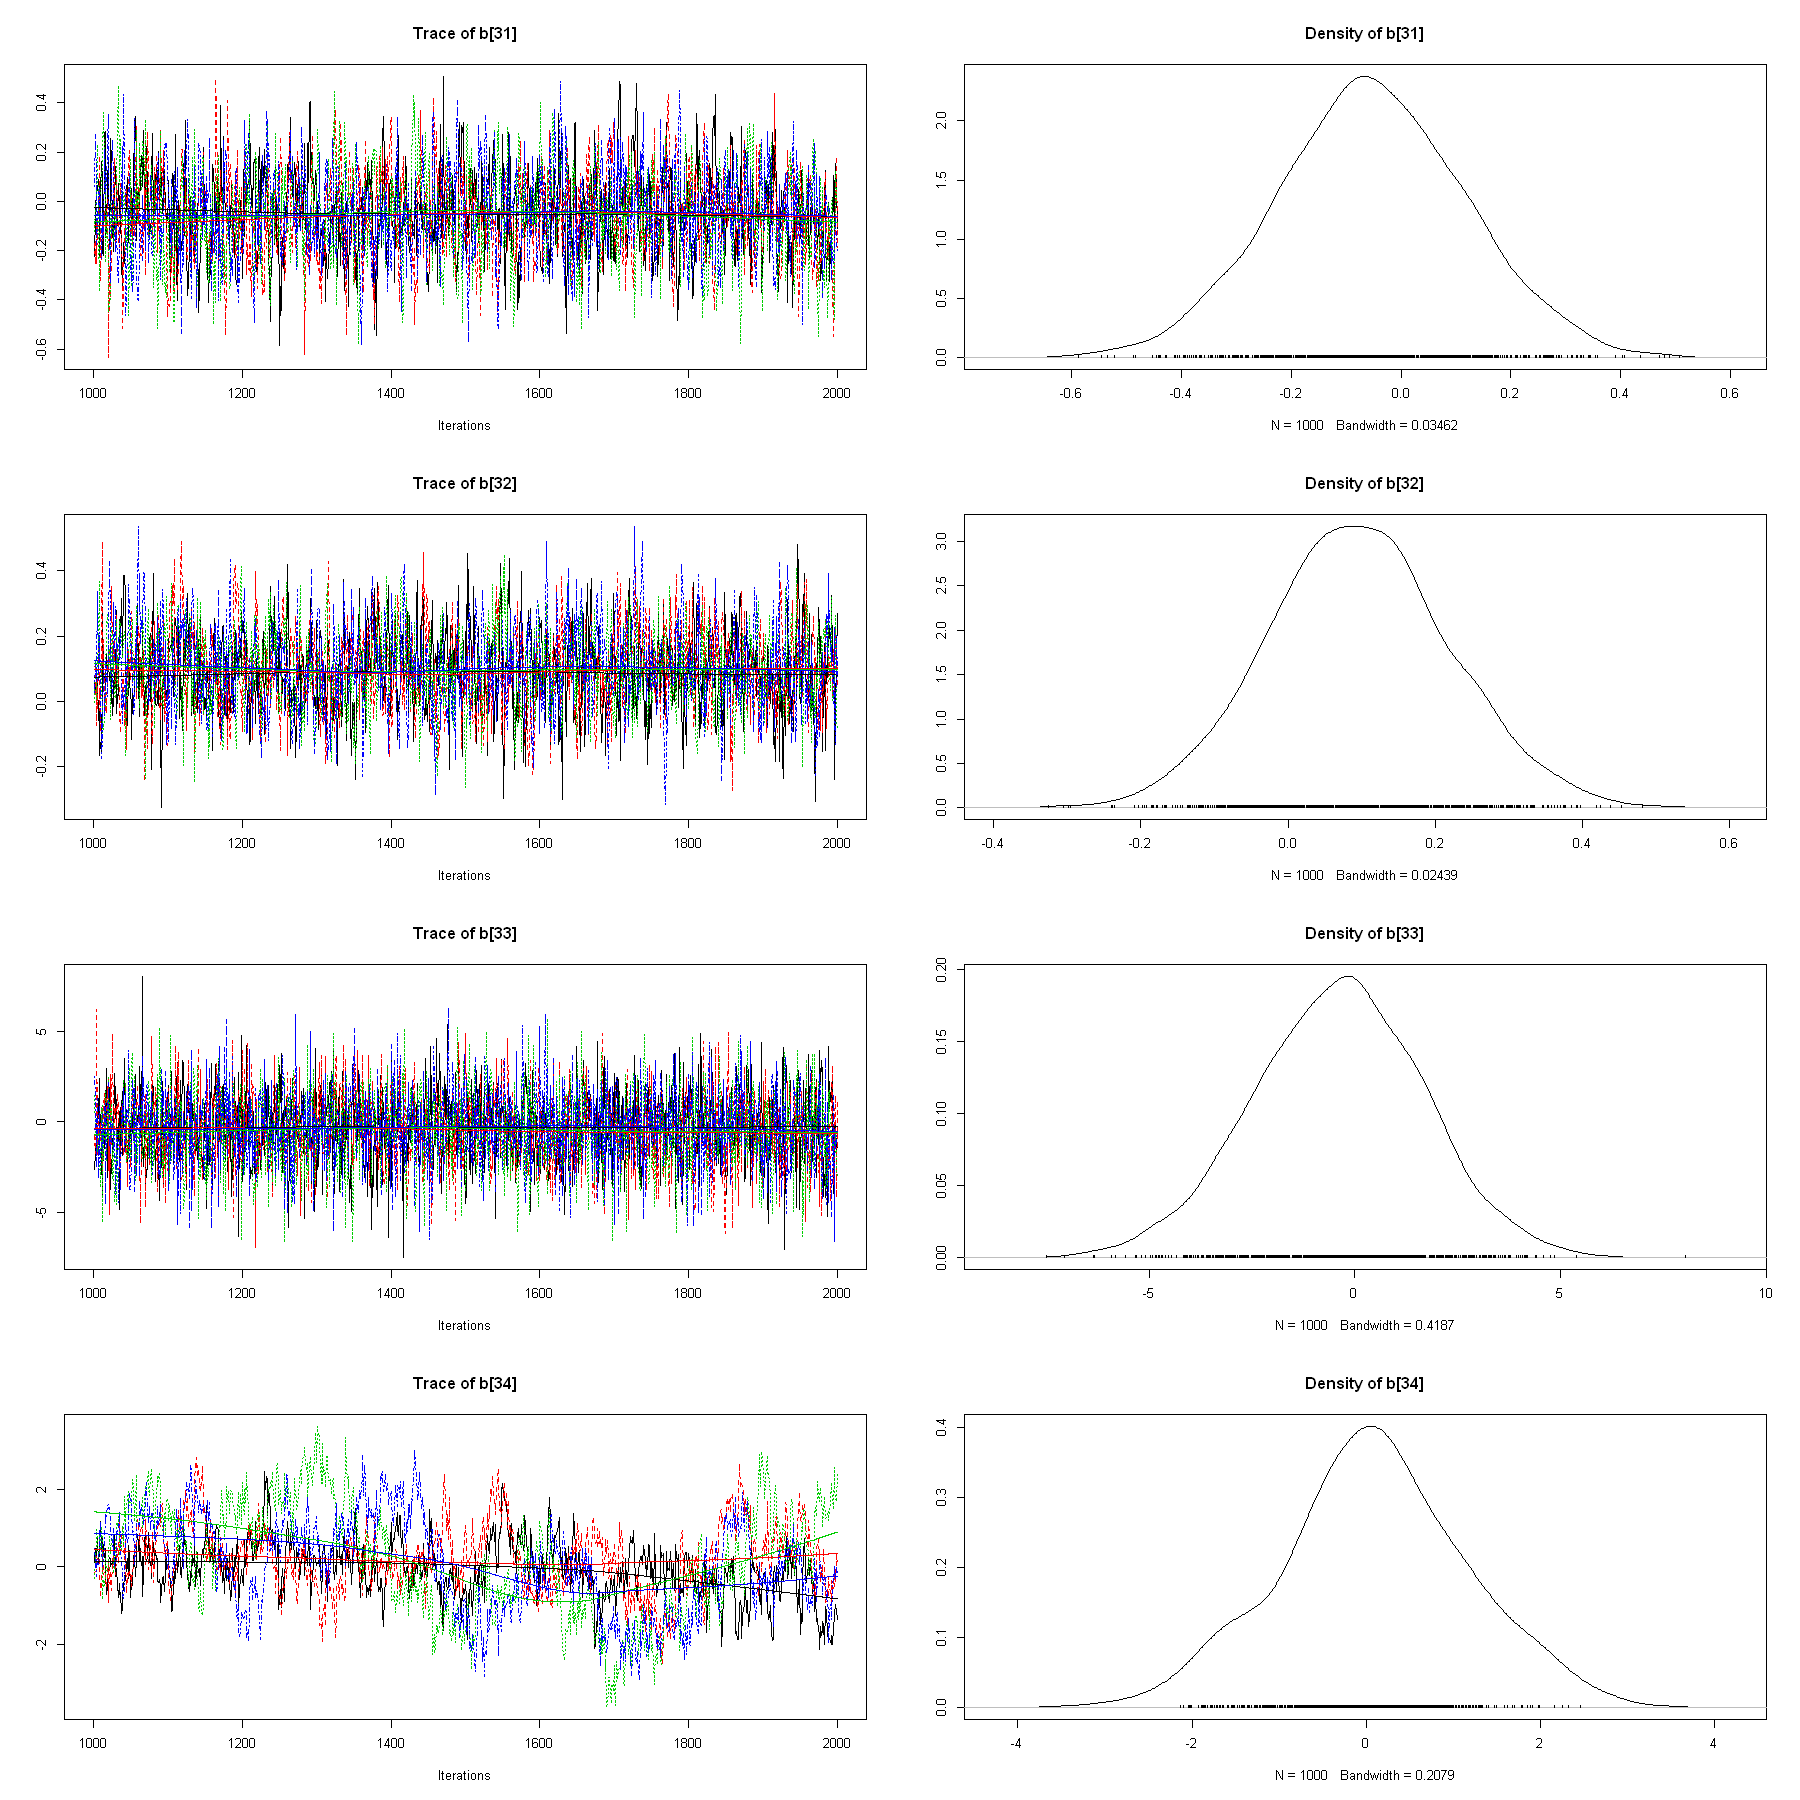

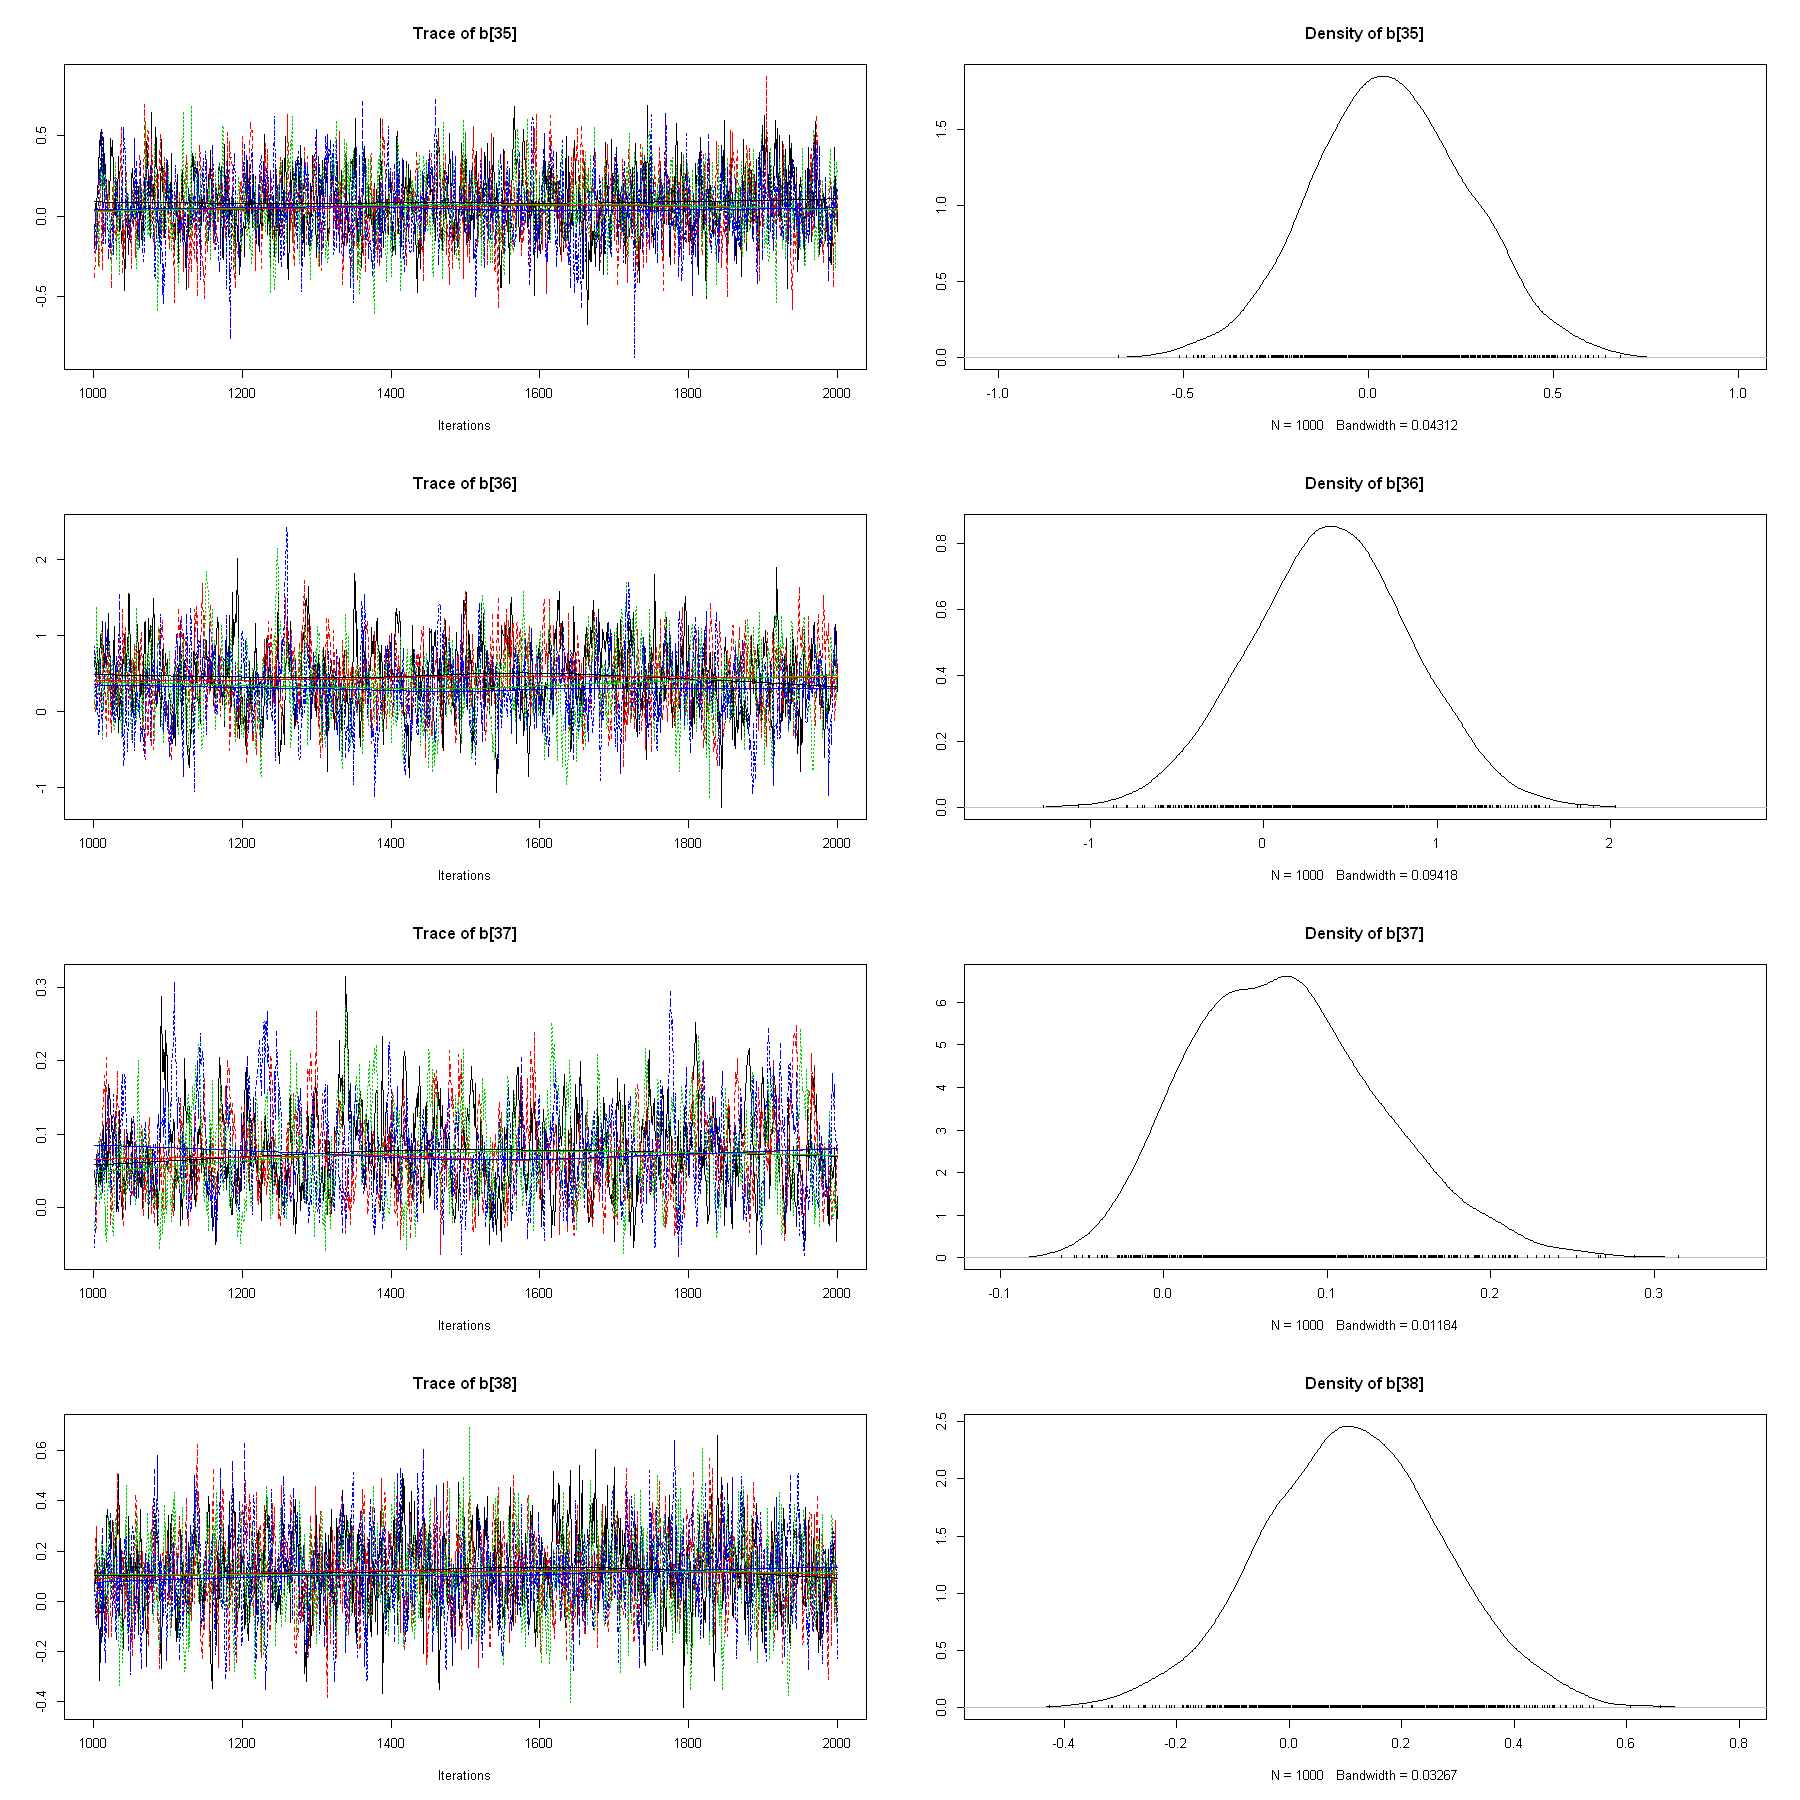

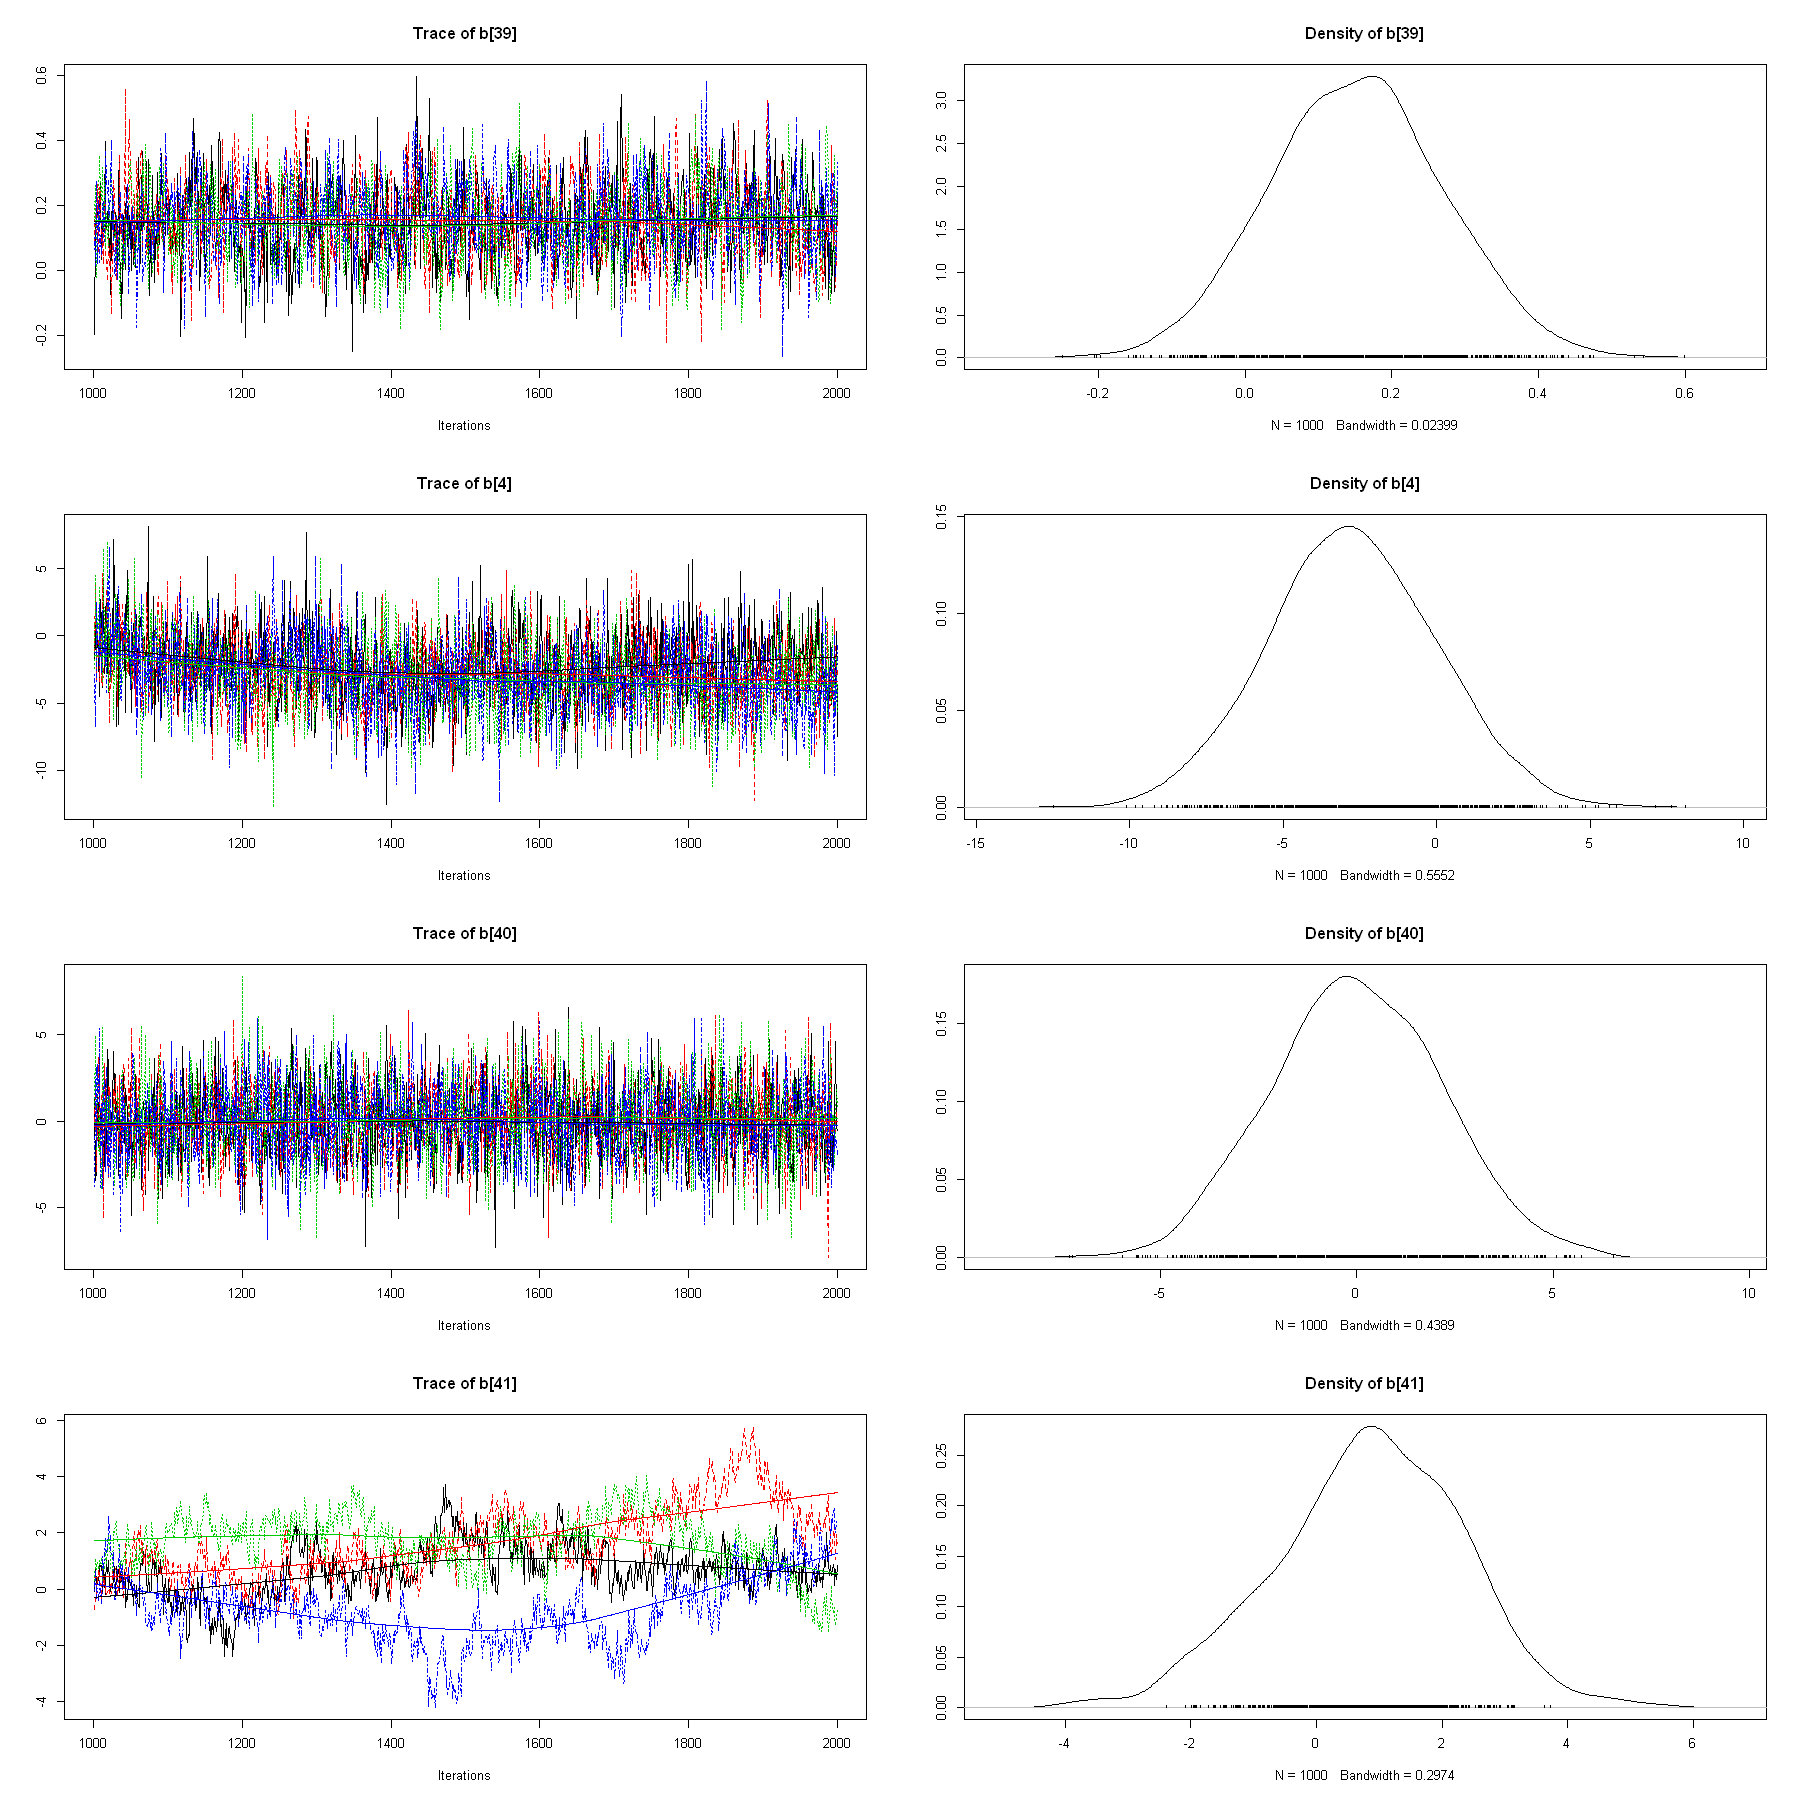

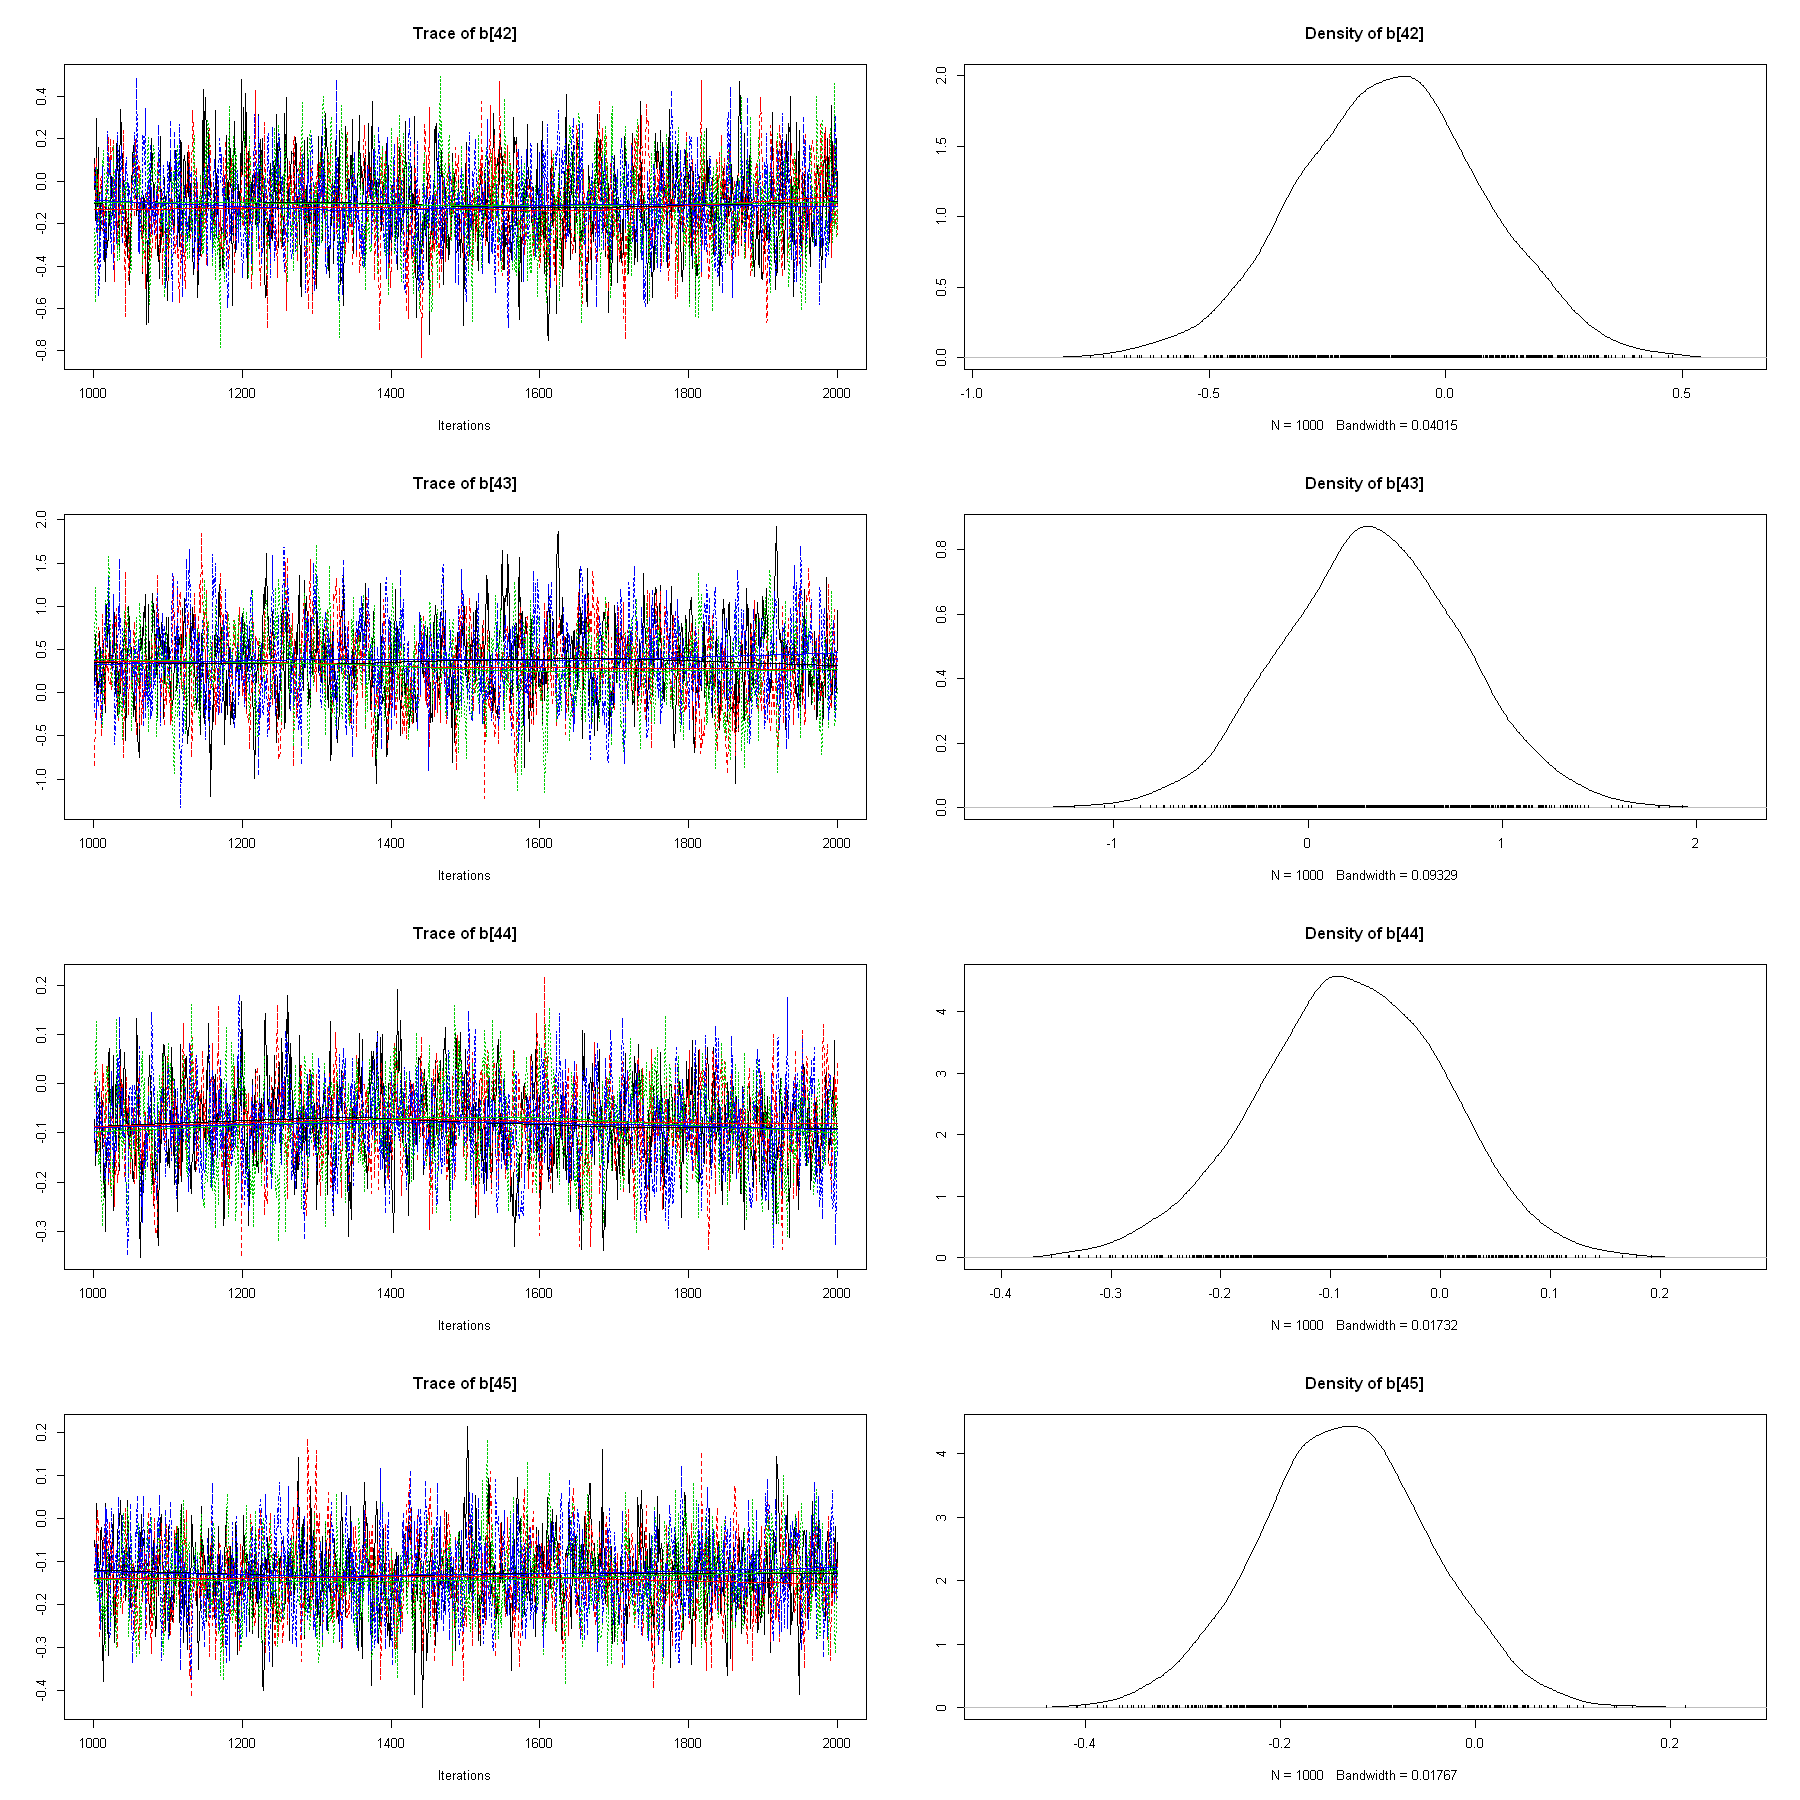

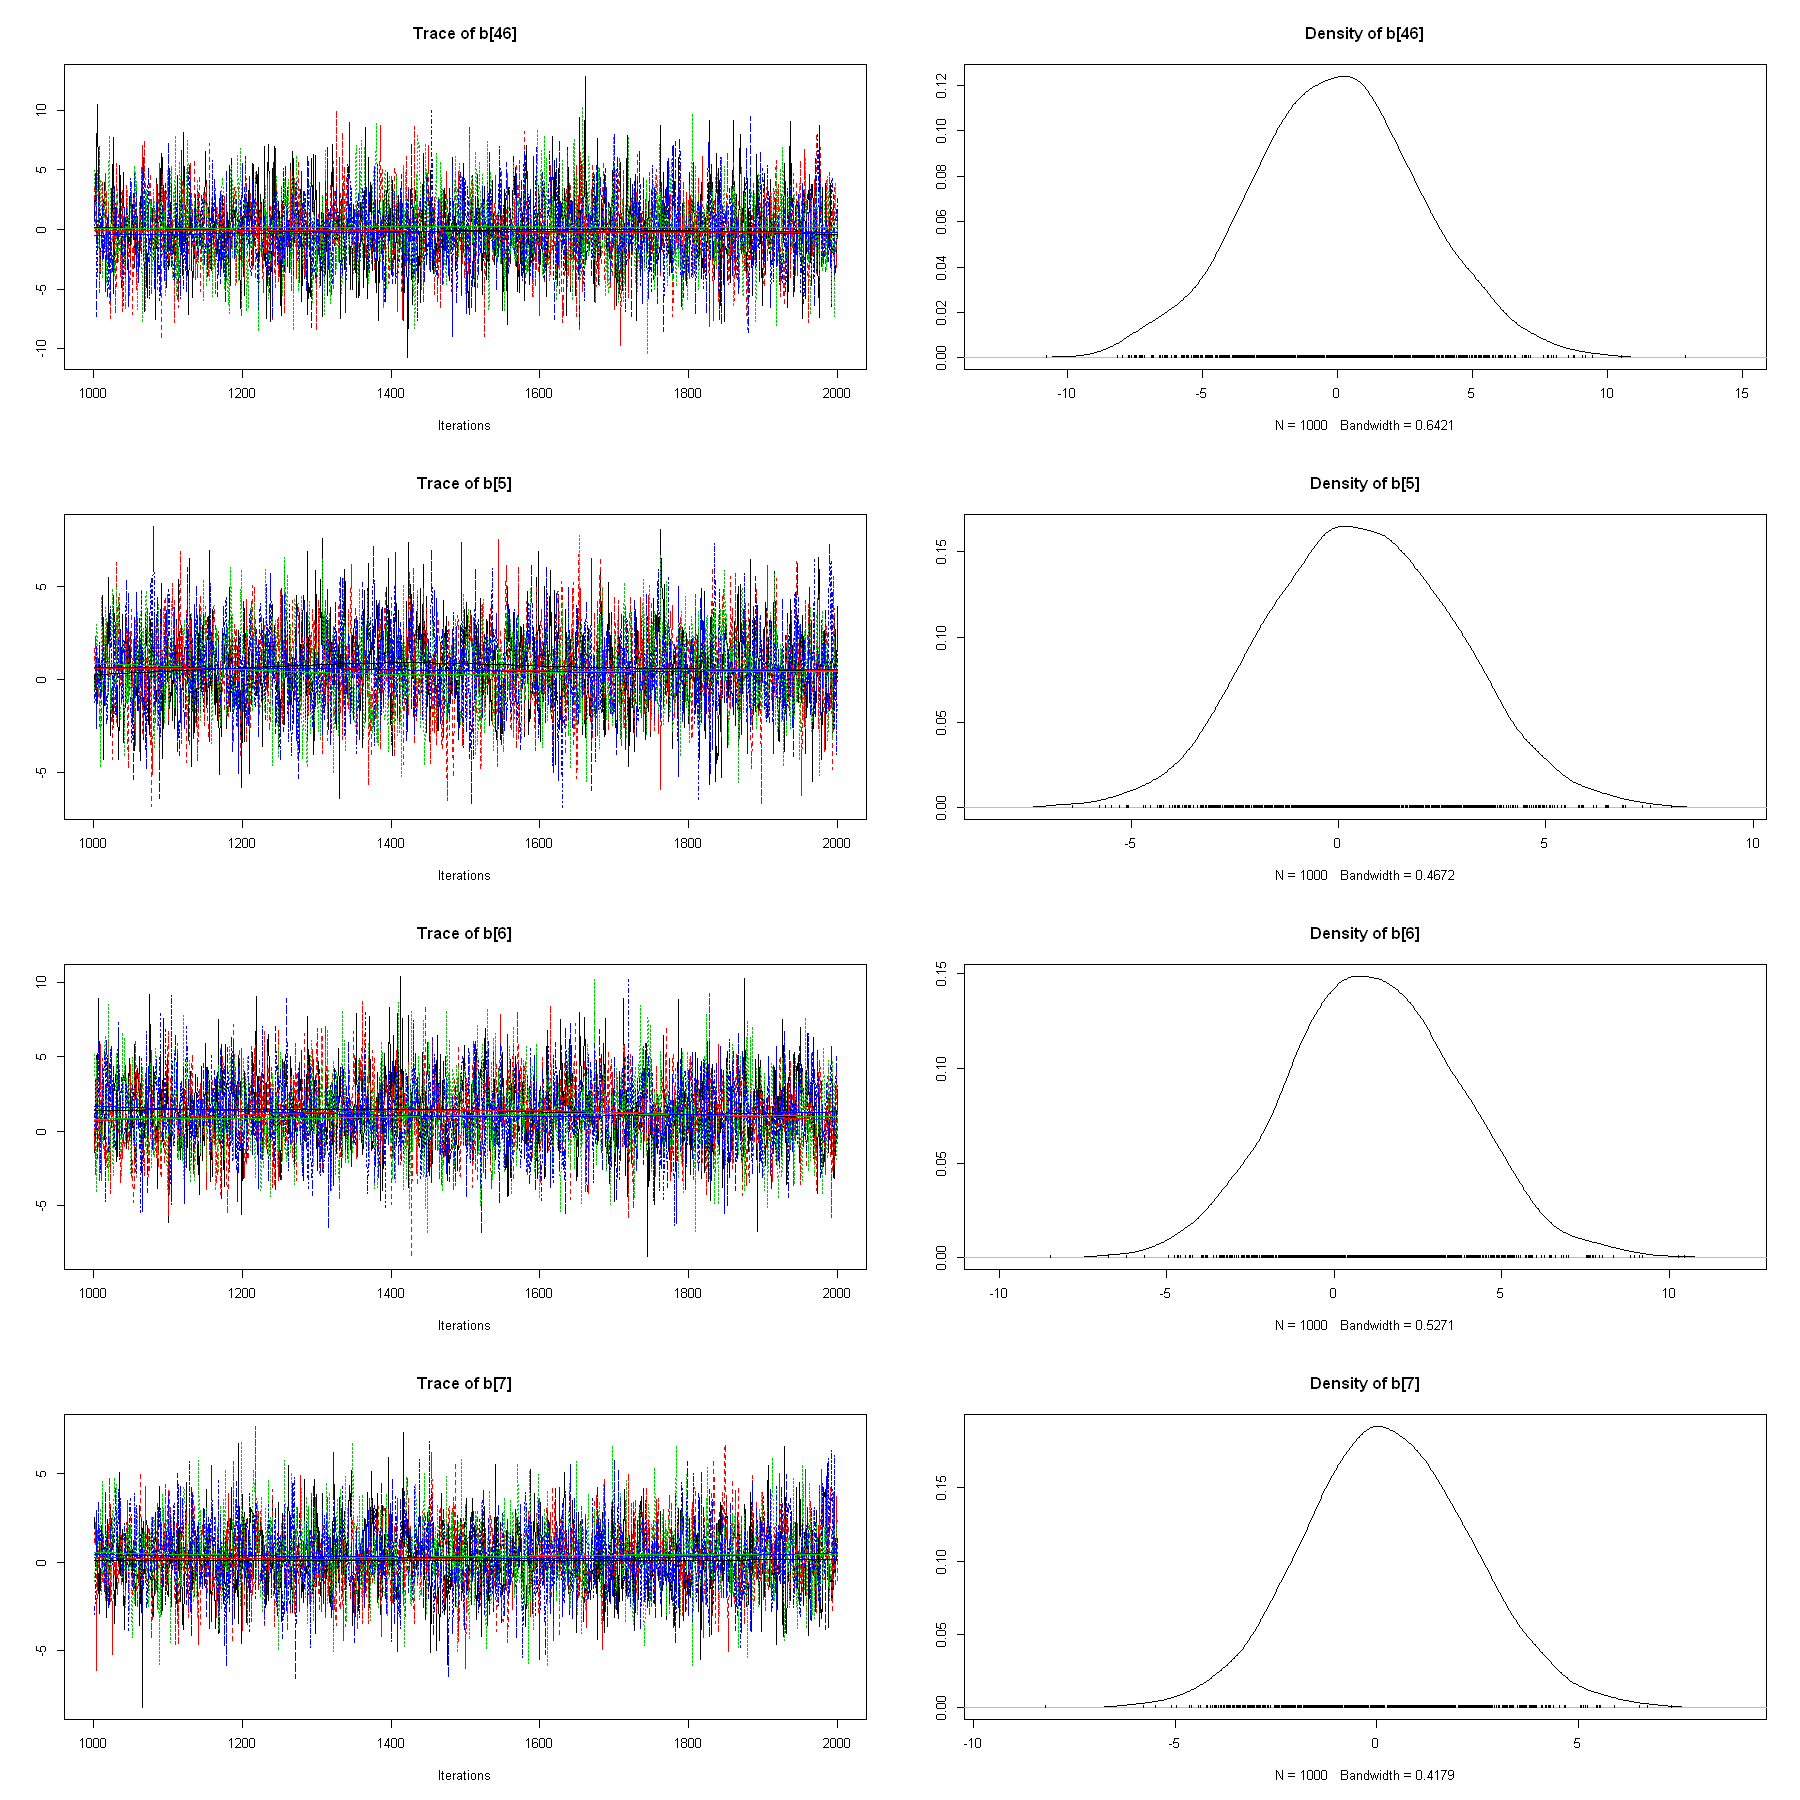

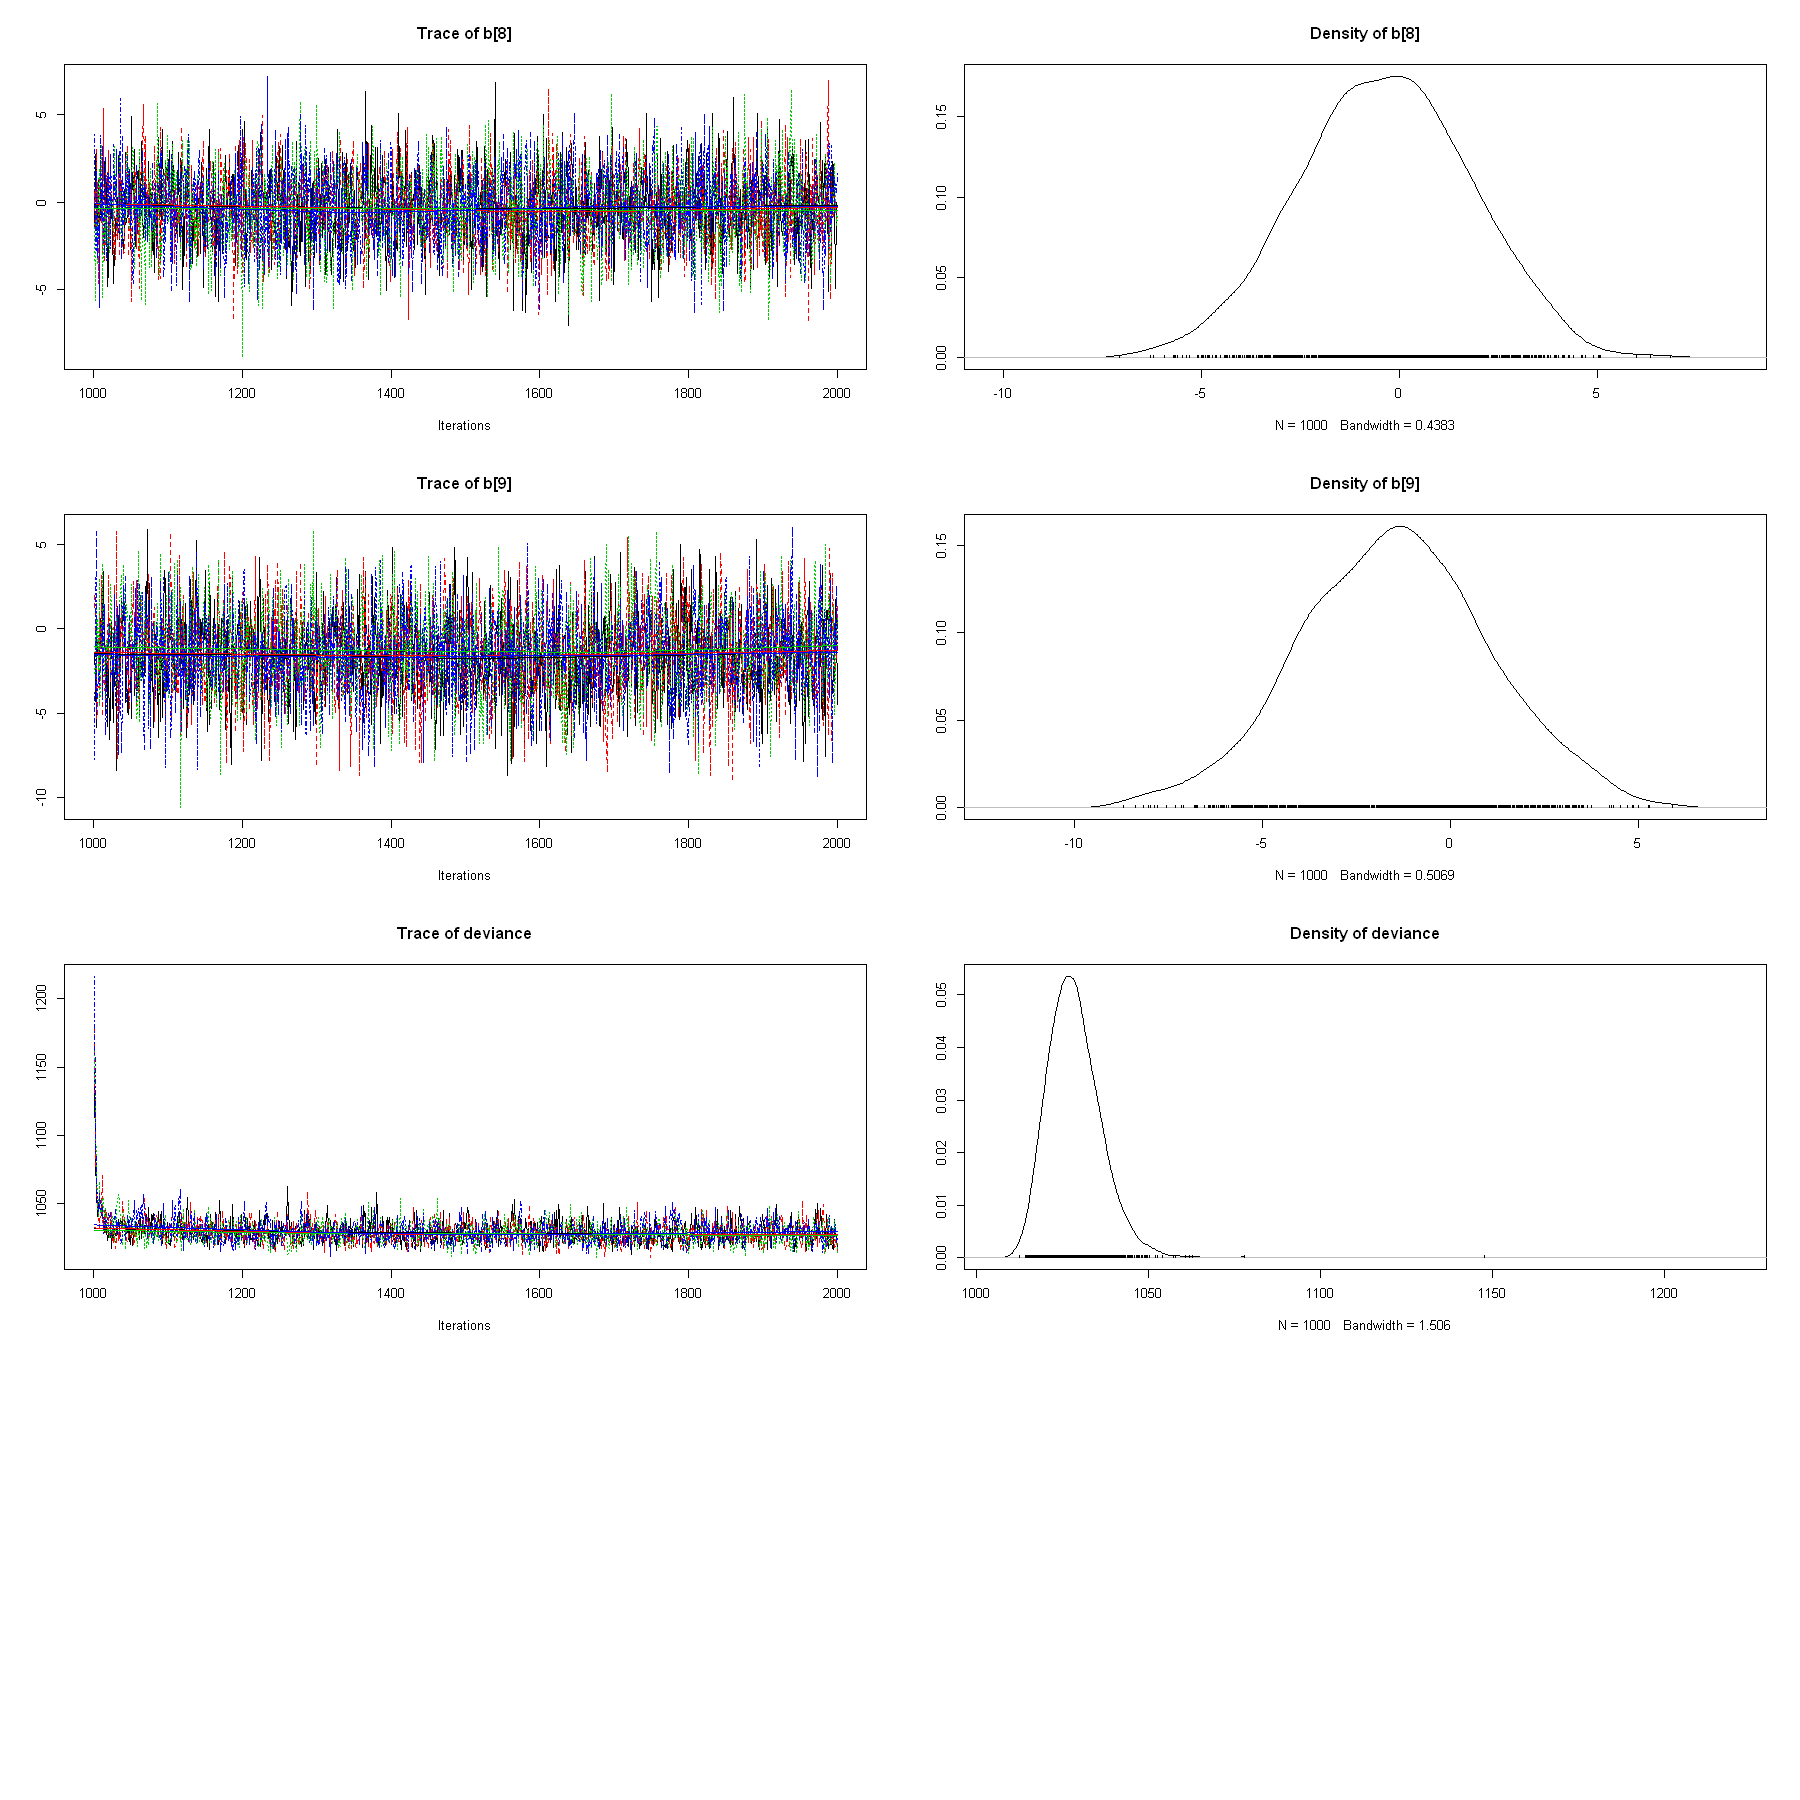

In [211]:
# Slow
out2.mcmc <- as.mcmc(jags_model2)
plot(out2.mcmc)

In [260]:
accuracies.jags2 <- mcmcRocPrc(object = jags_model2,
                       data=dfCombined,
                       yname  = "Response",
                       xnames = c('Gender','Age','Driving_License','Previously_Insured','Vehicle_Age',
                                  'Vehicle_Damage','Annual_Premium','Vintage'),
                       curves = TRUE,
                       fullsims = FALSE)

In [261]:
accuracies.jags2$area_under_roc

V1 
0.5155949

In [262]:
accuracies.jags2$area_under_prc

V1 
0.5167614

In [263]:
accuracies.jags$area_under_roc

V1 
0.8266041

In [264]:
accuracies.jags$area_under_prc

V1 
0.7474185

#### First differences

We use first differences to search the most impactful second order interaction terms

In [265]:
matstr<-paste("Response ~ ", sep="")

for (i in 1:(length(colnames(df2))-1)){
    if(col[i]!="Response")
        matstr<-paste(matstr,col[i]," + ", sep="")
}
matstr<-paste(matstr,col[i+1], sep="")
p <- parse(text = matstr)[[1]]
p

Response ~ Gender + Age + Driving_License + Previously_Insured + 
    Vehicle_Age + Vehicle_Damage + Annual_Premium + Vintage + 
    GenderXGender + AgeXGender + AgeXAge + Driving_LicenseXGender + 
    Driving_LicenseXAge + Driving_LicenseXDriving_License + Previously_InsuredXGender + 
    Previously_InsuredXAge + Previously_InsuredXDriving_License + 
    Previously_InsuredXPreviously_Insured + Vehicle_AgeXGender + 
    Vehicle_AgeXAge + Vehicle_AgeXDriving_License + Vehicle_AgeXPreviously_Insured + 
    Vehicle_AgeXVehicle_Age + Vehicle_DamageXGender + Vehicle_DamageXAge + 
    Vehicle_DamageXDriving_License + Vehicle_DamageXPreviously_Insured + 
    Vehicle_DamageXVehicle_Age + Vehicle_DamageXVehicle_Damage + 
    Annual_PremiumXGender + Annual_PremiumXAge + Annual_PremiumXDriving_License + 
    Annual_PremiumXPreviously_Insured + Annual_PremiumXVehicle_Age + 
    Annual_PremiumXVehicle_Damage + Annual_PremiumXAnnual_Premium + 
    VintageXGender + VintageXAge + VintageXDriving_Licen

In [266]:
matrix_jags2 <- as.matrix(coda::as.mcmc(jags_model2))

In [267]:
mm.jags2 <- model.matrix(Response ~ Gender + Age + Driving_License + Previously_Insured + 
    Vehicle_Age + Vehicle_Damage + Annual_Premium + Vintage + 
    GenderXGender + AgeXGender + AgeXAge + Driving_LicenseXGender + 
    Driving_LicenseXAge + Driving_LicenseXDriving_License + Previously_InsuredXGender + 
    Previously_InsuredXAge + Previously_InsuredXDriving_License + 
    Previously_InsuredXPreviously_Insured + Vehicle_AgeXGender + 
    Vehicle_AgeXAge + Vehicle_AgeXDriving_License + Vehicle_AgeXPreviously_Insured + 
    Vehicle_AgeXVehicle_Age + Vehicle_DamageXGender + Vehicle_DamageXAge + 
    Vehicle_DamageXDriving_License + Vehicle_DamageXPreviously_Insured + 
    Vehicle_DamageXVehicle_Age + Vehicle_DamageXVehicle_Damage + 
    Annual_PremiumXGender + Annual_PremiumXAge + Annual_PremiumXDriving_License + 
    Annual_PremiumXPreviously_Insured + Annual_PremiumXVehicle_Age + 
    Annual_PremiumXVehicle_Damage + Annual_PremiumXAnnual_Premium + 
    VintageXGender + VintageXAge + VintageXDriving_License + 
    VintageXPreviously_Insured + VintageXVehicle_Age + VintageXVehicle_Damage + 
    VintageXAnnual_Premium + VintageXVintage,
                   data = df2)

In [268]:
first_difference.jags2 <- mcmcFD(modelmatrix = mm.jags2,
                  mcmcout = matrix_jags2[, 1:ncol(mm.jags2)],
                  link = "logit",
                  ci = c(0.025, 0.975),
                  fullsims = FALSE)

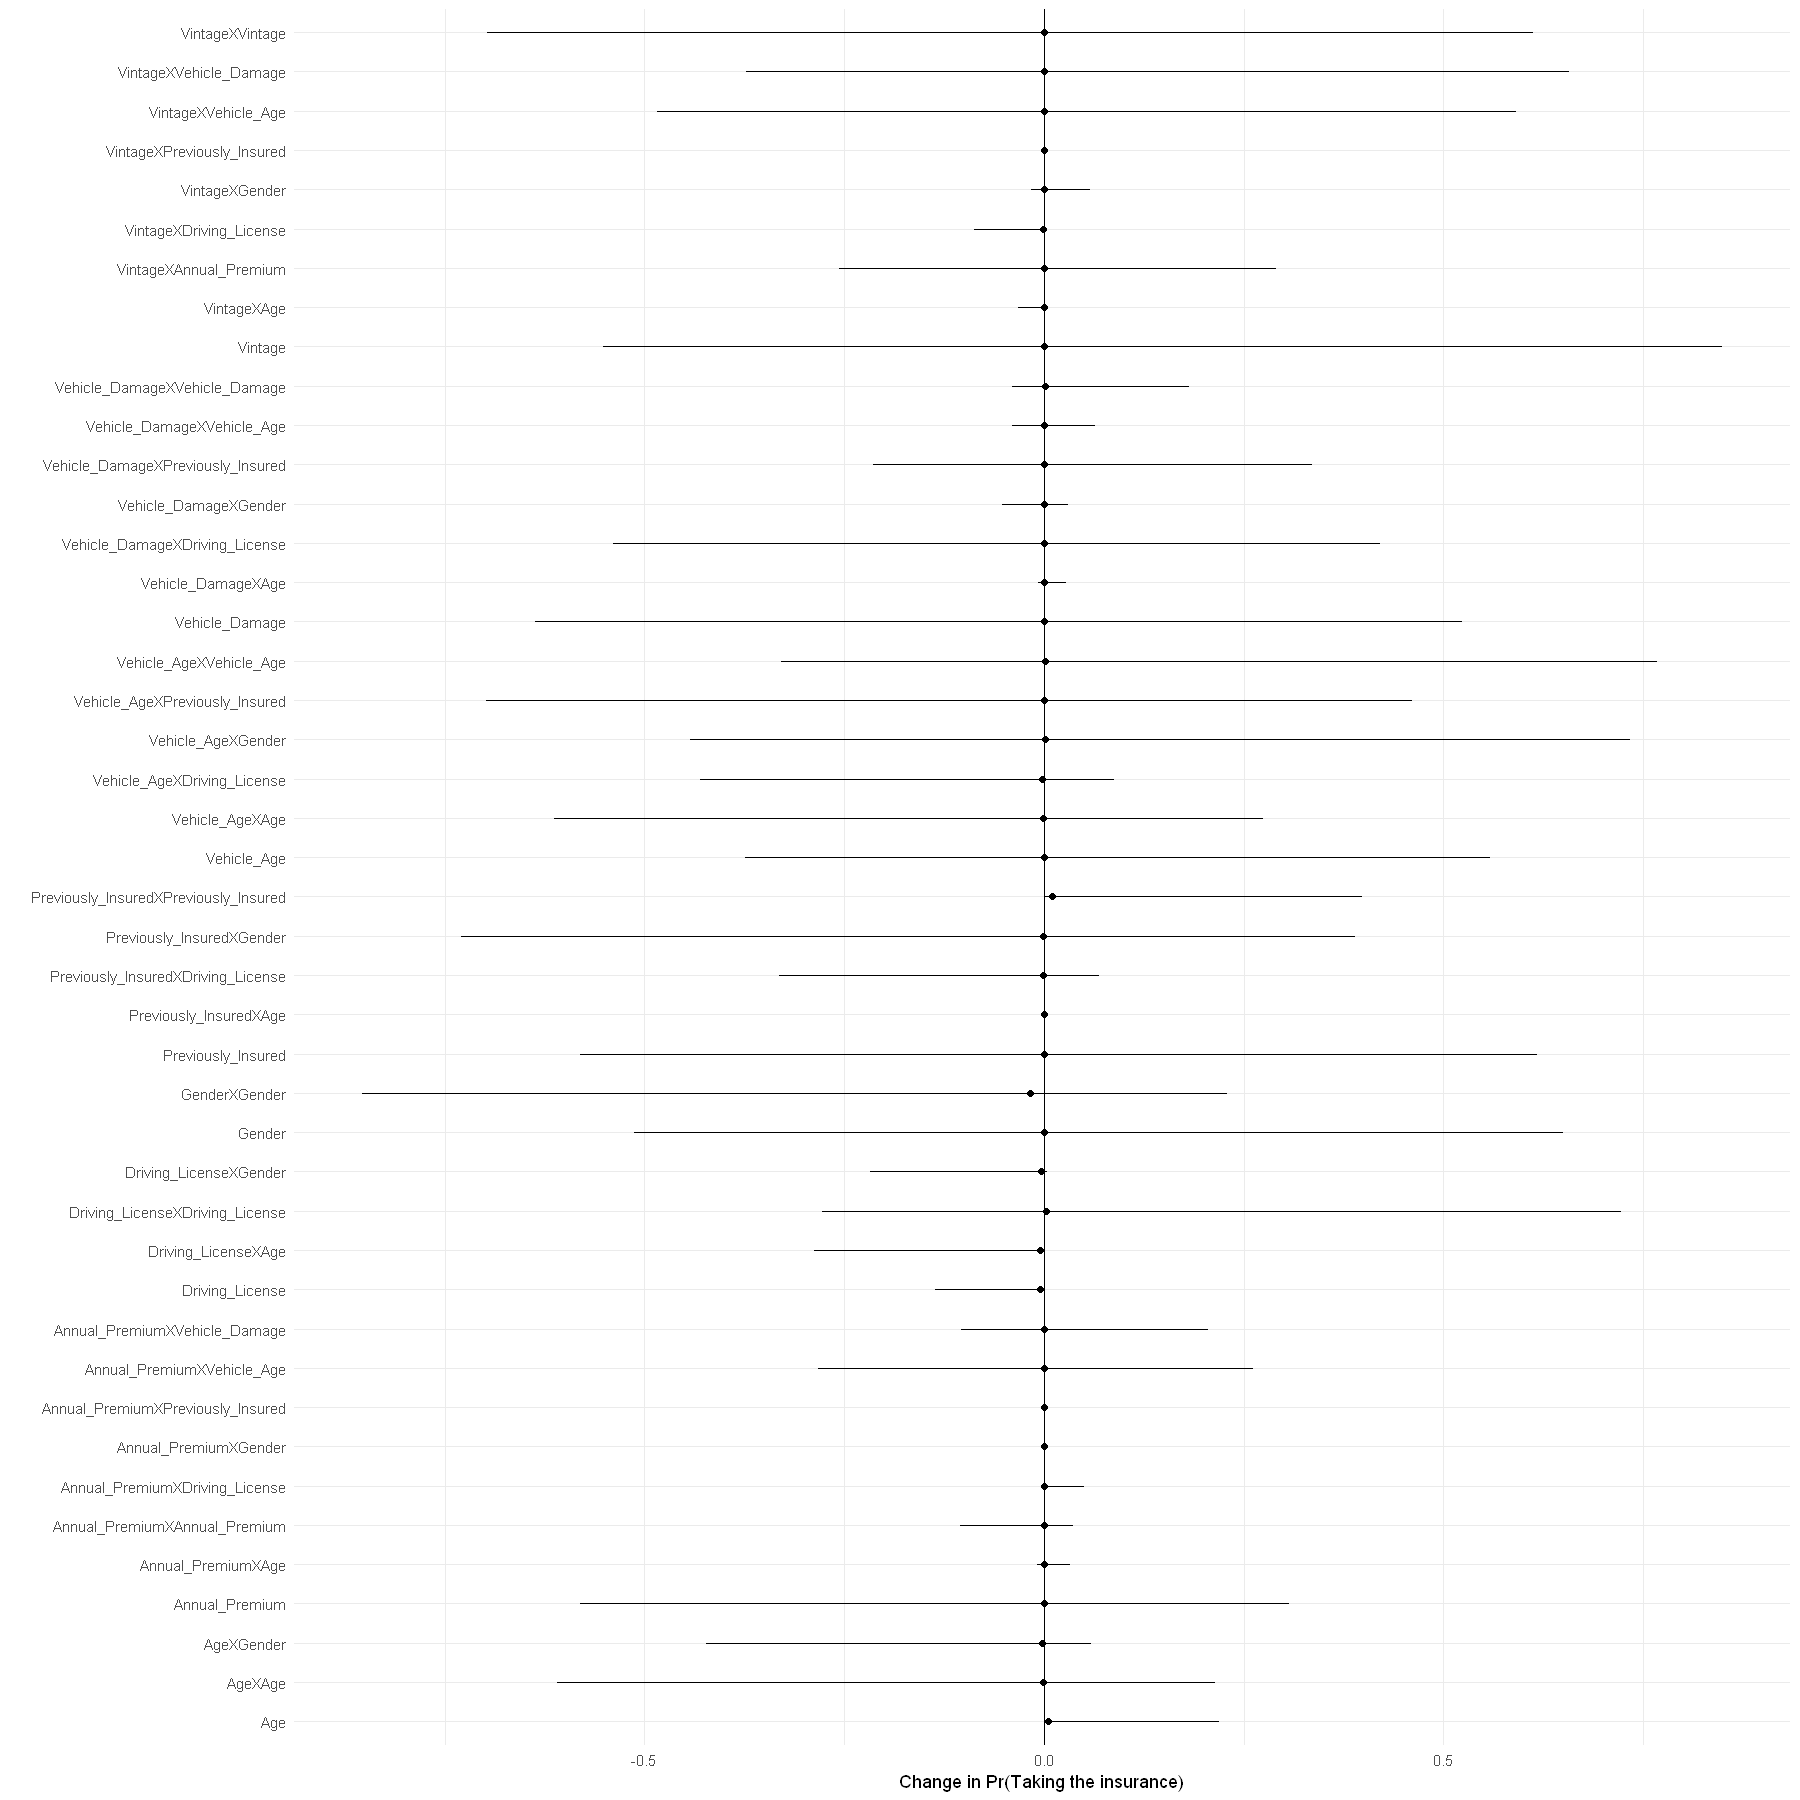

In [269]:
ggplot(data = first_difference.jags2, 
       aes(x = median_fd, y = VarName)) + 
  geom_point() + 
  geom_segment(aes(x = lower_fd, xend = upper_fd, yend = VarName)) + 
  geom_vline(xintercept = 0) + 
  xlab("Change in Pr(Taking the insurance)") + 
  ylab("") +
  theme_minimal()

In [290]:
aux=first_difference.jags2[order(abs(first_difference.jags2$median_fd),decreasing = TRUE),]
aux

median_fd     lower_fd      upper_fd     
GenderXGender                         -1.788984e-02 -8.537293e-01  2.296194e-01
Previously_InsuredXPreviously_Insured  1.011435e-02 -1.543568e-04  3.985111e-01
Age                                    5.648927e-03  2.998672e-08  2.197509e-01
Driving_LicenseXAge                   -4.909437e-03 -2.880136e-01  1.545731e-03
Driving_License                       -4.642555e-03 -1.361532e-01 -1.490051e-07
Driving_LicenseXGender                -3.483105e-03 -2.175893e-01  3.594133e-03
AgeXGender                            -2.620788e-03 -4.224192e-01  5.938720e-02
Vehicle_AgeXDriving_License           -2.309152e-03 -4.308274e-01  8.778948e-02
Driving_LicenseXDriving_License        2.197849e-03 -2.774640e-01  7.216724e-01
Vehicle_AgeXVehicle_Age                1.780408e-03 -3.289240e-01  7.675508e-01
AgeXAge                               -1.447943e-03 -6.099056e-01  2.144022e-01
Previously_InsuredXDriving_License    -1.260606e-03 -3.318950e-01  6.931330e-02
Vehicle_AgeXGender                     1.189508e-03 -4.433416e-01  7.332863e-01
VintageXDriving_License               -1.180770e-03 -8.694388e-02  1.759700e-03
Vehicle_DamageXVehicle_Damage          8.686380e-04 -4.034303e-02  1.810453e-01
Vehicle_AgeXAge                       -7.847165e-04 -6.137222e-01  2.739203e-01
Previously_InsuredXGender             -6.901674e-04 -7.295748e-01  3.898284e-01
VintageXVehicle_Damage                 6.106260e-04 -3.731529e-01  6.574403e-01
Vintage                                5.661929e-04 -5.517198e-01  8.490814e-01
Annual_PremiumXDriving_License         5.590508e-04 -2.962467e-03  5.026060e-02
Annual_Premium                        -3.327447e-04 -5.811648e-01  3.072689e-01
Annual_PremiumXVehicle_Damage          2.785892e-04 -1.035468e-01  2.053825e-01
VintageXAge                           -1.976130e-04 -3.271142e-02  4.627390e-03
Annual_PremiumXAnnual_Premium         -1.853886e-04 -1.046089e-01  3.684097e-02
Vehicle_AgeXPreviously_Insured        -1.465984e-04 -6.979469e-01  4.612104e-01
Vehicle_Damage                        -1.436884e-04 -6.368414e-01  5.230120e-01
VintageXGender                         1.253989e-04 -1.571455e-02  5.752384e-02
Annual_PremiumXAge                     1.065597e-04 -8.167775e-03  3.308090e-02
Vehicle_DamageXAge                     8.800915e-05 -6.867433e-03  2.738221e-02
Vehicle_DamageXDriving_License        -6.958061e-05 -5.395848e-01  4.206857e-01
VintageXVehicle_Age                    6.947208e-05 -4.846410e-01  5.906642e-01
Previously_Insured                     6.850722e-05 -5.802843e-01  6.168079e-01
Vehicle_Age                            6.165945e-05 -3.736652e-01  5.580534e-01
Annual_PremiumXGender                  4.781648e-05 -6.370958e-05  4.035579e-03
Gender                                 3.207053e-05 -5.127537e-01  6.494488e-01
Vehicle_DamageXPreviously_Insured      2.611471e-05 -2.134828e-01  3.353973e-01
VintageXVintage                       -2.458474e-05 -6.966140e-01  6.122071e-01
Vehicle_DamageXGender                 -2.244353e-05 -5.194908e-02  2.964147e-02
Vehicle_DamageXVehicle_Age             1.466228e-05 -3.963502e-02  6.369612e-02
VintageXAnnual_Premium                 5.978220e-06 -2.566071e-01  2.908121e-01
Annual_PremiumXVehicle_Age            -1.709061e-08 -2.831447e-01  2.615303e-01
Previously_InsuredXAge                 0.000000e+00  0.000000e+00  0.000000e+00
Annual_PremiumXPreviously_Insured      0.000000e+00  0.000000e+00  0.000000e+00
VintageXPreviously_Insured             0.000000e+00  0.000000e+00  0.000000e+00
                                      VarName                              
GenderXGender                         GenderXGender                        
Previously_InsuredXPreviously_Insured Previously_InsuredXPreviously_Insured
Age                                   Age                                  
Driving_LicenseXAge                   Driving_LicenseXAge                  
Driving_License                       Driving_License     

In [295]:
list(aux$VarName)

[[1]]
 [1] "GenderXGender"                        
 [2] "Previously_InsuredXPreviously_Insured"
 [3] "Age"                                  
 [4] "Driving_LicenseXAge"                  
 [5] "Driving_License"                      
 [6] "Driving_LicenseXGender"               
 [7] "AgeXGender"                           
 [8] "Vehicle_AgeXDriving_License"          
 [9] "Driving_LicenseXDriving_License"      
[10] "Vehicle_AgeXVehicle_Age"              
[11] "AgeXAge"                              
[12] "Previously_InsuredXDriving_License"   
[13] "Vehicle_AgeXGender"                   
[14] "VintageXDriving_License"              
[15] "Vehicle_DamageXVehicle_Damage"        
[16] "Vehicle_AgeXAge"                      
[17] "Previously_InsuredXGender"            
[18] "VintageXVehicle_Damage"               
[19] "Vintage"                              
[20] "Annual_PremiumXDriving_License"       
[21] "Annual_Premium"                       
[22] "Annual_PremiumXVehicle_Damage"        
[23] "VintageXAge"                          
[24] "Annual_PremiumXAnnual_Premium"        
[25] "Vehicle_AgeXPreviously_Insured"       
[26] "Vehicle_Damage"                       
[27] "VintageXGender"                       
[28] "Annual_PremiumXAge"                   
[29] "Vehicle_DamageXAge"                   
[30] "Vehicle_DamageXDriving_License"       
[31] "VintageXVehicle_Age"                  
[32] "Previously_Insured"                   
[33] "Vehicle_Age"                          
[34] "Annual_PremiumXGender"                
[35] "Gender"                               
[36] "Vehicle_DamageXPreviously_Insured"    
[37] "VintageXVintage"                      
[38] "Vehicle_DamageXGender"                
[39] "Vehicle_DamageXVehicle_Age"           
[40] "VintageXAnnual_Premium"               
[41] "Annual_PremiumXVehicle_Age"           
[42] "Previously_InsuredXAge"               
[43] "Annual_PremiumXPreviously_Insured"    
[44] "VintageXPreviously_Insured"